In [20]:
pip install pytorch-ranger

Note: you may need to restart the kernel to use updated packages.


In [21]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter


In [22]:
from collections import defaultdict
import os
import pickle
import random
import requests
import time
import tqdm

from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
from pytorch_ranger import Ranger
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td
from torch.utils.tensorboard import SummaryWriter

In [23]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

**USE CUDA**

In [24]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda:0" if use_cuda else "cpu")


**ULTIL**

In [25]:
from collections import defaultdict
import os
import random
import time
import tqdm

import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch.utils.data as td


class EvalDataset(td.Dataset):
    def __init__(self, positive_data, item_num, positive_mat, negative_samples=99):
        super(EvalDataset, self).__init__()
        self.positive_data = np.array(positive_data)
        self.item_num = item_num
        self.positive_mat = positive_mat
        self.negative_samples = negative_samples
        
        self.reset()
        
    def reset(self):
        print("Resetting dataset")
        data = self.create_valid_data()
        labels = np.zeros(len(self.positive_data) * (1 + self.negative_samples))
        labels[::1+self.negative_samples] = 1
        self.data = np.concatenate([
            np.array(data), 
            np.array(labels)[:, np.newaxis]], 
            axis=1
        )

    def create_valid_data(self):
        valid_data = []
        for user, positive in self.positive_data:
            valid_data.append([user, positive])
            for i in range(self.negative_samples):
                negative = np.random.randint(self.item_num)
                while (user, negative) in self.positive_mat:
                    negative = np.random.randint(self.item_num)
                    
                valid_data.append([user, negative])
        return valid_data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        user, item, label = self.data[idx]
        output = {
            "user": user,
            "item": item,
            "label": np.float32(label),
        }
        return output


#https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_dim, mu=0.0, theta=0.15, max_sigma=0.4, min_sigma=0.4, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_dim
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return torch.tensor([action + ou_state]).float()


class Prioritized_Buffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, user, memory, action, reward, next_user, next_memory, done):
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((user, memory, action, reward, next_user, next_memory, done))
        else:
            self.buffer[self.pos] = (user, memory, action, reward, next_user, next_memory, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)

        batch       = list(zip(*samples))
        user        = np.concatenate(batch[0])
        memory      = np.concatenate(batch[1])
        action      = batch[2]
        reward      = batch[3]
        next_user   = np.concatenate(batch[4])
        next_memory = np.concatenate(batch[5])
        done        = batch[6]

        return user, memory, action, reward, next_user, next_memory, done

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)


def get_beta(idx, beta_start=0.4, beta_steps=100000):
    return min(1.0, beta_start + idx * (1.0 - beta_start) / beta_steps)

def preprocess_data(data_dir, train_rating):
    data = pd.read_csv(os.path.join(data_dir, train_rating), 
                       sep='\t', header=None, names=['user', 'item', 'rating'], 
                       usecols=[0, 1, 2], dtype={0: np.int32, 1: np.int32, 2: np.int8})
    data = data[data['rating'] > 3][['user', 'item']]
    user_num = data['user'].max() + 1
    item_num = data['item'].max() + 1

    train_data = data.sample(frac=0.8, random_state=16)
    test_data = data.drop(train_data.index).values.tolist()
    train_data = train_data.values.tolist()

    train_mat = defaultdict(int)
    test_mat = defaultdict(int)
    for user, item in train_data:
        train_mat[user, item] = 1.0
    for user, item in test_data:
        test_mat[user, item] = 1.0
    train_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    dict.update(train_matrix, train_mat)
    test_matrix = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    dict.update(test_matrix, test_mat)
    
    appropriate_users = np.arange(user_num).reshape(-1, 1)[(train_matrix.sum(1) >= 20)]
    
    return (train_data, train_matrix, test_data, test_matrix, 
            user_num, item_num, appropriate_users)

def to_np(tensor):
    return tensor.detach().cpu().numpy()

def hit_metric(recommended, actual):
    return int(actual in recommended)

def dcg_metric(recommended, actual):
    if actual in recommended:
        index = recommended.index(actual)
        return np.reciprocal(np.log2(index + 2))
    return 0

In [26]:
data_dir = "data"
rating = "ml-1m.train.rating"

params = {
    'batch_size': 512,
    'embedding_dim': 8,
    'hidden_dim': 16,
    'N': 5, # memory size for state_repr
    'ou_noise':False,
    
    'value_lr': 1e-5,
    'value_decay': 1e-4,
    'policy_lr': 1e-5,
    'policy_decay': 1e-6,
    'state_repr_lr': 1e-5,
    'state_repr_decay': 1e-3,
    'log_dir': 'logs/final/',
    'gamma': 0.8,
    'min_value': -10,
    'max_value': 10,
    'soft_tau': 1e-3,
    
    'buffer_size': 1000000
}


In [27]:
# Movielens (1M) data from the https://github.com/hexiangnan/neural_collaborative_filtering
if not os.path.isdir('./data'):
    os.mkdir('./data')
    
file_path = os.path.join(data_dir, rating)
if os.path.exists(file_path):
    print("Skip loading " + file_path)
else:
    with open(file_path, "wb") as tf:
        print("Load " + file_path)
        r = requests.get("https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/" + rating)
        tf.write(r.content)
(train_data, train_matrix, test_data, test_matrix, 
 user_num, item_num, appropriate_users) = preprocess_data(data_dir, rating)

Skip loading data/ml-1m.train.rating


In [28]:
class Env():
    def __init__(self, user_item_matrix):
        self.matrix = user_item_matrix
        self.item_count = item_num
        self.memory = np.ones([user_num, params['N']]) * item_num
        # memory is initialized as [item_num] * N for each user
        # it is padding indexes in state_repr and will result in zero embeddings

    def reset(self, user_id):
        self.user_id = user_id
        self.viewed_items = []
        self.related_items = np.argwhere(self.matrix[self.user_id] > 0)[:, 1]
        self.num_rele = len(self.related_items)
        self.nonrelated_items = np.random.choice(
            list(set(range(self.item_count)) - set(self.related_items)), self.num_rele)
        self.available_items = np.zeros(self.num_rele * 2)
        self.available_items[::2] = self.related_items
        self.available_items[1::2] = self.nonrelated_items
        
        return torch.tensor([self.user_id], device=device), torch.tensor(self.memory[[self.user_id], :], device=device)
    
    def step(self, action, action_emb=None, buffer=None):
        initial_user = self.user_id
        initial_memory = self.memory[[initial_user], :]
        
        reward = float(to_np(action)[0] in self.related_items)
        self.viewed_items.append(to_np(action)[0])

        if action.is_cuda:
            Action = action.cpu()
        else:
            Action = action
        
        if reward:
            if len(Action) == 1:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [Action]
            else:
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [Action[0]]
                
        if len(self.viewed_items) == len(self.related_items):
            done = 1
        else:
            done = 0
            
        if buffer is not None:
            buffer.push(np.array([initial_user]), np.array(initial_memory), to_np(action_emb)[0], 
                        np.array([reward]), np.array([self.user_id]), self.memory[[self.user_id], :], np.array([reward]))

        return torch.tensor([self.user_id], device=device), torch.tensor(self.memory[[self.user_id], :], device=device), reward, done

In [29]:
class State_Repr_Module(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num+1, embedding_dim, padding_idx=int(item_num))
        self.drr_ave = torch.nn.Conv1d(in_channels=params['N'], out_channels=1, kernel_size=1)
        
        self.initialize()
        self.to(device)
            
    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()
        nn.init.uniform_(self.drr_ave.weight)
        self.drr_ave.bias.data.zero_()

    def forward(self, user, memory):
        user = user.to(device)
        memory = memory.to(device)
        user_embedding = self.user_embeddings(user.long())
        

        item_embeddings = self.item_embeddings(memory.long())
        drr_ave = self.drr_ave(item_embeddings).squeeze(1)
        
        return torch.cat((user_embedding, user_embedding * drr_ave, drr_ave), 1).to(device)


In [30]:
class ValueNetwork(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
        )

        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x


In [31]:
class PolicyNetwork(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        
        self.initialize()
        self.to(device)

    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
        
    def evaluate(self, action_emb, epsilon=1e-6):
                
        mean, log_std = torch.chunk(action_emb.float(), 2, dim=-1)
        
        std = log_std.exp()
        normal = Normal(mean, std)
        z = normal.sample()

        act = torch.tanh(z)
        
        log_prob = normal.log_prob(z) - torch.log(1 - act.pow(2) + epsilon)
        log_prob = log_prob.sum(-1, keepdim=True)

        return action_emb, log_prob, z, mean, log_std
    

    def forward(self, state):
        return self.layers(state)
    
    def get_action(self, user, memory, state_repr, 
                   action_emb,
                   items=torch.tensor([i for i in range(item_num)]).to(device),
                   return_scores=False
                  ):
        state = state_repr(user, memory).to(device)
        items = items.to(device)
        scores = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0), 
                         action_emb.T.unsqueeze(0)).squeeze(0).to(device)
        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0)).to(device)
        else:
            return torch.gather(items, 0, scores.argmax(0)).to(device)

In [32]:
valid_dataset = EvalDataset(
    np.array(test_data)[np.array(test_data)[:, 0] == 6039], 
    item_num, 
    test_matrix)
valid_loader = td.DataLoader(valid_dataset, batch_size=100, shuffle=False)

full_dataset = EvalDataset(np.array(test_data), item_num, test_matrix)
full_loader = td.DataLoader(full_dataset, batch_size=100, shuffle=False)

Resetting dataset
Resetting dataset


In [33]:
def run_evaluation(net, state_representation, training_env_memory, loader=valid_loader):
    hits = []
    dcgs = []
    test_env = Env(test_matrix)
    test_env.memory = training_env_memory.copy()
    user, memory = test_env.reset(int(to_np(next(iter(valid_loader))['user'])[0]))
    user.to(device)
    memory.to(device)
    for batch in loader:
        action_emb = net(state_repr(user, memory)).to(device)
        scores, action = net.get_action(
            batch['user'], 
            torch.tensor(test_env.memory[to_np(batch['user']).astype(int), :]).to(device), 
            state_representation, 
            action_emb,
            batch['item'].long(), 
            return_scores=True
        )
        user, memory, reward, done = test_env.step(action)

        
        _, ind = scores[:, 0].topk(10)
        predictions = torch.take(batch['item'].to(device), ind).cpu().numpy().tolist()
        actual = batch['item'][0].item()
        hits.append(hit_metric(predictions, actual))
        dcgs.append(dcg_metric(predictions, actual))
        
    return np.mean(hits), np.mean(dcgs)

In [34]:
train_env = Env(train_matrix)


state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'] , params['hidden_dim']).to(device)
value_net  = ValueNetwork(params['embedding_dim'] * 3, params['embedding_dim'], params['hidden_dim']).to(device)
target_value_net = ValueNetwork(params['embedding_dim'] * 3, params['embedding_dim'], params['hidden_dim']).to(device)


policy_net = PolicyNetwork(params['embedding_dim'], params['hidden_dim']).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = params['buffer_size']
replay_buffer = Prioritized_Buffer(replay_buffer_size)
writer = SummaryWriter(log_dir=params['log_dir'])

In [35]:
optimizer_value  = Ranger(value_net.parameters(),  lr=params['value_lr'], 
                          weight_decay=params['value_decay'])
optimizer_policy = Ranger(policy_net.parameters(), lr=params['policy_lr'], 
                          weight_decay=params['policy_decay'])
state_repr_optimizer = Ranger(state_repr.parameters(), lr=params['state_repr_lr'], 
                              weight_decay=params['state_repr_decay'])

In [36]:
def ppo_update(train_env, policy_net, value_net, state_repr, optimizer_policy, optimizer_value, replay_buffer, clip_param=0.1, ppo_epoch=4, mini_batch_size=32, value_coef=0.5, entropy_coef=0.01):
    # Sample data from the replay buffer
    user, memory, action, reward, next_user, next_memory, done = replay_buffer.sample(mini_batch_size)

    # Convert data to tensors and move to the device
    user = torch.tensor(user, dtype=torch.long).to(device)
    memory = torch.tensor(memory, dtype=torch.float32).to(device)
    action = torch.tensor(action, dtype=torch.float32).to(device)
    reward = torch.tensor(reward, dtype=torch.float32).to(device)
    next_user = torch.tensor(next_user, dtype=torch.long).to(device)
    next_memory = torch.tensor(next_memory, dtype=torch.float32).to(device)
    done = torch.tensor(done, dtype=torch.float32).to(device)

    # Compute the current state and value predictions for the sampled data
    state = state_repr(user, memory)
    value = value_net(state, policy_net(state))

    # Compute the next state and value predictions for the sampled data
    with torch.no_grad():
        next_state = state_repr(next_user, next_memory)
        next_value = value_net(next_state, policy_net(next_state))
        mask = 1 - done

        # Compute the target value
        target_value = reward + mask * next_value

    # Compute the advantage
    advantage = target_value - value

    # Create mini-batches for training
    batch_size = user.shape[0]
    num_samples = user.shape[0]
    indices = torch.randperm(num_samples)
    mini_batch_count = num_samples // mini_batch_size

    for batch in range(mini_batch_count):
        # Compute the actions and log probabilities for the sampled data
        batch_indices = indices[batch * mini_batch_size : (batch + 1) * mini_batch_size]
        sampled_state = state[batch_indices]
        sampled_memory = memory[batch_indices]
        sampled_action = action[batch_indices]
        sampled_old_log_prob, _, _, _, _ = policy_net.evaluate(sampled_action)

        new_log_prob, _, _, _, _ = policy_net.evaluate(sampled_action)
        ratio = (new_log_prob - sampled_old_log_prob).exp()

        # Compute the clipped surrogate loss
        policy_loss1 = ratio * advantage[indices]
        policy_loss2 = torch.clamp(ratio, 1 - clip_param, 1 + clip_param) * advantage[indices]
        policy_loss = -torch.min(policy_loss1, policy_loss2).mean()

        # Compute the value loss
        sampled_target_value = target_value[indices]
        sampled_value = value[indices]
        clipped_value = sampled_value + torch.clamp(sampled_target_value - sampled_value, -clip_param, clip_param)
        value_loss1 = (sampled_value - sampled_target_value).pow(2)
        value_loss2 = (clipped_value - sampled_target_value).pow(2)
        value_loss = 0.5 * torch.max(value_loss1, value_loss2).mean()

        # Compute the entropy loss
        entropy_loss = -(new_log_prob.exp() * new_log_prob).mean()

        # Compute the total loss
        loss = policy_loss + value_coef * value_loss - entropy_coef * entropy_loss
        
        
        state_repr_optimizer.zero_grad()
        
        # Update the policy network
        optimizer_policy.zero_grad()
        loss.backward(retain_graph=True)
        optimizer_policy.step()

        # Update the value network
        optimizer_value.zero_grad()
        value_loss.backward(retain_graph=True)
        optimizer_value.step()

        state_repr_optimizer.step()


In [37]:
train_env = Env(train_matrix)
hits, dcgs = [], []
hits_all, dcgs_all = [], []
steps = []
step, best_step, best_step_all = 0, 0, 0
users = np.random.permutation(appropriate_users)
ou_noise = OUNoise(params['embedding_dim'], decay_period=10)

for u in tqdm.tqdm(users):
    user, memory = train_env.reset(u)
    if params['ou_noise']:
        ou_noise.reset()
    for t in range(int(train_matrix[u].sum())):
        state = state_repr(user, memory)
        action_emb_old = policy_net(state)
        if params['ou_noise']:
            action_emb_old = ou_noise.get_action(action_emb_old.detach().cpu().numpy()[0], t)
        action_old = policy_net.get_action(
            user,
            torch.tensor(train_env.memory[to_np(user).astype(int), :]),
            state_repr,
            action_emb_old,
            torch.tensor(
                [item for item in train_env.available_items
                if item not in train_env.viewed_items]
            ).long()
        )
        user, memory, reward, done = train_env.step(
            action_old,
            action_emb_old,
            buffer=replay_buffer
        )

        if len(replay_buffer) > params['batch_size']:
            ppo_update(train_env, policy_net, value_net, state_repr, optimizer_policy, optimizer_value, replay_buffer)

        if step % 100 == 0 and step > 0:
            hit, dcg = run_evaluation(policy_net, state_repr, train_env.memory)
            print(hit, dcg)
            writer.add_scalar('hit', hit, step)
            writer.add_scalar('dcg', dcg, step)
            hits.append(hit)
            dcgs.append(dcg)
            steps.append(step)
            if np.mean(np.array([hit, dcg]) - np.array([hits[best_step], dcgs[best_step]])) > 0:
                best_step = step // 100
                torch.save(policy_net.state_dict(), params['log_dir'] + 'policy_net.pth')
                torch.save(value_net.state_dict(), params['log_dir'] + 'value_net.pth')
                torch.save(state_repr.state_dict(), params['log_dir'] + 'state_repr.pth')
        if step % 10000 == 0 and step > 0:
            hit, dcg = run_evaluation(policy_net, state_repr, train_env.memory, full_loader)
            print(f'Hit {hit}, DCG {dcg}')
            writer.add_scalar('hit_all', hit, step)
            writer.add_scalar('dcg_all', dcg, step)
            hits_all.append(hit)
            dcgs_all.append(dcg)
            if np.mean(np.array([hit, dcg]) - np.array([hits_all[best_step_all], dcgs_all[best_step_all]])) > 0:
                best_step_all = step // 10000
                torch.save(policy_net.state_dict(), params['log_dir'] + 'best_policy_net.pth')
                torch.save(value_net.state_dict(), params['log_dir'] + 'best_value_net.pth')
                torch.save(state_repr.state_dict(), params['log_dir'] + 'best_state_repr.pth')
        step += 1


  0%|          | 2/4699 [00:00<09:14,  8.47it/s]

0.1509433962264151 0.06998844471263321


  0%|          | 4/4699 [00:00<09:57,  7.86it/s]

0.1509433962264151 0.06998844471263321
0.1509433962264151 0.06998844471263321


  0%|          | 5/4699 [00:01<26:14,  2.98it/s]

0.1509433962264151 0.06998844471263321


  0%|          | 6/4699 [00:01<29:35,  2.64it/s]

0.1509433962264151 0.06998844471263321


  0%|          | 7/4699 [00:02<37:50,  2.07it/s]

0.1509433962264151 0.06998844471263321


  0%|          | 9/4699 [00:03<38:16,  2.04it/s]

0.1509433962264151 0.06965130402305578


  0%|          | 10/4699 [00:03<34:21,  2.27it/s]

0.1509433962264151 0.06965130402305578
0.1509433962264151 0.06965130402305578


  0%|          | 11/4699 [00:07<1:37:44,  1.25s/it]

0.1509433962264151 0.06937894777547562


  0%|          | 13/4699 [00:09<1:22:06,  1.05s/it]

0.1509433962264151 0.06998005308665975


  0%|          | 14/4699 [00:09<1:07:42,  1.15it/s]

0.1509433962264151 0.06954847093996751


  0%|          | 16/4699 [00:10<1:02:30,  1.25it/s]

0.1320754716981132 0.06409441761321491
0.1320754716981132 0.06409441761321491


  0%|          | 18/4699 [00:13<1:11:17,  1.09it/s]

0.1320754716981132 0.06409441761321491


  0%|          | 19/4699 [00:13<57:32,  1.36it/s]  

0.1320754716981132 0.055550482340065904


  0%|          | 20/4699 [00:14<1:03:22,  1.23it/s]

0.1320754716981132 0.055550482340065904
0.1320754716981132 0.055550482340065904


  0%|          | 21/4699 [00:18<2:23:30,  1.84s/it]

0.1320754716981132 0.055550482340065904


  0%|          | 23/4699 [00:19<1:18:15,  1.00s/it]

0.1320754716981132 0.055550482340065904
0.11320754716981132 0.04987067110112286


  1%|          | 24/4699 [00:21<1:52:01,  1.44s/it]

0.11320754716981132 0.048465588630078126


  1%|          | 25/4699 [00:23<1:57:22,  1.51s/it]

0.11320754716981132 0.048465588630078126


  1%|          | 26/4699 [00:24<1:51:10,  1.43s/it]

0.11320754716981132 0.04763872540670357
0.11320754716981132 0.04720714326001133
0.11320754716981132 0.04720714326001133
0.11320754716981132 0.047696865793808434


  1%|          | 28/4699 [00:33<3:19:00,  2.56s/it]

0.11320754716981132 0.047696865793808434


  1%|          | 31/4699 [00:34<1:27:32,  1.13s/it]

0.11320754716981132 0.047696865793808434


  1%|          | 32/4699 [00:34<1:06:38,  1.17it/s]

0.11320754716981132 0.047696865793808434


  1%|          | 35/4699 [00:36<52:20,  1.48it/s]  

0.11320754716981132 0.047696865793808434


  1%|          | 36/4699 [00:37<46:33,  1.67it/s]

0.11320754716981132 0.047696865793808434
0.11320754716981132 0.047696865793808434
0.11320754716981132 0.048251372769602854


  1%|          | 37/4699 [00:42<2:50:25,  2.19s/it]

0.11320754716981132 0.048251372769602854


  1%|          | 40/4699 [00:44<1:18:52,  1.02s/it]

0.11320754716981132 0.04802561485741241
0.11320754716981132 0.04933360432772576


  1%|          | 41/4699 [00:46<1:47:54,  1.39s/it]

0.11320754716981132 0.04933360432772576


  1%|          | 43/4699 [00:47<1:09:18,  1.12it/s]

0.11320754716981132 0.056297193882981274


  1%|          | 45/4699 [00:48<57:29,  1.35it/s]  

0.11320754716981132 0.056297193882981274


  1%|          | 46/4699 [00:49<57:16,  1.35it/s]

0.11320754716981132 0.056297193882981274


  1%|          | 47/4699 [00:51<1:27:21,  1.13s/it]

0.11320754716981132 0.056297193882981274
0.09433962264150944 0.050843140556228676
0.09433962264150944 0.050843140556228676


  1%|          | 48/4699 [00:54<2:18:33,  1.79s/it]

0.09433962264150944 0.050843140556228676


  1%|          | 49/4699 [00:55<2:03:20,  1.59s/it]

0.09433962264150944 0.050843140556228676
0.09433962264150944 0.050843140556228676


  1%|          | 50/4699 [01:00<3:11:42,  2.47s/it]

0.09433962264150944 0.050843140556228676


  1%|          | 54/4699 [01:01<1:04:44,  1.20it/s]

0.09433962264150944 0.050843140556228676
0.09433962264150944 0.050843140556228676


  1%|          | 55/4699 [01:02<1:10:30,  1.10it/s]

0.09433962264150944 0.050843140556228676


  1%|          | 56/4699 [01:03<1:12:54,  1.06it/s]

0.09433962264150944 0.05127472270292092
0.09433962264150944 0.05127472270292092


  1%|          | 57/4699 [01:06<1:51:56,  1.45s/it]

0.11320754716981132 0.056728776029673515
0.11320754716981132 0.056728776029673515
0.11320754716981132 0.058036765499986855
0.11320754716981132 0.058534879659757434
0.1320754716981132 0.0667964463849829


  1%|▏         | 59/4699 [01:19<4:37:16,  3.59s/it]

0.1320754716981132 0.0667964463849829


  1%|▏         | 60/4699 [01:21<3:49:08,  2.96s/it]

0.1320754716981132 0.0667964463849829


  1%|▏         | 62/4699 [01:23<2:22:51,  1.85s/it]

0.1509433962264151 0.07326030110609794


  1%|▏         | 64/4699 [01:23<1:21:45,  1.06s/it]

0.1509433962264151 0.07703866328530669
0.1509433962264151 0.07726442119749713
0.1509433962264151 0.07749017910968757


  1%|▏         | 65/4699 [01:27<2:36:39,  2.03s/it]

0.1509433962264151 0.07803489160484786


  1%|▏         | 68/4699 [01:29<1:22:47,  1.07s/it]

0.1509433962264151 0.07803489160484786


  1%|▏         | 69/4699 [01:30<1:21:00,  1.05s/it]

0.1509433962264151 0.07861311085251803


  1%|▏         | 70/4699 [01:31<1:08:25,  1.13it/s]

0.1509433962264151 0.07861311085251803


  2%|▏         | 71/4699 [01:32<1:05:51,  1.17it/s]

0.1509433962264151 0.07861311085251803


  2%|▏         | 72/4699 [01:33<1:12:02,  1.07it/s]

0.16981132075471697 0.08440430486884808
0.16981132075471697 0.08474144555842551
0.16981132075471697 0.08474144555842551
0.16981132075471697 0.08474144555842551
0.16981132075471697 0.08474144555842551
0.16981132075471697 0.09170503511368105


  2%|▏         | 73/4699 [01:57<10:08:14,  7.89s/it]

0.16981132075471697 0.09253189833705561


  2%|▏         | 76/4699 [01:59<3:53:12,  3.03s/it] 

0.16981132075471697 0.09253189833705561


  2%|▏         | 77/4699 [01:59<2:54:15,  2.26s/it]

0.16981132075471697 0.09383988780736895
0.16981132075471697 0.09383988780736895


  2%|▏         | 79/4699 [02:01<2:00:28,  1.56s/it]

0.16981132075471697 0.09383988780736895


  2%|▏         | 80/4699 [02:02<1:51:36,  1.45s/it]

0.16981132075471697 0.09427146995406119
0.16981132075471697 0.0967418426629566
0.16981132075471697 0.09739918272183928


  2%|▏         | 82/4699 [02:07<2:18:15,  1.80s/it]

0.16981132075471697 0.09739918272183928
0.18867924528301888 0.10324851712527419


  2%|▏         | 85/4699 [02:10<1:16:41,  1.00it/s]

0.18867924528301888 0.10324851712527419


  2%|▏         | 86/4699 [02:10<1:09:27,  1.11it/s]

0.18867924528301888 0.10307899396078232


  2%|▏         | 87/4699 [02:12<1:30:08,  1.17s/it]

0.18867924528301888 0.10417821343173703


  2%|▏         | 88/4699 [02:13<1:27:07,  1.13s/it]

0.18867924528301888 0.10335135020836247


  2%|▏         | 90/4699 [02:14<1:06:39,  1.15it/s]

0.20754716981132076 0.10965597903036539


  2%|▏         | 91/4699 [02:16<1:19:33,  1.04s/it]

0.20754716981132076 0.10999311971994283


  2%|▏         | 92/4699 [02:16<1:07:32,  1.14it/s]

0.20754716981132076 0.11100292111430526


  2%|▏         | 93/4699 [02:17<1:09:49,  1.10it/s]

0.20754716981132076 0.11205554224987026
0.20754716981132076 0.11261004922566467


  2%|▏         | 94/4699 [02:21<2:22:09,  1.85s/it]

0.20754716981132076 0.11391803869597801


  2%|▏         | 95/4699 [02:22<2:00:25,  1.57s/it]

0.20754716981132076 0.11419039494355815
0.22641509433962265 0.11964444827031075


  2%|▏         | 96/4699 [02:24<1:59:01,  1.55s/it]

0.22641509433962265 0.11987020618250119
0.22641509433962265 0.12014256243008134


  2%|▏         | 97/4699 [02:27<2:33:31,  2.00s/it]

0.22641509433962265 0.12459520598844498


  2%|▏         | 98/4699 [05:01<60:56:46, 47.69s/it]

Hit 0.24373584278605226, DCG 0.12447892151667386
0.22641509433962265 0.12486756223602513
0.22641509433962265 0.12486756223602513


  2%|▏         | 99/4699 [05:05<44:01:19, 34.45s/it]

0.22641509433962265 0.12486756223602513


  2%|▏         | 101/4699 [05:06<21:58:15, 17.20s/it]

0.22641509433962265 0.12409883939975545


  2%|▏         | 103/4699 [05:07<11:02:22,  8.65s/it]

0.22641509433962265 0.12656921210865085
0.22641509433962265 0.12733793494492054


  2%|▏         | 104/4699 [05:09<8:39:19,  6.78s/it] 

0.22641509433962265 0.12733793494492054
0.22641509433962265 0.12733793494492054


  2%|▏         | 105/4699 [05:13<7:15:51,  5.69s/it]

0.24528301886792453 0.13279198827167316
0.24528301886792453 0.13279198827167316


  2%|▏         | 106/4699 [05:15<6:10:46,  4.84s/it]

0.24528301886792453 0.13279198827167316


  2%|▏         | 107/4699 [05:16<4:32:18,  3.56s/it]

0.24528301886792453 0.1326453511706952


  2%|▏         | 108/4699 [05:17<3:32:25,  2.78s/it]

0.24528301886792453 0.1333026912295779


  2%|▏         | 109/4699 [05:18<2:58:44,  2.34s/it]

0.24528301886792453 0.1333026912295779
0.24528301886792453 0.1333026912295779


  2%|▏         | 111/4699 [05:21<2:20:59,  1.84s/it]

0.24528301886792453 0.1333026912295779


  2%|▏         | 112/4699 [05:23<2:17:53,  1.80s/it]

0.24528301886792453 0.1338809104772481


  2%|▏         | 113/4699 [05:24<1:51:06,  1.45s/it]

0.24528301886792453 0.13415326672482822


  2%|▏         | 114/4699 [05:25<1:46:09,  1.39s/it]

0.24528301886792453 0.13415326672482822


  2%|▏         | 116/4699 [05:26<1:17:10,  1.01s/it]

0.24528301886792453 0.13415326672482822


  2%|▏         | 117/4699 [05:27<1:15:28,  1.01it/s]

0.24528301886792453 0.13405882526771343


  3%|▎         | 119/4699 [05:28<55:20,  1.38it/s]  

0.2641509433962264 0.13994446074115827


  3%|▎         | 122/4699 [05:29<35:15,  2.16it/s]

0.2641509433962264 0.13994446074115827
0.2641509433962264 0.13994446074115827


  3%|▎         | 124/4699 [05:31<54:29,  1.40it/s]  

0.2641509433962264 0.13994446074115827


  3%|▎         | 126/4699 [05:32<46:03,  1.65it/s]

0.2641509433962264 0.13994446074115827
0.2641509433962264 0.1424148334500537


  3%|▎         | 128/4699 [05:35<1:13:53,  1.03it/s]

0.2641509433962264 0.13545124389479818


  3%|▎         | 129/4699 [05:36<1:01:25,  1.24it/s]

0.2641509433962264 0.1356770018069886
0.2641509433962264 0.1356770018069886


  3%|▎         | 131/4699 [05:40<1:37:30,  1.28s/it]

0.2641509433962264 0.1356770018069886
0.2641509433962264 0.1356770018069886
0.2641509433962264 0.1356770018069886


  3%|▎         | 132/4699 [05:44<2:38:15,  2.08s/it]

0.2641509433962264 0.1356770018069886
0.2641509433962264 0.1332066290980932


  3%|▎         | 134/4699 [05:46<2:06:21,  1.66s/it]

0.2641509433962264 0.1332066290980932


  3%|▎         | 135/4699 [05:47<1:38:34,  1.30s/it]

0.2641509433962264 0.13378484834576337


  3%|▎         | 137/4699 [05:48<1:14:51,  1.02it/s]

0.2641509433962264 0.13436306759343355


  3%|▎         | 138/4699 [05:49<1:13:14,  1.04it/s]

0.2641509433962264 0.13479464974012578


  3%|▎         | 139/4699 [05:50<1:11:59,  1.06it/s]

0.2641509433962264 0.13479464974012578


  3%|▎         | 140/4699 [05:51<1:11:38,  1.06it/s]

0.2641509433962264 0.13537286898779596
0.2641509433962264 0.13729895168212522


  3%|▎         | 143/4699 [05:55<1:05:57,  1.15it/s]

0.2641509433962264 0.13729895168212522


  3%|▎         | 147/4699 [05:56<34:51,  2.18it/s]  

0.2641509433962264 0.14499231146002392


  3%|▎         | 149/4699 [05:57<35:55,  2.11it/s]

0.2641509433962264 0.14557053070769407
0.2641509433962264 0.14557053070769407


  3%|▎         | 151/4699 [05:59<50:12,  1.51it/s]

0.2641509433962264 0.14557053070769407


  3%|▎         | 152/4699 [06:00<59:35,  1.27it/s]

0.2641509433962264 0.14557053070769407


  3%|▎         | 153/4699 [06:01<1:10:34,  1.07it/s]

0.2641509433962264 0.14557053070769407


  3%|▎         | 155/4699 [06:03<1:01:01,  1.24it/s]

0.2830188679245283 0.15185144725782124


  3%|▎         | 156/4699 [06:04<1:06:06,  1.15it/s]

0.2830188679245283 0.15234956141759184
0.2830188679245283 0.15234956141759184


  3%|▎         | 157/4699 [06:05<1:27:29,  1.16s/it]

0.2830188679245283 0.15268670210716925
0.2830188679245283 0.15241434585958913
0.2830188679245283 0.15381942833063386
0.2830188679245283 0.15539977404852734


  3%|▎         | 159/4699 [06:14<2:57:36,  2.35s/it]

0.2830188679245283 0.15539977404852734
0.2830188679245283 0.15539977404852734


  3%|▎         | 161/4699 [06:17<2:22:07,  1.88s/it]

0.2830188679245283 0.15539977404852734


  3%|▎         | 162/4699 [06:17<1:47:25,  1.42s/it]

0.2830188679245283 0.1463013317995839
0.3018867924528302 0.15092852190296197


  3%|▎         | 163/4699 [06:21<2:34:22,  2.04s/it]

0.3018867924528302 0.15057606056748224
0.3018867924528302 0.1503349820093895


  4%|▎         | 166/4699 [06:23<1:26:52,  1.15s/it]

0.3018867924528302 0.15060733825696965


  4%|▎         | 167/4699 [06:25<1:25:40,  1.13s/it]

0.3018867924528302 0.1513760610932393


  4%|▎         | 169/4699 [06:26<1:03:24,  1.19it/s]

0.3018867924528302 0.14643531567544849


  4%|▎         | 171/4699 [06:27<47:44,  1.58it/s]  

0.3018867924528302 0.14512732620513513


  4%|▎         | 172/4699 [06:27<52:35,  1.43it/s]

0.3018867924528302 0.14430046298176058


  4%|▎         | 175/4699 [06:29<39:47,  1.90it/s]

0.3018867924528302 0.1414929495832877
0.3018867924528302 0.1414929495832877


  4%|▍         | 177/4699 [06:31<52:14,  1.44it/s]  

0.3018867924528302 0.14289803205433244
0.3018867924528302 0.14058024118965667
0.3018867924528302 0.1407268782906346
0.3018867924528302 0.13742802168399473
0.3018867924528302 0.1361764250297052
0.2830188679245283 0.12956593320761225
0.2830188679245283 0.1299975153543045


  4%|▍         | 179/4699 [06:54<6:42:04,  5.34s/it]

0.2830188679245283 0.1299975153543045
0.2830188679245283 0.13048723788810163
0.2830188679245283 0.13141318931196924
0.2830188679245283 0.13107604862239183


  4%|▍         | 181/4699 [07:04<5:54:36,  4.71s/it]

0.2641509433962264 0.12462576697609803
0.2641509433962264 0.12379890375272348


  4%|▍         | 183/4699 [07:06<3:31:13,  2.81s/it]

0.2641509433962264 0.12382473558109426


  4%|▍         | 185/4699 [07:08<2:07:55,  1.70s/it]

0.2641509433962264 0.12217960542120347


  4%|▍         | 186/4699 [07:09<1:52:07,  1.49s/it]

0.2641509433962264 0.1217280895968226


  4%|▍         | 188/4699 [07:10<1:20:27,  1.07s/it]

0.2641509433962264 0.12230630884449278


  4%|▍         | 189/4699 [07:10<1:01:36,  1.22it/s]

0.22641509433962265 0.11057133896761302


  4%|▍         | 190/4699 [07:11<1:07:15,  1.12it/s]

0.22641509433962265 0.1092633494972997


  4%|▍         | 191/4699 [07:14<1:40:24,  1.34s/it]

0.22641509433962265 0.10868513024962949
0.22641509433962265 0.11057728371085476
0.20754716981132076 0.10462511622433157


  4%|▍         | 193/4699 [07:17<1:48:04,  1.44s/it]

0.20754716981132076 0.10419353407763933


  4%|▍         | 196/4699 [07:19<55:20,  1.36it/s]  

0.20754716981132076 0.11115712363289484
0.20754716981132076 0.10947304085937752


  4%|▍         | 198/4699 [07:22<1:19:44,  1.06s/it]

0.20754716981132076 0.10904145871268528
0.20754716981132076 0.10904145871268528


  4%|▍         | 199/4699 [07:23<1:24:29,  1.13s/it]

0.20754716981132076 0.1090414587126853
0.22641509433962265 0.11449551203943789
0.20754716981132076 0.11117469073200326
Hit 0.18082752468493365, DCG 0.08752137282968575
0.20754716981132076 0.11090233448442313


  4%|▍         | 200/4699 [10:05<61:51:20, 49.50s/it]

0.20754716981132076 0.10957735710127797
0.20754716981132076 0.10935159918908754


  4%|▍         | 202/4699 [10:09<31:18:10, 25.06s/it]

0.18867924528301888 0.1035604051727575
0.18867924528301888 0.1035604051727575


  4%|▍         | 203/4699 [10:10<22:24:51, 17.95s/it]

0.18867924528301888 0.1030156926775972
0.20754716981132076 0.11860926733714305


  4%|▍         | 204/4699 [10:13<16:44:33, 13.41s/it]

0.18867924528301888 0.11141564239338486


  4%|▍         | 205/4699 [10:15<12:33:30, 10.06s/it]

0.16981132075471697 0.10596158906663225


  4%|▍         | 206/4699 [10:16<9:02:33,  7.25s/it] 

0.16981132075471697 0.10596158906663225


  4%|▍         | 208/4699 [10:17<4:50:28,  3.88s/it]

0.1509433962264151 0.10050753573987965


  4%|▍         | 211/4699 [10:19<2:03:44,  1.65s/it]

0.1509433962264151 0.10050753573987965


  5%|▍         | 213/4699 [10:20<1:11:15,  1.05it/s]

0.1509433962264151 0.10028177782768923
0.1509433962264151 0.10028177782768923
0.1320754716981132 0.09482772450093661


  5%|▍         | 214/4699 [10:25<2:47:24,  2.24s/it]

0.1320754716981132 0.09482772450093661


  5%|▍         | 215/4699 [10:27<2:34:37,  2.07s/it]

0.1320754716981132 0.09482772450093661
0.1320754716981132 0.09482772450093661


  5%|▍         | 217/4699 [10:29<1:52:30,  1.51s/it]

0.1320754716981132 0.09449058381135918
0.1320754716981132 0.09421822756377904


  5%|▍         | 219/4699 [10:31<1:40:52,  1.35s/it]

0.1320754716981132 0.09399246965158858


  5%|▍         | 221/4699 [10:32<1:05:44,  1.14it/s]

0.1320754716981132 0.09399246965158858


  5%|▍         | 222/4699 [10:33<58:25,  1.28it/s]  

0.1320754716981132 0.09399246965158858


  5%|▍         | 223/4699 [10:34<1:08:25,  1.09it/s]

0.1509433962264151 0.11601506056828419


  5%|▍         | 224/4699 [10:35<1:15:48,  1.02s/it]

0.1509433962264151 0.11601506056828419


  5%|▍         | 225/4699 [10:37<1:43:00,  1.38s/it]

0.1509433962264151 0.11601506056828419
0.1509433962264151 0.11601506056828419


  5%|▍         | 228/4699 [10:39<1:01:33,  1.21it/s]

0.1509433962264151 0.11601506056828419


  5%|▍         | 230/4699 [10:41<57:03,  1.31it/s]  

0.1509433962264151 0.11601506056828419


  5%|▍         | 233/4699 [10:42<36:34,  2.04it/s]

0.1509433962264151 0.11601506056828419


  5%|▌         | 235/4699 [10:42<28:02,  2.65it/s]

0.1509433962264151 0.11635220125786164


  5%|▌         | 236/4699 [10:43<39:49,  1.87it/s]

0.1320754716981132 0.09421822756377905


  5%|▌         | 237/4699 [10:45<1:01:29,  1.21it/s]

0.1320754716981132 0.09552621703409239
0.1320754716981132 0.09552621703409239


  5%|▌         | 239/4699 [10:48<1:24:26,  1.14s/it]

0.1320754716981132 0.09552621703409239


  5%|▌         | 241/4699 [10:49<1:02:21,  1.19it/s]

0.1320754716981132 0.10496017929824333
0.1509433962264151 0.11091234678476652
0.16981132075471697 0.1169758970486767


  5%|▌         | 242/4699 [10:54<2:20:27,  1.89s/it]

0.16981132075471697 0.1169758970486767
0.18867924528301888 0.11995957766653387
0.18867924528301888 0.12029671835611132
0.18867924528301888 0.12095405841499401
0.18867924528301888 0.12117981632718444


  5%|▌         | 243/4699 [11:05<5:51:54,  4.74s/it]

0.18867924528301888 0.12175803557485462


  5%|▌         | 245/4699 [11:07<3:32:06,  2.86s/it]

0.18867924528301888 0.12301648094492142
0.18867924528301888 0.12054610823602599


  5%|▌         | 246/4699 [11:09<3:03:50,  2.48s/it]

0.18867924528301888 0.11923811876571266
0.18867924528301888 0.11923811876571266


  5%|▌         | 247/4699 [11:11<3:05:10,  2.50s/it]

0.18867924528301888 0.1195104750132928


  5%|▌         | 248/4699 [11:13<2:45:19,  2.23s/it]

0.18867924528301888 0.1195104750132928


  5%|▌         | 250/4699 [11:15<1:47:24,  1.45s/it]

0.18867924528301888 0.1214911251883911


  5%|▌         | 251/4699 [11:15<1:20:35,  1.09s/it]

0.22641509433962265 0.13919329823265994


  5%|▌         | 252/4699 [11:16<1:20:25,  1.09s/it]

0.24528301886792453 0.14575496265634072


  5%|▌         | 254/4699 [11:18<1:12:06,  1.03it/s]

0.24528301886792453 0.14534626657316244
0.22641509433962265 0.13863376787634302


  5%|▌         | 257/4699 [11:21<1:01:43,  1.20it/s]

0.22641509433962265 0.13863376787634302
0.22641509433962265 0.13863376787634302
0.22641509433962265 0.13863376787634302


  5%|▌         | 258/4699 [11:25<2:15:45,  1.83s/it]

0.22641509433962265 0.1394606310997176


  6%|▌         | 261/4699 [11:27<1:10:28,  1.05it/s]

0.22641509433962265 0.13989221324640982


  6%|▌         | 262/4699 [11:28<1:25:23,  1.15s/it]

0.22641509433962265 0.14090201464077223


  6%|▌         | 264/4699 [11:29<54:23,  1.36it/s]  

0.22641509433962265 0.14090201464077223


  6%|▌         | 266/4699 [11:30<49:53,  1.48it/s]

0.22641509433962265 0.14069619040627043


  6%|▌         | 268/4699 [11:31<45:32,  1.62it/s]

0.22641509433962265 0.14069619040627043


  6%|▌         | 269/4699 [11:32<50:01,  1.48it/s]

0.22641509433962265 0.14069619040627043
0.24528301886792453 0.1464225999806032
0.24528301886792453 0.14675974067018063


  6%|▌         | 271/4699 [11:37<1:43:14,  1.40s/it]

0.24528301886792453 0.14664835789279365
0.24528301886792453 0.14822870361068713
0.24528301886792453 0.14092797336585414


  6%|▌         | 273/4699 [11:42<2:15:06,  1.83s/it]

0.24528301886792453 0.14092797336585414


  6%|▌         | 274/4699 [11:43<1:47:12,  1.45s/it]

0.2641509433962264 0.14638202669260675


  6%|▌         | 276/4699 [11:45<1:21:25,  1.10s/it]

0.2830188679245283 0.1526629432427339


  6%|▌         | 278/4699 [11:46<1:02:36,  1.18it/s]

0.2830188679245283 0.15306486837430863


  6%|▌         | 279/4699 [11:46<51:25,  1.43it/s]  

0.3018867924528302 0.15863030447844825
0.3018867924528302 0.1595287230954237


  6%|▌         | 280/4699 [11:50<1:54:35,  1.56s/it]

0.32075471698113206 0.16525513266975642


  6%|▌         | 282/4699 [11:51<1:14:02,  1.01s/it]

0.3018867924528302 0.16002683725519423
0.3018867924528302 0.16128528262526104
0.3018867924528302 0.1615576388728412
0.3018867924528302 0.16228151094480223


  6%|▌         | 283/4699 [12:01<4:31:53,  3.69s/it]

0.3018867924528302 0.16228151094480223


  6%|▌         | 284/4699 [12:02<3:44:25,  3.05s/it]

0.3018867924528302 0.16228151094480223
0.32075471698113206 0.16773556427155484


  6%|▌         | 285/4699 [12:04<3:02:27,  2.48s/it]

0.32075471698113206 0.16560233225223683


  6%|▌         | 287/4699 [12:05<1:57:24,  1.60s/it]

0.32075471698113206 0.16566711669423415
0.32075471698113206 0.1659394729418143


  6%|▌         | 288/4699 [12:08<2:18:08,  1.88s/it]

0.32075471698113206 0.16651769218948445


  6%|▌         | 289/4699 [12:10<2:18:47,  1.89s/it]

0.32075471698113206 0.16738085648286893


  6%|▌         | 290/4699 [12:11<2:02:05,  1.66s/it]

0.32075471698113206 0.16142706832197584


  6%|▌         | 291/4699 [12:12<1:50:28,  1.50s/it]

0.32075471698113206 0.16200528756964602


  6%|▌         | 293/4699 [12:13<1:17:47,  1.06s/it]

0.33962264150943394 0.16803756014406881


  6%|▋         | 294/4699 [12:14<1:13:16,  1.00it/s]

0.33962264150943394 0.1688644233674434


  6%|▋         | 295/4699 [12:15<1:06:56,  1.10it/s]

0.33962264150943394 0.17017241283775672


  6%|▋         | 297/4699 [12:16<53:12,  1.38it/s]  

0.33962264150943394 0.17073531143952458


  6%|▋         | 299/4699 [12:18<55:47,  1.31it/s]  

0.33962264150943394 0.17156217466289916


  6%|▋         | 302/4699 [12:19<36:55,  1.98it/s]

0.33962264150943394 0.1718993153524766


  6%|▋         | 303/4699 [12:20<52:40,  1.39it/s]

0.33962264150943394 0.17247753460014678


  6%|▋         | 304/4699 [12:21<47:53,  1.53it/s]

0.33962264150943394 0.1738025119832919
0.3584905660377358 0.17842970208666997
Hit 0.329409398203619, DCG 0.18398940174167677
0.3584905660377358 0.17842970208666997


  7%|▋         | 306/4699 [15:03<41:59:37, 34.41s/it]

0.3584905660377358 0.17891082833360875


  7%|▋         | 307/4699 [15:03<29:28:32, 24.16s/it]

0.3584905660377358 0.17822122630855153


  7%|▋         | 308/4699 [15:05<21:17:04, 17.45s/it]

0.3584905660377358 0.17849358255613168
0.3584905660377358 0.1776819596745079


  7%|▋         | 309/4699 [15:07<15:48:41, 12.97s/it]

0.37735849056603776 0.18291025508907008


  7%|▋         | 310/4699 [15:09<11:32:16,  9.46s/it]

0.37735849056603776 0.18291025508907008


  7%|▋         | 313/4699 [15:10<4:19:29,  3.55s/it] 

0.37735849056603776 0.18449060080696356


  7%|▋         | 314/4699 [15:10<3:09:20,  2.59s/it]

0.37735849056603776 0.18449060080696356


  7%|▋         | 315/4699 [15:11<2:34:14,  2.11s/it]

0.39622641509433965 0.18994465413371614


  7%|▋         | 316/4699 [15:14<2:42:34,  2.23s/it]

0.39622641509433965 0.1901704120459066


  7%|▋         | 317/4699 [15:15<2:15:10,  1.85s/it]

0.39622641509433965 0.19184785076453145


  7%|▋         | 320/4699 [15:16<1:09:21,  1.05it/s]

0.39622641509433965 0.1915754945169513
0.41509433962264153 0.1970295478437039
0.41509433962264153 0.19808216897926892


  7%|▋         | 323/4699 [15:20<1:05:55,  1.11it/s]

0.41509433962264153 0.19808216897926892


  7%|▋         | 325/4699 [15:21<1:00:23,  1.21it/s]

0.41509433962264153 0.19783352500356455
0.41509433962264153 0.19783352500356455


  7%|▋         | 328/4699 [15:24<57:38,  1.26it/s]  

0.41509433962264153 0.19783352500356455
0.41509433962264153 0.19783352500356455


  7%|▋         | 330/4699 [15:26<1:09:26,  1.05it/s]

0.41509433962264153 0.1981058812511447
0.41509433962264153 0.1984430219407221


  7%|▋         | 332/4699 [15:28<1:03:07,  1.15it/s]

0.41509433962264153 0.1984430219407221


  7%|▋         | 333/4699 [15:29<1:07:45,  1.07it/s]

0.41509433962264153 0.1984430219407221


  7%|▋         | 335/4699 [15:31<58:28,  1.24it/s]  

0.41509433962264153 0.20091339464961755
0.41509433962264153 0.20146790162541195


  7%|▋         | 336/4699 [15:34<1:44:34,  1.44s/it]

0.41509433962264153 0.20146790162541195
0.41509433962264153 0.2017402578729921


  7%|▋         | 339/4699 [15:37<1:13:32,  1.01s/it]

0.41509433962264153 0.20304824734330545


  7%|▋         | 341/4699 [15:38<51:30,  1.41it/s]  

0.41509433962264153 0.202822489431115


  7%|▋         | 343/4699 [15:39<45:11,  1.61it/s]

0.39622641509433965 0.19679021685669223


  7%|▋         | 344/4699 [15:40<53:23,  1.36it/s]

0.39622641509433965 0.19679021685669223


  7%|▋         | 347/4699 [15:42<44:33,  1.63it/s]

0.39622641509433965 0.19679021685669223


  7%|▋         | 348/4699 [15:42<41:37,  1.74it/s]

0.39622641509433965 0.19679021685669223


  7%|▋         | 349/4699 [15:43<53:54,  1.35it/s]

0.39622641509433965 0.19679021685669223


  7%|▋         | 351/4699 [15:45<54:00,  1.34it/s]  

0.39622641509433965 0.19809820632700553


  7%|▋         | 352/4699 [15:46<1:00:32,  1.20it/s]

0.39622641509433965 0.19776106563742812


  8%|▊         | 353/4699 [15:47<59:45,  1.21it/s]  

0.39622641509433965 0.19748870938984797


  8%|▊         | 354/4699 [15:49<1:23:25,  1.15s/it]

0.39622641509433965 0.19748870938984797


  8%|▊         | 355/4699 [15:49<1:10:55,  1.02it/s]

0.39622641509433965 0.19721635314226785
0.39622641509433965 0.19721635314226785


  8%|▊         | 357/4699 [15:53<1:40:49,  1.39s/it]

0.37735849056603776 0.19423267252441062


  8%|▊         | 359/4699 [15:54<1:00:58,  1.19it/s]

0.37735849056603776 0.19423267252441062


  8%|▊         | 362/4699 [15:55<41:59,  1.72it/s]  

0.37735849056603776 0.1934058093010361


  8%|▊         | 363/4699 [15:56<57:57,  1.25it/s]

0.37735849056603776 0.19351719207842308


  8%|▊         | 366/4699 [15:58<38:37,  1.87it/s]

0.37735849056603776 0.1940954113260933


  8%|▊         | 368/4699 [15:59<35:04,  2.06it/s]

0.3584905660377358 0.18864135799934068


  8%|▊         | 369/4699 [15:59<39:45,  1.81it/s]

0.33962264150943394 0.18238332751272746
0.33962264150943394 0.18238332751272746
0.33962264150943394 0.1819517453660352


  8%|▊         | 371/4699 [16:05<1:53:05,  1.57s/it]

0.33962264150943394 0.1819517453660352


  8%|▊         | 372/4699 [16:06<1:32:14,  1.28s/it]

0.32075471698113206 0.1814384374570735


  8%|▊         | 373/4699 [16:08<1:40:47,  1.40s/it]

0.32075471698113206 0.1814384374570735


  8%|▊         | 374/4699 [16:08<1:24:21,  1.17s/it]

0.32075471698113206 0.1786309240586006
0.32075471698113206 0.17805270481093044


  8%|▊         | 375/4699 [16:12<2:13:41,  1.86s/it]

0.32075471698113206 0.17805270481093044


  8%|▊         | 376/4699 [16:13<1:55:45,  1.61s/it]

0.32075471698113206 0.1783166694325371


  8%|▊         | 378/4699 [16:15<1:28:53,  1.23s/it]

0.32075471698113206 0.17909693432052196


  8%|▊         | 379/4699 [16:15<1:18:07,  1.08s/it]

0.32075471698113206 0.17909693432052196


  8%|▊         | 380/4699 [16:16<1:09:56,  1.03it/s]

0.32075471698113206 0.17887117640833153
0.32075471698113206 0.17853403571875406


  8%|▊         | 381/4699 [16:20<2:17:12,  1.91s/it]

0.3018867924528302 0.17307998239200145


  8%|▊         | 382/4699 [16:21<1:52:05,  1.56s/it]

0.3018867924528302 0.1759928535204681


  8%|▊         | 384/4699 [16:23<1:26:11,  1.20s/it]

0.3018867924528302 0.1759928535204681


  8%|▊         | 385/4699 [16:24<1:26:12,  1.20s/it]

0.3018867924528302 0.17626520976804824


  8%|▊         | 387/4699 [16:25<1:04:55,  1.11it/s]

0.3018867924528302 0.17617076831093345
0.3018867924528302 0.175833627621356


  8%|▊         | 389/4699 [16:28<1:12:43,  1.01s/it]

0.3018867924528302 0.1771416170916693


  8%|▊         | 391/4699 [16:29<1:01:25,  1.17it/s]

0.3018867924528302 0.17500676439798143


  8%|▊         | 392/4699 [16:29<50:22,  1.43it/s]  

0.3018867924528302 0.18030823588051434


  8%|▊         | 393/4699 [16:31<1:06:53,  1.07it/s]

0.2830188679245283 0.17435606839399118


  8%|▊         | 394/4699 [16:32<1:06:10,  1.08it/s]

0.2830188679245283 0.17435606839399118
0.2830188679245283 0.1727757226760977
0.2830188679245283 0.17194885945272312


  8%|▊         | 395/4699 [16:38<3:11:58,  2.68s/it]

0.2830188679245283 0.16840390090746798


  8%|▊         | 397/4699 [16:40<2:02:42,  1.71s/it]

0.2830188679245283 0.16260431526516445


  8%|▊         | 398/4699 [16:41<1:49:23,  1.53s/it]

0.2830188679245283 0.16260431526516445


  8%|▊         | 399/4699 [16:42<1:30:19,  1.26s/it]

0.2830188679245283 0.16116795510463233


  9%|▊         | 401/4699 [16:44<1:14:01,  1.03s/it]

0.2830188679245283 0.1613937130168228


  9%|▊         | 403/4699 [16:45<56:29,  1.27it/s]  

0.2830188679245283 0.1613937130168228
0.2830188679245283 0.16058973585696212


  9%|▊         | 406/4699 [16:47<45:37,  1.57it/s]  

0.2830188679245283 0.1595486567731123


  9%|▊         | 408/4699 [16:48<46:24,  1.54it/s]

0.2641509433962264 0.15082025357760367
0.24528301886792453 0.14547758302823807


  9%|▉         | 412/4699 [16:51<38:24,  1.86it/s]  

0.24528301886792453 0.13554388592994662


  9%|▉         | 413/4699 [16:51<36:01,  1.98it/s]

0.24528301886792453 0.13581624217752677
0.24528301886792453 0.1372043833282993


  9%|▉         | 415/4699 [16:54<1:07:11,  1.06it/s]

0.24528301886792453 0.1372043833282993


  9%|▉         | 416/4699 [16:55<1:02:48,  1.14it/s]

0.24528301886792453 0.1372043833282993


  9%|▉         | 417/4699 [16:56<1:09:53,  1.02it/s]

0.24528301886792453 0.1376855095752381


  9%|▉         | 419/4699 [16:58<59:45,  1.19it/s]  

0.24528301886792453 0.13579930085725456
0.24528301886792453 0.12803173414213842
0.24528301886792453 0.12803173414213842


  9%|▉         | 420/4699 [17:04<2:49:58,  2.38s/it]

0.24528301886792453 0.1307278647632243
0.24528301886792453 0.1307278647632243


  9%|▉         | 422/4699 [17:07<2:16:37,  1.92s/it]

0.24528301886792453 0.1295654815246422


  9%|▉         | 423/4699 [17:08<1:52:11,  1.57s/it]

0.22641509433962265 0.1241114281978896


  9%|▉         | 424/4699 [17:09<1:42:44,  1.44s/it]

0.22641509433962265 0.12367984605119736


  9%|▉         | 425/4699 [17:10<1:46:00,  1.49s/it]

0.22641509433962265 0.12367984605119736


  9%|▉         | 427/4699 [17:11<1:02:36,  1.14it/s]

0.22641509433962265 0.12291112321492768
Hit 0.22487996431726154, DCG 0.11092738628338139


  9%|▉         | 429/4699 [19:48<39:44:33, 33.51s/it]

0.24528301886792453 0.12886329070145086


  9%|▉         | 430/4699 [19:50<28:15:49, 23.83s/it]

0.2641509433962264 0.13431734402820347


  9%|▉         | 432/4699 [19:51<14:18:00, 12.06s/it]

0.2641509433962264 0.13404498778062332


  9%|▉         | 434/4699 [19:52<7:13:11,  6.09s/it] 

0.2641509433962264 0.13246464206272984


  9%|▉         | 436/4699 [19:53<3:44:51,  3.16s/it]

0.2641509433962264 0.126269775343744


  9%|▉         | 438/4699 [19:54<2:18:26,  1.95s/it]

0.2641509433962264 0.12379940263484858


  9%|▉         | 441/4699 [19:56<1:13:39,  1.04s/it]

0.2641509433962264 0.12373461819285128
0.2830188679245283 0.12875708937291164
0.2830188679245283 0.1290294456204918


  9%|▉         | 442/4699 [19:59<1:54:23,  1.61s/it]

0.2830188679245283 0.1290294456204918
0.2830188679245283 0.12755193298568657


  9%|▉         | 443/4699 [20:02<2:27:31,  2.08s/it]

0.3018867924528302 0.13291154485532436
0.3018867924528302 0.13291154485532436
0.3018867924528302 0.13291154485532436


  9%|▉         | 445/4699 [20:08<2:49:36,  2.39s/it]

0.3018867924528302 0.1331839011029045
0.3018867924528302 0.1331839011029045
0.3018867924528302 0.13352104179248195
0.3018867924528302 0.1331839011029045


  9%|▉         | 446/4699 [20:14<4:01:49,  3.41s/it]

0.3018867924528302 0.1337933980400621


 10%|▉         | 447/4699 [20:15<3:19:52,  2.82s/it]

0.3018867924528302 0.13413053872963954


 10%|▉         | 448/4699 [20:17<2:49:25,  2.39s/it]

0.3018867924528302 0.13458205455402042
0.3018867924528302 0.13485441080160057


 10%|▉         | 449/4699 [20:19<2:52:01,  2.43s/it]

0.3018867924528302 0.1352859929482928
0.3018867924528302 0.1352859929482928


 10%|▉         | 450/4699 [20:24<3:34:17,  3.03s/it]

0.3018867924528302 0.1352859929482928


 10%|▉         | 452/4699 [20:25<2:06:20,  1.78s/it]

0.3018867924528302 0.1352859929482928
0.3018867924528302 0.13315276092897482
0.3018867924528302 0.1337622578661324
0.3018867924528302 0.13419384001282464


 10%|▉         | 453/4699 [20:31<3:46:27,  3.20s/it]

0.32075471698113206 0.1388210301162027
0.32075471698113206 0.1395897529524724
0.32075471698113206 0.14059955434683483
0.32075471698113206 0.14082531225902525


 10%|▉         | 456/4699 [20:41<3:02:24,  2.58s/it]

0.32075471698113206 0.14082531225902525
0.32075471698113206 0.14082531225902525
0.32075471698113206 0.14104812440635886


 10%|▉         | 458/4699 [20:46<2:45:37,  2.34s/it]

0.32075471698113206 0.14162634365402904


 10%|▉         | 460/4699 [20:47<1:47:16,  1.52s/it]

0.32075471698113206 0.14162634365402904


 10%|▉         | 462/4699 [20:48<1:10:02,  1.01it/s]

0.32075471698113206 0.14162634365402904


 10%|▉         | 463/4699 [20:49<1:14:54,  1.06s/it]

0.32075471698113206 0.14220456290169922


 10%|▉         | 466/4699 [20:51<45:51,  1.54it/s]  

0.32075471698113206 0.14186742221212179
0.32075471698113206 0.1352079654760589


 10%|▉         | 467/4699 [20:53<1:29:30,  1.27s/it]

0.32075471698113206 0.1352079654760589
0.32075471698113206 0.13612332541330652
0.32075471698113206 0.13612332541330652


 10%|█         | 470/4699 [20:58<1:24:45,  1.20s/it]

0.32075471698113206 0.13612332541330652


 10%|█         | 471/4699 [20:59<1:11:22,  1.01s/it]

0.32075471698113206 0.13670154466097673


 10%|█         | 472/4699 [21:01<1:32:44,  1.32s/it]

0.32075471698113206 0.13670154466097673


 10%|█         | 474/4699 [21:01<56:21,  1.25it/s]  

0.32075471698113206 0.13862670599258672


 10%|█         | 475/4699 [21:03<1:08:41,  1.02it/s]

0.32075471698113206 0.13979070990553874


 10%|█         | 476/4699 [21:04<1:16:02,  1.08s/it]

0.32075471698113206 0.1403689291532089


 10%|█         | 477/4699 [21:05<1:15:14,  1.07s/it]

0.32075471698113206 0.1403689291532089


 10%|█         | 479/4699 [21:07<1:02:05,  1.13it/s]

0.32075471698113206 0.13833013859100574


 10%|█         | 480/4699 [21:08<1:08:01,  1.03it/s]

0.32075471698113206 0.13799299790142827


 10%|█         | 482/4699 [21:10<1:05:19,  1.08it/s]

0.32075471698113206 0.13799299790142827


 10%|█         | 483/4699 [21:11<1:06:28,  1.06it/s]

0.32075471698113206 0.13857121714909845


 10%|█         | 484/4699 [21:12<1:06:33,  1.06it/s]

0.32075471698113206 0.139398080372473


 10%|█         | 485/4699 [21:12<1:05:41,  1.07it/s]

0.32075471698113206 0.139398080372473


 10%|█         | 486/4699 [21:15<1:35:31,  1.36s/it]

0.32075471698113206 0.139398080372473


 10%|█         | 487/4699 [21:17<1:42:58,  1.47s/it]

0.32075471698113206 0.139398080372473


 10%|█         | 488/4699 [21:17<1:20:14,  1.14s/it]

0.32075471698113206 0.14080316284351774


 10%|█         | 489/4699 [21:19<1:36:18,  1.37s/it]

0.32075471698113206 0.14080316284351774
0.33962264150943394 0.14779096355277413
0.33962264150943394 0.14822254569946638


 10%|█         | 492/4699 [21:24<1:30:40,  1.29s/it]

0.3584905660377358 0.15307549371503484


 11%|█         | 494/4699 [21:25<1:05:33,  1.07it/s]

0.3584905660377358 0.16250945597918584


 11%|█         | 495/4699 [21:25<53:55,  1.30it/s]  

0.3584905660377358 0.16518902116803402


 11%|█         | 497/4699 [21:27<54:19,  1.29it/s]  

0.3584905660377358 0.16518902116803402


 11%|█         | 498/4699 [21:28<1:08:00,  1.03it/s]

0.3584905660377358 0.16518902116803402


 11%|█         | 499/4699 [21:29<1:06:47,  1.05it/s]

0.3584905660377358 0.16765939387692944


 11%|█         | 501/4699 [21:30<51:45,  1.35it/s]  

0.3584905660377358 0.168486257100304
0.3584905660377358 0.16931312032367854


 11%|█         | 502/4699 [21:34<1:47:19,  1.53s/it]

0.3584905660377358 0.1687349010760084


 11%|█         | 504/4699 [21:35<1:18:22,  1.12s/it]

0.3584905660377358 0.1687349010760084


 11%|█         | 505/4699 [21:36<1:04:31,  1.08it/s]

0.3584905660377358 0.16152266754504846


 11%|█         | 507/4699 [21:37<54:09,  1.29it/s]  

0.3584905660377358 0.16185980823462592
0.3584905660377358 0.1613700857008288


 11%|█         | 509/4699 [21:40<1:11:53,  1.03s/it]

0.3584905660377358 0.16219694892420336


 11%|█         | 511/4699 [21:42<1:07:15,  1.04it/s]

0.3584905660377358 0.16158745198704577
0.3584905660377358 0.16185980823462592


 11%|█         | 514/4699 [21:44<56:48,  1.23it/s]  

0.3584905660377358 0.16219694892420336
0.37735849056603776 0.1670727830032858
0.37735849056603776 0.16793594729667027


 11%|█         | 515/4699 [21:48<2:04:17,  1.78s/it]

0.37735849056603776 0.16851416654434043


 11%|█         | 516/4699 [21:49<1:43:10,  1.48s/it]

0.39622641509433965 0.17266317616563656


 11%|█         | 518/4699 [21:51<1:16:41,  1.10s/it]

0.39622641509433965 0.17550196725359685
0.39622641509433965 0.17633722210294486


 11%|█         | 520/4699 [21:54<1:24:56,  1.22s/it]

0.39622641509433965 0.17667436279252233
0.39622641509433965 0.17667436279252233


 11%|█         | 522/4699 [21:57<1:26:24,  1.24s/it]

0.39622641509433965 0.17667436279252233


 11%|█         | 523/4699 [21:58<1:20:11,  1.15s/it]

0.39622641509433965 0.17667436279252233
0.39622641509433965 0.17667436279252233


 11%|█         | 526/4699 [22:01<1:07:04,  1.04it/s]

0.39622641509433965 0.17667436279252233


 11%|█         | 527/4699 [22:01<57:40,  1.21it/s]  

0.39622641509433965 0.17750122601589685


 11%|█         | 528/4699 [22:03<1:11:18,  1.03s/it]

0.39622641509433965 0.17750122601589685
0.39622641509433965 0.17750122601589685


 11%|█▏        | 529/4699 [22:05<1:38:36,  1.42s/it]

0.41509433962264153 0.18295527934264946
0.41509433962264153 0.18295527934264946


 11%|█▏        | 530/4699 [22:08<2:13:03,  1.91s/it]

0.41509433962264153 0.18330774067812922
0.41509433962264153 0.18287615853143696
Hit 0.39467032822871934, DCG 0.21041892504288956
0.41509433962264153 0.18418414800175031


 11%|█▏        | 531/4699 [24:50<57:40:30, 49.82s/it]

0.41509433962264153 0.18440990591394074


 11%|█▏        | 534/4699 [24:51<20:03:56, 17.34s/it]

0.41509433962264153 0.1840727652243633


 11%|█▏        | 536/4699 [24:52<10:06:52,  8.75s/it]

0.41509433962264153 0.18276477575404998
0.41509433962264153 0.18029440304515454


 11%|█▏        | 537/4699 [24:56<8:24:06,  7.27s/it] 

0.41509433962264153 0.18029440304515454


 11%|█▏        | 538/4699 [24:56<6:02:14,  5.22s/it]

0.41509433962264153 0.18193953320504533
0.41509433962264153 0.19135817482329395


 11%|█▏        | 539/4699 [25:01<5:43:41,  4.96s/it]

0.41509433962264153 0.1932503282845192
0.41509433962264153 0.18887675894480846


 12%|█▏        | 541/4699 [25:03<3:32:12,  3.06s/it]

0.41509433962264153 0.18887675894480846


 12%|█▏        | 542/4699 [25:04<2:39:15,  2.30s/it]

0.41509433962264153 0.18853961825523097
0.41509433962264153 0.18887675894480846


 12%|█▏        | 543/4699 [25:07<2:52:52,  2.50s/it]

0.41509433962264153 0.18853961825523097


 12%|█▏        | 545/4699 [25:09<1:50:17,  1.59s/it]

0.41509433962264153 0.18903773241500157


 12%|█▏        | 546/4699 [25:09<1:26:55,  1.26s/it]

0.41509433962264153 0.1894330134916839


 12%|█▏        | 547/4699 [25:10<1:31:20,  1.32s/it]

0.41509433962264153 0.18900143134499167
0.41509433962264153 0.18927378759257182


 12%|█▏        | 549/4699 [25:14<1:45:47,  1.53s/it]

0.41509433962264153 0.189179346135457


 12%|█▏        | 551/4699 [25:15<1:03:10,  1.09it/s]

0.4339622641509434 0.19698084734200286


 12%|█▏        | 552/4699 [25:16<1:11:05,  1.03s/it]

0.4339622641509434 0.1978077105653774


 12%|█▏        | 554/4699 [25:18<58:51,  1.17it/s]  

0.4339622641509434 0.1973179880315803


 12%|█▏        | 556/4699 [25:19<46:55,  1.47it/s]

0.4339622641509434 0.20061522396385026


 12%|█▏        | 558/4699 [25:20<45:57,  1.50it/s]

0.4339622641509434 0.20050384118646328


 12%|█▏        | 561/4699 [25:22<37:06,  1.86it/s]

0.4339622641509434 0.20023148493888313


 12%|█▏        | 563/4699 [25:23<35:19,  1.95it/s]

0.4339622641509434 0.19965326569121297
0.4339622641509434 0.19965326569121297
0.4339622641509434 0.19965326569121297
0.4528301886792453 0.20553890116465784
0.4528301886792453 0.20510731901796558


 12%|█▏        | 564/4699 [25:35<4:43:36,  4.12s/it]

0.4528301886792453 0.20587604185423528
0.4339622641509434 0.20042198852748266
0.4528301886792453 0.20684689063497114


 12%|█▏        | 565/4699 [25:42<5:45:42,  5.02s/it]

0.4528301886792453 0.2071192468825513


 12%|█▏        | 566/4699 [25:43<4:14:51,  3.70s/it]

0.4528301886792453 0.2061483981018154


 12%|█▏        | 569/4699 [25:45<1:50:32,  1.61s/it]

0.4528301886792453 0.20630762400092753
0.4528301886792453 0.20688584324859768


 12%|█▏        | 570/4699 [25:48<2:14:15,  1.95s/it]

0.4528301886792453 0.20819383271891104
0.4528301886792453 0.20877205196658122


 12%|█▏        | 573/4699 [25:50<1:20:03,  1.16s/it]

0.4528301886792453 0.20819383271891104


 12%|█▏        | 574/4699 [25:51<1:15:25,  1.10s/it]

0.4528301886792453 0.20912451330206094


 12%|█▏        | 576/4699 [25:53<1:01:05,  1.12it/s]

0.4528301886792453 0.20912451330206094


 12%|█▏        | 577/4699 [25:54<55:15,  1.24it/s]  

0.4528301886792453 0.2087873726124835


 12%|█▏        | 578/4699 [25:55<1:04:47,  1.06it/s]

0.4528301886792453 0.20820915336481333


 12%|█▏        | 579/4699 [25:57<1:29:44,  1.31s/it]

0.4528301886792453 0.2087873726124835


 12%|█▏        | 581/4699 [25:58<1:02:16,  1.10it/s]

0.4528301886792453 0.2099513765254355


 12%|█▏        | 582/4699 [25:59<1:00:31,  1.13it/s]

0.4528301886792453 0.2099513765254355


 12%|█▏        | 583/4699 [26:01<1:14:44,  1.09s/it]

0.4528301886792453 0.2107200993617052


 12%|█▏        | 584/4699 [26:01<1:09:54,  1.02s/it]

0.4528301886792453 0.2107200993617052
0.4716981132075472 0.2161741526884578


 12%|█▏        | 585/4699 [26:06<2:17:28,  2.00s/it]

0.4716981132075472 0.2179137243054634


 12%|█▏        | 586/4699 [26:06<1:50:37,  1.61s/it]

0.4528301886792453 0.21268542889090122


 12%|█▏        | 587/4699 [26:08<1:55:03,  1.68s/it]

0.4716981132075472 0.2181394822176538
0.4716981132075472 0.2181394822176538
0.4716981132075472 0.2181394822176538


 13%|█▎        | 588/4699 [26:13<3:08:58,  2.76s/it]

0.4716981132075472 0.2181394822176538


 13%|█▎        | 590/4699 [26:15<1:51:56,  1.63s/it]

0.4528301886792453 0.2124796046563994


 13%|█▎        | 591/4699 [26:16<1:36:52,  1.41s/it]

0.4528301886792453 0.21124404534984656


 13%|█▎        | 593/4699 [26:17<1:18:53,  1.15s/it]

0.4528301886792453 0.2131302540678301


 13%|█▎        | 596/4699 [26:19<51:17,  1.33it/s]  

0.4528301886792453 0.21443824353814342
0.4528301886792453 0.21559468203348378


 13%|█▎        | 597/4699 [26:21<1:22:43,  1.21s/it]

0.4528301886792453 0.21559468203348378


 13%|█▎        | 598/4699 [26:22<1:22:31,  1.21s/it]

0.4528301886792453 0.21455904881075055


 13%|█▎        | 600/4699 [26:24<1:02:11,  1.10it/s]

0.4528301886792453 0.21785628474302057


 13%|█▎        | 602/4699 [26:25<52:36,  1.30it/s]  

0.4528301886792453 0.21538591203412513


 13%|█▎        | 603/4699 [26:26<48:27,  1.41it/s]

0.4528301886792453 0.2149047857871863


 13%|█▎        | 604/4699 [26:28<1:15:28,  1.11s/it]

0.4528301886792453 0.21456764509760887


 13%|█▎        | 606/4699 [26:30<1:11:36,  1.05s/it]

0.4528301886792453 0.21456764509760887


 13%|█▎        | 608/4699 [26:31<58:10,  1.17it/s]  

0.4339622641509434 0.2209059181876794


 13%|█▎        | 609/4699 [26:31<49:29,  1.38it/s]

0.4339622641509434 0.22007905496430485


 13%|█▎        | 612/4699 [26:33<42:13,  1.61it/s]

0.4339622641509434 0.22007905496430485


 13%|█▎        | 613/4699 [26:34<49:35,  1.37it/s]

0.4339622641509434 0.2209059181876794


 13%|█▎        | 615/4699 [26:35<38:19,  1.78it/s]

0.4339622641509434 0.2209059181876794
0.4339622641509434 0.22007905496430485
0.4339622641509434 0.21558583811794477
0.4339622641509434 0.21558583811794477


 13%|█▎        | 617/4699 [26:45<2:50:40,  2.51s/it]

0.4339622641509434 0.21558583811794477


 13%|█▎        | 619/4699 [26:47<1:50:15,  1.62s/it]

0.4339622641509434 0.21558583811794477
0.4339622641509434 0.21558583811794477
0.4339622641509434 0.21558583811794477
0.4339622641509434 0.21558583811794477


 13%|█▎        | 623/4699 [26:54<1:27:02,  1.28s/it]

0.4339622641509434 0.21558583811794477
0.4339622641509434 0.21427784864763144


 13%|█▎        | 626/4699 [26:57<1:03:10,  1.07it/s]

0.4339622641509434 0.2128727661765867
0.4339622641509434 0.2122945469289165


 13%|█▎        | 627/4699 [26:59<1:40:21,  1.48s/it]

0.4339622641509434 0.21263168761849394
0.4339622641509434 0.2122945469289165
0.4339622641509434 0.22622172603942753
0.4528301886792453 0.23190153727837057
0.4528301886792453 0.23190153727837057


 13%|█▎        | 629/4699 [27:11<3:34:31,  3.16s/it]

0.4528301886792453 0.2327779446019917


 13%|█▎        | 630/4699 [27:12<2:56:04,  2.60s/it]

0.4528301886792453 0.23305030084957182


 13%|█▎        | 632/4699 [27:14<1:56:47,  1.72s/it]

0.4716981132075472 0.23142938184368195
0.4716981132075472 0.23142938184368195


 13%|█▎        | 634/4699 [27:16<1:30:57,  1.34s/it]

0.4716981132075472 0.23142938184368195


 14%|█▎        | 635/4699 [27:17<1:22:50,  1.22s/it]

0.4716981132075472 0.23142938184368195


 14%|█▎        | 637/4699 [27:19<1:11:13,  1.05s/it]

0.4716981132075472 0.23176652253325936


 14%|█▎        | 639/4699 [27:20<53:38,  1.26it/s]  

0.4716981132075472 0.23176652253325936


 14%|█▎        | 641/4699 [27:21<52:25,  1.29it/s]

0.4716981132075472 0.23176652253325936
0.4716981132075472 0.23176652253325936
Hit 0.4448360605557062, DCG 0.24795858200990425


 14%|█▎        | 644/4699 [29:58<26:25:08, 23.45s/it]

0.4716981132075472 0.23176652253325936


 14%|█▎        | 645/4699 [30:00<18:54:50, 16.80s/it]

0.4716981132075472 0.2318779053106464


 14%|█▍        | 647/4699 [30:01<9:42:51,  8.63s/it] 

0.4716981132075472 0.2318779053106464


 14%|█▍        | 648/4699 [30:02<6:54:15,  6.14s/it]

0.4716981132075472 0.2318779053106464
0.4716981132075472 0.2318779053106464


 14%|█▍        | 649/4699 [30:06<6:20:43,  5.64s/it]

0.4716981132075472 0.2318779053106464


 14%|█▍        | 650/4699 [30:07<4:37:55,  4.12s/it]

0.4716981132075472 0.2318779053106464
0.4716981132075472 0.2318779053106464


 14%|█▍        | 651/4699 [30:12<4:55:06,  4.37s/it]

0.49056603773584906 0.23733195863739895
0.49056603773584906 0.23733195863739895


 14%|█▍        | 653/4699 [30:14<2:58:10,  2.64s/it]

0.49056603773584906 0.23733195863739895


 14%|█▍        | 654/4699 [30:14<2:16:18,  2.02s/it]

0.49056603773584906 0.23486158592850354
0.49056603773584906 0.23486158592850354
0.49056603773584906 0.23486158592850354


 14%|█▍        | 655/4699 [30:21<3:53:50,  3.47s/it]

0.49056603773584906 0.23486158592850354


 14%|█▍        | 657/4699 [30:23<2:22:42,  2.12s/it]

0.49056603773584906 0.2335535964581902


 14%|█▍        | 658/4699 [30:23<1:46:13,  1.58s/it]

0.49056603773584906 0.2335535964581902
0.49056603773584906 0.23377935437038064


 14%|█▍        | 661/4699 [30:27<1:20:16,  1.19s/it]

0.49056603773584906 0.23377935437038064
0.49056603773584906 0.23377935437038064


 14%|█▍        | 663/4699 [30:30<1:20:51,  1.20s/it]

0.49056603773584906 0.23377935437038064


 14%|█▍        | 665/4699 [30:31<53:38,  1.25it/s]  

0.49056603773584906 0.23377935437038064
0.49056603773584906 0.23377935437038064
0.49056603773584906 0.23350699812280049
0.49056603773584906 0.23350699812280049


 14%|█▍        | 666/4699 [30:39<3:30:27,  3.13s/it]

0.49056603773584906 0.23350699812280049


 14%|█▍        | 668/4699 [30:41<2:18:42,  2.06s/it]

0.4716981132075472 0.22805294479604787
0.4716981132075472 0.22887980801942248
0.4716981132075472 0.22887980801942248


 14%|█▍        | 670/4699 [30:46<2:14:50,  2.01s/it]

0.4716981132075472 0.22887980801942248


 14%|█▍        | 672/4699 [30:48<1:36:43,  1.44s/it]

0.4716981132075472 0.22887980801942248
0.4716981132075472 0.22887980801942248


 14%|█▍        | 674/4699 [30:50<1:22:12,  1.23s/it]

0.4716981132075472 0.22887980801942248
0.4716981132075472 0.22887980801942248


 14%|█▍        | 675/4699 [30:53<1:55:09,  1.72s/it]

0.4716981132075472 0.22887980801942248
0.4716981132075472 0.2292169487089999


 14%|█▍        | 677/4699 [30:56<1:47:52,  1.61s/it]

0.4716981132075472 0.2292169487089999


 14%|█▍        | 678/4699 [30:57<1:29:12,  1.33s/it]

0.4716981132075472 0.2292169487089999


 14%|█▍        | 680/4699 [30:59<1:14:04,  1.11s/it]

0.4716981132075472 0.22964853085569215
0.4716981132075472 0.23008011300238437
0.4716981132075472 0.23008011300238437


 14%|█▍        | 681/4699 [31:04<2:41:16,  2.41s/it]

0.4716981132075472 0.2313881024726977


 15%|█▍        | 682/4699 [31:05<2:11:48,  1.97s/it]

0.4716981132075472 0.2313881024726977


 15%|█▍        | 685/4699 [31:06<59:38,  1.12it/s]  

0.4716981132075472 0.2313881024726977


 15%|█▍        | 688/4699 [31:08<44:17,  1.51it/s]

0.4716981132075472 0.2313881024726977


 15%|█▍        | 690/4699 [31:09<42:11,  1.58it/s]

0.4716981132075472 0.2310509617831203
0.4716981132075472 0.2310509617831203


 15%|█▍        | 691/4699 [31:12<1:24:42,  1.27s/it]

0.4716981132075472 0.2310509617831203


 15%|█▍        | 693/4699 [31:14<1:07:18,  1.01s/it]

0.4716981132075472 0.2310509617831203


 15%|█▍        | 694/4699 [31:14<1:03:04,  1.06it/s]

0.4716981132075472 0.2313881024726977


 15%|█▍        | 695/4699 [31:15<59:53,  1.11it/s]  

0.4716981132075472 0.2313881024726977


 15%|█▍        | 697/4699 [31:17<56:51,  1.17it/s]  

0.4716981132075472 0.23385847518159314


 15%|█▍        | 699/4699 [31:18<40:53,  1.63it/s]

0.4716981132075472 0.2342900573282854


 15%|█▍        | 701/4699 [31:20<46:49,  1.42it/s]

0.4716981132075472 0.2342900573282854


 15%|█▍        | 702/4699 [31:21<53:09,  1.25it/s]

0.4716981132075472 0.2342900573282854


 15%|█▍        | 703/4699 [31:22<56:44,  1.17it/s]

0.4716981132075472 0.2342900573282854


 15%|█▍        | 704/4699 [31:23<1:15:34,  1.14s/it]

0.4716981132075472 0.23486827657595555


 15%|█▌        | 706/4699 [31:24<53:29,  1.24it/s]  

0.4716981132075472 0.23486827657595555
0.49056603773584906 0.2405946861502883


 15%|█▌        | 708/4699 [31:27<1:04:24,  1.03it/s]

0.49056603773584906 0.2405946861502883


 15%|█▌        | 709/4699 [31:28<59:41,  1.11it/s]  

0.49056603773584906 0.24001646690261813


 15%|█▌        | 710/4699 [31:29<1:08:18,  1.03s/it]

0.49056603773584906 0.24001646690261813


 15%|█▌        | 711/4699 [31:32<1:41:00,  1.52s/it]

0.49056603773584906 0.24025754546071085
0.5094339622641509 0.24528001664077123


 15%|█▌        | 712/4699 [31:35<2:11:20,  1.98s/it]

0.5094339622641509 0.24528001664077123


 15%|█▌        | 713/4699 [31:35<1:41:33,  1.53s/it]

0.5094339622641509 0.24470179739310102


 15%|█▌        | 714/4699 [31:37<1:52:26,  1.69s/it]

0.5094339622641509 0.24470179739310102


 15%|█▌        | 715/4699 [31:38<1:37:27,  1.47s/it]

0.5094339622641509 0.24470179739310102


 15%|█▌        | 719/4699 [31:40<43:47,  1.51it/s]  

0.5094339622641509 0.2444760394809106


 15%|█▌        | 721/4699 [31:40<29:08,  2.27it/s]

0.5094339622641509 0.24364917625753602


 15%|█▌        | 722/4699 [31:42<41:37,  1.59it/s]

0.5094339622641509 0.24364917625753602


 15%|█▌        | 724/4699 [31:44<51:16,  1.29it/s]

0.5094339622641509 0.24364917625753602


 15%|█▌        | 726/4699 [31:45<52:59,  1.25it/s]

0.5094339622641509 0.24117880354864063


 15%|█▌        | 728/4699 [31:46<40:44,  1.62it/s]

0.5094339622641509 0.24117880354864063


 16%|█▌        | 730/4699 [31:48<47:00,  1.41it/s]

0.5094339622641509 0.24117880354864063


 16%|█▌        | 731/4699 [31:48<40:16,  1.64it/s]

0.5094339622641509 0.24117880354864063


 16%|█▌        | 732/4699 [31:50<1:12:59,  1.10s/it]

0.5094339622641509 0.24117880354864063


 16%|█▌        | 734/4699 [31:51<50:53,  1.30it/s]  

0.5094339622641509 0.24117880354864063
0.5094339622641509 0.24117880354864063
0.5094339622641509 0.24117880354864063


 16%|█▌        | 735/4699 [31:56<2:19:10,  2.11s/it]

0.5094339622641509 0.24002236505330027
0.5094339622641509 0.23975000880572012


 16%|█▌        | 737/4699 [32:00<2:00:15,  1.82s/it]

0.5094339622641509 0.23975000880572012


 16%|█▌        | 739/4699 [32:01<1:22:10,  1.25s/it]

0.5094339622641509 0.24080262994128512


 16%|█▌        | 741/4699 [32:02<1:00:40,  1.09it/s]

0.5094339622641509 0.24080262994128512


 16%|█▌        | 742/4699 [32:03<1:00:14,  1.09it/s]

0.5094339622641509 0.24327300265018054


 16%|█▌        | 743/4699 [32:04<1:08:08,  1.03s/it]

0.5094339622641509 0.24327300265018054


 16%|█▌        | 744/4699 [32:05<1:07:09,  1.02s/it]

0.5094339622641509 0.24327300265018054
0.5094339622641509 0.24327300265018054


 16%|█▌        | 746/4699 [32:08<1:13:09,  1.11s/it]

0.5094339622641509 0.24327300265018054
0.5094339622641509 0.24327300265018054
0.5094339622641509 0.24327300265018054
0.49056603773584906 0.2375931914112375


 16%|█▌        | 749/4699 [32:17<1:54:53,  1.75s/it]

0.49056603773584906 0.2375931914112375
0.49056603773584906 0.2375931914112375


 16%|█▌        | 750/4699 [32:19<2:10:46,  1.99s/it]

0.49056603773584906 0.23725605072166006


 16%|█▌        | 751/4699 [32:21<2:10:59,  1.99s/it]

0.49056603773584906 0.23725605072166006
0.49056603773584906 0.23725605072166006
0.49056603773584906 0.2375931914112375


 16%|█▌        | 752/4699 [32:27<3:16:21,  2.99s/it]

0.49056603773584906 0.2375931914112375
Hit 0.45882929133031897, DCG 0.254520292242615
0.49056603773584906 0.23817141065890768
0.49056603773584906 0.23783426996933021
0.49056603773584906 0.23783426996933021


 16%|█▌        | 753/4699 [35:11<56:09:43, 51.24s/it]

0.49056603773584906 0.23740268782263801
0.49056603773584906 0.23773982851221542


 16%|█▌        | 755/4699 [35:15<28:40:19, 26.17s/it]

0.49056603773584906 0.23773982851221542


 16%|█▌        | 756/4699 [35:16<20:16:36, 18.51s/it]

0.49056603773584906 0.23740268782263801
0.49056603773584906 0.23773982851221542


 16%|█▌        | 758/4699 [35:19<10:40:45,  9.76s/it]

0.49056603773584906 0.23773982851221542


 16%|█▌        | 759/4699 [35:20<7:49:43,  7.15s/it] 

0.49056603773584906 0.23773982851221542


 16%|█▌        | 760/4699 [35:22<6:04:37,  5.55s/it]

0.49056603773584906 0.23773982851221542


 16%|█▌        | 761/4699 [35:23<4:44:11,  4.33s/it]

0.49056603773584906 0.23773982851221542


 16%|█▌        | 763/4699 [35:25<2:43:54,  2.50s/it]

0.49056603773584906 0.23773982851221542
0.49056603773584906 0.23773982851221542


 16%|█▋        | 764/4699 [35:27<2:41:15,  2.46s/it]

0.49056603773584906 0.23773982851221542


 16%|█▋        | 765/4699 [35:28<2:12:43,  2.02s/it]

0.49056603773584906 0.23773982851221542


 16%|█▋        | 768/4699 [35:30<1:07:05,  1.02s/it]

0.49056603773584906 0.23796558642440588
0.49056603773584906 0.23796558642440588


 16%|█▋        | 769/4699 [35:32<1:23:25,  1.27s/it]

0.49056603773584906 0.23796558642440588


 16%|█▋        | 772/4699 [35:34<57:15,  1.14it/s]  

0.49056603773584906 0.2385438056720761


 16%|█▋        | 773/4699 [35:36<1:02:20,  1.05it/s]

0.49056603773584906 0.2385438056720761
0.49056603773584906 0.2385438056720761
0.49056603773584906 0.2385438056720761


 16%|█▋        | 774/4699 [35:41<2:34:43,  2.37s/it]

0.49056603773584906 0.2385438056720761


 16%|█▋        | 775/4699 [35:42<1:59:09,  1.82s/it]

0.49056603773584906 0.2385438056720761


 17%|█▋        | 776/4699 [35:43<1:50:44,  1.69s/it]

0.49056603773584906 0.2385438056720761


 17%|█▋        | 777/4699 [35:45<1:55:24,  1.77s/it]

0.49056603773584906 0.2385438056720761


 17%|█▋        | 779/4699 [35:47<1:20:36,  1.23s/it]

0.49056603773584906 0.2385438056720761


 17%|█▋        | 780/4699 [35:48<1:23:56,  1.29s/it]

0.49056603773584906 0.23903352820587317
0.49056603773584906 0.2393706688954506


 17%|█▋        | 783/4699 [35:51<1:04:11,  1.02it/s]

0.49056603773584906 0.2393706688954506
0.49056603773584906 0.23903352820587317
0.49056603773584906 0.2393706688954506
0.49056603773584906 0.2393706688954506
0.49056603773584906 0.2393706688954506


 17%|█▋        | 785/4699 [36:01<2:55:37,  2.69s/it]

0.49056603773584906 0.23876117195829302


 17%|█▋        | 786/4699 [36:03<2:47:41,  2.57s/it]

0.49056603773584906 0.2385354140461026
0.49056603773584906 0.23936227726947715
0.49056603773584906 0.23876117195829302
0.49056603773584906 0.2385354140461026


 17%|█▋        | 787/4699 [36:10<4:08:17,  3.81s/it]

0.49056603773584906 0.2383295898116008


 17%|█▋        | 788/4699 [36:11<3:18:22,  3.04s/it]

0.49056603773584906 0.2383295898116008


 17%|█▋        | 789/4699 [36:13<2:58:38,  2.74s/it]

0.49056603773584906 0.2383295898116008


 17%|█▋        | 792/4699 [36:15<1:20:05,  1.23s/it]

0.49056603773584906 0.2383295898116008
0.49056603773584906 0.2383295898116008
0.49056603773584906 0.2383295898116008
0.49056603773584906 0.2383295898116008


 17%|█▋        | 794/4699 [36:23<2:32:09,  2.34s/it]

0.49056603773584906 0.2383295898116008


 17%|█▋        | 795/4699 [36:24<2:10:44,  2.01s/it]

0.49056603773584906 0.2381038318994103


 17%|█▋        | 798/4699 [36:25<1:03:23,  1.03it/s]

0.49056603773584906 0.2381038318994103


 17%|█▋        | 799/4699 [36:26<56:01,  1.16it/s]  

0.49056603773584906 0.2381038318994103


 17%|█▋        | 801/4699 [36:28<1:03:57,  1.02it/s]

0.49056603773584906 0.23787807398721988


 17%|█▋        | 803/4699 [36:30<50:07,  1.30it/s]  

0.49056603773584906 0.23787807398721988
0.49056603773584906 0.23787807398721988


 17%|█▋        | 804/4699 [36:32<1:24:26,  1.30s/it]

0.4716981132075472 0.23242402066046727


 17%|█▋        | 805/4699 [36:34<1:36:25,  1.49s/it]

0.4716981132075472 0.23242402066046727


 17%|█▋        | 807/4699 [36:35<1:01:52,  1.05it/s]

0.4716981132075472 0.23242402066046727


 17%|█▋        | 809/4699 [36:36<47:09,  1.37it/s]  

0.4716981132075472 0.23325088388384188


 17%|█▋        | 810/4699 [36:37<54:21,  1.19it/s]

0.4716981132075472 0.23386038082099944


 17%|█▋        | 812/4699 [36:39<1:00:57,  1.06it/s]

0.4716981132075472 0.23386038082099944


 17%|█▋        | 814/4699 [36:41<53:51,  1.20it/s]  

0.4716981132075472 0.23386038082099944
0.4716981132075472 0.2341327370685796


 17%|█▋        | 815/4699 [36:43<1:24:46,  1.31s/it]

0.4716981132075472 0.2341327370685796


 17%|█▋        | 817/4699 [36:44<1:01:03,  1.06it/s]

0.4716981132075472 0.2341327370685796
0.4716981132075472 0.23379559637900216
0.4716981132075472 0.23379559637900216


 17%|█▋        | 819/4699 [36:50<1:42:28,  1.58s/it]

0.4716981132075472 0.23379559637900216
0.4716981132075472 0.23330587384520501
0.4716981132075472 0.23330587384520501


 17%|█▋        | 821/4699 [36:55<2:01:41,  1.88s/it]

0.4716981132075472 0.2341327370685796
0.4716981132075472 0.2341327370685796


 17%|█▋        | 822/4699 [36:58<2:24:45,  2.24s/it]

0.4716981132075472 0.233523240131422


 18%|█▊        | 824/4699 [37:00<1:41:44,  1.58s/it]

0.4716981132075472 0.23379559637900213


 18%|█▊        | 827/4699 [37:01<55:22,  1.17it/s]  

0.4716981132075472 0.2334584556894247


 18%|█▊        | 828/4699 [37:02<55:57,  1.15it/s]

0.4716981132075472 0.2334584556894247


 18%|█▊        | 831/4699 [37:04<41:59,  1.54it/s]

0.4716981132075472 0.22649486613416916
0.4716981132075472 0.23263159246605014
0.4716981132075472 0.22566800291079464
0.4716981132075472 0.2253956466632145
0.4716981132075472 0.23235923621847002


 18%|█▊        | 833/4699 [37:15<2:50:04,  2.64s/it]

0.4716981132075472 0.23235923621847002


 18%|█▊        | 835/4699 [37:17<1:49:18,  1.70s/it]

0.49056603773584906 0.23781328954522257
0.49056603773584906 0.23864015276859715


 18%|█▊        | 836/4699 [37:20<2:19:35,  2.17s/it]

0.49056603773584906 0.2361697800597017
0.49056603773584906 0.2361697800597017


 18%|█▊        | 837/4699 [37:22<2:21:37,  2.20s/it]

0.49056603773584906 0.2361697800597017


 18%|█▊        | 838/4699 [37:24<2:06:59,  1.97s/it]

0.49056603773584906 0.2358974238121216


 18%|█▊        | 839/4699 [37:25<1:47:29,  1.67s/it]

0.49056603773584906 0.2358974238121216


 18%|█▊        | 840/4699 [37:26<1:39:37,  1.55s/it]

0.49056603773584906 0.23632900595881381


 18%|█▊        | 842/4699 [37:28<1:25:13,  1.33s/it]

0.49056603773584906 0.23632900595881381
0.49056603773584906 0.23632900595881381


 18%|█▊        | 844/4699 [37:31<1:31:42,  1.43s/it]

0.49056603773584906 0.23632900595881381
0.5094339622641509 0.24221464143225868


 18%|█▊        | 846/4699 [37:34<1:17:50,  1.21s/it]

0.49056603773584906 0.23632900595881381


 18%|█▊        | 847/4699 [37:35<1:23:09,  1.30s/it]

0.5094339622641509 0.24221464143225868


 18%|█▊        | 850/4699 [37:37<49:21,  1.30it/s]  

0.49056603773584906 0.2364234474159286


 18%|█▊        | 851/4699 [37:37<43:39,  1.47it/s]

0.49056603773584906 0.2364234474159286


 18%|█▊        | 852/4699 [37:39<58:32,  1.10it/s]

0.5094339622641509 0.24137938658291067


 18%|█▊        | 854/4699 [37:40<51:35,  1.24it/s]  

0.5094339622641509 0.24137938658291067
0.5094339622641509 0.2416051444951011
Hit 0.4655635336406014, DCG 0.25838348689079005
0.5094339622641509 0.24137938658291067
0.5094339622641509 0.24137938658291067
0.5094339622641509 0.24137938658291067


 18%|█▊        | 855/4699 [40:26<53:44:48, 50.34s/it]

0.5094339622641509 0.24137938658291067
0.5094339622641509 0.24137938658291067
0.5094339622641509 0.24195760583058082


 18%|█▊        | 857/4699 [40:34<28:08:39, 26.37s/it]

0.5094339622641509 0.24195760583058082


 18%|█▊        | 858/4699 [40:34<19:48:53, 18.57s/it]

0.5094339622641509 0.23461866887633162


 18%|█▊        | 859/4699 [40:37<14:41:24, 13.77s/it]

0.5094339622641509 0.24195760583058082


 18%|█▊        | 860/4699 [40:38<10:34:40,  9.92s/it]

0.5094339622641509 0.242687376053224
0.5094339622641509 0.24326559530089414


 18%|█▊        | 862/4699 [40:41<5:59:06,  5.62s/it] 

0.5094339622641509 0.2416051444951011


 18%|█▊        | 863/4699 [40:43<4:38:13,  4.35s/it]

0.5094339622641509 0.2416051444951011


 18%|█▊        | 865/4699 [40:44<2:39:25,  2.49s/it]

0.5094339622641509 0.2416051444951011
0.49056603773584906 0.23768483855085226
0.4716981132075472 0.23223078522409968


 18%|█▊        | 866/4699 [40:49<3:21:05,  3.15s/it]

0.49056603773584906 0.23768483855085226
0.4716981132075472 0.23223078522409968


 18%|█▊        | 867/4699 [40:52<3:24:49,  3.21s/it]

0.4716981132075472 0.23223078522409968
0.4716981132075472 0.23223078522409968
0.4716981132075472 0.23223078522409968
0.4716981132075472 0.23223078522409968
0.4716981132075472 0.23223078522409968
0.4716981132075472 0.23195842897651953
0.4716981132075472 0.2306504395062062


 19%|█▊        | 870/4699 [41:18<5:15:55,  4.95s/it] 

0.4716981132075472 0.2306504395062062


 19%|█▊        | 872/4699 [41:20<3:02:46,  2.87s/it]

0.4716981132075472 0.2306504395062062


 19%|█▊        | 873/4699 [41:20<2:20:26,  2.20s/it]

0.4716981132075472 0.2306504395062062


 19%|█▊        | 875/4699 [41:22<1:39:15,  1.56s/it]

0.4716981132075472 0.2306504395062062


 19%|█▊        | 877/4699 [41:23<1:06:54,  1.05s/it]

0.4716981132075472 0.2306504395062062


 19%|█▊        | 878/4699 [41:24<1:04:36,  1.01s/it]

0.4716981132075472 0.2306504395062062


 19%|█▊        | 879/4699 [41:25<1:01:17,  1.04it/s]

0.4716981132075472 0.23092279575378633


 19%|█▊        | 881/4699 [41:28<1:08:20,  1.07s/it]

0.4716981132075472 0.23092279575378633


 19%|█▉        | 882/4699 [41:29<1:00:14,  1.06it/s]

0.4716981132075472 0.23092279575378633


 19%|█▉        | 883/4699 [41:30<1:01:10,  1.04it/s]

0.4716981132075472 0.23049121360709407
0.4716981132075472 0.23049121360709407


 19%|█▉        | 885/4699 [41:34<1:26:57,  1.37s/it]

0.4716981132075472 0.23049121360709407


 19%|█▉        | 887/4699 [41:35<58:42,  1.08it/s]  

0.4716981132075472 0.23021885735951392
0.4716981132075472 0.23021885735951392


 19%|█▉        | 890/4699 [41:39<1:00:15,  1.05it/s]

0.4716981132075472 0.23021885735951392


 19%|█▉        | 891/4699 [41:40<1:11:46,  1.13s/it]

0.4716981132075472 0.23021885735951392


 19%|█▉        | 893/4699 [41:41<55:30,  1.14it/s]  

0.4716981132075472 0.23021885735951392
0.4716981132075472 0.23021885735951392


 19%|█▉        | 894/4699 [41:43<1:11:14,  1.12s/it]

0.4716981132075472 0.23021885735951392


 19%|█▉        | 895/4699 [41:46<1:41:26,  1.60s/it]

0.4716981132075472 0.22978727521282172


 19%|█▉        | 897/4699 [41:47<1:05:07,  1.03s/it]

0.4528301886792453 0.22476480403276136


 19%|█▉        | 900/4699 [41:48<44:30,  1.42it/s]  

0.4716981132075472 0.22956151730063126


 19%|█▉        | 902/4699 [41:50<44:43,  1.42it/s]

0.4528301886792453 0.22410746397387868
0.4528301886792453 0.22410746397387868
0.4528301886792453 0.22410746397387868


 19%|█▉        | 904/4699 [41:54<1:21:21,  1.29s/it]

0.4528301886792453 0.2236758818271864


 19%|█▉        | 905/4699 [41:55<1:13:54,  1.17s/it]

0.4528301886792453 0.2236758818271864


 19%|█▉        | 906/4699 [41:57<1:29:27,  1.42s/it]

0.4528301886792453 0.2236758818271864
0.4528301886792453 0.2236758818271864


 19%|█▉        | 907/4699 [41:59<1:39:06,  1.57s/it]

0.4528301886792453 0.223338741137609


 19%|█▉        | 911/4699 [42:01<47:24,  1.33it/s]  

0.4528301886792453 0.223338741137609


 19%|█▉        | 912/4699 [42:02<44:39,  1.41it/s]

0.4528301886792453 0.223338741137609
0.4528301886792453 0.223338741137609


 19%|█▉        | 913/4699 [42:04<1:25:36,  1.36s/it]

0.4528301886792453 0.223338741137609


 19%|█▉        | 914/4699 [42:06<1:25:36,  1.36s/it]

0.4528301886792453 0.22311298322541853


 19%|█▉        | 915/4699 [42:07<1:28:07,  1.40s/it]

0.4528301886792453 0.223338741137609


 20%|█▉        | 917/4699 [42:09<1:10:21,  1.12s/it]

0.4528301886792453 0.22311298322541853


 20%|█▉        | 918/4699 [42:10<1:11:41,  1.14s/it]

0.4528301886792453 0.22288722531322805


 20%|█▉        | 919/4699 [42:12<1:23:24,  1.32s/it]

0.4528301886792453 0.22288722531322805


 20%|█▉        | 921/4699 [42:13<55:27,  1.14it/s]  

0.4528301886792453 0.22311298322541853
0.4528301886792453 0.2253575980221235
0.4528301886792453 0.2253575980221235


 20%|█▉        | 922/4699 [42:18<2:09:15,  2.05s/it]

0.4528301886792453 0.22558335593431394
0.4528301886792453 0.22558335593431394


 20%|█▉        | 923/4699 [42:22<2:50:46,  2.71s/it]

0.4528301886792453 0.2253575980221235


 20%|█▉        | 925/4699 [42:24<1:51:51,  1.78s/it]

0.4528301886792453 0.2253575980221235
0.4528301886792453 0.22558335593431394
0.4528301886792453 0.22580911384650437
0.4528301886792453 0.22580911384650437


 20%|█▉        | 927/4699 [42:31<2:38:46,  2.53s/it]

0.4528301886792453 0.22580911384650437


 20%|█▉        | 928/4699 [42:32<2:05:10,  1.99s/it]

0.4528301886792453 0.22580911384650437


 20%|█▉        | 929/4699 [42:34<2:00:13,  1.91s/it]

0.4528301886792453 0.22558335593431394


 20%|█▉        | 931/4699 [42:34<1:12:35,  1.16s/it]

0.4528301886792453 0.22558335593431394


 20%|█▉        | 933/4699 [42:36<58:54,  1.07it/s]  

0.4528301886792453 0.22558335593431394
0.4528301886792453 0.22535759802212352
0.4528301886792453 0.22535759802212352


 20%|█▉        | 934/4699 [42:42<2:41:18,  2.57s/it]

0.4528301886792453 0.22535759802212352


 20%|█▉        | 935/4699 [42:44<2:20:42,  2.24s/it]

0.4528301886792453 0.22535759802212352


 20%|█▉        | 937/4699 [42:45<1:20:23,  1.28s/it]

0.4528301886792453 0.22580911384650437


 20%|█▉        | 939/4699 [42:47<1:10:29,  1.12s/it]

0.4528301886792453 0.22558335593431394


 20%|██        | 941/4699 [42:48<51:21,  1.22it/s]  

0.4528301886792453 0.22580911384650437


 20%|██        | 943/4699 [42:49<53:53,  1.16it/s]

0.4528301886792453 0.22580911384650437


 20%|██        | 944/4699 [42:51<1:05:12,  1.04s/it]

0.4528301886792453 0.22580911384650437


 20%|██        | 946/4699 [42:51<43:03,  1.45it/s]  

0.4528301886792453 0.2293617181135227


 20%|██        | 948/4699 [42:53<45:48,  1.36it/s]

0.4528301886792453 0.2293617181135227
0.4339622641509434 0.22390766478677013


 20%|██        | 950/4699 [42:56<1:11:02,  1.14s/it]

0.4339622641509434 0.22390766478677013


 20%|██        | 951/4699 [42:57<1:06:33,  1.07s/it]

0.4339622641509434 0.22390766478677013


 20%|██        | 954/4699 [42:58<40:07,  1.56it/s]  

0.4339622641509434 0.22390766478677013


 20%|██        | 955/4699 [43:00<52:34,  1.19it/s]

0.4339622641509434 0.22390766478677013


 20%|██        | 956/4699 [43:00<49:10,  1.27it/s]

0.4528301886792453 0.2293617181135227


 20%|██        | 958/4699 [43:03<57:12,  1.09it/s]  

0.4528301886792453 0.2293617181135227


 20%|██        | 959/4699 [43:03<54:03,  1.15it/s]

0.4528301886792453 0.22969885880310015


 20%|██        | 960/4699 [43:04<57:50,  1.08it/s]

0.4528301886792453 0.22969885880310015


 20%|██        | 961/4699 [43:06<1:13:12,  1.17s/it]

0.4528301886792453 0.22947310089090972


 20%|██        | 962/4699 [45:42<49:13:21, 47.42s/it]

Hit 0.46257248056252787, DCG 0.2559648832360065


 21%|██        | 964/4699 [45:43<24:24:18, 23.52s/it]

0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972


 21%|██        | 965/4699 [45:51<19:48:17, 19.09s/it]

0.4528301886792453 0.22947310089090972


 21%|██        | 968/4699 [45:53<7:11:26,  6.94s/it] 

0.4528301886792453 0.22947310089090972


 21%|██        | 969/4699 [45:55<5:29:32,  5.30s/it]

0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972


 21%|██        | 970/4699 [45:57<4:22:14,  4.22s/it]

0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972


 21%|██        | 971/4699 [46:00<4:10:11,  4.03s/it]

0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972


 21%|██        | 972/4699 [46:03<3:50:54,  3.72s/it]

0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972
0.4528301886792453 0.22947310089090972


 21%|██        | 973/4699 [46:10<4:44:24,  4.58s/it]

0.4528301886792453 0.22913596020133228
0.4528301886792453 0.22913596020133228


 21%|██        | 975/4699 [46:13<2:59:22,  2.89s/it]

0.4528301886792453 0.22913596020133228


 21%|██        | 976/4699 [46:14<2:30:31,  2.43s/it]

0.4528301886792453 0.22913596020133228


 21%|██        | 978/4699 [46:16<1:40:51,  1.63s/it]

0.4528301886792453 0.22913596020133228


 21%|██        | 979/4699 [46:18<1:45:12,  1.70s/it]

0.4528301886792453 0.22913596020133228


 21%|██        | 982/4699 [46:20<1:02:54,  1.02s/it]

0.4528301886792453 0.22936171811352274


 21%|██        | 983/4699 [46:20<51:57,  1.19it/s]  

0.4528301886792453 0.22936171811352274
0.4528301886792453 0.2291359602013323


 21%|██        | 985/4699 [46:24<1:24:33,  1.37s/it]

0.4528301886792453 0.2291359602013323
0.4528301886792453 0.2291359602013323
0.4528301886792453 0.22750511981809712


 21%|██        | 987/4699 [46:28<1:39:59,  1.62s/it]

0.4528301886792453 0.2261971303477838
0.4528301886792453 0.22642288825997425


 21%|██        | 989/4699 [46:32<1:40:40,  1.63s/it]

0.4528301886792453 0.22642288825997425


 21%|██        | 990/4699 [46:34<1:36:13,  1.56s/it]

0.4528301886792453 0.22889326096886967
0.4528301886792453 0.22642288825997425


 21%|██        | 991/4699 [46:37<2:10:56,  2.12s/it]

0.4528301886792453 0.22642288825997425
0.4528301886792453 0.22642288825997425


 21%|██        | 993/4699 [46:39<1:36:33,  1.56s/it]

0.4528301886792453 0.22889326096886967


 21%|██        | 994/4699 [46:41<1:41:23,  1.64s/it]

0.4528301886792453 0.2261971303477838


 21%|██        | 996/4699 [46:42<1:03:19,  1.03s/it]

0.4528301886792453 0.2286675030566792


 21%|██        | 997/4699 [46:43<1:10:50,  1.15s/it]

0.4528301886792453 0.2261971303477838


 21%|██▏       | 999/4699 [46:45<51:03,  1.21it/s]  

0.4528301886792453 0.22576554820109154


 21%|██▏       | 1000/4699 [46:46<56:55,  1.08it/s]

0.4528301886792453 0.22576554820109154


 21%|██▏       | 1002/4699 [46:48<1:00:11,  1.02it/s]

0.4528301886792453 0.22823592090998698


 21%|██▏       | 1003/4699 [46:49<1:07:32,  1.10s/it]

0.4528301886792453 0.22823592090998698


 21%|██▏       | 1004/4699 [46:50<1:01:03,  1.01it/s]

0.4528301886792453 0.22576554820109154
0.4528301886792453 0.2254931919535114
0.4339622641509434 0.22003913862675878


 21%|██▏       | 1006/4699 [46:57<1:55:27,  1.88s/it]

0.4339622641509434 0.21756876591786337


 21%|██▏       | 1007/4699 [46:58<1:53:51,  1.85s/it]

0.4339622641509434 0.22003913862675878


 21%|██▏       | 1009/4699 [46:59<1:08:25,  1.11s/it]

0.4339622641509434 0.2167419026944888


 21%|██▏       | 1010/4699 [47:01<1:15:53,  1.23s/it]

0.4339622641509434 0.21756876591786337


 22%|██▏       | 1011/4699 [47:03<1:34:26,  1.54s/it]

0.4339622641509434 0.21756876591786337
0.4339622641509434 0.21921227540338425


 22%|██▏       | 1012/4699 [47:06<1:59:23,  1.94s/it]

0.4339622641509434 0.21921227540338425


 22%|██▏       | 1014/4699 [47:07<1:19:38,  1.30s/it]

0.4339622641509434 0.2189399191558041
0.41509433962264153 0.2134858658290515
0.41509433962264153 0.2134858658290515


 22%|██▏       | 1016/4699 [47:12<1:49:51,  1.79s/it]

0.41509433962264153 0.21326010791686106


 22%|██▏       | 1018/4699 [47:13<1:07:24,  1.10s/it]

0.41509433962264153 0.21353246416444122
0.41509433962264153 0.21106209145554577


 22%|██▏       | 1021/4699 [47:16<57:25,  1.07it/s]  

0.41509433962264153 0.21106209145554577


 22%|██▏       | 1023/4699 [47:17<47:29,  1.29it/s]

0.41509433962264153 0.21149367360223803


 22%|██▏       | 1025/4699 [47:19<47:38,  1.29it/s]

0.39622641509433965 0.20603962027548542
0.39622641509433965 0.20603962027548542


 22%|██▏       | 1027/4699 [47:22<1:07:01,  1.10s/it]

0.39622641509433965 0.20603962027548542


 22%|██▏       | 1030/4699 [47:24<47:09,  1.30it/s]  

0.39622641509433965 0.20603962027548542
0.41509433962264153 0.2107249507659683
0.41509433962264153 0.21115653291266057


 22%|██▏       | 1031/4699 [47:28<1:56:05,  1.90s/it]

0.41509433962264153 0.21115653291266057


 22%|██▏       | 1033/4699 [47:30<1:18:17,  1.28s/it]

0.39622641509433965 0.20570247958590795
0.39622641509433965 0.20570247958590795


 22%|██▏       | 1035/4699 [47:33<1:18:06,  1.28s/it]

0.39622641509433965 0.20570247958590795


 22%|██▏       | 1037/4699 [47:35<1:05:37,  1.08s/it]

0.39622641509433965 0.20817285229480337


 22%|██▏       | 1038/4699 [47:36<1:02:05,  1.02s/it]

0.39622641509433965 0.20570247958590795
0.41509433962264153 0.21115653291266057
0.41509433962264153 0.21115653291266057


 22%|██▏       | 1040/4699 [47:41<1:38:37,  1.62s/it]

0.39622641509433965 0.20323210687701257
0.41509433962264153 0.21088417666508041


 22%|██▏       | 1041/4699 [47:45<2:24:42,  2.37s/it]

0.41509433962264153 0.21088417666508041


 22%|██▏       | 1043/4699 [47:46<1:26:42,  1.42s/it]

0.41509433962264153 0.20972179342649833


 22%|██▏       | 1046/4699 [47:48<57:19,  1.06it/s]  

0.41509433962264153 0.21219216613539374
0.41509433962264153 0.20972179342649833


 22%|██▏       | 1047/4699 [47:50<1:21:14,  1.33s/it]

0.41509433962264153 0.21219216613539374


 22%|██▏       | 1048/4699 [47:52<1:33:04,  1.53s/it]

0.39622641509433965 0.20673811280864116


 22%|██▏       | 1049/4699 [47:53<1:17:59,  1.28s/it]

0.39622641509433965 0.20673811280864116


 22%|██▏       | 1052/4699 [47:55<56:54,  1.07it/s]  

0.39622641509433965 0.2065123548964507


 22%|██▏       | 1054/4699 [47:56<39:46,  1.53it/s]

0.39622641509433965 0.2059112495852666


 22%|██▏       | 1055/4699 [47:57<47:13,  1.29it/s]

0.39622641509433965 0.20640097211906372


 22%|██▏       | 1056/4699 [47:59<1:08:21,  1.13s/it]

0.37735849056603776 0.19962194140916595
0.37735849056603776 0.19962194140916595


 23%|██▎       | 1058/4699 [48:01<1:09:53,  1.15s/it]

0.37735849056603776 0.19962194140916595
0.37735849056603776 0.19962194140916595


 23%|██▎       | 1059/4699 [48:06<2:14:49,  2.22s/it]

0.37735849056603776 0.19962194140916595
0.37735849056603776 0.19962194140916595
0.37735849056603776 0.19939618349697552


 23%|██▎       | 1061/4699 [48:11<2:13:36,  2.20s/it]

0.3584905660377358 0.19389553183483324


 23%|██▎       | 1062/4699 [48:11<1:39:02,  1.63s/it]

0.3584905660377358 0.19416788808241336
0.37735849056603776 0.20186655620587093


 23%|██▎       | 1063/4699 [48:15<2:16:03,  2.25s/it]

0.37735849056603776 0.20120921614698825
0.37735849056603776 0.20108251272369898
0.37735849056603776 0.20108251272369898
0.37735849056603776 0.20085675481150853
Hit 0.43019564285776757, DCG 0.2359263950480814


 23%|██▎       | 1064/4699 [50:59<51:23:30, 50.90s/it]

0.37735849056603776 0.2005196141219311
0.37735849056603776 0.19719866591778532


 23%|██▎       | 1065/4699 [51:03<37:00:55, 36.67s/it]

0.37735849056603776 0.19719866591778532


 23%|██▎       | 1067/4699 [51:04<18:30:51, 18.35s/it]

0.37735849056603776 0.19719866591778532


 23%|██▎       | 1068/4699 [51:06<13:16:40, 13.16s/it]

0.37735849056603776 0.19753580660736278


 23%|██▎       | 1069/4699 [51:07<9:45:25,  9.68s/it] 

0.37735849056603776 0.19731004869517235


 23%|██▎       | 1071/4699 [51:09<5:16:39,  5.24s/it]

0.39622641509433965 0.20276410202192494


 23%|██▎       | 1073/4699 [51:11<2:56:07,  2.91s/it]

0.39622641509433965 0.2002937293130295


 23%|██▎       | 1074/4699 [51:12<2:28:53,  2.46s/it]

0.39622641509433965 0.1926727996988913
0.37735849056603776 0.1872187463721387
0.37735849056603776 0.18639188314876412


 23%|██▎       | 1075/4699 [51:17<3:08:30,  3.12s/it]

0.3584905660377358 0.18093782982201154


 23%|██▎       | 1077/4699 [51:18<1:52:23,  1.86s/it]

0.37735849056603776 0.1850838936784508


 23%|██▎       | 1079/4699 [51:20<1:21:53,  1.36s/it]

0.3584905660377358 0.17919825820500598


 23%|██▎       | 1080/4699 [51:21<1:10:50,  1.17s/it]

0.3584905660377358 0.17672788549611054
0.3584905660377358 0.17672788549611054


 23%|██▎       | 1081/4699 [51:25<2:00:03,  1.99s/it]

0.3584905660377358 0.17672788549611054


 23%|██▎       | 1082/4699 [51:27<2:05:20,  2.08s/it]

0.33962264150943394 0.169050482761797
0.33962264150943394 0.16893909998440998


 23%|██▎       | 1085/4699 [51:29<1:09:12,  1.15s/it]

0.3018867924528302 0.15670601594775962
0.3018867924528302 0.1483373439214594


 23%|██▎       | 1087/4699 [51:33<1:25:03,  1.41s/it]

0.3018867924528302 0.1457213649808327


 23%|██▎       | 1089/4699 [51:35<1:03:26,  1.05s/it]

0.3018867924528302 0.14528978283414046


 23%|██▎       | 1092/4699 [51:36<39:34,  1.52it/s]  

0.3018867924528302 0.14506402492195003


 23%|██▎       | 1094/4699 [51:37<34:28,  1.74it/s]

0.3018867924528302 0.14549560706864226
0.32075471698113206 0.14893773253080914
0.32075471698113206 0.14893773253080914


 23%|██▎       | 1095/4699 [51:43<2:20:09,  2.33s/it]

0.32075471698113206 0.1464673598219137
0.32075471698113206 0.14555199988466608


 23%|██▎       | 1097/4699 [51:46<1:40:32,  1.67s/it]

0.33962264150943394 0.14287845974321117


 23%|██▎       | 1099/4699 [51:47<1:14:04,  1.23s/it]

0.3584905660377358 0.14833251306996378


 23%|██▎       | 1101/4699 [51:49<59:07,  1.01it/s]  

0.3584905660377358 0.14806015682238363


 23%|██▎       | 1103/4699 [51:50<41:28,  1.45it/s]

0.33962264150943394 0.1415171812900561


 23%|██▎       | 1104/4699 [51:51<54:39,  1.10it/s]

0.32075471698113206 0.13628888587549395


 24%|██▎       | 1105/4699 [51:53<1:17:40,  1.30s/it]

0.3018867924528302 0.13019182885907388


 24%|██▎       | 1107/4699 [51:54<51:52,  1.15it/s]  

0.3018867924528302 0.1305289695486513
0.2830188679245283 0.12480255997431856
0.3018867924528302 0.13075472746084174
0.3018867924528302 0.12801199850436618
0.3018867924528302 0.12609451209689526
0.32075471698113206 0.13154856542364785


 24%|██▎       | 1109/4699 [52:12<4:16:09,  4.28s/it]

0.32075471698113206 0.12972722145181317


 24%|██▎       | 1110/4699 [52:13<3:18:20,  3.32s/it]

0.32075471698113206 0.12972722145181317
0.32075471698113206 0.1290117410058256
0.2830188679245283 0.11727677112894587


 24%|██▎       | 1111/4699 [52:19<4:06:43,  4.13s/it]

0.2641509433962264 0.11259144063846295


 24%|██▎       | 1112/4699 [52:22<3:37:22,  3.64s/it]

0.2641509433962264 0.11251133555056335


 24%|██▎       | 1114/4699 [52:23<1:57:18,  1.96s/it]

0.2641509433962264 0.11263803897385266


 24%|██▍       | 1118/4699 [52:25<49:16,  1.21it/s]  

0.2641509433962264 0.1129751796634301


 24%|██▍       | 1120/4699 [52:26<41:15,  1.45it/s]

0.2641509433962264 0.11262271832795034


 24%|██▍       | 1121/4699 [52:27<50:22,  1.18it/s]

0.2641509433962264 0.10978392723999009


 24%|██▍       | 1122/4699 [52:28<46:18,  1.29it/s]

0.2641509433962264 0.10709374136214593


 24%|██▍       | 1123/4699 [52:30<1:05:53,  1.11s/it]

0.2641509433962264 0.10372332936190518
0.2641509433962264 0.1027487822911337


 24%|██▍       | 1124/4699 [52:32<1:31:15,  1.53s/it]

0.2641509433962264 0.09969262491695645
0.24528301886792453 0.09271371471579866


 24%|██▍       | 1126/4699 [52:36<1:33:34,  1.57s/it]

0.22641509433962265 0.08981013918584106


 24%|██▍       | 1127/4699 [52:37<1:28:05,  1.48s/it]

0.22641509433962265 0.08953778293826092


 24%|██▍       | 1128/4699 [52:39<1:24:03,  1.41s/it]

0.22641509433962265 0.08795743722036745


 24%|██▍       | 1129/4699 [52:40<1:23:48,  1.41s/it]

0.22641509433962265 0.08818319513255787


 24%|██▍       | 1131/4699 [52:43<1:20:05,  1.35s/it]

0.22641509433962265 0.08795743722036745
0.20754716981132076 0.07953489702494883


 24%|██▍       | 1134/4699 [52:46<59:44,  1.01s/it]  

0.20754716981132076 0.07980725327252898
0.20754716981132076 0.07877162004979578
0.18867924528301888 0.07259369465108215


 24%|██▍       | 1136/4699 [52:50<1:22:13,  1.38s/it]

0.16981132075471697 0.06516738277520472


 24%|██▍       | 1138/4699 [52:52<1:11:31,  1.21s/it]

0.16981132075471697 0.06724409508178773
0.16981132075471697 0.06724409508178773


 24%|██▍       | 1140/4699 [52:55<1:18:13,  1.32s/it]

0.16981132075471697 0.06751645132936787


 24%|██▍       | 1141/4699 [52:56<1:12:58,  1.23s/it]

0.16981132075471697 0.06998682403826331


 24%|██▍       | 1142/4699 [52:57<1:05:57,  1.11s/it]

0.16981132075471697 0.0705650432859335


 24%|██▍       | 1143/4699 [52:58<1:12:35,  1.22s/it]

0.16981132075471697 0.06971446779068316
0.16981132075471697 0.06971446779068316


 24%|██▍       | 1144/4699 [53:02<1:53:00,  1.91s/it]

0.16981132075471697 0.0695002519302079


 24%|██▍       | 1145/4699 [53:03<1:37:53,  1.65s/it]

0.16981132075471697 0.06927449401801744
0.16981132075471697 0.06927449401801744


 24%|██▍       | 1148/4699 [53:07<1:15:40,  1.28s/it]

0.16981132075471697 0.06927449401801744
0.16981132075471697 0.06954685026559759


 24%|██▍       | 1149/4699 [53:10<1:54:06,  1.93s/it]

0.16981132075471697 0.06927449401801744


 24%|██▍       | 1150/4699 [53:11<1:26:39,  1.46s/it]

0.16981132075471697 0.06954685026559759


 25%|██▍       | 1153/4699 [53:13<58:48,  1.01it/s]  

0.16981132075471697 0.06764365363478227


 25%|██▍       | 1156/4699 [53:15<39:19,  1.50it/s]

0.16981132075471697 0.0670654343871121


 25%|██▍       | 1157/4699 [53:15<36:59,  1.60it/s]

0.1509433962264151 0.06078451783698494


 25%|██▍       | 1159/4699 [53:17<46:38,  1.26it/s]

0.1509433962264151 0.058314145128089516


 25%|██▍       | 1162/4699 [53:18<32:56,  1.79it/s]

0.1320754716981132 0.05092059410051166


 25%|██▍       | 1163/4699 [53:19<39:42,  1.48it/s]

0.1320754716981132 0.05092059410051166


 25%|██▍       | 1164/4699 [53:21<50:39,  1.16it/s]

0.1320754716981132 0.05092059410051166
0.1320754716981132 0.05092059410051166


 25%|██▍       | 1166/4699 [53:24<1:03:18,  1.08s/it]

0.1320754716981132 0.05053685507554452


 25%|██▍       | 1168/4699 [53:26<1:04:33,  1.10s/it]

0.11320754716981132 0.04394168389935386


 25%|██▍       | 1169/4699 [53:27<56:20,  1.04it/s]  

0.11320754716981132 0.043284343840471175


 25%|██▍       | 1171/4699 [53:29<58:30,  1.00it/s]  

0.09433962264150944 0.03739870836702633
0.09433962264150944 0.03609071889671299


 25%|██▍       | 1172/4699 [53:32<1:30:34,  1.54s/it]

0.09433962264150944 0.035818362649132844


 25%|██▌       | 1175/4699 [53:33<48:12,  1.22it/s]  

0.11320754716981132 0.04127241597588545


 25%|██▌       | 1176/4699 [53:35<1:01:47,  1.05s/it]

0.11320754716981132 0.040935275286308005
0.09433962264150944 0.03525546404736496


 25%|██▌       | 1178/4699 [53:37<1:04:33,  1.10s/it]

0.07547169811320754 0.028493421250299023


 25%|██▌       | 1179/4699 [53:39<1:24:40,  1.44s/it]

0.07547169811320754 0.028156280560721576


 25%|██▌       | 1180/4699 [53:40<1:07:46,  1.16s/it]

0.07547169811320754 0.028156280560721576
Hit 0.14010722313081048, DCG 0.057064233936492494
0.07547169811320754 0.028156280560721576
0.07547169811320754 0.028156280560721576
0.07547169811320754 0.027883924313141434
0.07547169811320754 0.027611568065561292
0.07547169811320754 0.027611568065561292


 25%|██▌       | 1181/4699 [56:36<52:20:36, 53.56s/it]

0.07547169811320754 0.027611568065561292


 25%|██▌       | 1182/4699 [56:38<37:24:10, 38.29s/it]

0.07547169811320754 0.02738581015337085


 25%|██▌       | 1183/4699 [56:40<26:36:27, 27.24s/it]

0.07547169811320754 0.02738581015337085
0.07547169811320754 0.02598072768232612


 25%|██▌       | 1186/4699 [56:43<9:39:10,  9.89s/it] 

0.07547169811320754 0.0265589469299963


 25%|██▌       | 1187/4699 [56:44<7:07:06,  7.30s/it]

0.07547169811320754 0.0265589469299963
0.07547169811320754 0.027866936400309638
0.05660377358490566 0.022412883073557037


 25%|██▌       | 1188/4699 [56:49<6:28:36,  6.64s/it]

0.05660377358490566 0.021834663825886856


 25%|██▌       | 1190/4699 [56:51<3:30:44,  3.60s/it]

0.05660377358490566 0.021834663825886856


 25%|██▌       | 1191/4699 [56:52<2:58:50,  3.06s/it]

0.05660377358490566 0.022412883073557037
0.05660377358490566 0.020278030379869142
0.05660377358490566 0.020278030379869142
0.05660377358490566 0.020278030379869142


 25%|██▌       | 1193/4699 [57:01<3:20:29,  3.43s/it]

0.05660377358490566 0.020278030379869142
0.05660377358490566 0.020278030379869142


 25%|██▌       | 1195/4699 [57:04<2:18:16,  2.37s/it]

0.05660377358490566 0.020550386627449284


 25%|██▌       | 1197/4699 [57:05<1:23:23,  1.43s/it]

0.05660377358490566 0.020550386627449284


 25%|██▌       | 1198/4699 [57:06<1:09:01,  1.18s/it]

0.05660377358490566 0.020278030379869142


 26%|██▌       | 1199/4699 [57:07<1:15:28,  1.29s/it]

0.05660377358490566 0.020278030379869142
0.05660377358490566 0.020550386627449284


 26%|██▌       | 1200/4699 [57:12<2:22:07,  2.44s/it]

0.05660377358490566 0.020550386627449284


 26%|██▌       | 1202/4699 [57:13<1:19:45,  1.37s/it]

0.05660377358490566 0.020550386627449284


 26%|██▌       | 1203/4699 [57:14<1:23:33,  1.43s/it]

0.05660377358490566 0.019972167379779106
0.05660377358490566 0.019540585233086865


 26%|██▌       | 1206/4699 [57:18<1:00:56,  1.05s/it]

0.05660377358490566 0.019540585233086865


 26%|██▌       | 1208/4699 [57:19<48:42,  1.19it/s]  

0.05660377358490566 0.019540585233086865


 26%|██▌       | 1210/4699 [57:21<46:02,  1.26it/s]

0.05660377358490566 0.019540585233086865


 26%|██▌       | 1212/4699 [57:22<37:08,  1.56it/s]

0.05660377358490566 0.019540585233086865


 26%|██▌       | 1213/4699 [57:24<57:17,  1.01it/s]

0.05660377358490566 0.01926822898550672


 26%|██▌       | 1214/4699 [57:25<1:05:04,  1.12s/it]

0.05660377358490566 0.01926822898550672
0.05660377358490566 0.01926822898550672


 26%|██▌       | 1216/4699 [57:28<1:10:37,  1.22s/it]

0.05660377358490566 0.018931088295929273


 26%|██▌       | 1218/4699 [57:29<46:16,  1.25it/s]  

0.05660377358490566 0.018705330383738835


 26%|██▌       | 1221/4699 [57:31<40:45,  1.42it/s]

0.05660377358490566 0.018931088295929273


 26%|██▌       | 1223/4699 [57:32<30:28,  1.90it/s]

0.05660377358490566 0.018931088295929273


 26%|██▌       | 1224/4699 [57:33<51:28,  1.12it/s]

0.05660377358490566 0.018931088295929273
0.05660377358490566 0.018931088295929273
0.05660377358490566 0.018352869048259095


 26%|██▌       | 1225/4699 [57:39<2:21:27,  2.44s/it]

0.05660377358490566 0.018080512800678954


 26%|██▌       | 1227/4699 [57:41<1:35:17,  1.65s/it]

0.03773584905660377 0.01196911941504367


 26%|██▌       | 1228/4699 [57:42<1:13:14,  1.27s/it]

0.05660377358490566 0.01742317274179627
0.05660377358490566 0.01742317274179627


 26%|██▌       | 1229/4699 [57:45<1:59:18,  2.06s/it]

0.05660377358490566 0.01742317274179627
0.05660377358490566 0.01742317274179627


 26%|██▌       | 1231/4699 [57:49<1:48:15,  1.87s/it]

0.05660377358490566 0.01742317274179627


 26%|██▌       | 1232/4699 [57:50<1:35:47,  1.66s/it]

0.05660377358490566 0.017695528989376416


 26%|██▋       | 1234/4699 [57:52<1:11:27,  1.24s/it]

0.05660377358490566 0.01742317274179627


 26%|██▋       | 1235/4699 [57:53<1:08:45,  1.19s/it]

0.05660377358490566 0.01742317274179627


 26%|██▋       | 1237/4699 [57:55<1:01:20,  1.06s/it]

0.05660377358490566 0.01742317274179627


 26%|██▋       | 1239/4699 [57:57<53:00,  1.09it/s]  

0.05660377358490566 0.017086032052218827


 26%|██▋       | 1241/4699 [57:58<45:33,  1.27it/s]

0.05660377358490566 0.016813675804638686


 26%|██▋       | 1244/4699 [57:59<29:23,  1.96it/s]

0.05660377358490566 0.016813675804638686


 27%|██▋       | 1247/4699 [58:00<23:54,  2.41it/s]

0.05660377358490566 0.016813675804638686
0.03773584905660377 0.011133864565695643
0.05660377358490566 0.016587917892448244


 27%|██▋       | 1248/4699 [58:05<1:39:52,  1.74s/it]

0.05660377358490566 0.016587917892448244
0.03773584905660377 0.011133864565695643
0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602


 27%|██▋       | 1249/4699 [58:31<8:37:54,  9.01s/it]

0.018867924528301886 0.005454053326752602


 27%|██▋       | 1251/4699 [58:33<4:38:34,  4.85s/it]

0.018867924528301886 0.005454053326752602


 27%|██▋       | 1253/4699 [58:34<2:28:43,  2.59s/it]

0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602


 27%|██▋       | 1255/4699 [58:38<2:03:37,  2.15s/it]

0.018867924528301886 0.005454053326752602


 27%|██▋       | 1256/4699 [58:39<1:52:39,  1.96s/it]

0.0 0.0


 27%|██▋       | 1257/4699 [58:40<1:31:58,  1.60s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 27%|██▋       | 1259/4699 [58:49<2:37:42,  2.75s/it]

0.0 0.0


 27%|██▋       | 1261/4699 [58:50<1:38:52,  1.73s/it]

0.0 0.0


 27%|██▋       | 1262/4699 [58:51<1:25:42,  1.50s/it]

0.0 0.0
0.0 0.0


 27%|██▋       | 1265/4699 [58:55<1:05:07,  1.14s/it]

0.0 0.0
0.0 0.0


 27%|██▋       | 1266/4699 [58:58<1:29:14,  1.56s/it]

0.0 0.0
0.0 0.0


 27%|██▋       | 1267/4699 [59:02<2:11:46,  2.30s/it]

0.0 0.0


 27%|██▋       | 1269/4699 [59:03<1:21:39,  1.43s/it]

0.0 0.0


 27%|██▋       | 1272/4699 [59:05<51:42,  1.10it/s]  

0.0 0.0


 27%|██▋       | 1273/4699 [59:07<1:07:17,  1.18s/it]

0.0 0.0


 27%|██▋       | 1276/4699 [59:08<38:22,  1.49it/s]  

0.0 0.0
0.0 0.0


 27%|██▋       | 1277/4699 [59:10<1:08:15,  1.20s/it]

0.0 0.0


 27%|██▋       | 1279/4699 [59:12<58:45,  1.03s/it]  

0.0 0.0


 27%|██▋       | 1281/4699 [59:13<48:12,  1.18it/s]

0.0 0.0
0.0 0.0


 27%|██▋       | 1282/4699 [59:16<1:20:37,  1.42s/it]

0.0 0.0


 27%|██▋       | 1283/4699 [59:18<1:31:56,  1.61s/it]

0.0 0.0


 27%|██▋       | 1284/4699 [59:19<1:25:37,  1.50s/it]

0.0 0.0
0.0 0.0


 27%|██▋       | 1285/4699 [59:23<1:53:18,  1.99s/it]

0.0 0.0
Hit 0.016966792314217997, DCG 0.00676674777657646


 27%|██▋       | 1287/4699 [1:01:58<31:54:31, 33.67s/it]

0.0 0.0


 27%|██▋       | 1290/4699 [1:01:59<11:16:38, 11.91s/it]

0.0 0.0


 27%|██▋       | 1291/4699 [1:02:00<7:58:24,  8.42s/it] 

0.0 0.0


 27%|██▋       | 1292/4699 [1:02:02<6:08:43,  6.49s/it]

0.0 0.0


 28%|██▊       | 1293/4699 [1:02:03<4:36:19,  4.87s/it]

0.0 0.0
0.0 0.0


 28%|██▊       | 1294/4699 [1:02:07<4:27:21,  4.71s/it]

0.0 0.0


 28%|██▊       | 1296/4699 [1:02:08<2:27:20,  2.60s/it]

0.0 0.0


 28%|██▊       | 1299/4699 [1:02:10<1:16:28,  1.35s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 28%|██▊       | 1300/4699 [1:02:18<3:09:21,  3.34s/it]

0.0 0.0


 28%|██▊       | 1303/4699 [1:02:20<1:22:57,  1.47s/it]

0.0 0.0


 28%|██▊       | 1304/4699 [1:02:21<1:10:56,  1.25s/it]

0.0 0.0


 28%|██▊       | 1306/4699 [1:02:23<1:05:32,  1.16s/it]

0.0 0.0


 28%|██▊       | 1307/4699 [1:02:24<57:51,  1.02s/it]  

0.0 0.0


 28%|██▊       | 1308/4699 [1:02:26<1:11:55,  1.27s/it]

0.0 0.0
0.0 0.0


 28%|██▊       | 1309/4699 [1:02:29<1:52:05,  1.98s/it]

0.0 0.0


 28%|██▊       | 1310/4699 [1:02:30<1:35:56,  1.70s/it]

0.0 0.0
0.0 0.0


 28%|██▊       | 1312/4699 [1:02:34<1:27:59,  1.56s/it]

0.0 0.0


 28%|██▊       | 1314/4699 [1:02:36<1:11:36,  1.27s/it]

0.0 0.0


 28%|██▊       | 1316/4699 [1:02:37<53:22,  1.06it/s]  

0.0 0.0


 28%|██▊       | 1318/4699 [1:02:38<40:46,  1.38it/s]

0.0 0.0


 28%|██▊       | 1319/4699 [1:02:40<1:05:33,  1.16s/it]

0.0 0.0


 28%|██▊       | 1320/4699 [1:02:41<52:59,  1.06it/s]  

0.0 0.0


 28%|██▊       | 1322/4699 [1:02:43<52:29,  1.07it/s]  

0.0 0.0
0.0 0.0


 28%|██▊       | 1323/4699 [1:02:46<1:42:41,  1.83s/it]

0.0 0.0
0.0 0.0


 28%|██▊       | 1324/4699 [1:02:48<1:42:04,  1.81s/it]

0.0 0.0


 28%|██▊       | 1326/4699 [1:02:51<1:24:18,  1.50s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 28%|██▊       | 1329/4699 [1:02:56<1:21:59,  1.46s/it]

0.0 0.0
0.0 0.0


 28%|██▊       | 1330/4699 [1:02:58<1:33:20,  1.66s/it]

0.0 0.0


 28%|██▊       | 1331/4699 [1:03:00<1:33:30,  1.67s/it]

0.0 0.0


 28%|██▊       | 1334/4699 [1:03:02<53:55,  1.04it/s]  

0.0 0.0


 28%|██▊       | 1335/4699 [1:03:03<50:28,  1.11it/s]

0.0 0.0
0.0 0.0


 28%|██▊       | 1336/4699 [1:03:08<1:59:35,  2.13s/it]

0.0 0.0
0.0 0.0


 28%|██▊       | 1337/4699 [1:03:10<2:01:07,  2.16s/it]

0.0 0.0


 28%|██▊       | 1338/4699 [1:03:12<1:55:53,  2.07s/it]

0.0 0.0


 28%|██▊       | 1339/4699 [1:03:13<1:39:29,  1.78s/it]

0.0 0.0


 29%|██▊       | 1340/4699 [1:03:14<1:32:10,  1.65s/it]

0.0 0.0


 29%|██▊       | 1341/4699 [1:03:16<1:33:51,  1.68s/it]

0.0 0.0


 29%|██▊       | 1343/4699 [1:03:18<1:16:12,  1.36s/it]

0.0 0.0


 29%|██▊       | 1344/4699 [1:03:19<1:00:01,  1.07s/it]

0.0 0.0


 29%|██▊       | 1346/4699 [1:03:21<54:04,  1.03it/s]  

0.0 0.0
0.0 0.0


 29%|██▊       | 1349/4699 [1:03:24<55:51,  1.00s/it]  

0.0 0.0


 29%|██▉       | 1351/4699 [1:03:25<39:15,  1.42it/s]

0.0 0.0
0.0 0.0
0.0 0.0


 29%|██▉       | 1352/4699 [1:03:32<2:16:50,  2.45s/it]

0.0 0.0


 29%|██▉       | 1353/4699 [1:03:33<1:52:39,  2.02s/it]

0.0 0.0


 29%|██▉       | 1355/4699 [1:03:35<1:27:22,  1.57s/it]

0.0 0.0


 29%|██▉       | 1357/4699 [1:03:36<53:19,  1.04it/s]  

0.0 0.0


 29%|██▉       | 1359/4699 [1:03:38<56:43,  1.02s/it]

0.0 0.0


 29%|██▉       | 1361/4699 [1:03:39<42:51,  1.30it/s]

0.0 0.0
0.0 0.0


 29%|██▉       | 1363/4699 [1:03:42<58:45,  1.06s/it]  

0.0 0.0
0.0 0.0


 29%|██▉       | 1364/4699 [1:03:45<1:33:37,  1.68s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 29%|██▉       | 1365/4699 [1:04:09<7:45:41,  8.38s/it]

0.0 0.0
0.0 0.0


 29%|██▉       | 1368/4699 [1:04:12<3:09:34,  3.41s/it]

0.0 0.0


 29%|██▉       | 1369/4699 [1:04:14<2:40:28,  2.89s/it]

0.0 0.0


 29%|██▉       | 1370/4699 [1:04:15<2:13:19,  2.40s/it]

0.0 0.0


 29%|██▉       | 1372/4699 [1:04:17<1:30:47,  1.64s/it]

0.0 0.0
0.0 0.0


 29%|██▉       | 1374/4699 [1:04:20<1:18:23,  1.41s/it]

0.0 0.0


 29%|██▉       | 1375/4699 [1:04:21<1:17:07,  1.39s/it]

0.0 0.0


 29%|██▉       | 1377/4699 [1:04:22<54:50,  1.01it/s]  

0.0 0.0
0.0 0.0


 29%|██▉       | 1378/4699 [1:04:25<1:32:22,  1.67s/it]

0.0 0.0


 29%|██▉       | 1379/4699 [1:04:27<1:35:10,  1.72s/it]

0.0 0.0


 29%|██▉       | 1381/4699 [1:04:29<1:14:33,  1.35s/it]

0.0 0.0


 29%|██▉       | 1382/4699 [1:04:30<1:13:47,  1.33s/it]

0.0 0.0


 29%|██▉       | 1383/4699 [1:04:32<1:09:57,  1.27s/it]

0.0 0.0


 29%|██▉       | 1384/4699 [1:04:33<1:14:26,  1.35s/it]

0.0 0.0


 29%|██▉       | 1386/4699 [1:04:34<48:46,  1.13it/s]  

0.0 0.0


 30%|██▉       | 1388/4699 [1:04:36<53:27,  1.03it/s]  

0.0 0.0


 30%|██▉       | 1389/4699 [1:04:38<56:47,  1.03s/it]

0.0 0.0


 30%|██▉       | 1392/4699 [1:04:40<43:07,  1.28it/s]

0.0 0.0


 30%|██▉       | 1394/4699 [1:04:41<41:06,  1.34it/s]

0.0 0.0


 30%|██▉       | 1395/4699 [1:04:42<36:44,  1.50it/s]

0.0 0.0


 30%|██▉       | 1396/4699 [1:04:44<1:01:15,  1.11s/it]

0.0 0.0


 30%|██▉       | 1398/4699 [1:04:45<51:23,  1.07it/s]  

0.0 0.0


 30%|██▉       | 1400/4699 [1:04:46<41:19,  1.33it/s]

0.0 0.0


 30%|██▉       | 1401/4699 [1:04:47<44:55,  1.22it/s]

0.0 0.0
Hit 0.011212076158158491, DCG 0.004592559509647886
0.0 0.0


 30%|██▉       | 1403/4699 [1:07:26<30:50:27, 33.69s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 30%|██▉       | 1404/4699 [1:07:44<26:37:56, 29.10s/it]

0.0 0.0


 30%|██▉       | 1405/4699 [1:07:45<18:59:31, 20.76s/it]

0.0 0.0


 30%|██▉       | 1407/4699 [1:07:47<9:42:37, 10.62s/it] 

0.0 0.0


 30%|██▉       | 1408/4699 [1:07:48<6:59:13,  7.64s/it]

0.0 0.0


 30%|██▉       | 1409/4699 [1:07:50<5:19:16,  5.82s/it]

0.0 0.0
0.0 0.0


 30%|███       | 1411/4699 [1:07:55<3:38:44,  3.99s/it]

0.0 0.0


 30%|███       | 1412/4699 [1:07:56<2:51:33,  3.13s/it]

0.0 0.0


 30%|███       | 1413/4699 [1:07:57<2:15:58,  2.48s/it]

0.0 0.0


 30%|███       | 1414/4699 [1:07:58<1:53:19,  2.07s/it]

0.0 0.0


 30%|███       | 1416/4699 [1:08:00<1:29:58,  1.64s/it]

0.0 0.0


 30%|███       | 1417/4699 [1:08:02<1:22:50,  1.51s/it]

0.0 0.0


 30%|███       | 1420/4699 [1:08:03<50:52,  1.07it/s]  

0.0 0.0


 30%|███       | 1422/4699 [1:08:05<41:36,  1.31it/s]

0.0 0.0


 30%|███       | 1423/4699 [1:08:05<36:16,  1.51it/s]

0.0 0.0


 30%|███       | 1424/4699 [1:08:08<1:18:45,  1.44s/it]

0.0 0.0


 30%|███       | 1425/4699 [1:08:09<1:02:11,  1.14s/it]

0.0 0.0


 30%|███       | 1426/4699 [1:08:11<1:18:41,  1.44s/it]

0.0 0.0
0.0 0.0


 30%|███       | 1428/4699 [1:08:15<1:22:40,  1.52s/it]

0.0 0.0


 30%|███       | 1429/4699 [1:08:16<1:18:19,  1.44s/it]

0.0 0.0
0.0 0.0


 30%|███       | 1430/4699 [1:08:21<2:12:50,  2.44s/it]

0.0 0.0


 30%|███       | 1433/4699 [1:08:22<1:03:38,  1.17s/it]

0.0 0.0
0.0 0.0


 31%|███       | 1434/4699 [1:08:24<1:21:38,  1.50s/it]

0.0 0.0


 31%|███       | 1437/4699 [1:08:27<52:11,  1.04it/s]  

0.0 0.0


 31%|███       | 1438/4699 [1:08:28<1:04:32,  1.19s/it]

0.0 0.0


 31%|███       | 1439/4699 [1:08:29<1:03:02,  1.16s/it]

0.0 0.0


 31%|███       | 1440/4699 [1:08:31<1:06:57,  1.23s/it]

0.0 0.0
0.0 0.0


 31%|███       | 1441/4699 [1:08:33<1:26:17,  1.59s/it]

0.0 0.0


 31%|███       | 1442/4699 [1:08:36<1:37:56,  1.80s/it]

0.0 0.0


 31%|███       | 1443/4699 [1:08:37<1:22:44,  1.52s/it]

0.0 0.0


 31%|███       | 1444/4699 [1:08:38<1:22:51,  1.53s/it]

0.0 0.0


 31%|███       | 1445/4699 [1:08:40<1:26:10,  1.59s/it]

0.0 0.0


 31%|███       | 1446/4699 [1:08:42<1:29:10,  1.64s/it]

0.0 0.0


 31%|███       | 1447/4699 [1:08:42<1:15:38,  1.40s/it]

0.0 0.0
0.0 0.0


 31%|███       | 1448/4699 [1:08:47<2:03:07,  2.27s/it]

0.0 0.0


 31%|███       | 1449/4699 [1:08:47<1:39:09,  1.83s/it]

0.0 0.0


 31%|███       | 1451/4699 [1:08:50<1:15:49,  1.40s/it]

0.0 0.0


 31%|███       | 1453/4699 [1:08:52<1:00:16,  1.11s/it]

0.0 0.0


 31%|███       | 1454/4699 [1:08:52<55:18,  1.02s/it]  

0.0 0.0


 31%|███       | 1455/4699 [1:08:54<1:05:52,  1.22s/it]

0.0 0.0


 31%|███       | 1458/4699 [1:08:56<45:59,  1.17it/s]  

0.0 0.0
0.0 0.0


 31%|███       | 1459/4699 [1:09:00<1:29:40,  1.66s/it]

0.0 0.0


 31%|███       | 1460/4699 [1:09:00<1:07:31,  1.25s/it]

0.0 0.0
0.0 0.0


 31%|███       | 1462/4699 [1:09:05<1:26:47,  1.61s/it]

0.0 0.0


 31%|███       | 1465/4699 [1:09:06<44:52,  1.20it/s]  

0.0 0.0


 31%|███       | 1466/4699 [1:09:08<54:52,  1.02s/it]

0.0 0.0


 31%|███       | 1468/4699 [1:09:09<41:21,  1.30it/s]

0.0 0.0


 31%|███▏      | 1470/4699 [1:09:10<37:01,  1.45it/s]

0.0 0.0


 31%|███▏      | 1472/4699 [1:09:12<41:06,  1.31it/s]

0.0 0.0


 31%|███▏      | 1473/4699 [1:09:13<55:15,  1.03s/it]

0.0 0.0


 31%|███▏      | 1474/4699 [1:09:14<51:48,  1.04it/s]

0.0 0.0


 31%|███▏      | 1475/4699 [1:09:16<1:09:58,  1.30s/it]

0.0 0.0
0.0 0.0


 31%|███▏      | 1476/4699 [1:09:20<1:48:03,  2.01s/it]

0.0 0.0
0.0 0.0


 31%|███▏      | 1478/4699 [1:09:23<1:34:47,  1.77s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 31%|███▏      | 1479/4699 [1:09:38<4:57:23,  5.54s/it]

0.0 0.0


 32%|███▏      | 1482/4699 [1:09:40<2:03:28,  2.30s/it]

0.0 0.0


 32%|███▏      | 1483/4699 [1:09:41<1:44:37,  1.95s/it]

0.0 0.0


 32%|███▏      | 1486/4699 [1:09:43<57:36,  1.08s/it]  

0.0 0.0


 32%|███▏      | 1488/4699 [1:09:44<41:01,  1.30it/s]

0.0 0.0


 32%|███▏      | 1490/4699 [1:09:45<36:28,  1.47it/s]

0.0 0.0


 32%|███▏      | 1491/4699 [1:09:47<58:08,  1.09s/it]

0.0 0.0


 32%|███▏      | 1494/4699 [1:09:49<41:17,  1.29it/s]

0.0 0.0


 32%|███▏      | 1495/4699 [1:09:50<46:42,  1.14it/s]

0.0 0.0


 32%|███▏      | 1496/4699 [1:09:51<54:20,  1.02s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1497/4699 [1:09:54<1:22:07,  1.54s/it]

0.0 0.0


 32%|███▏      | 1498/4699 [1:09:56<1:26:31,  1.62s/it]

0.0 0.0


 32%|███▏      | 1499/4699 [1:09:57<1:24:24,  1.58s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1500/4699 [1:10:00<1:41:18,  1.90s/it]

0.0 0.0


 32%|███▏      | 1502/4699 [1:10:03<1:23:37,  1.57s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1503/4699 [1:10:05<1:27:29,  1.64s/it]

0.0 0.0


 32%|███▏      | 1506/4699 [1:10:07<1:00:23,  1.13s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 32%|███▏      | 1508/4699 [1:10:16<2:08:51,  2.42s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1510/4699 [1:10:19<1:33:07,  1.75s/it]

0.0 0.0
Hit 0.010783533465685974, DCG 0.0043794213472786335
0.0 0.0


 32%|███▏      | 1512/4699 [1:12:54<29:41:17, 33.54s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1513/4699 [1:12:57<21:45:34, 24.59s/it]

0.0 0.0


 32%|███▏      | 1514/4699 [1:12:58<15:29:02, 17.50s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1515/4699 [1:13:02<11:39:42, 13.19s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1516/4699 [1:13:05<9:03:40, 10.25s/it] 

0.0 0.0


 32%|███▏      | 1517/4699 [1:13:06<6:40:49,  7.56s/it]

0.0 0.0


 32%|███▏      | 1519/4699 [1:13:09<3:49:59,  4.34s/it]

0.0 0.0


 32%|███▏      | 1520/4699 [1:13:10<2:53:12,  3.27s/it]

0.0 0.0


 32%|███▏      | 1522/4699 [1:13:12<1:47:30,  2.03s/it]

0.0 0.0


 32%|███▏      | 1524/4699 [1:13:14<1:18:55,  1.49s/it]

0.0 0.0
0.0 0.0


 32%|███▏      | 1526/4699 [1:13:16<1:08:58,  1.30s/it]

0.0 0.0


 33%|███▎      | 1528/4699 [1:13:18<56:21,  1.07s/it]  

0.0 0.0


 33%|███▎      | 1530/4699 [1:13:19<42:31,  1.24it/s]

0.0 0.0


 33%|███▎      | 1532/4699 [1:13:21<49:25,  1.07it/s]

0.0 0.0
0.0 0.0


 33%|███▎      | 1533/4699 [1:13:23<1:06:24,  1.26s/it]

0.0 0.0
0.0 0.0


 33%|███▎      | 1535/4699 [1:13:28<1:31:48,  1.74s/it]

0.0 0.0


 33%|███▎      | 1537/4699 [1:13:29<1:02:23,  1.18s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 33%|███▎      | 1538/4699 [1:13:34<1:53:27,  2.15s/it]

0.0 0.0
0.0 0.0


 33%|███▎      | 1540/4699 [1:13:38<1:43:32,  1.97s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 33%|███▎      | 1541/4699 [1:13:46<3:29:34,  3.98s/it]

0.0 0.0


 33%|███▎      | 1542/4699 [1:13:48<2:47:41,  3.19s/it]

0.0 0.0


 33%|███▎      | 1544/4699 [1:13:50<1:53:40,  2.16s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 33%|███▎      | 1545/4699 [1:13:54<2:20:51,  2.68s/it]

0.0 0.0
0.0 0.0


 33%|███▎      | 1547/4699 [1:13:59<2:05:17,  2.38s/it]

0.0 0.0


 33%|███▎      | 1548/4699 [1:13:59<1:34:33,  1.80s/it]

0.0 0.0


 33%|███▎      | 1550/4699 [1:14:02<1:22:27,  1.57s/it]

0.0 0.0


 33%|███▎      | 1553/4699 [1:14:03<45:14,  1.16it/s]  

0.0 0.0


 33%|███▎      | 1555/4699 [1:14:05<37:14,  1.41it/s]

0.0 0.0


 33%|███▎      | 1556/4699 [1:14:07<59:01,  1.13s/it]

0.0 0.0
0.0 0.0


 33%|███▎      | 1557/4699 [1:14:09<1:26:02,  1.64s/it]

0.0 0.0


 33%|███▎      | 1558/4699 [1:14:11<1:22:35,  1.58s/it]

0.0 0.0


 33%|███▎      | 1560/4699 [1:14:12<59:41,  1.14s/it]  

0.0 0.0


 33%|███▎      | 1562/4699 [1:14:14<47:03,  1.11it/s]

0.0 0.0


 33%|███▎      | 1563/4699 [1:14:15<59:16,  1.13s/it]

0.0 0.0


 33%|███▎      | 1565/4699 [1:14:17<47:06,  1.11it/s]

0.0 0.0


 33%|███▎      | 1566/4699 [1:14:18<54:34,  1.05s/it]

0.0 0.0


 33%|███▎      | 1569/4699 [1:14:20<41:45,  1.25it/s]

0.0 0.0
0.0 0.0


 33%|███▎      | 1571/4699 [1:14:22<45:39,  1.14it/s]

0.0 0.0


 33%|███▎      | 1572/4699 [1:14:23<48:57,  1.06it/s]

0.0 0.0


 33%|███▎      | 1574/4699 [1:14:26<53:13,  1.02s/it]

0.0 0.0
0.0 0.0


 34%|███▎      | 1575/4699 [1:14:29<1:32:31,  1.78s/it]

0.0 0.0


 34%|███▎      | 1577/4699 [1:14:31<1:06:26,  1.28s/it]

0.0 0.0


 34%|███▎      | 1579/4699 [1:14:32<48:25,  1.07it/s]  

0.0 0.0


 34%|███▎      | 1582/4699 [1:14:34<36:45,  1.41it/s]

0.0 0.0


 34%|███▎      | 1583/4699 [1:14:35<46:49,  1.11it/s]

0.0 0.0


 34%|███▍      | 1586/4699 [1:14:37<33:33,  1.55it/s]

0.0 0.0


 34%|███▍      | 1587/4699 [1:14:38<40:43,  1.27it/s]

0.0 0.0


 34%|███▍      | 1588/4699 [1:14:39<44:46,  1.16it/s]

0.0 0.0


 34%|███▍      | 1589/4699 [1:14:40<53:15,  1.03s/it]

0.0 0.0


 34%|███▍      | 1590/4699 [1:14:43<1:12:58,  1.41s/it]

0.0 0.0
0.0 0.0


 34%|███▍      | 1593/4699 [1:14:47<1:01:26,  1.19s/it]

0.0 0.0


 34%|███▍      | 1595/4699 [1:14:48<41:34,  1.24it/s]  

0.0 0.0


 34%|███▍      | 1596/4699 [1:14:49<46:22,  1.12it/s]

0.0 0.0


 34%|███▍      | 1597/4699 [1:14:50<1:00:36,  1.17s/it]

0.0 0.0


 34%|███▍      | 1600/4699 [1:14:52<38:59,  1.32it/s]  

0.0 0.0


 34%|███▍      | 1601/4699 [1:14:53<47:08,  1.10it/s]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 34%|███▍      | 1603/4699 [1:15:21<5:20:25,  6.21s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 34%|███▍      | 1605/4699 [1:15:32<4:46:19,  5.55s/it]

0.0 0.0


 34%|███▍      | 1607/4699 [1:15:34<2:36:42,  3.04s/it]

0.0 0.0


 34%|███▍      | 1609/4699 [1:15:35<1:35:32,  1.86s/it]

0.0 0.0


 34%|███▍      | 1610/4699 [1:15:37<1:28:32,  1.72s/it]

0.0 0.0
0.0 0.0


 34%|███▍      | 1611/4699 [1:15:40<1:56:51,  2.27s/it]

0.0 0.0


 34%|███▍      | 1612/4699 [1:15:41<1:41:56,  1.98s/it]

0.0 0.0
0.0 0.0


 34%|███▍      | 1613/4699 [1:15:46<2:14:41,  2.62s/it]

0.0 0.0


 34%|███▍      | 1614/4699 [1:15:47<1:57:39,  2.29s/it]

0.0 0.0
0.0 0.0


 34%|███▍      | 1615/4699 [1:15:50<2:14:11,  2.61s/it]

0.0 0.0
0.0 0.0
0.0 0.0
Hit 0.011002177696539299, DCG 0.004437381044474278
0.0 0.0


 34%|███▍      | 1617/4699 [1:18:31<30:00:30, 35.05s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 34%|███▍      | 1618/4699 [1:18:38<22:54:53, 26.77s/it]

0.0 0.0


 34%|███▍      | 1619/4699 [1:18:39<16:13:27, 18.96s/it]

0.0 0.0


 34%|███▍      | 1620/4699 [1:18:40<11:39:25, 13.63s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 35%|███▍      | 1622/4699 [1:18:54<8:09:22,  9.54s/it] 

0.0 0.0
0.0 0.0


 35%|███▍      | 1623/4699 [1:18:57<6:27:47,  7.56s/it]

0.0 0.0


 35%|███▍      | 1624/4699 [1:18:58<4:52:00,  5.70s/it]

0.0 0.0


 35%|███▍      | 1625/4699 [1:19:00<3:59:17,  4.67s/it]

0.0 0.0
0.0 0.0


 35%|███▍      | 1627/4699 [1:19:04<2:34:52,  3.02s/it]

0.0 0.0


 35%|███▍      | 1629/4699 [1:19:04<1:27:18,  1.71s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 35%|███▍      | 1630/4699 [1:19:10<2:32:25,  2.98s/it]

0.0 0.0


 35%|███▍      | 1631/4699 [1:19:11<2:03:45,  2.42s/it]

0.0 0.0


 35%|███▍      | 1632/4699 [1:19:14<2:08:21,  2.51s/it]

0.0 0.0


 35%|███▍      | 1633/4699 [1:19:15<1:42:07,  2.00s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 35%|███▍      | 1634/4699 [1:19:23<3:13:26,  3.79s/it]

0.0 0.0


 35%|███▍      | 1635/4699 [1:19:25<2:41:12,  3.16s/it]

0.0 0.0


 35%|███▍      | 1637/4699 [1:19:26<1:33:25,  1.83s/it]

0.0 0.0
0.0 0.0


 35%|███▍      | 1638/4699 [1:19:30<2:03:21,  2.42s/it]

0.0 0.0


 35%|███▍      | 1640/4699 [1:19:32<1:26:43,  1.70s/it]

0.0 0.0


 35%|███▍      | 1642/4699 [1:19:33<57:04,  1.12s/it]  

0.0 0.0


 35%|███▍      | 1643/4699 [1:19:34<54:10,  1.06s/it]

0.0 0.0


 35%|███▍      | 1644/4699 [1:19:36<1:11:20,  1.40s/it]

0.0 0.0


 35%|███▌      | 1645/4699 [1:19:37<1:01:32,  1.21s/it]

0.0 0.0


 35%|███▌      | 1646/4699 [1:19:39<1:09:41,  1.37s/it]

0.0 0.0


 35%|███▌      | 1648/4699 [1:19:40<51:07,  1.01s/it]  

0.0 0.0


 35%|███▌      | 1650/4699 [1:19:42<56:33,  1.11s/it]

0.0 0.0


 35%|███▌      | 1651/4699 [1:19:43<47:18,  1.07it/s]

0.0 0.0
0.0 0.0


 35%|███▌      | 1653/4699 [1:19:47<1:14:12,  1.46s/it]

0.0 0.0


 35%|███▌      | 1654/4699 [1:19:48<1:06:12,  1.30s/it]

0.0 0.0
0.0 0.0


 35%|███▌      | 1656/4699 [1:19:52<1:21:13,  1.60s/it]

0.0 0.0


 35%|███▌      | 1658/4699 [1:19:54<1:02:55,  1.24s/it]

0.0 0.0


 35%|███▌      | 1659/4699 [1:19:55<54:25,  1.07s/it]  

0.0 0.0


 35%|███▌      | 1660/4699 [1:19:56<1:02:07,  1.23s/it]

0.0 0.0


 35%|███▌      | 1661/4699 [1:19:58<1:07:01,  1.32s/it]

0.0 0.0


 35%|███▌      | 1662/4699 [1:20:00<1:18:36,  1.55s/it]

0.0 0.0


 35%|███▌      | 1663/4699 [1:20:01<1:17:29,  1.53s/it]

0.0 0.0


 35%|███▌      | 1665/4699 [1:20:03<55:28,  1.10s/it]  

0.0 0.0


 35%|███▌      | 1668/4699 [1:20:05<38:08,  1.32it/s]

0.0 0.0


 36%|███▌      | 1670/4699 [1:20:06<33:44,  1.50it/s]

0.0 0.0
0.0 0.0


 36%|███▌      | 1671/4699 [1:20:09<1:10:25,  1.40s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 36%|███▌      | 1673/4699 [1:20:23<3:09:33,  3.76s/it]

0.0 0.0
0.0 0.0


 36%|███▌      | 1676/4699 [1:20:27<1:34:28,  1.88s/it]

0.0 0.0


 36%|███▌      | 1677/4699 [1:20:27<1:18:49,  1.57s/it]

0.0 0.0
0.0 0.0


 36%|███▌      | 1679/4699 [1:20:31<1:22:51,  1.65s/it]

0.0 0.0


 36%|███▌      | 1680/4699 [1:20:33<1:26:36,  1.72s/it]

0.0 0.0


 36%|███▌      | 1681/4699 [1:20:34<1:14:58,  1.49s/it]

0.0 0.0


 36%|███▌      | 1682/4699 [1:20:36<1:24:42,  1.68s/it]

0.0 0.0


 36%|███▌      | 1683/4699 [1:20:37<1:09:41,  1.39s/it]

0.0 0.0
0.0 0.0


 36%|███▌      | 1684/4699 [1:20:41<1:50:16,  2.19s/it]

0.0 0.0


 36%|███▌      | 1687/4699 [1:20:44<1:00:58,  1.21s/it]

0.0 0.0


 36%|███▌      | 1689/4699 [1:20:45<55:54,  1.11s/it]  

0.0 0.0


 36%|███▌      | 1690/4699 [1:20:46<53:07,  1.06s/it]

0.0 0.0


 36%|███▌      | 1691/4699 [1:20:47<48:05,  1.04it/s]

0.0 0.0


 36%|███▌      | 1692/4699 [1:20:50<1:18:50,  1.57s/it]

0.0 0.0
0.0 0.0


 36%|███▌      | 1693/4699 [1:20:54<1:47:24,  2.14s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 36%|███▌      | 1695/4699 [1:20:59<1:54:36,  2.29s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 36%|███▌      | 1696/4699 [1:21:08<3:40:07,  4.40s/it]

0.0 0.0


 36%|███▌      | 1697/4699 [1:21:09<2:47:30,  3.35s/it]

0.0 0.0


 36%|███▌      | 1699/4699 [1:21:12<1:51:06,  2.22s/it]

0.0 0.0
0.0 0.0


 36%|███▌      | 1701/4699 [1:21:14<1:20:26,  1.61s/it]

0.0 0.0


 36%|███▌      | 1703/4699 [1:21:17<1:08:43,  1.38s/it]

0.0 0.0


 36%|███▋      | 1705/4699 [1:21:18<53:58,  1.08s/it]  

0.0 0.0


 36%|███▋      | 1706/4699 [1:21:19<48:44,  1.02it/s]

0.0 0.0


 36%|███▋      | 1707/4699 [1:21:20<49:56,  1.00s/it]

0.0 0.0
0.0 0.0


 36%|███▋      | 1709/4699 [1:21:24<1:08:13,  1.37s/it]

0.0 0.0


 36%|███▋      | 1710/4699 [1:21:25<1:09:11,  1.39s/it]

0.0 0.0


 36%|███▋      | 1711/4699 [1:21:28<1:26:23,  1.73s/it]

0.0 0.0


 36%|███▋      | 1712/4699 [1:21:29<1:15:33,  1.52s/it]

0.0 0.0


 36%|███▋      | 1713/4699 [1:21:30<1:10:29,  1.42s/it]

0.0 0.0
Hit 0.00980400731146308, DCG 0.004019348904229752
0.0 0.0


 36%|███▋      | 1714/4699 [1:24:04<39:11:35, 47.27s/it]

0.0 0.0


 36%|███▋      | 1715/4699 [1:24:06<27:52:21, 33.63s/it]

0.0 0.0


 37%|███▋      | 1717/4699 [1:24:08<14:06:25, 17.03s/it]

0.0 0.0


 37%|███▋      | 1718/4699 [1:24:10<10:21:37, 12.51s/it]

0.0 0.0


 37%|███▋      | 1719/4699 [1:24:12<7:38:08,  9.22s/it] 

0.0 0.0


 37%|███▋      | 1720/4699 [1:24:13<5:31:52,  6.68s/it]

0.0 0.0


 37%|███▋      | 1721/4699 [1:24:14<4:05:13,  4.94s/it]

0.0 0.0


 37%|███▋      | 1723/4699 [1:24:16<2:23:38,  2.90s/it]

0.0 0.0


 37%|███▋      | 1724/4699 [1:24:17<1:59:51,  2.42s/it]

0.0 0.0


 37%|███▋      | 1725/4699 [1:24:20<2:05:35,  2.53s/it]

0.0 0.0


 37%|███▋      | 1727/4699 [1:24:21<1:17:16,  1.56s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1729/4699 [1:24:24<1:12:45,  1.47s/it]

0.0 0.0


 37%|███▋      | 1730/4699 [1:24:26<1:20:26,  1.63s/it]

0.0 0.0


 37%|███▋      | 1732/4699 [1:24:28<1:00:19,  1.22s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 37%|███▋      | 1733/4699 [1:24:33<2:05:34,  2.54s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1734/4699 [1:24:36<2:11:26,  2.66s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1735/4699 [1:24:40<2:34:10,  3.12s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1736/4699 [1:24:43<2:31:33,  3.07s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1737/4699 [1:24:46<2:31:00,  3.06s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 37%|███▋      | 1739/4699 [1:24:53<2:18:54,  2.82s/it]

0.0 0.0


 37%|███▋      | 1740/4699 [1:24:54<2:05:36,  2.55s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1742/4699 [1:24:59<1:44:47,  2.13s/it]

0.0 0.0


 37%|███▋      | 1744/4699 [1:25:00<1:14:37,  1.52s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1745/4699 [1:25:03<1:30:58,  1.85s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1747/4699 [1:25:07<1:28:44,  1.80s/it]

0.0 0.0


 37%|███▋      | 1748/4699 [1:25:08<1:11:00,  1.44s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 37%|███▋      | 1750/4699 [1:25:14<1:43:28,  2.11s/it]

0.0 0.0


 37%|███▋      | 1751/4699 [1:25:16<1:39:06,  2.02s/it]

0.0 0.0


 37%|███▋      | 1753/4699 [1:25:17<1:00:02,  1.22s/it]

0.0 0.0


 37%|███▋      | 1754/4699 [1:25:19<1:16:07,  1.55s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1755/4699 [1:25:23<1:44:06,  2.12s/it]

0.0 0.0


 37%|███▋      | 1758/4699 [1:25:24<52:43,  1.08s/it]  

0.0 0.0


 37%|███▋      | 1760/4699 [1:25:27<57:36,  1.18s/it]

0.0 0.0
0.0 0.0


 37%|███▋      | 1761/4699 [1:25:30<1:33:27,  1.91s/it]

0.0 0.0


 37%|███▋      | 1762/4699 [1:25:31<1:20:35,  1.65s/it]

0.0 0.0


 38%|███▊      | 1763/4699 [1:25:32<1:06:57,  1.37s/it]

0.0 0.0
0.0 0.0


 38%|███▊      | 1764/4699 [1:25:36<1:46:01,  2.17s/it]

0.0 0.0
0.0 0.0


 38%|███▊      | 1766/4699 [1:25:40<1:38:15,  2.01s/it]

0.0 0.0


 38%|███▊      | 1767/4699 [1:25:42<1:31:31,  1.87s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 38%|███▊      | 1769/4699 [1:25:47<1:39:02,  2.03s/it]

0.0 0.0


 38%|███▊      | 1770/4699 [1:25:49<1:46:00,  2.17s/it]

0.0 0.0


 38%|███▊      | 1772/4699 [1:25:50<1:05:56,  1.35s/it]

0.0 0.0
0.0 0.0


 38%|███▊      | 1773/4699 [1:25:54<1:32:58,  1.91s/it]

0.0 0.0
0.0 0.0


 38%|███▊      | 1775/4699 [1:25:57<1:29:45,  1.84s/it]

0.0 0.0


 38%|███▊      | 1776/4699 [1:25:58<1:16:25,  1.57s/it]

0.0 0.0


 38%|███▊      | 1777/4699 [1:26:00<1:24:07,  1.73s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 38%|███▊      | 1779/4699 [1:26:06<1:42:17,  2.10s/it]

0.0 0.0


 38%|███▊      | 1781/4699 [1:26:08<1:10:52,  1.46s/it]

0.0 0.0


 38%|███▊      | 1784/4699 [1:26:10<40:41,  1.19it/s]  

0.0 0.0


 38%|███▊      | 1785/4699 [1:26:11<53:58,  1.11s/it]

0.0 0.0


 38%|███▊      | 1786/4699 [1:26:12<46:40,  1.04it/s]

0.0 0.0


 38%|███▊      | 1787/4699 [1:26:13<52:30,  1.08s/it]

0.0 0.0


 38%|███▊      | 1789/4699 [1:26:15<49:52,  1.03s/it]

0.0 0.0


 38%|███▊      | 1790/4699 [1:26:16<44:21,  1.09it/s]

0.0 0.0
0.0 0.0


 38%|███▊      | 1791/4699 [1:26:20<1:27:22,  1.80s/it]

0.0 0.0
0.0 0.0


 38%|███▊      | 1793/4699 [1:26:24<1:29:09,  1.84s/it]

0.0 0.0


 38%|███▊      | 1794/4699 [1:26:25<1:18:31,  1.62s/it]

0.0 0.0


 38%|███▊      | 1795/4699 [1:26:27<1:16:25,  1.58s/it]

0.0 0.0


 38%|███▊      | 1796/4699 [1:26:28<1:08:33,  1.42s/it]

0.0 0.0


 38%|███▊      | 1797/4699 [1:26:31<1:37:50,  2.02s/it]

0.0 0.0


 38%|███▊      | 1799/4699 [1:26:32<1:00:52,  1.26s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 38%|███▊      | 1801/4699 [1:26:43<2:22:28,  2.95s/it]

0.0 0.0


 38%|███▊      | 1803/4699 [1:26:44<1:22:46,  1.71s/it]

0.0 0.0
0.0 0.0


 38%|███▊      | 1805/4699 [1:26:48<1:20:29,  1.67s/it]

0.0 0.0


 38%|███▊      | 1806/4699 [1:26:49<1:17:32,  1.61s/it]

0.0 0.0
0.0 0.0


 38%|███▊      | 1808/4699 [1:26:52<1:14:21,  1.54s/it]

0.0 0.0


 38%|███▊      | 1809/4699 [1:26:53<1:02:39,  1.30s/it]

0.0 0.0


 39%|███▊      | 1810/4699 [1:26:55<1:08:19,  1.42s/it]

0.0 0.0
Hit 0.009480413849800159, DCG 0.0038886790741512324


 39%|███▊      | 1812/4699 [1:29:28<26:21:23, 32.87s/it]

0.0 0.0


 39%|███▊      | 1815/4699 [1:29:30<9:22:22, 11.70s/it] 

0.0 0.0


 39%|███▊      | 1817/4699 [1:29:31<4:53:49,  6.12s/it]

0.0 0.0


 39%|███▊      | 1819/4699 [1:29:33<2:38:12,  3.30s/it]

0.0 0.0
0.0 0.0


 39%|███▊      | 1820/4699 [1:29:35<2:26:58,  3.06s/it]

0.0 0.0
0.0 0.0


 39%|███▉      | 1821/4699 [1:29:39<2:43:51,  3.42s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 39%|███▉      | 1824/4699 [1:29:46<1:49:05,  2.28s/it]

0.0 0.0


 39%|███▉      | 1825/4699 [1:29:46<1:22:47,  1.73s/it]

0.0 0.0
0.0 0.0


 39%|███▉      | 1827/4699 [1:29:50<1:24:34,  1.77s/it]

0.0 0.0


 39%|███▉      | 1828/4699 [1:29:52<1:22:43,  1.73s/it]

0.0 0.0


 39%|███▉      | 1831/4699 [1:29:54<47:49,  1.00s/it]  

0.0 0.0


 39%|███▉      | 1833/4699 [1:29:56<39:16,  1.22it/s]

0.0 0.0


 39%|███▉      | 1834/4699 [1:29:57<45:49,  1.04it/s]

0.0 0.0
0.0 0.0


 39%|███▉      | 1835/4699 [1:30:01<1:25:51,  1.80s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 39%|███▉      | 1836/4699 [1:30:21<5:51:37,  7.37s/it]

0.0 0.0


 39%|███▉      | 1837/4699 [1:30:24<4:42:55,  5.93s/it]

0.0 0.0


 39%|███▉      | 1838/4699 [1:30:25<3:43:03,  4.68s/it]

0.0 0.0


 39%|███▉      | 1840/4699 [1:30:27<2:12:04,  2.77s/it]

0.0 0.0
0.0 0.0


 39%|███▉      | 1843/4699 [1:30:30<1:16:13,  1.60s/it]

0.0 0.0


 39%|███▉      | 1844/4699 [1:30:31<58:29,  1.23s/it]  

0.0 0.0


 39%|███▉      | 1845/4699 [1:30:33<1:19:50,  1.68s/it]

0.0 0.0


 39%|███▉      | 1846/4699 [1:30:34<1:00:01,  1.26s/it]

0.0 0.0


 39%|███▉      | 1847/4699 [1:30:36<1:10:33,  1.48s/it]

0.0 0.0
0.0 0.0


 39%|███▉      | 1849/4699 [1:30:40<1:20:41,  1.70s/it]

0.0 0.0


 39%|███▉      | 1851/4699 [1:30:42<57:14,  1.21s/it]  

0.0 0.0


 39%|███▉      | 1853/4699 [1:30:43<43:28,  1.09it/s]

0.0 0.0


 39%|███▉      | 1855/4699 [1:30:44<34:39,  1.37it/s]

0.0 0.0


 39%|███▉      | 1856/4699 [1:30:45<42:17,  1.12it/s]

0.0 0.0


 40%|███▉      | 1858/4699 [1:30:48<44:30,  1.06it/s]

0.0 0.0
0.0 0.0
0.0 0.0


 40%|███▉      | 1859/4699 [1:30:52<1:33:37,  1.98s/it]

0.0 0.0


 40%|███▉      | 1860/4699 [1:30:54<1:37:27,  2.06s/it]

0.0 0.0
0.0 0.0


 40%|███▉      | 1861/4699 [1:30:59<2:11:36,  2.78s/it]

0.0 0.0
0.0 0.0


 40%|███▉      | 1862/4699 [1:31:01<2:09:28,  2.74s/it]

0.0 0.0
0.0 0.0


 40%|███▉      | 1863/4699 [1:31:06<2:40:02,  3.39s/it]

0.0 0.0
0.0 0.0


 40%|███▉      | 1866/4699 [1:31:10<1:25:17,  1.81s/it]

0.0 0.0
0.0 0.0


 40%|███▉      | 1868/4699 [1:31:13<1:16:52,  1.63s/it]

0.0 0.0
0.0 0.0


 40%|███▉      | 1869/4699 [1:31:15<1:28:10,  1.87s/it]

0.0 0.0


 40%|███▉      | 1871/4699 [1:31:17<1:01:30,  1.30s/it]

0.0 0.0
0.0 0.0


 40%|███▉      | 1873/4699 [1:31:21<1:13:00,  1.55s/it]

0.0 0.0


 40%|███▉      | 1875/4699 [1:31:23<58:07,  1.24s/it]  

0.0 0.0
0.0 0.0


 40%|███▉      | 1877/4699 [1:31:25<58:07,  1.24s/it]  

0.0 0.0
0.0 0.0


 40%|███▉      | 1879/4699 [1:31:29<1:03:30,  1.35s/it]

0.0 0.0


 40%|████      | 1881/4699 [1:31:31<55:27,  1.18s/it]  

0.0 0.0


 40%|████      | 1883/4699 [1:31:33<47:28,  1.01s/it]

0.0 0.0


 40%|████      | 1886/4699 [1:31:34<34:30,  1.36it/s]

0.0 0.0


 40%|████      | 1888/4699 [1:31:36<33:34,  1.40it/s]

0.0 0.0


 40%|████      | 1890/4699 [1:31:37<30:18,  1.54it/s]

0.0 0.0


 40%|████      | 1891/4699 [1:31:39<48:55,  1.05s/it]

0.0 0.0


 40%|████      | 1893/4699 [1:31:40<38:27,  1.22it/s]

0.0 0.0


 40%|████      | 1896/4699 [1:31:42<30:43,  1.52it/s]

0.0 0.0


 40%|████      | 1897/4699 [1:31:43<33:06,  1.41it/s]

0.0 0.0
0.0 0.0
0.0 0.0


 40%|████      | 1898/4699 [1:31:49<1:54:37,  2.46s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 40%|████      | 1901/4699 [1:31:57<1:39:17,  2.13s/it]

0.0 0.0


 40%|████      | 1902/4699 [1:31:59<1:27:04,  1.87s/it]

0.0 0.0


 41%|████      | 1904/4699 [1:32:01<1:03:28,  1.36s/it]

0.0 0.0


 41%|████      | 1906/4699 [1:32:02<51:33,  1.11s/it]  

0.0 0.0


 41%|████      | 1908/4699 [1:32:04<40:49,  1.14it/s]

0.0 0.0
0.0 0.0
0.0 0.0


 41%|████      | 1909/4699 [1:32:10<1:59:45,  2.58s/it]

0.0 0.0
0.0 0.0


 41%|████      | 1910/4699 [1:32:14<2:16:15,  2.93s/it]

0.0 0.0


 41%|████      | 1912/4699 [1:32:15<1:21:55,  1.76s/it]

0.0 0.0


 41%|████      | 1913/4699 [1:32:17<1:21:13,  1.75s/it]

0.0 0.0


 41%|████      | 1914/4699 [1:32:18<1:18:46,  1.70s/it]

0.0 0.0


 41%|████      | 1915/4699 [1:32:21<1:30:18,  1.95s/it]

0.0 0.0


 41%|████      | 1916/4699 [1:32:22<1:17:15,  1.67s/it]

0.0 0.0
0.0 0.0


 41%|████      | 1917/4699 [1:32:25<1:40:18,  2.16s/it]

0.0 0.0


 41%|████      | 1918/4699 [1:32:27<1:29:34,  1.93s/it]

0.0 0.0


 41%|████      | 1919/4699 [1:32:29<1:29:19,  1.93s/it]

0.0 0.0
0.0 0.0
Hit 0.00863207423408926, DCG 0.003570164355072063


 41%|████      | 1920/4699 [1:35:03<36:50:52, 47.73s/it]

0.0 0.0


 41%|████      | 1923/4699 [1:35:05<12:55:04, 16.75s/it]

0.0 0.0


 41%|████      | 1925/4699 [1:35:06<6:32:56,  8.50s/it] 

0.0 0.0


 41%|████      | 1926/4699 [1:35:08<4:54:43,  6.38s/it]

0.0 0.0
0.0 0.0


 41%|████      | 1927/4699 [1:35:12<4:27:02,  5.78s/it]

0.0 0.0


 41%|████      | 1928/4699 [1:35:13<3:18:18,  4.29s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 41%|████      | 1929/4699 [1:35:21<4:08:44,  5.39s/it]

0.0 0.0


 41%|████      | 1931/4699 [1:35:23<2:25:24,  3.15s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 41%|████      | 1933/4699 [1:35:31<2:32:50,  3.32s/it]

0.0 0.0


 41%|████      | 1934/4699 [1:35:32<1:57:01,  2.54s/it]

0.0 0.0


 41%|████      | 1935/4699 [1:35:34<1:47:53,  2.34s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 41%|████      | 1937/4699 [1:35:41<2:03:55,  2.69s/it]

0.0 0.0


 41%|████▏     | 1940/4699 [1:35:43<1:02:15,  1.35s/it]

0.0 0.0
0.0 0.0


 41%|████▏     | 1941/4699 [1:35:46<1:27:20,  1.90s/it]

0.0 0.0


 41%|████▏     | 1943/4699 [1:35:48<1:00:29,  1.32s/it]

0.0 0.0
0.0 0.0


 41%|████▏     | 1944/4699 [1:35:50<1:22:18,  1.79s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 41%|████▏     | 1946/4699 [1:36:01<2:25:08,  3.16s/it]

0.0 0.0
0.0 0.0


 41%|████▏     | 1947/4699 [1:36:04<2:24:39,  3.15s/it]

0.0 0.0


 41%|████▏     | 1949/4699 [1:36:07<1:38:53,  2.16s/it]

0.0 0.0


 41%|████▏     | 1950/4699 [1:36:08<1:23:26,  1.82s/it]

0.0 0.0


 42%|████▏     | 1953/4699 [1:36:10<49:37,  1.08s/it]  

0.0 0.0


 42%|████▏     | 1955/4699 [1:36:11<35:42,  1.28it/s]

0.0 0.0
0.0 0.0
0.0 0.0


 42%|████▏     | 1957/4699 [1:36:18<1:21:40,  1.79s/it]

0.0 0.0
0.0 0.0


 42%|████▏     | 1958/4699 [1:36:21<1:41:41,  2.23s/it]

0.0 0.0


 42%|████▏     | 1961/4699 [1:36:24<57:09,  1.25s/it]  

0.0 0.0


 42%|████▏     | 1963/4699 [1:36:25<40:06,  1.14it/s]

0.0 0.0
0.0 0.0


 42%|████▏     | 1964/4699 [1:36:27<1:03:58,  1.40s/it]

0.0 0.0


 42%|████▏     | 1965/4699 [1:36:29<1:09:23,  1.52s/it]

0.0 0.0
0.0 0.0


 42%|████▏     | 1967/4699 [1:36:33<1:18:22,  1.72s/it]

0.0 0.0


 42%|████▏     | 1969/4699 [1:36:35<53:11,  1.17s/it]  

0.0 0.0


 42%|████▏     | 1970/4699 [1:36:37<1:06:47,  1.47s/it]

0.0 0.0


 42%|████▏     | 1972/4699 [1:36:38<48:26,  1.07s/it]  

0.0 0.0


 42%|████▏     | 1974/4699 [1:36:40<41:34,  1.09it/s]

0.0 0.0


 42%|████▏     | 1975/4699 [1:36:41<41:33,  1.09it/s]

0.0 0.0


 42%|████▏     | 1977/4699 [1:36:43<44:18,  1.02it/s]

0.0 0.0


 42%|████▏     | 1979/4699 [1:36:45<42:03,  1.08it/s]

0.0 0.0
0.0 0.0


 42%|████▏     | 1981/4699 [1:36:48<46:59,  1.04s/it]

0.0 0.0
0.0 0.0


 42%|████▏     | 1983/4699 [1:36:51<59:02,  1.30s/it]  

0.0 0.0


 42%|████▏     | 1984/4699 [1:36:53<1:03:27,  1.40s/it]

0.0 0.0


 42%|████▏     | 1985/4699 [1:36:54<1:06:02,  1.46s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 42%|████▏     | 1986/4699 [1:37:02<2:29:10,  3.30s/it]

0.0 0.0


 42%|████▏     | 1987/4699 [1:37:03<2:00:56,  2.68s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 42%|████▏     | 1988/4699 [1:37:08<2:35:39,  3.45s/it]

0.0 0.0


 42%|████▏     | 1989/4699 [1:37:10<2:14:56,  2.99s/it]

0.0 0.0


 42%|████▏     | 1990/4699 [1:37:13<2:13:49,  2.96s/it]

0.0 0.0


 42%|████▏     | 1991/4699 [1:37:15<1:55:45,  2.56s/it]

0.0 0.0


 42%|████▏     | 1992/4699 [1:37:15<1:28:53,  1.97s/it]

0.0 0.0
0.0 0.0


 42%|████▏     | 1993/4699 [1:37:20<2:01:59,  2.70s/it]

0.0 0.0


 42%|████▏     | 1995/4699 [1:37:22<1:26:17,  1.91s/it]

0.0 0.0


 42%|████▏     | 1997/4699 [1:37:23<53:34,  1.19s/it]  

0.0 0.0


 43%|████▎     | 1998/4699 [1:37:25<55:14,  1.23s/it]

0.0 0.0


 43%|████▎     | 2000/4699 [1:37:26<44:39,  1.01it/s]

0.0 0.0
0.0 0.0


 43%|████▎     | 2001/4699 [1:37:29<1:10:10,  1.56s/it]

0.0 0.0
0.0 0.0


 43%|████▎     | 2003/4699 [1:37:34<1:27:05,  1.94s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 43%|████▎     | 2005/4699 [1:37:40<1:40:26,  2.24s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 43%|████▎     | 2007/4699 [1:37:46<1:48:22,  2.42s/it]

0.0 0.0


 43%|████▎     | 2009/4699 [1:37:47<1:06:46,  1.49s/it]

0.0 0.0


 43%|████▎     | 2011/4699 [1:37:49<51:18,  1.15s/it]  

0.0 0.0
0.0 0.0
0.0 0.0


 43%|████▎     | 2012/4699 [1:37:54<1:42:15,  2.28s/it]

0.0 0.0
0.0 0.0


 43%|████▎     | 2014/4699 [1:37:58<1:33:29,  2.09s/it]

0.0 0.0


 43%|████▎     | 2015/4699 [1:38:00<1:25:05,  1.90s/it]

0.0 0.0


 43%|████▎     | 2017/4699 [1:38:02<1:04:05,  1.43s/it]

0.0 0.0


 43%|████▎     | 2018/4699 [1:38:02<53:40,  1.20s/it]  

0.0 0.0


 43%|████▎     | 2019/4699 [1:38:05<1:14:02,  1.66s/it]

0.0 0.0
0.0 0.0
Hit 0.00886821000341085, DCG 0.003663831634905906
0.0 0.0


 43%|████▎     | 2021/4699 [1:40:42<25:04:08, 33.70s/it]

0.0 0.0


 43%|████▎     | 2023/4699 [1:40:44<12:42:47, 17.10s/it]

0.0 0.0


 43%|████▎     | 2025/4699 [1:40:46<6:28:33,  8.72s/it] 

0.0 0.0


 43%|████▎     | 2026/4699 [1:40:47<4:46:21,  6.43s/it]

0.0 0.0


 43%|████▎     | 2027/4699 [1:40:48<3:40:07,  4.94s/it]

0.0 0.0


 43%|████▎     | 2029/4699 [1:40:50<2:06:04,  2.83s/it]

0.0 0.0


 43%|████▎     | 2030/4699 [1:40:51<1:47:05,  2.41s/it]

0.0 0.0


 43%|████▎     | 2032/4699 [1:40:53<1:08:45,  1.55s/it]

0.0 0.0
0.0 0.0


 43%|████▎     | 2033/4699 [1:40:57<1:38:18,  2.21s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 43%|████▎     | 2034/4699 [1:41:05<3:04:59,  4.17s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 43%|████▎     | 2035/4699 [1:41:12<3:30:58,  4.75s/it]

0.0 0.0


 43%|████▎     | 2036/4699 [1:41:12<2:35:39,  3.51s/it]

0.0 0.0


 43%|████▎     | 2037/4699 [1:41:15<2:21:28,  3.19s/it]

0.0 0.0


 43%|████▎     | 2039/4699 [1:41:16<1:23:28,  1.88s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 43%|████▎     | 2041/4699 [1:41:23<1:46:52,  2.41s/it]

0.0 0.0
0.0 0.0


 43%|████▎     | 2042/4699 [1:41:25<1:49:33,  2.47s/it]

0.0 0.0


 43%|████▎     | 2043/4699 [1:41:28<1:46:44,  2.41s/it]

0.0 0.0


 43%|████▎     | 2044/4699 [1:41:30<1:43:22,  2.34s/it]

0.0 0.0


 44%|████▎     | 2046/4699 [1:41:31<1:06:05,  1.49s/it]

0.0 0.0
0.0 0.0


 44%|████▎     | 2047/4699 [1:41:35<1:31:50,  2.08s/it]

0.0 0.0


 44%|████▎     | 2051/4699 [1:41:37<37:32,  1.18it/s]  

0.0 0.0


 44%|████▎     | 2052/4699 [1:41:38<39:30,  1.12it/s]

0.0 0.0


 44%|████▎     | 2053/4699 [1:41:40<56:46,  1.29s/it]

0.0 0.0
0.0 0.0


 44%|████▎     | 2054/4699 [1:41:44<1:30:42,  2.06s/it]

0.0 0.0


 44%|████▍     | 2056/4699 [1:41:46<1:00:30,  1.37s/it]

0.0 0.0


 44%|████▍     | 2057/4699 [1:41:47<1:00:49,  1.38s/it]

0.0 0.0


 44%|████▍     | 2058/4699 [1:41:49<1:07:21,  1.53s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 44%|████▍     | 2059/4699 [1:41:59<2:55:53,  4.00s/it]

0.0 0.0


 44%|████▍     | 2060/4699 [1:42:01<2:30:54,  3.43s/it]

0.0 0.0


 44%|████▍     | 2061/4699 [1:42:03<2:17:30,  3.13s/it]

0.0 0.0


 44%|████▍     | 2062/4699 [1:42:05<1:55:59,  2.64s/it]

0.0 0.0


 44%|████▍     | 2063/4699 [1:42:05<1:28:53,  2.02s/it]

0.0 0.0
0.0 0.0


 44%|████▍     | 2065/4699 [1:42:10<1:27:39,  2.00s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 44%|████▍     | 2068/4699 [1:42:17<1:18:58,  1.80s/it]

0.0 0.0
0.0 0.0


 44%|████▍     | 2069/4699 [1:42:19<1:25:38,  1.95s/it]

0.0 0.0


 44%|████▍     | 2070/4699 [1:42:20<1:17:58,  1.78s/it]

0.0 0.0


 44%|████▍     | 2072/4699 [1:42:23<1:04:03,  1.46s/it]

0.0 0.0


 44%|████▍     | 2073/4699 [1:42:24<1:06:43,  1.52s/it]

0.0 0.0


 44%|████▍     | 2074/4699 [1:42:26<1:06:18,  1.52s/it]

0.0 0.0


 44%|████▍     | 2076/4699 [1:42:28<58:34,  1.34s/it]  

0.0 0.0


 44%|████▍     | 2079/4699 [1:42:30<33:28,  1.30it/s]

0.0 0.0


 44%|████▍     | 2081/4699 [1:42:31<34:22,  1.27it/s]

0.0 0.0
0.0 0.0


 44%|████▍     | 2082/4699 [1:42:35<1:06:01,  1.51s/it]

0.0 0.0


 44%|████▍     | 2084/4699 [1:42:36<49:30,  1.14s/it]  

0.0 0.0


 44%|████▍     | 2085/4699 [1:42:37<48:45,  1.12s/it]

0.0 0.0
0.0 0.0


 44%|████▍     | 2086/4699 [1:42:42<1:32:34,  2.13s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 44%|████▍     | 2087/4699 [1:42:48<2:30:57,  3.47s/it]

0.0 0.0


 44%|████▍     | 2088/4699 [1:42:51<2:18:54,  3.19s/it]

0.0 0.0
0.0 0.0


 44%|████▍     | 2089/4699 [1:42:55<2:25:01,  3.33s/it]

0.0 0.0


 44%|████▍     | 2090/4699 [1:42:57<2:11:09,  3.02s/it]

0.0 0.0


 45%|████▍     | 2092/4699 [1:42:58<1:17:40,  1.79s/it]

0.0 0.0


 45%|████▍     | 2093/4699 [1:42:59<1:11:22,  1.64s/it]

0.0 0.0


 45%|████▍     | 2094/4699 [1:43:00<1:00:27,  1.39s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 45%|████▍     | 2095/4699 [1:43:10<2:44:11,  3.78s/it]

0.0 0.0


 45%|████▍     | 2096/4699 [1:43:10<2:05:37,  2.90s/it]

0.0 0.0


 45%|████▍     | 2097/4699 [1:43:12<1:51:16,  2.57s/it]

0.0 0.0


 45%|████▍     | 2098/4699 [1:43:15<1:52:20,  2.59s/it]

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


 45%|████▍     | 2100/4699 [1:43:25<2:27:46,  3.41s/it]

0.0 0.0


 45%|████▍     | 2101/4699 [1:43:25<1:53:24,  2.62s/it]

0.0 0.0


 45%|████▍     | 2104/4699 [1:43:28<57:29,  1.33s/it]  

0.0 0.0


 45%|████▍     | 2105/4699 [1:43:30<1:11:22,  1.65s/it]

0.0 0.0
0.0 0.0


 45%|████▍     | 2107/4699 [1:43:33<59:10,  1.37s/it]  

0.0 0.0
0.0 0.0


 45%|████▍     | 2108/4699 [1:43:36<1:29:45,  2.08s/it]

0.0 0.0


 45%|████▍     | 2110/4699 [1:43:38<1:06:41,  1.55s/it]

0.0 0.0


 45%|████▍     | 2111/4699 [1:43:39<57:18,  1.33s/it]  

0.0 0.0


 45%|████▍     | 2113/4699 [1:43:42<57:18,  1.33s/it]  

0.0 0.0


 45%|████▌     | 2117/4699 [1:43:44<26:25,  1.63it/s]

0.0 0.0


 45%|████▌     | 2119/4699 [1:43:45<26:26,  1.63it/s]

0.0 0.0


 45%|████▌     | 2120/4699 [1:43:47<48:13,  1.12s/it]

0.0 0.0


 45%|████▌     | 2121/4699 [1:43:49<47:08,  1.10s/it]

0.0 0.0
Hit 0.014229366543934372, DCG 0.006121648989629851


 45%|████▌     | 2122/4699 [1:46:20<33:01:51, 46.14s/it]

0.0 0.0
0.0 0.0


 45%|████▌     | 2123/4699 [1:46:24<23:55:11, 33.43s/it]

0.0 0.0


 45%|████▌     | 2124/4699 [1:46:26<17:19:25, 24.22s/it]

0.0 0.0


 45%|████▌     | 2125/4699 [1:46:29<12:36:47, 17.64s/it]

0.0 0.0
0.0 0.0
0.0 0.0


 45%|████▌     | 2126/4699 [1:46:33<9:48:07, 13.71s/it] 

0.0 0.0
0.0 0.0


 45%|████▌     | 2127/4699 [1:46:38<7:53:07, 11.04s/it]

0.0 0.0


 45%|████▌     | 2130/4699 [1:46:40<3:02:29,  4.26s/it]

0.0 0.0
0.0 0.0
0.018867924528301886 0.005454053326752602


 45%|████▌     | 2131/4699 [1:46:46<3:28:18,  4.87s/it]

0.018867924528301886 0.005454053326752602


 45%|████▌     | 2134/4699 [1:46:48<1:30:21,  2.11s/it]

0.018867924528301886 0.005454053326752602


 45%|████▌     | 2135/4699 [1:46:49<1:11:20,  1.67s/it]

0.018867924528301886 0.005454053326752602


 45%|████▌     | 2138/4699 [1:46:52<48:36,  1.14s/it]  

0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602


 46%|████▌     | 2139/4699 [1:46:56<1:27:43,  2.06s/it]

0.018867924528301886 0.005454053326752602


 46%|████▌     | 2140/4699 [1:46:59<1:43:19,  2.42s/it]

0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602


 46%|████▌     | 2142/4699 [1:47:03<1:27:03,  2.04s/it]

0.018867924528301886 0.005454053326752602


 46%|████▌     | 2143/4699 [1:47:04<1:16:13,  1.79s/it]

0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602


 46%|████▌     | 2144/4699 [1:47:08<1:33:07,  2.19s/it]

0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602


 46%|████▌     | 2146/4699 [1:47:11<1:19:04,  1.86s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2147/4699 [1:47:12<1:12:35,  1.71s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2149/4699 [1:47:15<58:18,  1.37s/it]  

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2151/4699 [1:47:17<49:42,  1.17s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2153/4699 [1:47:18<42:56,  1.01s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2155/4699 [1:47:19<30:45,  1.38it/s]

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2157/4699 [1:47:21<35:52,  1.18it/s]

0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2158/4699 [1:47:24<53:40,  1.27s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2159/4699 [1:47:26<1:04:13,  1.52s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2161/4699 [1:47:29<59:59,  1.42s/it]  

0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2162/4699 [1:47:36<2:19:03,  3.29s/it]

0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2163/4699 [1:47:41<2:43:00,  3.86s/it]

0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2164/4699 [1:47:47<2:59:32,  4.25s/it]

0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.005454053326752602
0.018867924528301886 0.005454053326752602


 46%|████▌     | 2165/4699 [1:47:53<3:25:10,  4.86s/it]

0.018867924528301886 0.005454053326752602
0.018867924528301886 0.0056798112389430415


 46%|████▌     | 2166/4699 [1:47:59<3:35:58,  5.12s/it]

0.018867924528301886 0.005952167486523184
0.018867924528301886 0.005952167486523184


 46%|████▌     | 2167/4699 [1:48:01<3:07:15,  4.44s/it]

0.018867924528301886 0.005952167486523184


 46%|████▌     | 2168/4699 [1:48:03<2:26:41,  3.48s/it]

0.018867924528301886 0.005952167486523184


 46%|████▌     | 2170/4699 [1:48:06<1:42:20,  2.43s/it]

0.018867924528301886 0.005952167486523184


 46%|████▌     | 2171/4699 [1:48:06<1:17:50,  1.85s/it]

0.018867924528301886 0.005952167486523184


 46%|████▌     | 2172/4699 [1:48:09<1:29:44,  2.13s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2174/4699 [1:48:10<53:59,  1.28s/it]  

0.018867924528301886 0.0056798112389430415
0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2176/4699 [1:48:14<1:05:18,  1.55s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2177/4699 [1:48:16<1:08:19,  1.63s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2178/4699 [1:48:17<59:46,  1.42s/it]  

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2179/4699 [1:48:19<1:05:03,  1.55s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2180/4699 [1:48:21<1:09:47,  1.66s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2181/4699 [1:48:23<1:13:44,  1.76s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2182/4699 [1:48:24<1:12:42,  1.73s/it]

0.018867924528301886 0.0056798112389430415


 46%|████▋     | 2183/4699 [1:48:26<1:13:11,  1.75s/it]

0.018867924528301886 0.005952167486523184


 47%|████▋     | 2186/4699 [1:48:28<39:56,  1.05it/s]  

0.018867924528301886 0.005952167486523184


 47%|████▋     | 2187/4699 [1:48:29<45:14,  1.08s/it]

0.018867924528301886 0.005952167486523184


 47%|████▋     | 2189/4699 [1:48:30<35:41,  1.17it/s]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2190/4699 [1:48:32<48:38,  1.16s/it]

0.018867924528301886 0.005952167486523184


 47%|████▋     | 2192/4699 [1:48:34<45:05,  1.08s/it]

0.018867924528301886 0.005952167486523184


 47%|████▋     | 2195/4699 [1:48:36<33:10,  1.26it/s]

0.018867924528301886 0.005952167486523184


 47%|████▋     | 2198/4699 [1:48:38<28:16,  1.47it/s]

0.018867924528301886 0.005952167486523184
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 47%|████▋     | 2200/4699 [1:48:52<2:14:14,  3.22s/it]

0.018867924528301886 0.006720890322792872


 47%|████▋     | 2201/4699 [1:48:52<1:38:18,  2.36s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 47%|████▋     | 2205/4699 [1:49:52<4:46:56,  6.90s/it] 

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2207/4699 [1:49:54<2:38:06,  3.81s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2209/4699 [1:49:55<1:34:39,  2.28s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2212/4699 [1:49:57<49:00,  1.18s/it]  

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 47%|████▋     | 2213/4699 [1:50:01<1:20:44,  1.95s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2214/4699 [1:50:02<1:09:24,  1.68s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 47%|████▋     | 2217/4699 [1:50:09<1:11:20,  1.72s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2218/4699 [1:50:10<56:17,  1.36s/it]  

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2219/4699 [1:52:42<32:11:57, 46.74s/it]

Hit 0.014360553082446367, DCG 0.006938968283257413


 47%|████▋     | 2220/4699 [1:52:43<22:43:00, 32.99s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2222/4699 [1:52:46<11:31:58, 16.76s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2223/4699 [1:52:47<8:18:11, 12.07s/it] 

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2224/4699 [1:52:49<6:11:27,  9.01s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2226/4699 [1:52:50<3:14:46,  4.73s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2227/4699 [1:52:52<2:43:06,  3.96s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2229/4699 [1:52:54<1:34:56,  2.31s/it]

0.018867924528301886 0.006289308176100628


 47%|████▋     | 2230/4699 [1:52:56<1:35:24,  2.32s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2233/4699 [1:52:57<44:43,  1.09s/it]  

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2234/4699 [1:53:09<2:59:06,  4.36s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2235/4699 [1:53:11<2:25:56,  3.55s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2236/4699 [1:53:12<1:51:09,  2.71s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2238/4699 [1:53:14<1:20:44,  1.97s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2239/4699 [1:53:15<1:01:41,  1.50s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2240/4699 [1:53:24<2:31:22,  3.69s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2243/4699 [1:53:26<1:09:17,  1.69s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2244/4699 [1:53:29<1:26:09,  2.11s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2245/4699 [1:53:31<1:22:44,  2.02s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2247/4699 [1:53:32<57:19,  1.40s/it]  

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2248/4699 [1:53:35<1:18:01,  1.91s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2250/4699 [1:53:38<1:03:42,  1.56s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2252/4699 [1:53:40<48:00,  1.18s/it]  

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2253/4699 [1:53:40<39:41,  1.03it/s]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2254/4699 [1:53:47<1:58:11,  2.90s/it]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 48%|████▊     | 2255/4699 [1:53:53<2:30:43,  3.70s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2256/4699 [1:53:54<1:56:10,  2.85s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.005952167486523184


 48%|████▊     | 2258/4699 [1:53:58<1:34:13,  2.32s/it]

0.018867924528301886 0.005952167486523184


 48%|████▊     | 2259/4699 [1:54:00<1:29:03,  2.19s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2261/4699 [1:54:01<57:19,  1.41s/it]  

0.018867924528301886 0.005952167486523184
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2263/4699 [1:54:06<1:09:51,  1.72s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2266/4699 [1:54:08<40:55,  1.01s/it]  

0.018867924528301886 0.006720890322792872


 48%|████▊     | 2267/4699 [1:54:09<38:01,  1.07it/s]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 48%|████▊     | 2269/4699 [1:54:13<55:24,  1.37s/it]  

0.018867924528301886 0.006720890322792872


 48%|████▊     | 2271/4699 [1:54:15<44:58,  1.11s/it]

0.018867924528301886 0.006720890322792872


 48%|████▊     | 2272/4699 [1:54:16<52:27,  1.30s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2274/4699 [1:54:18<39:04,  1.03it/s]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2275/4699 [1:54:20<58:20,  1.44s/it]

0.018867924528301886 0.006289308176100628


 48%|████▊     | 2277/4699 [1:54:23<56:36,  1.40s/it]  

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 48%|████▊     | 2279/4699 [1:54:27<1:00:14,  1.49s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 49%|████▊     | 2280/4699 [1:54:32<1:43:01,  2.56s/it]

0.018867924528301886 0.006289308176100628


 49%|████▊     | 2282/4699 [1:54:35<1:18:16,  1.94s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 49%|████▊     | 2286/4699 [1:54:39<43:56,  1.09s/it]  

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 49%|████▊     | 2288/4699 [1:54:44<1:09:22,  1.73s/it]

0.018867924528301886 0.006289308176100628


 49%|████▊     | 2289/4699 [1:54:45<1:02:28,  1.56s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2291/4699 [1:54:48<55:47,  1.39s/it]  

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2292/4699 [1:54:50<59:30,  1.48s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2293/4699 [1:54:51<53:53,  1.34s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2296/4699 [1:54:53<34:17,  1.17it/s]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 49%|████▉     | 2297/4699 [1:55:01<2:04:31,  3.11s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2299/4699 [1:55:04<1:29:04,  2.23s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2301/4699 [1:55:05<58:07,  1.45s/it]  

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2302/4699 [1:55:06<48:49,  1.22s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2304/4699 [1:55:09<55:06,  1.38s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2305/4699 [1:55:10<47:02,  1.18s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2306/4699 [1:55:12<1:02:16,  1.56s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2308/4699 [1:55:14<51:13,  1.29s/it]  

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 49%|████▉     | 2309/4699 [1:55:18<1:18:12,  1.96s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 49%|████▉     | 2311/4699 [1:55:22<1:13:46,  1.85s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2312/4699 [1:55:24<1:11:26,  1.80s/it]

0.018867924528301886 0.006289308176100628


 49%|████▉     | 2313/4699 [1:55:25<1:05:25,  1.65s/it]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 49%|████▉     | 2316/4699 [1:55:29<52:06,  1.31s/it]  

0.018867924528301886 0.006720890322792872


 49%|████▉     | 2317/4699 [1:55:30<47:43,  1.20s/it]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 49%|████▉     | 2319/4699 [1:55:34<58:46,  1.48s/it]  

0.018867924528301886 0.006720890322792872


 49%|████▉     | 2320/4699 [1:55:36<1:06:16,  1.67s/it]

0.018867924528301886 0.006720890322792872


 49%|████▉     | 2321/4699 [1:55:38<1:07:58,  1.72s/it]

0.018867924528301886 0.006720890322792872


 49%|████▉     | 2323/4699 [1:55:40<48:25,  1.22s/it]  

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 49%|████▉     | 2324/4699 [1:55:43<1:20:15,  2.03s/it]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 49%|████▉     | 2325/4699 [1:55:56<3:24:01,  5.16s/it]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 49%|████▉     | 2326/4699 [1:58:30<32:50:56, 49.83s/it]

Hit 0.02654340962559362, DCG 0.011822987126923609
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 50%|████▉     | 2327/4699 [1:59:01<29:09:51, 44.26s/it]

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2328/4699 [1:59:02<20:33:44, 31.22s/it]

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2331/4699 [1:59:05<7:22:15, 11.21s/it] 

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2333/4699 [1:59:06<3:55:02,  5.96s/it]

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2334/4699 [1:59:09<3:09:32,  4.81s/it]

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2338/4699 [1:59:10<58:52,  1.50s/it]  

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2340/4699 [1:59:12<48:14,  1.23s/it]

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2342/4699 [1:59:14<37:14,  1.06it/s]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 50%|████▉     | 2344/4699 [1:59:17<50:43,  1.29s/it]

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2347/4699 [1:59:20<37:39,  1.04it/s]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 50%|████▉     | 2348/4699 [1:59:23<1:03:16,  1.61s/it]

0.018867924528301886 0.006720890322792872


 50%|████▉     | 2349/4699 [1:59:25<1:09:26,  1.77s/it]

0.018867924528301886 0.006720890322792872


 50%|█████     | 2350/4699 [1:59:27<1:09:08,  1.77s/it]

0.018867924528301886 0.006720890322792872


 50%|█████     | 2352/4699 [1:59:28<49:34,  1.27s/it]  

0.018867924528301886 0.006720890322792872


 50%|█████     | 2355/4699 [1:59:30<32:58,  1.18it/s]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 50%|█████     | 2357/4699 [1:59:33<42:47,  1.10s/it]

0.018867924528301886 0.006720890322792872


 50%|█████     | 2358/4699 [1:59:35<45:09,  1.16s/it]

0.018867924528301886 0.006720890322792872


 50%|█████     | 2361/4699 [1:59:38<36:51,  1.06it/s]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 50%|█████     | 2362/4699 [1:59:41<1:07:54,  1.74s/it]

0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 50%|█████     | 2364/4699 [1:59:45<1:09:33,  1.79s/it]

0.018867924528301886 0.006289308176100628


 50%|█████     | 2366/4699 [1:59:46<49:12,  1.27s/it]  

0.018867924528301886 0.006289308176100628


 50%|█████     | 2367/4699 [1:59:47<46:53,  1.21s/it]

0.018867924528301886 0.006289308176100628


 50%|█████     | 2368/4699 [1:59:49<51:39,  1.33s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006289308176100628


 50%|█████     | 2369/4699 [1:59:54<1:39:02,  2.55s/it]

0.018867924528301886 0.006289308176100628


 50%|█████     | 2370/4699 [1:59:55<1:18:50,  2.03s/it]

0.018867924528301886 0.006289308176100628


 50%|█████     | 2371/4699 [1:59:59<1:33:30,  2.41s/it]

0.018867924528301886 0.006720890322792872


 51%|█████     | 2373/4699 [2:00:00<54:17,  1.40s/it]  

0.018867924528301886 0.006720890322792872


 51%|█████     | 2375/4699 [2:00:01<42:20,  1.09s/it]

0.018867924528301886 0.006289308176100628
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872
0.018867924528301886 0.006720890322792872


 51%|█████     | 2377/4699 [2:00:33<4:44:09,  7.34s/it]

0.018867924528301886 0.006720890322792872


 51%|█████     | 2378/4699 [2:00:34<3:28:49,  5.40s/it]

0.018867924528301886 0.006720890322792872


 51%|█████     | 2379/4699 [2:00:36<2:48:18,  4.35s/it]

0.018867924528301886 0.006720890322792872


 51%|█████     | 2381/4699 [2:00:40<1:53:14,  2.93s/it]

0.018867924528301886 0.006720890322792872


 51%|█████     | 2382/4699 [2:00:40<1:24:14,  2.18s/it]

0.018867924528301886 0.006720890322792872


 51%|█████     | 2383/4699 [2:00:43<1:30:23,  2.34s/it]

0.018867924528301886 0.006720890322792872


 51%|█████     | 2384/4699 [2:00:45<1:25:52,  2.23s/it]

0.03773584905660377 0.012174943649545472
0.03773584905660377 0.012174943649545472
0.03773584905660377 0.012174943649545472


 51%|█████     | 2385/4699 [2:00:53<2:33:15,  3.97s/it]

0.03773584905660377 0.012174943649545472


 51%|█████     | 2386/4699 [2:00:54<1:58:44,  3.08s/it]

0.03773584905660377 0.012174943649545472


 51%|█████     | 2388/4699 [2:00:56<1:21:02,  2.10s/it]

0.03773584905660377 0.012174943649545472


 51%|█████     | 2389/4699 [2:00:57<1:03:14,  1.64s/it]

0.03773584905660377 0.012174943649545472


 51%|█████     | 2391/4699 [2:00:59<54:10,  1.41s/it]  

0.03773584905660377 0.012174943649545472


 51%|█████     | 2393/4699 [2:01:02<46:56,  1.22s/it]

0.03773584905660377 0.012174943649545472


 51%|█████     | 2394/4699 [2:01:03<48:01,  1.25s/it]

0.03773584905660377 0.012174943649545472
0.03773584905660377 0.012174943649545472


 51%|█████     | 2395/4699 [2:01:07<1:19:41,  2.08s/it]

0.03773584905660377 0.012174943649545472


 51%|█████     | 2396/4699 [2:01:09<1:13:39,  1.92s/it]

0.03773584905660377 0.012174943649545472
0.03773584905660377 0.012174943649545472


 51%|█████     | 2398/4699 [2:01:13<1:11:25,  1.86s/it]

0.03773584905660377 0.012400701561735913


 51%|█████     | 2399/4699 [2:01:14<1:10:55,  1.85s/it]

0.03773584905660377 0.012400701561735913
0.03773584905660377 0.012400701561735913
0.03773584905660377 0.01196911941504367


 51%|█████     | 2402/4699 [2:01:20<1:03:07,  1.65s/it]

0.03773584905660377 0.01196911941504367


 51%|█████     | 2403/4699 [2:01:22<1:06:52,  1.75s/it]

0.03773584905660377 0.01196911941504367
0.03773584905660377 0.01196911941504367


 51%|█████     | 2404/4699 [2:01:26<1:33:24,  2.44s/it]

0.03773584905660377 0.01196911941504367
0.03773584905660377 0.01196911941504367


 51%|█████     | 2405/4699 [2:01:29<1:30:59,  2.38s/it]

0.03773584905660377 0.01196911941504367


 51%|█████     | 2407/4699 [2:01:32<1:15:47,  1.98s/it]

0.03773584905660377 0.01196911941504367
0.03773584905660377 0.01196911941504367


 51%|█████▏    | 2411/4699 [2:01:36<40:04,  1.05s/it]  

0.03773584905660377 0.01196911941504367


 51%|█████▏    | 2412/4699 [2:01:37<36:29,  1.04it/s]

0.03773584905660377 0.01196911941504367


 51%|█████▏    | 2413/4699 [2:01:39<55:53,  1.47s/it]

0.03773584905660377 0.01196911941504367


 51%|█████▏    | 2416/4699 [2:01:41<32:20,  1.18it/s]

0.03773584905660377 0.01196911941504367


 51%|█████▏    | 2417/4699 [2:01:42<38:34,  1.01s/it]

0.03773584905660377 0.01196911941504367


 51%|█████▏    | 2419/4699 [2:01:44<33:25,  1.14it/s]

0.03773584905660377 0.01196911941504367


 52%|█████▏    | 2421/4699 [2:01:46<33:18,  1.14it/s]

0.03773584905660377 0.01196911941504367


 52%|█████▏    | 2422/4699 [2:01:47<38:11,  1.01s/it]

0.03773584905660377 0.01196911941504367


 52%|█████▏    | 2423/4699 [2:01:50<59:39,  1.57s/it]

0.03773584905660377 0.01196911941504367


 52%|█████▏    | 2424/4699 [2:01:51<52:10,  1.38s/it]

0.03773584905660377 0.01196911941504367
0.05660377358490566 0.01742317274179627


 52%|█████▏    | 2426/4699 [2:01:55<1:00:01,  1.58s/it]

0.05660377358490566 0.01742317274179627
0.05660377358490566 0.01742317274179627


 52%|█████▏    | 2430/4699 [2:02:00<40:45,  1.08s/it]  

0.05660377358490566 0.01742317274179627


 52%|█████▏    | 2431/4699 [2:02:01<39:52,  1.05s/it]

0.05660377358490566 0.01742317274179627


 52%|█████▏    | 2432/4699 [2:02:02<44:49,  1.19s/it]

0.03773584905660377 0.01196911941504367


 52%|█████▏    | 2434/4699 [2:02:05<41:03,  1.09s/it]

0.03773584905660377 0.01196911941504367
0.03773584905660377 0.011631978725466225
0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2435/4699 [2:02:11<1:44:45,  2.78s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2436/4699 [2:02:13<1:36:03,  2.55s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2437/4699 [2:02:15<1:22:05,  2.18s/it]

0.03773584905660377 0.011631978725466225
Hit 0.06384411540917082, DCG 0.02917601879614062


 52%|█████▏    | 2439/4699 [2:04:49<21:01:55, 33.50s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2440/4699 [2:04:50<14:56:46, 23.82s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2441/4699 [2:04:52<10:56:21, 17.44s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2443/4699 [2:04:55<5:40:14,  9.05s/it] 

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2444/4699 [2:04:55<4:04:02,  6.49s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2446/4699 [2:04:57<2:18:48,  3.70s/it]

0.03773584905660377 0.011631978725466225
0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2447/4699 [2:05:02<2:26:22,  3.90s/it]

0.05660377358490566 0.017086032052218827


 52%|█████▏    | 2448/4699 [2:05:04<2:03:56,  3.30s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2450/4699 [2:05:06<1:18:17,  2.09s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2452/4699 [2:05:07<49:17,  1.32s/it]  

0.05660377358490566 0.017086032052218827
0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2456/4699 [2:05:12<37:07,  1.01it/s]  

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2457/4699 [2:05:12<30:04,  1.24it/s]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2458/4699 [2:05:15<57:43,  1.55s/it]

0.03773584905660377 0.011904334973046368


 52%|█████▏    | 2459/4699 [2:05:18<1:03:14,  1.69s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2461/4699 [2:05:19<41:55,  1.12s/it]  

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2462/4699 [2:05:20<38:29,  1.03s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2463/4699 [2:05:22<56:29,  1.52s/it]

0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2464/4699 [2:05:24<58:25,  1.57s/it]

0.03773584905660377 0.011904334973046368


 52%|█████▏    | 2465/4699 [2:05:25<52:45,  1.42s/it]

0.03773584905660377 0.011631978725466225
0.03773584905660377 0.011631978725466225


 52%|█████▏    | 2466/4699 [2:05:31<1:44:38,  2.81s/it]

0.03773584905660377 0.011631978725466225


 53%|█████▎    | 2468/4699 [2:05:33<1:12:59,  1.96s/it]

0.03773584905660377 0.011631978725466225


 53%|█████▎    | 2469/4699 [2:05:34<56:24,  1.52s/it]  

0.03773584905660377 0.011631978725466225


 53%|█████▎    | 2471/4699 [2:05:36<49:22,  1.33s/it]  

0.05660377358490566 0.017086032052218827
0.05660377358490566 0.017086032052218827


 53%|█████▎    | 2473/4699 [2:05:40<1:00:01,  1.62s/it]

0.03773584905660377 0.011631978725466225


 53%|█████▎    | 2474/4699 [2:05:42<56:34,  1.53s/it]  

0.03773584905660377 0.011631978725466225


 53%|█████▎    | 2475/4699 [2:05:44<1:00:13,  1.62s/it]

0.05660377358490566 0.017086032052218827
0.05660377358490566 0.017086032052218827


 53%|█████▎    | 2476/4699 [2:05:47<1:15:18,  2.03s/it]

0.05660377358490566 0.01731178996440927


 53%|█████▎    | 2477/4699 [2:05:50<1:27:07,  2.35s/it]

0.05660377358490566 0.01731178996440927


 53%|█████▎    | 2478/4699 [2:05:52<1:21:41,  2.21s/it]

0.05660377358490566 0.01731178996440927


 53%|█████▎    | 2480/4699 [2:05:53<55:58,  1.51s/it]  

0.05660377358490566 0.01731178996440927


 53%|█████▎    | 2481/4699 [2:05:56<1:04:21,  1.74s/it]

0.05660377358490566 0.01758414621198941


 53%|█████▎    | 2484/4699 [2:05:57<34:49,  1.06it/s]  

0.05660377358490566 0.01758414621198941


 53%|█████▎    | 2485/4699 [2:05:58<38:59,  1.06s/it]

0.05660377358490566 0.01758414621198941
0.05660377358490566 0.01758414621198941
0.05660377358490566 0.01758414621198941
0.05660377358490566 0.01758414621198941


 53%|█████▎    | 2488/4699 [2:06:09<1:12:29,  1.97s/it]

0.05660377358490566 0.01792128690156685


 53%|█████▎    | 2489/4699 [2:06:11<1:10:26,  1.91s/it]

0.05660377358490566 0.01792128690156685


 53%|█████▎    | 2491/4699 [2:06:13<55:31,  1.51s/it]  

0.05660377358490566 0.01792128690156685


 53%|█████▎    | 2492/4699 [2:06:13<42:34,  1.16s/it]

0.05660377358490566 0.01792128690156685
0.05660377358490566 0.01792128690156685
0.05660377358490566 0.01792128690156685


 53%|█████▎    | 2493/4699 [2:06:22<2:13:56,  3.64s/it]

0.05660377358490566 0.01792128690156685


 53%|█████▎    | 2494/4699 [2:06:24<1:51:53,  3.04s/it]

0.05660377358490566 0.01792128690156685


 53%|█████▎    | 2496/4699 [2:06:26<1:12:31,  1.98s/it]

0.07547169811320754 0.023375340228319455


 53%|█████▎    | 2497/4699 [2:06:28<1:12:10,  1.97s/it]

0.07547169811320754 0.023375340228319455


 53%|█████▎    | 2500/4699 [2:06:30<36:37,  1.00it/s]  

0.07547169811320754 0.023375340228319455
0.07547169811320754 0.023375340228319455


 53%|█████▎    | 2502/4699 [2:06:34<53:52,  1.47s/it]  

0.07547169811320754 0.023375340228319455


 53%|█████▎    | 2505/4699 [2:06:36<32:48,  1.11it/s]

0.07547169811320754 0.023601098140509896


 53%|█████▎    | 2506/4699 [2:06:37<37:50,  1.04s/it]

0.07547169811320754 0.023601098140509896


 53%|█████▎    | 2507/4699 [2:06:40<56:29,  1.55s/it]

0.07547169811320754 0.023601098140509896


 53%|█████▎    | 2508/4699 [2:06:41<55:08,  1.51s/it]

0.07547169811320754 0.023601098140509896


 53%|█████▎    | 2511/4699 [2:06:43<34:11,  1.07it/s]

0.07547169811320754 0.02303819953874201


 53%|█████▎    | 2512/4699 [2:06:44<33:27,  1.09it/s]

0.05660377358490566 0.01758414621198941


 53%|█████▎    | 2513/4699 [2:06:46<43:29,  1.19s/it]

0.05660377358490566 0.01758414621198941


 54%|█████▎    | 2515/4699 [2:06:49<45:46,  1.26s/it]

0.09433962264150944 0.028718010777685054


 54%|█████▎    | 2516/4699 [2:06:49<37:22,  1.03s/it]

0.09433962264150944 0.028492252865494613
0.09433962264150944 0.028718010777685054


 54%|█████▎    | 2518/4699 [2:06:54<1:01:59,  1.71s/it]

0.09433962264150944 0.02894376868987549
0.09433962264150944 0.02871801077768505


 54%|█████▎    | 2520/4699 [2:06:58<58:10,  1.60s/it]  

0.07547169811320754 0.02276584329116187


 54%|█████▎    | 2521/4699 [2:06:59<56:47,  1.56s/it]

0.07547169811320754 0.02276584329116187


 54%|█████▎    | 2522/4699 [2:07:02<1:08:25,  1.89s/it]

0.07547169811320754 0.02276584329116187


 54%|█████▎    | 2524/4699 [2:07:04<51:15,  1.41s/it]  

0.05660377358490566 0.01731178996440927


 54%|█████▎    | 2525/4699 [2:07:05<43:04,  1.19s/it]

0.07547169811320754 0.02276584329116187


 54%|█████▍    | 2526/4699 [2:07:08<1:06:06,  1.83s/it]

0.07547169811320754 0.02276584329116187
0.07547169811320754 0.02276584329116187


 54%|█████▍    | 2527/4699 [2:07:12<1:34:42,  2.62s/it]

0.07547169811320754 0.02276584329116187
0.07547169811320754 0.02276584329116187


 54%|█████▍    | 2529/4699 [2:07:16<1:19:05,  2.19s/it]

0.07547169811320754 0.02276584329116187
0.07547169811320754 0.022493487043581725


 54%|█████▍    | 2530/4699 [2:07:20<1:33:44,  2.59s/it]

0.07547169811320754 0.022493487043581725


 54%|█████▍    | 2533/4699 [2:07:22<48:39,  1.35s/it]  

0.09433962264150944 0.02821989661791447


 54%|█████▍    | 2534/4699 [2:07:23<46:26,  1.29s/it]

0.09433962264150944 0.02821989661791447


 54%|█████▍    | 2537/4699 [2:07:25<32:55,  1.09it/s]

0.09433962264150944 0.02844565453010491
0.09433962264150944 0.02844565453010491


 54%|█████▍    | 2538/4699 [2:07:29<1:04:55,  1.80s/it]

0.09433962264150944 0.02844565453010491


 54%|█████▍    | 2540/4699 [2:07:31<48:55,  1.36s/it]  

0.09433962264150944 0.02844565453010491


 54%|█████▍    | 2541/4699 [2:07:33<53:49,  1.50s/it]

0.09433962264150944 0.02844565453010491


 54%|█████▍    | 2542/4699 [2:07:34<57:07,  1.59s/it]

0.09433962264150944 0.02844565453010491


 54%|█████▍    | 2543/4699 [2:07:36<56:03,  1.56s/it]

0.09433962264150944 0.02844565453010491


 54%|█████▍    | 2544/4699 [2:07:38<1:01:48,  1.72s/it]

0.09433962264150944 0.02844565453010491
0.09433962264150944 0.028782795219682352
0.09433962264150944 0.02871801077768505


 54%|█████▍    | 2545/4699 [2:07:46<2:09:31,  3.61s/it]

0.09433962264150944 0.029055151467262497


 54%|█████▍    | 2546/4699 [2:07:46<1:34:49,  2.64s/it]

0.09433962264150944 0.029055151467262497
0.09433962264150944 0.029055151467262497
0.09433962264150944 0.028782795219682352


 54%|█████▍    | 2547/4699 [2:07:55<2:36:48,  4.37s/it]

0.09433962264150944 0.028782795219682352


 54%|█████▍    | 2549/4699 [2:07:57<1:36:58,  2.71s/it]

0.11320754716981132 0.03423684854643496


 54%|█████▍    | 2550/4699 [2:07:59<1:26:14,  2.41s/it]

0.09433962264150944 0.028782795219682352


 54%|█████▍    | 2553/4699 [2:08:01<41:29,  1.16s/it]  

0.11320754716981132 0.0345092047940151


 54%|█████▍    | 2555/4699 [2:08:02<30:06,  1.19it/s]

0.11320754716981132 0.03423684854643496


 54%|█████▍    | 2556/4699 [2:08:03<38:41,  1.08s/it]

0.11320754716981132 0.0345092047940151
Hit 0.09318617118968699, DCG 0.035109156375975434


 54%|█████▍    | 2557/4699 [2:10:36<27:41:28, 46.54s/it]

0.11320754716981132 0.03401109063424452


 54%|█████▍    | 2558/4699 [2:10:39<19:52:48, 33.43s/it]

0.11320754716981132 0.03401109063424452


 54%|█████▍    | 2559/4699 [2:10:40<14:09:01, 23.80s/it]

0.11320754716981132 0.03378533272205408
0.11320754716981132 0.03378533272205408


 55%|█████▍    | 2561/4699 [2:10:44<7:24:24, 12.47s/it] 

0.11320754716981132 0.03378533272205408
0.09433962264150944 0.028331279395301473


 55%|█████▍    | 2563/4699 [2:10:48<4:09:22,  7.01s/it]

0.09433962264150944 0.028331279395301473


 55%|█████▍    | 2564/4699 [2:10:49<3:12:21,  5.41s/it]

0.09433962264150944 0.028331279395301473


 55%|█████▍    | 2565/4699 [2:10:50<2:21:12,  3.97s/it]

0.09433962264150944 0.02855703730749191


 55%|█████▍    | 2566/4699 [2:10:52<1:58:59,  3.35s/it]

0.09433962264150944 0.02855703730749191


 55%|█████▍    | 2568/4699 [2:10:55<1:27:28,  2.46s/it]

0.09433962264150944 0.02855703730749191


 55%|█████▍    | 2569/4699 [2:10:56<1:06:20,  1.87s/it]

0.09433962264150944 0.02855703730749191


 55%|█████▍    | 2572/4699 [2:10:59<41:15,  1.16s/it]  

0.09433962264150944 0.02855703730749191


 55%|█████▍    | 2574/4699 [2:11:00<34:28,  1.03it/s]

0.05660377358490566 0.017648930653986712


 55%|█████▍    | 2576/4699 [2:11:03<36:32,  1.03s/it]

0.05660377358490566 0.017648930653986712


 55%|█████▍    | 2578/4699 [2:11:04<26:03,  1.36it/s]

0.05660377358490566 0.01742317274179627


 55%|█████▍    | 2580/4699 [2:11:06<34:07,  1.04it/s]

0.05660377358490566 0.01719741482960583


 55%|█████▍    | 2582/4699 [2:11:07<27:22,  1.29it/s]

0.05660377358490566 0.01719741482960583


 55%|█████▍    | 2584/4699 [2:11:09<31:07,  1.13it/s]

0.05660377358490566 0.01742317274179627


 55%|█████▌    | 2585/4699 [2:11:10<27:10,  1.30it/s]

0.05660377358490566 0.01742317274179627


 55%|█████▌    | 2587/4699 [2:11:12<32:45,  1.07it/s]

0.05660377358490566 0.017648930653986712
0.05660377358490566 0.017695528989376416
0.05660377358490566 0.017648930653986712
0.05660377358490566 0.01792128690156685
0.05660377358490566 0.017648930653986712
0.05660377358490566 0.017648930653986712
0.05660377358490566 0.017648930653986712
0.05660377358490566 0.017648930653986712
0.05660377358490566 0.017648930653986712
0.05660377358490566 0.017648930653986712


 55%|█████▌    | 2589/4699 [2:12:30<9:50:09, 16.78s/it] 

0.07547169811320754 0.023375340228319455


 55%|█████▌    | 2590/4699 [2:12:30<7:02:01, 12.01s/it]

0.05660377358490566 0.01792128690156685


 55%|█████▌    | 2592/4699 [2:12:33<3:44:04,  6.38s/it]

0.05660377358490566 0.01792128690156685


 55%|█████▌    | 2594/4699 [2:12:36<2:13:29,  3.80s/it]

0.05660377358490566 0.01792128690156685


 55%|█████▌    | 2595/4699 [2:12:36<1:42:39,  2.93s/it]

0.07547169811320754 0.023375340228319455


 55%|█████▌    | 2597/4699 [2:12:39<1:08:18,  1.95s/it]

0.05660377358490566 0.01792128690156685
0.09433962264150944 0.028829393555072056


 55%|█████▌    | 2599/4699 [2:12:42<1:05:23,  1.87s/it]

0.09433962264150944 0.028829393555072056


 55%|█████▌    | 2600/4699 [2:12:43<55:05,  1.57s/it]  

0.07547169811320754 0.023375340228319455


 55%|█████▌    | 2602/4699 [2:12:45<43:38,  1.25s/it]

0.07547169811320754 0.023375340228319455


 55%|█████▌    | 2604/4699 [2:12:48<44:27,  1.27s/it]

0.07547169811320754 0.023647696475899597


 55%|█████▌    | 2605/4699 [2:12:49<37:09,  1.06s/it]

0.11320754716981132 0.0345558031294048


 55%|█████▌    | 2607/4699 [2:12:52<43:23,  1.24s/it]

0.11320754716981132 0.03511870173117269


 56%|█████▌    | 2608/4699 [2:12:53<48:37,  1.40s/it]

0.11320754716981132 0.03555028387786493


 56%|█████▌    | 2609/4699 [2:12:56<56:09,  1.61s/it]

0.11320754716981132 0.03545584242075013


 56%|█████▌    | 2611/4699 [2:12:57<38:37,  1.11s/it]

0.11320754716981132 0.03545584242075013


 56%|█████▌    | 2613/4699 [2:12:58<32:49,  1.06it/s]

0.11320754716981132 0.03545584242075013
0.1320754716981132 0.04134147789419498


 56%|█████▌    | 2614/4699 [2:13:02<1:04:01,  1.84s/it]

0.11320754716981132 0.03588742456744237


 56%|█████▌    | 2616/4699 [2:13:05<50:07,  1.44s/it]  

0.1320754716981132 0.04156723580638541


 56%|█████▌    | 2618/4699 [2:13:06<39:49,  1.15s/it]

0.1320754716981132 0.04179299371857585


 56%|█████▌    | 2620/4699 [2:13:08<37:04,  1.07s/it]

0.1320754716981132 0.04179299371857585
0.1320754716981132 0.042065349966156


 56%|█████▌    | 2622/4699 [2:13:12<48:53,  1.41s/it]

0.1509433962264151 0.047519403292908595


 56%|█████▌    | 2623/4699 [2:13:13<40:04,  1.16s/it]

0.1509433962264151 0.047950985439600836
0.1509433962264151 0.047519403292908595
0.1509433962264151 0.047950985439600836
0.1509433962264151 0.04923314308154341


 56%|█████▌    | 2625/4699 [2:13:27<2:03:55,  3.58s/it]

0.1320754716981132 0.0437790897547908


 56%|█████▌    | 2626/4699 [2:13:27<1:33:15,  2.70s/it]

0.1509433962264151 0.04923314308154341


 56%|█████▌    | 2627/4699 [2:13:30<1:35:11,  2.76s/it]

0.1509433962264151 0.04968465890592428


 56%|█████▌    | 2628/4699 [2:13:31<1:13:41,  2.13s/it]

0.1509433962264151 0.04945890099373384


 56%|█████▌    | 2630/4699 [2:13:33<58:12,  1.69s/it]  

0.1320754716981132 0.04342662841931107


 56%|█████▌    | 2633/4699 [2:13:35<32:03,  1.07it/s]

0.1509433962264151 0.04937879590583425
0.1509433962264151 0.049957015153504425


 56%|█████▌    | 2634/4699 [2:13:38<51:44,  1.50s/it]

0.1509433962264151 0.04937879590583425
0.1509433962264151 0.04937879590583425


 56%|█████▌    | 2636/4699 [2:13:44<1:09:22,  2.02s/it]

0.1509433962264151 0.04915303799364382


 56%|█████▌    | 2637/4699 [2:13:45<1:00:29,  1.76s/it]

0.1509433962264151 0.049106439658254106
0.1509433962264151 0.04944358034783155
0.1509433962264151 0.04888068174606367


 56%|█████▌    | 2639/4699 [2:13:54<1:32:40,  2.70s/it]

0.1320754716981132 0.04342662841931107


 56%|█████▌    | 2640/4699 [2:13:55<1:18:27,  2.29s/it]

0.1320754716981132 0.04299504627261882
0.1320754716981132 0.042769288360428384
0.1320754716981132 0.042769288360428384


 56%|█████▌    | 2642/4699 [2:14:01<1:27:18,  2.55s/it]

0.1320754716981132 0.042769288360428384


 56%|█████▋    | 2644/4699 [2:14:03<59:00,  1.72s/it]  

0.1320754716981132 0.04254353044823794


 56%|█████▋    | 2647/4699 [2:14:06<36:02,  1.05s/it]

0.1320754716981132 0.041839592053965556


 56%|█████▋    | 2649/4699 [2:14:07<28:28,  1.20it/s]

0.1320754716981132 0.041839592053965556


 56%|█████▋    | 2650/4699 [2:14:08<26:06,  1.31it/s]

0.1320754716981132 0.04156723580638542


 56%|█████▋    | 2652/4699 [2:14:11<38:03,  1.12s/it]

0.1320754716981132 0.04156723580638542
0.1320754716981132 0.04134147789419497


 56%|█████▋    | 2653/4699 [2:14:15<1:05:22,  1.92s/it]

0.11320754716981132 0.03611318247963281
0.11320754716981132 0.03588742456744237


 57%|█████▋    | 2656/4699 [2:14:19<48:51,  1.44s/it]  

0.11320754716981132 0.03566166665525193
0.11320754716981132 0.03566166665525193
0.09433962264150944 0.03020761332849933


 57%|█████▋    | 2657/4699 [2:14:26<1:41:14,  2.97s/it]

0.09433962264150944 0.03020761332849933


 57%|█████▋    | 2658/4699 [2:14:28<1:31:53,  2.70s/it]

0.09433962264150944 0.03020761332849933


 57%|█████▋    | 2659/4699 [2:14:29<1:19:35,  2.34s/it]

0.09433962264150944 0.029598116391341744


 57%|█████▋    | 2662/4699 [2:14:32<45:13,  1.33s/it]  

0.09433962264150944 0.029598116391341744
0.07547169811320754 0.024144063064589143


 57%|█████▋    | 2663/4699 [2:14:35<1:01:07,  1.80s/it]

0.05660377358490566 0.01869000973783654
0.05660377358490566 0.01869000973783654
0.05660377358490566 0.01869000973783654


 57%|█████▋    | 2664/4699 [2:14:43<2:08:15,  3.78s/it]

0.05660377358490566 0.01869000973783654


 57%|█████▋    | 2666/4699 [2:14:44<1:14:30,  2.20s/it]

0.05660377358490566 0.01869000973783654


 57%|█████▋    | 2667/4699 [2:14:46<1:08:16,  2.02s/it]

0.05660377358490566 0.01869000973783654


 57%|█████▋    | 2668/4699 [2:14:48<1:11:50,  2.12s/it]

0.05660377358490566 0.01869000973783654


 57%|█████▋    | 2670/4699 [2:14:50<51:40,  1.53s/it]  

0.05660377358490566 0.01869000973783654


 57%|█████▋    | 2671/4699 [2:17:22<26:17:32, 46.67s/it]

Hit 0.11159601542753693, DCG 0.04056217959001003


 57%|█████▋    | 2672/4699 [2:17:24<18:37:33, 33.08s/it]

0.07547169811320754 0.024144063064589143


 57%|█████▋    | 2673/4699 [2:17:24<13:10:07, 23.40s/it]

0.07547169811320754 0.024144063064589143


 57%|█████▋    | 2674/4699 [2:17:28<9:47:05, 17.40s/it] 

0.07547169811320754 0.024144063064589143


 57%|█████▋    | 2677/4699 [2:17:30<3:34:19,  6.36s/it]

0.09433962264150944 0.029598116391341744


 57%|█████▋    | 2679/4699 [2:17:31<1:58:18,  3.51s/it]

0.11320754716981132 0.03505216971809434


 57%|█████▋    | 2682/4699 [2:17:34<58:44,  1.75s/it]  

0.11320754716981132 0.03505216971809434
0.1320754716981132 0.04095773886922783


 57%|█████▋    | 2683/4699 [2:17:36<1:07:39,  2.01s/it]

0.1320754716981132 0.04095773886922783


 57%|█████▋    | 2684/4699 [2:17:39<1:10:08,  2.09s/it]

0.1320754716981132 0.04095773886922783


 57%|█████▋    | 2685/4699 [2:17:40<58:12,  1.73s/it]  

0.1320754716981132 0.04095773886922783


 57%|█████▋    | 2687/4699 [2:17:43<51:36,  1.54s/it]  

0.1320754716981132 0.04095773886922783
0.1320754716981132 0.04095773886922783


 57%|█████▋    | 2689/4699 [2:17:46<50:43,  1.51s/it]  

0.1320754716981132 0.04095773886922783


 57%|█████▋    | 2690/4699 [2:17:48<1:00:08,  1.80s/it]

0.1320754716981132 0.041230095116807974


 57%|█████▋    | 2692/4699 [2:17:50<42:58,  1.28s/it]  

0.1320754716981132 0.041230095116807974


 57%|█████▋    | 2694/4699 [2:17:52<41:19,  1.24s/it]

0.1320754716981132 0.041230095116807974


 57%|█████▋    | 2696/4699 [2:17:53<27:10,  1.23it/s]

0.1320754716981132 0.041230095116807974


 57%|█████▋    | 2699/4699 [2:17:55<23:33,  1.42it/s]

0.1320754716981132 0.04203407227666858
0.1320754716981132 0.04230642852424873


 57%|█████▋    | 2700/4699 [2:18:00<58:46,  1.76s/it]

0.1320754716981132 0.04230642852424873


 57%|█████▋    | 2701/4699 [2:18:02<1:04:13,  1.93s/it]

0.1320754716981132 0.04230642852424873
0.1320754716981132 0.04264356921382617


 58%|█████▊    | 2703/4699 [2:18:06<1:02:43,  1.89s/it]

0.1320754716981132 0.04264356921382617


 58%|█████▊    | 2704/4699 [2:18:07<49:13,  1.48s/it]  

0.1509433962264151 0.048097622540578776


 58%|█████▊    | 2705/4699 [2:18:10<1:05:13,  1.96s/it]

0.1509433962264151 0.048097622540578776


 58%|█████▊    | 2709/4699 [2:18:12<26:54,  1.23it/s]  

0.1509433962264151 0.048097622540578776


 58%|█████▊    | 2711/4699 [2:18:12<19:55,  1.66it/s]

0.1509433962264151 0.048097622540578776
0.1509433962264151 0.048097622540578776


 58%|█████▊    | 2713/4699 [2:18:17<44:09,  1.33s/it]

0.1509433962264151 0.048529204687271024


 58%|█████▊    | 2714/4699 [2:18:18<44:53,  1.36s/it]

0.1509433962264151 0.048529204687271024


 58%|█████▊    | 2716/4699 [2:18:21<41:25,  1.25s/it]

0.1509433962264151 0.048529204687271024


 58%|█████▊    | 2717/4699 [2:18:21<35:55,  1.09s/it]

0.1509433962264151 0.048529204687271024


 58%|█████▊    | 2718/4699 [2:18:24<50:56,  1.54s/it]

0.1509433962264151 0.048529204687271024
0.1509433962264151 0.048529204687271024


 58%|█████▊    | 2719/4699 [2:18:29<1:20:58,  2.45s/it]

0.1509433962264151 0.048529204687271024


 58%|█████▊    | 2720/4699 [2:18:30<1:09:39,  2.11s/it]

0.1509433962264151 0.048529204687271024
0.1509433962264151 0.048529204687271024
0.1509433962264151 0.048529204687271024
0.1509433962264151 0.048529204687271024
0.1509433962264151 0.048529204687271024


 58%|█████▊    | 2721/4699 [2:18:51<4:17:49,  7.82s/it]

0.1509433962264151 0.048529204687271024
0.1509433962264151 0.048529204687271024
0.1509433962264151 0.048303446775080576
0.1509433962264151 0.04857580302266072
0.1509433962264151 0.04857580302266072


 58%|█████▊    | 2722/4699 [2:19:09<6:01:40, 10.98s/it]

0.1509433962264151 0.04857580302266072


 58%|█████▊    | 2723/4699 [2:19:10<4:22:56,  7.98s/it]

0.1509433962264151 0.04857580302266072


 58%|█████▊    | 2724/4699 [2:19:13<3:28:15,  6.33s/it]

0.1509433962264151 0.048912943712238165
0.1509433962264151 0.048912943712238165


 58%|█████▊    | 2725/4699 [2:19:16<2:58:59,  5.44s/it]

0.1509433962264151 0.04814422087596848


 58%|█████▊    | 2726/4699 [2:19:18<2:21:13,  4.29s/it]

0.1509433962264151 0.04814422087596848
0.1509433962264151 0.047871864628388335


 58%|█████▊    | 2727/4699 [2:19:22<2:20:07,  4.26s/it]

0.1509433962264151 0.04864058746465802


 58%|█████▊    | 2729/4699 [2:19:25<1:26:37,  2.64s/it]

0.1509433962264151 0.04864058746465802
0.1320754716981132 0.04403710963315574


 58%|█████▊    | 2731/4699 [2:19:29<1:15:52,  2.31s/it]

0.1320754716981132 0.04403710963315574


 58%|█████▊    | 2733/4699 [2:19:30<47:34,  1.45s/it]  

0.1320754716981132 0.04403710963315574


 58%|█████▊    | 2735/4699 [2:19:32<38:44,  1.18s/it]

0.1320754716981132 0.04403710963315574
0.1320754716981132 0.04403710963315574
0.1320754716981132 0.04426286754534619
0.1320754716981132 0.04426286754534619


 58%|█████▊    | 2737/4699 [2:19:41<1:25:05,  2.60s/it]

0.1509433962264151 0.04971692087209879
0.1509433962264151 0.04971692087209879


 58%|█████▊    | 2738/4699 [2:19:45<1:34:56,  2.90s/it]

0.1509433962264151 0.04971692087209879


 58%|█████▊    | 2739/4699 [2:19:47<1:30:34,  2.77s/it]

0.1509433962264151 0.049138701624428606


 58%|█████▊    | 2741/4699 [2:19:50<1:00:31,  1.85s/it]

0.1509433962264151 0.049411057872008744


 58%|█████▊    | 2742/4699 [2:19:51<55:48,  1.71s/it]  

0.16981132075471697 0.05602911511171335


 58%|█████▊    | 2744/4699 [2:19:54<50:45,  1.56s/it]

0.16981132075471697 0.05602911511171335


 58%|█████▊    | 2745/4699 [2:19:55<44:27,  1.36s/it]

0.16981132075471697 0.05591773233432634


 58%|█████▊    | 2747/4699 [2:19:58<43:58,  1.35s/it]

0.16981132075471697 0.0572646744182662


 58%|█████▊    | 2748/4699 [2:19:58<34:51,  1.07s/it]

0.16981132075471697 0.05749043233045665


 59%|█████▊    | 2749/4699 [2:20:00<46:28,  1.43s/it]

0.16981132075471697 0.05749043233045665


 59%|█████▊    | 2751/4699 [2:20:02<39:13,  1.21s/it]

0.16981132075471697 0.05718456933036661


 59%|█████▊    | 2752/4699 [2:20:04<39:41,  1.22s/it]

0.16981132075471697 0.058589651801411353


 59%|█████▊    | 2753/4699 [2:20:07<56:39,  1.75s/it]

0.16981132075471697 0.058589651801411353


 59%|█████▊    | 2755/4699 [2:20:09<49:06,  1.52s/it]

0.16981132075471697 0.059630730885261184


 59%|█████▊    | 2757/4699 [2:20:10<31:56,  1.01it/s]

0.18867924528301888 0.06542192490159122


 59%|█████▊    | 2760/4699 [2:20:12<26:21,  1.23it/s]

0.16981132075471697 0.059967871574838634
0.18867924528301888 0.06542192490159122
0.18867924528301888 0.06542192490159122
0.18867924528301888 0.06542192490159122


 59%|█████▉    | 2761/4699 [2:20:24<2:15:40,  4.20s/it]

0.16981132075471697 0.06083103586822312


 59%|█████▉    | 2762/4699 [2:20:25<1:40:06,  3.10s/it]

0.18867924528301888 0.06585350704828347
0.16981132075471697 0.061707443191844215


 59%|█████▉    | 2763/4699 [2:20:31<2:04:14,  3.85s/it]

0.18867924528301888 0.06738725443078725


 59%|█████▉    | 2764/4699 [2:20:31<1:35:06,  2.95s/it]

0.18867924528301888 0.06761301234297769
0.18867924528301888 0.06761301234297769


 59%|█████▉    | 2766/4699 [2:20:36<1:22:04,  2.55s/it]

0.18867924528301888 0.06738725443078725


 59%|█████▉    | 2768/4699 [2:20:39<1:01:12,  1.90s/it]

0.18867924528301888 0.06788536859055783
0.18867924528301888 0.0676596106783674


 59%|█████▉    | 2769/4699 [2:20:43<1:24:30,  2.63s/it]

0.18867924528301888 0.06823782992603757
0.18867924528301888 0.06729119229930254
0.18867924528301888 0.06729119229930254


 59%|█████▉    | 2770/4699 [2:20:49<1:54:46,  3.57s/it]

0.18867924528301888 0.06681301181722059
0.18867924528301888 0.06775125781798215


 59%|█████▉    | 2772/4699 [2:20:54<1:33:30,  2.91s/it]

0.18867924528301888 0.06735597674129984


 59%|█████▉    | 2773/4699 [2:20:55<1:11:21,  2.22s/it]

0.18867924528301888 0.06636149599283972


 59%|█████▉    | 2774/4699 [2:20:57<1:09:44,  2.17s/it]

0.18867924528301888 0.06636149599283972
0.20754716981132076 0.07208790556717246
0.18867924528301888 0.06685961015261029
Hit 0.23758756701445677, DCG 0.10529016440729198
0.16981132075471697 0.061837138972549936


 59%|█████▉    | 2775/4699 [2:23:41<27:05:36, 50.69s/it]

0.16981132075471697 0.061837138972549936


 59%|█████▉    | 2777/4699 [2:23:43<13:32:06, 25.35s/it]

0.16981132075471697 0.06210949522013008
0.16981132075471697 0.06244663590970752
0.16981132075471697 0.061405556825857695


 59%|█████▉    | 2779/4699 [2:23:50<7:26:45, 13.96s/it] 

0.16981132075471697 0.061611381060359495


 59%|█████▉    | 2781/4699 [2:23:52<3:51:45,  7.25s/it]

0.16981132075471697 0.061837138972549936
0.16981132075471697 0.06217427966212738


 59%|█████▉    | 2782/4699 [2:23:56<3:24:40,  6.41s/it]

0.16981132075471697 0.06293635844350465


 59%|█████▉    | 2785/4699 [2:23:58<1:21:20,  2.55s/it]

0.16981132075471697 0.06327349913308208


 59%|█████▉    | 2788/4699 [2:24:00<41:24,  1.30s/it]  

0.16981132075471697 0.06361063982265952
0.16981132075471697 0.0641888590703297


 59%|█████▉    | 2791/4699 [2:24:04<35:18,  1.11s/it]

0.16981132075471697 0.0641888590703297


 59%|█████▉    | 2793/4699 [2:24:06<33:59,  1.07s/it]

0.18867924528301888 0.0696429123970823
0.18867924528301888 0.06930577170750485


 60%|█████▉    | 2796/4699 [2:24:09<29:19,  1.08it/s]

0.18867924528301888 0.06973735385419709
0.18867924528301888 0.06973735385419709


 60%|█████▉    | 2798/4699 [2:24:13<43:22,  1.37s/it]

0.18867924528301888 0.0697373538541971


 60%|█████▉    | 2799/4699 [2:24:15<48:57,  1.55s/it]

0.18867924528301888 0.07007449454377454
0.18867924528301888 0.07090135776714909
0.18867924528301888 0.07090135776714909


 60%|█████▉    | 2800/4699 [2:24:22<1:38:15,  3.10s/it]

0.18867924528301888 0.07090135776714909


 60%|█████▉    | 2802/4699 [2:24:23<1:02:44,  1.98s/it]

0.18867924528301888 0.07041163523335198


 60%|█████▉    | 2805/4699 [2:24:26<38:37,  1.22s/it]  

0.18867924528301888 0.07041163523335198
0.18867924528301888 0.07041163523335198


 60%|█████▉    | 2806/4699 [2:24:30<59:17,  1.88s/it]

0.18867924528301888 0.07041163523335198


 60%|█████▉    | 2809/4699 [2:24:32<34:12,  1.09s/it]

0.18867924528301888 0.07041163523335198


 60%|█████▉    | 2810/4699 [2:24:32<28:04,  1.12it/s]

0.18867924528301888 0.07041163523335198


 60%|█████▉    | 2812/4699 [2:24:36<40:18,  1.28s/it]

0.18867924528301888 0.07171962470366532


 60%|█████▉    | 2813/4699 [2:24:38<46:09,  1.47s/it]

0.20754716981132076 0.0777518972780881


 60%|█████▉    | 2814/4699 [2:24:39<42:05,  1.34s/it]

0.20754716981132076 0.08022226998698352


 60%|█████▉    | 2815/4699 [2:24:41<54:03,  1.72s/it]

0.20754716981132076 0.08104913321035807


 60%|█████▉    | 2817/4699 [2:24:42<34:02,  1.09s/it]

0.20754716981132076 0.08104913321035807
0.20754716981132076 0.08191229750374257
0.20754716981132076 0.08148071535705033


 60%|█████▉    | 2819/4699 [2:24:49<1:04:21,  2.05s/it]

0.20754716981132076 0.08148071535705033


 60%|██████    | 2820/4699 [2:24:52<1:08:44,  2.19s/it]

0.20754716981132076 0.08148071535705033
0.20754716981132076 0.08170647326924077
0.20754716981132076 0.08213805541593301


 60%|██████    | 2821/4699 [2:24:59<1:55:09,  3.68s/it]

0.20754716981132076 0.08191229750374257


 60%|██████    | 2824/4699 [2:25:01<52:16,  1.67s/it]  

0.22641509433962265 0.08736635083049517


 60%|██████    | 2825/4699 [2:25:01<43:05,  1.38s/it]

0.22641509433962265 0.08983672353939058


 60%|██████    | 2826/4699 [2:25:04<58:45,  1.88s/it]

0.22641509433962265 0.08983672353939058
0.22641509433962265 0.08983672353939058


 60%|██████    | 2827/4699 [2:25:07<1:05:39,  2.10s/it]

0.22641509433962265 0.0896308993048888


 60%|██████    | 2829/4699 [2:25:11<56:00,  1.80s/it]  

0.22641509433962265 0.08985665721707922


 60%|██████    | 2831/4699 [2:25:12<41:11,  1.32s/it]

0.22641509433962265 0.08923561822820648


 60%|██████    | 2832/4699 [2:25:13<37:56,  1.22s/it]

0.20754716981132076 0.08378156490145387


 60%|██████    | 2834/4699 [2:25:16<34:55,  1.12s/it]

0.22641509433962265 0.08880403608151424


 60%|██████    | 2837/4699 [2:25:18<29:55,  1.04it/s]

0.22641509433962265 0.08923561822820648


 60%|██████    | 2838/4699 [2:25:19<24:21,  1.27it/s]

0.22641509433962265 0.08923561822820648


 60%|██████    | 2839/4699 [2:25:22<51:24,  1.66s/it]

0.22641509433962265 0.08880403608151424


 60%|██████    | 2840/4699 [2:25:23<42:34,  1.37s/it]

0.22641509433962265 0.08880403608151424


 60%|██████    | 2841/4699 [2:25:26<56:46,  1.83s/it]

0.22641509433962265 0.08880403608151424


 61%|██████    | 2845/4699 [2:25:28<26:02,  1.19it/s]

0.22641509433962265 0.08880403608151424


 61%|██████    | 2846/4699 [2:25:29<21:21,  1.45it/s]

0.22641509433962265 0.08880403608151424
0.22641509433962265 0.08797717285813969


 61%|██████    | 2847/4699 [2:25:34<1:02:27,  2.02s/it]

0.22641509433962265 0.08880403608151424


 61%|██████    | 2850/4699 [2:25:36<35:54,  1.17s/it]  

0.22641509433962265 0.08797717285813969
0.22641509433962265 0.08840875500483192


 61%|██████    | 2851/4699 [2:25:40<1:01:28,  2.00s/it]

0.22641509433962265 0.08923561822820648
0.22641509433962265 0.08981383747587665


 61%|██████    | 2852/4699 [2:25:45<1:29:21,  2.90s/it]

0.22641509433962265 0.08981383747587665


 61%|██████    | 2853/4699 [2:25:47<1:21:17,  2.64s/it]

0.22641509433962265 0.08981383747587665
0.22641509433962265 0.08923561822820648
0.22641509433962265 0.08946137614039691


 61%|██████    | 2855/4699 [2:25:53<1:21:37,  2.66s/it]

0.22641509433962265 0.09026535330025755


 61%|██████    | 2857/4699 [2:25:55<50:40,  1.65s/it]  

0.22641509433962265 0.09087485023741512


 61%|██████    | 2858/4699 [2:25:55<43:05,  1.40s/it]

0.22641509433962265 0.09087485023741512


 61%|██████    | 2860/4699 [2:25:58<38:46,  1.27s/it]

0.22641509433962265 0.09060249398983498
0.24528301886792453 0.09655466147635816
0.24528301886792453 0.09648987703436088


 61%|██████    | 2862/4699 [2:26:06<1:15:10,  2.46s/it]

0.24528301886792453 0.09626411912217042
0.24528301886792453 0.09660125981174786


 61%|██████    | 2863/4699 [2:26:10<1:24:37,  2.77s/it]

0.24528301886792453 0.09682701772393831


 61%|██████    | 2865/4699 [2:26:12<54:11,  1.77s/it]  

0.24528301886792453 0.0969071228118379


 61%|██████    | 2867/4699 [2:26:13<37:15,  1.22s/it]

0.24528301886792453 0.0969071228118379
0.24528301886792453 0.09608025958846335


 61%|██████    | 2868/4699 [2:26:17<1:04:12,  2.10s/it]

0.24528301886792453 0.0969071228118379


 61%|██████    | 2869/4699 [2:26:18<55:04,  1.81s/it]  

0.24528301886792453 0.0974052369716085


 61%|██████    | 2872/4699 [2:26:22<39:15,  1.29s/it]  

0.24528301886792453 0.09682701772393831


 61%|██████    | 2875/4699 [2:26:23<23:07,  1.31it/s]

0.24528301886792453 0.09823210019498305


 61%|██████    | 2878/4699 [2:26:26<24:31,  1.24it/s]

0.24528301886792453 0.09823210019498305
0.24528301886792453 0.09823210019498305


 61%|██████▏   | 2880/4699 [2:26:30<38:56,  1.28s/it]

0.24528301886792453 0.09765388094731288
0.24528301886792453 0.09765388094731288
0.24528301886792453 0.09823210019498305


 61%|██████▏   | 2881/4699 [2:26:35<1:19:04,  2.61s/it]

0.24528301886792453 0.09682701772393831


 61%|██████▏   | 2882/4699 [2:26:38<1:16:19,  2.52s/it]

0.24528301886792453 0.09624879847626815


 61%|██████▏   | 2884/4699 [2:26:40<55:47,  1.84s/it]  

0.24528301886792453 0.095976442228688


 61%|██████▏   | 2885/4699 [2:26:41<45:23,  1.50s/it]

0.2641509433962264 0.10170285180302074


 61%|██████▏   | 2886/4699 [2:26:42<45:39,  1.51s/it]

0.2641509433962264 0.10197520805060088


 61%|██████▏   | 2887/4699 [2:26:45<1:00:15,  2.00s/it]

0.2641509433962264 0.10277918521046149
0.2641509433962264 0.10345346658961639
0.2641509433962264 0.10345346658961639


 61%|██████▏   | 2889/4699 [2:26:52<1:11:50,  2.38s/it]

0.2641509433962264 0.10345346658961639
0.2641509433962264 0.10485854906066112
0.2641509433962264 0.10485854906066112


 62%|██████▏   | 2890/4699 [2:26:57<1:40:57,  3.35s/it]

0.2641509433962264 0.10529013120735337


 62%|██████▏   | 2891/4699 [2:27:00<1:30:40,  3.01s/it]

0.2641509433962264 0.10572171335404561
Hit 0.2798558697230215, DCG 0.14558494240794978


 62%|██████▏   | 2893/4699 [2:29:35<17:05:33, 34.07s/it]

0.2641509433962264 0.10629993260171579
0.2641509433962264 0.1078565660477335
0.2641509433962264 0.10812892229531365
0.2641509433962264 0.10897949779056397


 62%|██████▏   | 2895/4699 [2:29:46<9:33:48, 19.08s/it] 

0.2641509433962264 0.10980636101393852


 62%|██████▏   | 2897/4699 [2:29:48<4:56:27,  9.87s/it]

0.2641509433962264 0.10980636101393852
0.2641509433962264 0.11720153271588628


 62%|██████▏   | 2898/4699 [2:29:52<4:04:41,  8.15s/it]

0.2641509433962264 0.1173481698168642


 62%|██████▏   | 2900/4699 [2:29:54<2:12:03,  4.40s/it]

0.2641509433962264 0.12416512227114179


 62%|██████▏   | 2901/4699 [2:29:54<1:39:08,  3.31s/it]

0.2641509433962264 0.12416512227114179


 62%|██████▏   | 2903/4699 [2:29:57<1:08:48,  2.30s/it]

0.2641509433962264 0.12450226296071923


 62%|██████▏   | 2904/4699 [2:30:00<1:08:29,  2.29s/it]

0.2641509433962264 0.12450226296071923


 62%|██████▏   | 2906/4699 [2:30:01<44:27,  1.49s/it]  

0.2641509433962264 0.12450226296071923
0.2641509433962264 0.12493384510741147


 62%|██████▏   | 2907/4699 [2:30:06<1:11:09,  2.38s/it]

0.2641509433962264 0.12493384510741147


 62%|██████▏   | 2908/4699 [2:30:07<1:02:10,  2.08s/it]

0.2641509433962264 0.12493384510741147


 62%|██████▏   | 2909/4699 [2:30:09<1:03:31,  2.13s/it]

0.2641509433962264 0.1243556258597413
0.2641509433962264 0.1243556258597413
0.2641509433962264 0.12493384510741147


 62%|██████▏   | 2910/4699 [2:30:18<1:58:26,  3.97s/it]

0.2641509433962264 0.12576070833078604


 62%|██████▏   | 2911/4699 [2:30:19<1:39:08,  3.33s/it]

0.2641509433962264 0.12633892757845622
0.2641509433962264 0.12667606826803365


 62%|██████▏   | 2913/4699 [2:30:23<1:14:01,  2.49s/it]

0.2641509433962264 0.12536807879772033


 62%|██████▏   | 2914/4699 [2:30:25<1:02:27,  2.10s/it]

0.2641509433962264 0.1270132089576111
0.2641509433962264 0.12725428751570383
0.2830188679245283 0.133535204065831
0.3018867924528302 0.14063438755247437


 62%|██████▏   | 2915/4699 [2:30:36<2:25:58,  4.91s/it]

0.3018867924528302 0.14146125077584892


 62%|██████▏   | 2917/4699 [2:30:38<1:25:33,  2.88s/it]

0.3018867924528302 0.14146125077584892


 62%|██████▏   | 2918/4699 [2:30:40<1:21:27,  2.74s/it]

0.3018867924528302 0.14359610346953683


 62%|██████▏   | 2920/4699 [2:30:43<54:48,  1.85s/it]  

0.32075471698113206 0.14927591470847987
0.32075471698113206 0.14927591470847987


 62%|██████▏   | 2921/4699 [2:30:47<1:15:18,  2.54s/it]

0.32075471698113206 0.14927591470847987
0.32075471698113206 0.14927591470847987


 62%|██████▏   | 2922/4699 [2:30:50<1:22:44,  2.79s/it]

0.32075471698113206 0.14927591470847987


 62%|██████▏   | 2923/4699 [2:30:52<1:11:02,  2.40s/it]

0.32075471698113206 0.14927591470847987


 62%|██████▏   | 2924/4699 [2:30:53<1:03:02,  2.13s/it]

0.32075471698113206 0.1505839041787932


 62%|██████▏   | 2925/4699 [2:30:56<1:07:12,  2.27s/it]

0.32075471698113206 0.1505839041787932


 62%|██████▏   | 2926/4699 [2:30:58<1:08:35,  2.32s/it]

0.32075471698113206 0.14927591470847987


 62%|██████▏   | 2927/4699 [2:30:59<1:00:19,  2.04s/it]

0.32075471698113206 0.15189189364910657


 62%|██████▏   | 2928/4699 [2:31:02<1:05:15,  2.21s/it]

0.32075471698113206 0.1505839041787932
0.32075471698113206 0.154362266358002


 62%|██████▏   | 2930/4699 [2:31:05<52:58,  1.80s/it]  

0.32075471698113206 0.154362266358002


 62%|██████▏   | 2931/4699 [2:31:09<1:09:45,  2.37s/it]

0.32075471698113206 0.15445670781511678
0.32075471698113206 0.15445670781511678
0.3018867924528302 0.14873029824078404
0.3018867924528302 0.14873029824078404
0.3018867924528302 0.14873029824078404
0.3018867924528302 0.14873029824078404
0.32075471698113206 0.15418435156753663


 62%|██████▏   | 2934/4699 [2:31:38<2:32:58,  5.20s/it]

0.33962264150943394 0.1598641628064797


 62%|██████▏   | 2936/4699 [2:31:39<1:22:33,  2.81s/it]

0.33962264150943394 0.1598641628064797
0.33962264150943394 0.1598641628064797


 63%|██████▎   | 2938/4699 [2:31:43<1:08:39,  2.34s/it]

0.33962264150943394 0.16008992071867015
0.33962264150943394 0.16008992071867015
0.33962264150943394 0.16008992071867015


 63%|██████▎   | 2939/4699 [2:31:51<2:01:30,  4.14s/it]

0.33962264150943394 0.16008992071867015


 63%|██████▎   | 2941/4699 [2:31:53<1:08:37,  2.34s/it]

0.33962264150943394 0.16256029342756556


 63%|██████▎   | 2942/4699 [2:31:54<58:48,  2.01s/it]  

0.33962264150943394 0.16503066613646097


 63%|██████▎   | 2944/4699 [2:31:57<52:02,  1.78s/it]  

0.3584905660377358 0.17048471946321359
0.3584905660377358 0.17005313731652133
0.3584905660377358 0.17005313731652133


 63%|██████▎   | 2945/4699 [2:32:04<1:39:12,  3.39s/it]

0.3584905660377358 0.1696215551698291


 63%|██████▎   | 2946/4699 [2:32:05<1:17:04,  2.64s/it]

0.33962264150943394 0.1641675018430765


 63%|██████▎   | 2947/4699 [2:32:09<1:22:50,  2.84s/it]

0.33962264150943394 0.16459908398976872


 63%|██████▎   | 2948/4699 [2:32:10<1:10:49,  2.43s/it]

0.33962264150943394 0.1651773032374389


 63%|██████▎   | 2950/4699 [2:32:13<55:52,  1.92s/it]  

0.33962264150943394 0.1651773032374389


 63%|██████▎   | 2951/4699 [2:32:14<43:49,  1.50s/it]

0.33962264150943394 0.16590707346008207


 63%|██████▎   | 2953/4699 [2:32:16<35:24,  1.22s/it]

0.33962264150943394 0.16590707346008207
0.3584905660377358 0.17136112678683466


 63%|██████▎   | 2954/4699 [2:32:20<1:06:25,  2.28s/it]

0.3584905660377358 0.17136112678683466
0.3584905660377358 0.17405725740792055


 63%|██████▎   | 2956/4699 [2:32:25<1:00:21,  2.08s/it]

0.33962264150943394 0.1691814233288381
0.3584905660377358 0.17521369590326089


 63%|██████▎   | 2957/4699 [2:32:28<1:08:05,  2.35s/it]

0.3584905660377358 0.17521369590326089
0.33962264150943394 0.17106763204682163


 63%|██████▎   | 2959/4699 [2:32:34<1:12:25,  2.50s/it]

0.33962264150943394 0.17133998829440178


 63%|██████▎   | 2960/4699 [2:32:35<1:03:16,  2.18s/it]

0.33962264150943394 0.16886961558550634
0.33962264150943394 0.16886961558550634


 63%|██████▎   | 2963/4699 [2:32:40<47:33,  1.64s/it]  

0.33962264150943394 0.16886961558550634


 63%|██████▎   | 2965/4699 [2:32:42<38:56,  1.35s/it]

0.33962264150943394 0.16783398236277317


 63%|██████▎   | 2966/4699 [2:32:43<35:52,  1.24s/it]

0.33962264150943394 0.16725576311510296


 63%|██████▎   | 2967/4699 [2:32:44<36:56,  1.28s/it]

0.33962264150943394 0.16725576311510296


 63%|██████▎   | 2968/4699 [2:32:47<49:50,  1.73s/it]

0.33962264150943394 0.16884378375713557


 63%|██████▎   | 2971/4699 [2:32:49<30:57,  1.08s/it]

0.33962264150943394 0.16957355397977875
0.33962264150943394 0.16957355397977875


 63%|██████▎   | 2974/4699 [2:32:53<29:52,  1.04s/it]

0.33962264150943394 0.16957355397977875


 63%|██████▎   | 2976/4699 [2:32:55<31:04,  1.08s/it]

0.33962264150943394 0.17209052502406388


 63%|██████▎   | 2977/4699 [2:32:56<29:39,  1.03s/it]

0.33962264150943394 0.17289450218392446
0.33962264150943394 0.17289450218392446


 63%|██████▎   | 2978/4699 [2:32:59<49:14,  1.72s/it]

0.33962264150943394 0.17289450218392446


 63%|██████▎   | 2980/4699 [2:33:03<48:14,  1.68s/it]

0.33962264150943394 0.17131415646603101
0.33962264150943394 0.17131415646603101
0.3584905660377358 0.17771484741951862
0.3584905660377358 0.1785417106428932


 63%|██████▎   | 2981/4699 [2:33:14<2:11:09,  4.58s/it]

0.3584905660377358 0.1785417106428932


 63%|██████▎   | 2983/4699 [2:33:17<1:20:38,  2.82s/it]

0.3584905660377358 0.17897329278958546


 64%|██████▎   | 2985/4699 [2:33:18<50:57,  1.78s/it]  

0.3584905660377358 0.17897329278958546


 64%|██████▎   | 2987/4699 [2:33:21<42:18,  1.48s/it]

0.3584905660377358 0.17814642956621088
0.3584905660377358 0.17897329278958546
Hit 0.35450101013634655, DCG 0.19471803132983018


 64%|██████▎   | 2989/4699 [2:35:58<16:04:44, 33.85s/it]

0.3584905660377358 0.18028128225989878
0.3584905660377358 0.17984970011320653


 64%|██████▎   | 2992/4699 [2:36:02<5:50:32, 12.32s/it] 

0.3584905660377358 0.17924020317604894


 64%|██████▎   | 2993/4699 [2:36:02<4:10:31,  8.81s/it]

0.37735849056603776 0.18446849859061112


 64%|██████▎   | 2994/4699 [2:36:05<3:20:40,  7.06s/it]

0.37735849056603776 0.18446849859061112


 64%|██████▎   | 2995/4699 [2:36:08<2:40:34,  5.65s/it]

0.37735849056603776 0.1860658322213364


 64%|██████▍   | 2996/4699 [2:36:09<2:06:28,  4.46s/it]

0.37735849056603776 0.18710691130518625


 64%|██████▍   | 2997/4699 [2:36:10<1:37:18,  3.43s/it]

0.37735849056603776 0.1868345550576061


 64%|██████▍   | 2998/4699 [2:36:12<1:24:29,  2.98s/it]

0.37735849056603776 0.1868345550576061


 64%|██████▍   | 3000/4699 [2:36:14<53:01,  1.87s/it]  

0.37735849056603776 0.1886954308293439
0.39622641509433965 0.19604113873519666


 64%|██████▍   | 3003/4699 [2:36:20<43:48,  1.55s/it]  

0.39622641509433965 0.19519056323994635


 64%|██████▍   | 3005/4699 [2:36:21<33:21,  1.18s/it]

0.39622641509433965 0.19519056323994635


 64%|██████▍   | 3007/4699 [2:36:23<29:34,  1.05s/it]

0.39622641509433965 0.19604113873519666


 64%|██████▍   | 3008/4699 [2:36:25<30:19,  1.08s/it]

0.39622641509433965 0.19544003342401256


 64%|██████▍   | 3009/4699 [2:36:26<35:19,  1.25s/it]

0.39622641509433965 0.19544003342401256
0.39622641509433965 0.19494191926424198


 64%|██████▍   | 3011/4699 [2:36:32<51:19,  1.82s/it]  

0.39622641509433965 0.19494191926424198


 64%|██████▍   | 3013/4699 [2:36:33<36:27,  1.30s/it]

0.39622641509433965 0.19494191926424198
0.39622641509433965 0.19436370001657177
0.39622641509433965 0.19494191926424198
0.39622641509433965 0.19494191926424198


 64%|██████▍   | 3016/4699 [2:36:43<58:19,  2.08s/it]  

0.39622641509433965 0.19494191926424198


 64%|██████▍   | 3017/4699 [2:36:44<45:09,  1.61s/it]

0.39622641509433965 0.19494191926424198


 64%|██████▍   | 3019/4699 [2:36:47<40:57,  1.46s/it]

0.39622641509433965 0.1951676771764324


 64%|██████▍   | 3020/4699 [2:36:50<55:49,  1.99s/it]

0.39622641509433965 0.1951676771764324


 64%|██████▍   | 3021/4699 [2:36:52<51:47,  1.85s/it]

0.41509433962264153 0.20062173050318502


 64%|██████▍   | 3022/4699 [2:36:53<47:09,  1.69s/it]

0.41509433962264153 0.20062173050318502
0.41509433962264153 0.20062173050318502


 64%|██████▍   | 3024/4699 [2:36:57<47:45,  1.71s/it]  

0.41509433962264153 0.2003493742556049


 64%|██████▍   | 3026/4699 [2:37:00<41:15,  1.48s/it]

0.41509433962264153 0.20062173050318502


 64%|██████▍   | 3028/4699 [2:37:02<33:34,  1.21s/it]

0.41509433962264153 0.20062173050318502
0.41509433962264153 0.2011198446629556
0.41509433962264153 0.2011198446629556
0.41509433962264153 0.20877303624326832


 64%|██████▍   | 3029/4699 [2:37:12<1:51:22,  4.00s/it]

0.41509433962264153 0.20877303624326832


 65%|██████▍   | 3031/4699 [2:37:15<1:12:07,  2.59s/it]

0.41509433962264153 0.20899879415545874


 65%|██████▍   | 3032/4699 [2:37:17<1:04:50,  2.33s/it]

0.41509433962264153 0.20842057490778856


 65%|██████▍   | 3033/4699 [2:37:19<1:02:33,  2.25s/it]

0.41509433962264153 0.20899879415545874


 65%|██████▍   | 3034/4699 [2:37:20<51:41,  1.86s/it]  

0.41509433962264153 0.20899879415545874


 65%|██████▍   | 3037/4699 [2:37:23<34:26,  1.24s/it]

0.41509433962264153 0.20899879415545874


 65%|██████▍   | 3038/4699 [2:37:23<29:11,  1.05s/it]

0.41509433962264153 0.20899879415545874


 65%|██████▍   | 3040/4699 [2:37:26<33:12,  1.20s/it]

0.41509433962264153 0.20899879415545874


 65%|██████▍   | 3043/4699 [2:37:28<23:44,  1.16it/s]

0.41509433962264153 0.20899879415545874


 65%|██████▍   | 3045/4699 [2:37:30<20:10,  1.37it/s]

0.41509433962264153 0.20899879415545874
0.41509433962264153 0.20843589555369083


 65%|██████▍   | 3047/4699 [2:37:35<43:03,  1.56s/it]

0.41509433962264153 0.20843589555369083


 65%|██████▍   | 3048/4699 [2:37:36<37:18,  1.36s/it]

0.41509433962264153 0.20866165346588128
0.41509433962264153 0.20948851668925586
0.41509433962264153 0.20948851668925586


 65%|██████▍   | 3050/4699 [2:37:43<1:01:05,  2.22s/it]

0.41509433962264153 0.20948851668925586
0.41509433962264153 0.21058773616021056


 65%|██████▍   | 3052/4699 [2:37:47<55:55,  2.04s/it]  

0.41509433962264153 0.2103153799126304


 65%|██████▍   | 3054/4699 [2:37:49<39:51,  1.45s/it]

0.41509433962264153 0.21058773616021056


 65%|██████▌   | 3055/4699 [2:37:50<36:35,  1.34s/it]

0.41509433962264153 0.2118957256305239


 65%|██████▌   | 3057/4699 [2:37:52<33:11,  1.21s/it]

0.41509433962264153 0.2118957256305239


 65%|██████▌   | 3058/4699 [2:37:54<38:20,  1.40s/it]

0.41509433962264153 0.2188593151857794


 65%|██████▌   | 3060/4699 [2:37:57<36:13,  1.33s/it]

0.41509433962264153 0.2114145993835851


 65%|██████▌   | 3063/4699 [2:37:59<26:45,  1.02it/s]

0.41509433962264153 0.2114145993835851


 65%|██████▌   | 3065/4699 [2:38:01<22:49,  1.19it/s]

0.41509433962264153 0.2114145993835851


 65%|██████▌   | 3067/4699 [2:38:03<26:03,  1.04it/s]

0.41509433962264153 0.2114145993835851


 65%|██████▌   | 3068/4699 [2:38:04<32:45,  1.20s/it]

0.41509433962264153 0.2124502326063183


 65%|██████▌   | 3070/4699 [2:38:06<27:20,  1.01s/it]

0.41509433962264153 0.21166996771833343
0.41509433962264153 0.212496830941708


 65%|██████▌   | 3071/4699 [2:38:10<49:38,  1.83s/it]

0.41509433962264153 0.21968617840915394


 65%|██████▌   | 3073/4699 [2:38:13<40:53,  1.51s/it]

0.41509433962264153 0.21968617840915394


 65%|██████▌   | 3075/4699 [2:38:14<27:17,  1.01s/it]

0.41509433962264153 0.21305972954347588


 65%|██████▌   | 3076/4699 [2:38:15<30:36,  1.13s/it]

0.41509433962264153 0.21339687023305332


 65%|██████▌   | 3077/4699 [2:38:17<36:48,  1.36s/it]

0.41509433962264153 0.21339687023305332


 66%|██████▌   | 3078/4699 [2:38:21<1:00:05,  2.22s/it]

0.41509433962264153 0.21339687023305332
0.41509433962264153 0.21339687023305332


 66%|██████▌   | 3080/4699 [2:38:25<50:52,  1.89s/it]  

0.41509433962264153 0.21257000700967876


 66%|██████▌   | 3082/4699 [2:38:27<37:55,  1.41s/it]

0.41509433962264153 0.21234424909748834


 66%|██████▌   | 3083/4699 [2:38:28<33:09,  1.23s/it]

0.41509433962264153 0.21257000700967876


 66%|██████▌   | 3085/4699 [2:38:31<39:28,  1.47s/it]

0.41509433962264153 0.21257000700967876
0.41509433962264153 0.21257000700967876


 66%|██████▌   | 3086/4699 [2:38:34<52:53,  1.97s/it]

0.4339622641509434 0.21779830242424092
0.4339622641509434 0.21802406033643137


 66%|██████▌   | 3087/4699 [2:38:39<1:16:20,  2.84s/it]

0.4339622641509434 0.21802406033643137


 66%|██████▌   | 3088/4699 [2:38:40<59:12,  2.21s/it]  

0.4339622641509434 0.2184556424831236
0.4339622641509434 0.2184556424831236


 66%|██████▌   | 3090/4699 [2:38:46<1:02:39,  2.34s/it]

0.4339622641509434 0.2184556424831236


 66%|██████▌   | 3091/4699 [2:38:47<52:49,  1.97s/it]  

0.4339622641509434 0.21872799873070375


 66%|██████▌   | 3092/4699 [2:38:49<54:21,  2.03s/it]

0.4339622641509434 0.21872799873070375


 66%|██████▌   | 3093/4699 [2:38:51<50:57,  1.90s/it]

0.4339622641509434 0.2259173461981497


 66%|██████▌   | 3094/4699 [2:38:55<1:08:51,  2.57s/it]

0.4339622641509434 0.21928250570649818


 66%|██████▌   | 3095/4699 [2:38:56<1:00:17,  2.26s/it]

0.4339622641509434 0.21928250570649818


 66%|██████▌   | 3096/4699 [2:38:57<52:03,  1.95s/it]  

0.4339622641509434 0.22685559219891127
0.4339622641509434 0.2201177605558462


 66%|██████▌   | 3097/4699 [2:39:01<1:03:03,  2.36s/it]

0.4339622641509434 0.22685559219891127


 66%|██████▌   | 3098/4699 [2:39:03<1:01:25,  2.30s/it]

0.4339622641509434 0.22685559219891127


 66%|██████▌   | 3100/4699 [2:39:07<52:49,  1.98s/it]  

0.4339622641509434 0.21961964639607562


 66%|██████▌   | 3101/4699 [2:39:08<48:24,  1.82s/it]

0.4339622641509434 0.22685559219891127
0.41509433962264153 0.21547358253963636


 66%|██████▌   | 3102/4699 [2:39:12<1:09:22,  2.61s/it]

0.41509433962264153 0.22030231940120398
0.41509433962264153 0.21416559306932303


 66%|██████▌   | 3103/4699 [2:39:15<1:08:22,  2.57s/it]

0.4339622641509434 0.22658323595133112


 66%|██████▌   | 3105/4699 [2:39:18<53:46,  2.02s/it]  

0.4339622641509434 0.22658323595133112


 66%|██████▌   | 3107/4699 [2:39:20<39:03,  1.47s/it]

0.4339622641509434 0.22658323595133112
0.4339622641509434 0.22658323595133112


 66%|██████▌   | 3108/4699 [2:41:56<21:03:37, 47.65s/it]

Hit 0.3970316859219353, DCG 0.2227831330302167


 66%|██████▌   | 3109/4699 [2:41:56<14:48:11, 33.52s/it]

0.4339622641509434 0.22658323595133112


 66%|██████▌   | 3110/4699 [2:41:58<10:35:12, 23.99s/it]

0.4339622641509434 0.22625448688772715


 66%|██████▌   | 3113/4699 [2:42:01<3:54:22,  8.87s/it] 

0.4339622641509434 0.2201177605558462


 66%|██████▋   | 3114/4699 [2:42:03<2:57:38,  6.72s/it]

0.4339622641509434 0.22708135011110173
0.4339622641509434 0.22708135011110173
0.4339622641509434 0.22685559219891127


 66%|██████▋   | 3115/4699 [2:42:10<2:55:36,  6.65s/it]

0.4339622641509434 0.22708135011110173
0.4339622641509434 0.22751293225779395


 66%|██████▋   | 3116/4699 [2:42:14<2:35:43,  5.90s/it]

0.4339622641509434 0.22751293225779395
0.4339622641509434 0.2270148180980234


 66%|██████▋   | 3117/4699 [2:42:19<2:27:32,  5.60s/it]

0.4339622641509434 0.2270148180980234
0.4339622641509434 0.2273519587876008


 66%|██████▋   | 3120/4699 [2:42:24<1:13:36,  2.80s/it]

0.4339622641509434 0.22692037664090858
0.4339622641509434 0.22692037664090858


 66%|██████▋   | 3122/4699 [2:42:28<1:03:31,  2.42s/it]

0.4339622641509434 0.2271927328884887


 66%|██████▋   | 3123/4699 [2:42:29<48:10,  1.83s/it]  

0.4339622641509434 0.22757771669979127


 67%|██████▋   | 3125/4699 [2:42:32<42:52,  1.63s/it]

0.4339622641509434 0.22757771669979127
0.4339622641509434 0.22757771669979127


 67%|██████▋   | 3128/4699 [2:42:36<34:46,  1.33s/it]

0.4339622641509434 0.22762431503518096


 67%|██████▋   | 3131/4699 [2:42:37<19:58,  1.31it/s]

0.4339622641509434 0.22785007294737142
0.4339622641509434 0.22785007294737142
0.4339622641509434 0.22785007294737142


 67%|██████▋   | 3132/4699 [2:42:46<1:19:15,  3.04s/it]

0.4339622641509434 0.22654208347705806


 67%|██████▋   | 3133/4699 [2:42:47<1:01:45,  2.37s/it]

0.4339622641509434 0.22812242919495157


 67%|██████▋   | 3135/4699 [2:42:50<53:08,  2.04s/it]  

0.4339622641509434 0.22812242919495157
0.4339622641509434 0.22681443972463822


 67%|██████▋   | 3136/4699 [2:42:54<1:09:13,  2.66s/it]

0.4339622641509434 0.22681443972463822


 67%|██████▋   | 3138/4699 [2:42:56<46:04,  1.77s/it]  

0.4339622641509434 0.22681443972463822


 67%|██████▋   | 3140/4699 [2:42:58<36:19,  1.40s/it]

0.4339622641509434 0.2272659555490191


 67%|██████▋   | 3141/4699 [2:42:59<32:41,  1.26s/it]

0.4339622641509434 0.2272659555490191
0.4339622641509434 0.22834818710714197


 67%|██████▋   | 3142/4699 [2:43:03<53:33,  2.06s/it]

0.4339622641509434 0.22834818710714197


 67%|██████▋   | 3144/4699 [2:43:06<43:54,  1.69s/it]

0.4339622641509434 0.22834818710714197
0.4339622641509434 0.2289110857089099


 67%|██████▋   | 3145/4699 [2:43:10<1:03:50,  2.46s/it]

0.4339622641509434 0.22737733832640608
0.4339622641509434 0.2272659555490191


 67%|██████▋   | 3148/4699 [2:43:14<38:55,  1.51s/it]  

0.4339622641509434 0.22863872946132974


 67%|██████▋   | 3151/4699 [2:43:16<23:17,  1.11it/s]

0.4339622641509434 0.22934266785560212


 67%|██████▋   | 3152/4699 [2:43:18<30:57,  1.20s/it]

0.4339622641509434 0.22830158877175227


 67%|██████▋   | 3153/4699 [2:43:20<38:34,  1.50s/it]

0.4339622641509434 0.22830158877175227


 67%|██████▋   | 3154/4699 [2:43:21<31:07,  1.21s/it]

0.4339622641509434 0.22830158877175227


 67%|██████▋   | 3155/4699 [2:43:23<36:17,  1.41s/it]

0.4339622641509434 0.22868532779671943
0.4339622641509434 0.22172173824146393
0.4339622641509434 0.2358746752641654


 67%|██████▋   | 3157/4699 [2:43:31<1:04:43,  2.52s/it]

0.4339622641509434 0.23608049949866716
0.4339622641509434 0.23608049949866716
0.4339622641509434 0.23564891735197496
0.4339622641509434 0.23564891735197496


 67%|██████▋   | 3159/4699 [2:43:45<1:45:25,  4.11s/it]

0.4339622641509434 0.23564891735197496


 67%|██████▋   | 3161/4699 [2:43:47<1:04:40,  2.52s/it]

0.4339622641509434 0.22868532779671943


 67%|██████▋   | 3162/4699 [2:43:49<59:15,  2.31s/it]  

0.4339622641509434 0.2289110857089099
0.4339622641509434 0.2289110857089099


 67%|██████▋   | 3163/4699 [2:43:51<59:23,  2.32s/it]

0.4339622641509434 0.22857394501933243
0.4339622641509434 0.22961502410318227


 67%|██████▋   | 3164/4699 [2:43:56<1:19:57,  3.13s/it]

0.4339622641509434 0.22884630126691258


 67%|██████▋   | 3166/4699 [2:43:59<58:30,  2.29s/it]  

0.4339622641509434 0.22884630126691258
0.4339622641509434 0.22961502410318227


 67%|██████▋   | 3168/4699 [2:44:02<45:32,  1.78s/it]  

0.4339622641509434 0.22961502410318227


 67%|██████▋   | 3169/4699 [2:44:04<44:55,  1.76s/it]

0.4339622641509434 0.22934266785560212
0.4339622641509434 0.22961502410318227


 67%|██████▋   | 3171/4699 [2:44:10<57:13,  2.25s/it]  

0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3172/4699 [2:44:11<47:38,  1.87s/it]

0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3173/4699 [2:44:13<48:54,  1.92s/it]

0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3174/4699 [2:44:14<46:18,  1.82s/it]

0.4339622641509434 0.22934266785560212


 68%|██████▊   | 3176/4699 [2:44:17<40:53,  1.61s/it]

0.4339622641509434 0.22934266785560212


 68%|██████▊   | 3178/4699 [2:44:19<29:04,  1.15s/it]

0.4339622641509434 0.22857394501933243


 68%|██████▊   | 3180/4699 [2:44:21<27:26,  1.08s/it]

0.4339622641509434 0.22863872946132974


 68%|██████▊   | 3181/4699 [2:44:23<36:42,  1.45s/it]

0.4339622641509434 0.2284129715491393
0.4339622641509434 0.22911690994341166


 68%|██████▊   | 3184/4699 [2:44:27<33:22,  1.32s/it]

0.4339622641509434 0.22934266785560212


 68%|██████▊   | 3185/4699 [2:44:29<39:32,  1.57s/it]

0.4339622641509434 0.22934266785560212


 68%|██████▊   | 3186/4699 [2:44:31<42:46,  1.70s/it]

0.4339622641509434 0.2289110857089099
0.4339622641509434 0.22934266785560212
0.4339622641509434 0.2289110857089099
0.4339622641509434 0.2289110857089099


 68%|██████▊   | 3187/4699 [2:44:43<1:59:59,  4.76s/it]

0.4339622641509434 0.22934266785560212


 68%|██████▊   | 3188/4699 [2:44:45<1:36:55,  3.85s/it]

0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3189/4699 [2:44:46<1:16:53,  3.06s/it]

0.4339622641509434 0.22918344195649
0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3191/4699 [2:44:52<1:08:33,  2.73s/it]

0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3192/4699 [2:44:53<52:43,  2.10s/it]  

0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3193/4699 [2:44:56<1:00:39,  2.42s/it]

0.4339622641509434 0.22961502410318227


 68%|██████▊   | 3194/4699 [2:44:56<46:31,  1.85s/it]  

0.4339622641509434 0.23015429073722593
0.4339622641509434 0.2309230135734956


 68%|██████▊   | 3196/4699 [2:45:02<59:02,  2.36s/it]  

0.4339622641509434 0.23049143142680337


 68%|██████▊   | 3197/4699 [2:45:03<44:39,  1.78s/it]

0.4339622641509434 0.2300598492801111


 68%|██████▊   | 3200/4699 [2:45:06<30:02,  1.20s/it]

0.4339622641509434 0.2300598492801111


 68%|██████▊   | 3201/4699 [2:45:07<25:50,  1.04s/it]

0.4339622641509434 0.2300598492801111
0.4339622641509434 0.2300598492801111


 68%|██████▊   | 3202/4699 [2:45:13<1:05:04,  2.61s/it]

0.4339622641509434 0.22945035234295355


 68%|██████▊   | 3204/4699 [2:45:15<44:18,  1.78s/it]  

0.4339622641509434 0.22945035234295355


 68%|██████▊   | 3205/4699 [2:45:17<45:45,  1.84s/it]

0.4339622641509434 0.2291779960953734


 68%|██████▊   | 3208/4699 [2:45:20<28:21,  1.14s/it]

0.4339622641509434 0.2291779960953734


 68%|██████▊   | 3209/4699 [2:45:20<23:03,  1.08it/s]

0.4339622641509434 0.22928937887276038


 68%|██████▊   | 3210/4699 [2:45:23<42:01,  1.69s/it]

0.4339622641509434 0.22956173512034053


 68%|██████▊   | 3213/4699 [2:45:26<26:12,  1.06s/it]

0.4339622641509434 0.22978749303253096


 68%|██████▊   | 3215/4699 [2:45:27<23:29,  1.05it/s]

0.4339622641509434 0.22956173512034053


 68%|██████▊   | 3217/4699 [2:45:29<22:15,  1.11it/s]

0.4339622641509434 0.2361881839860186


 68%|██████▊   | 3218/4699 [2:45:31<27:08,  1.10s/it]

0.4339622641509434 0.23641394189820905


 69%|██████▊   | 3219/4699 [2:45:32<28:35,  1.16s/it]

0.4339622641509434 0.2351059524278957
Hit 0.4086285759263956, DCG 0.22894591020061086


 69%|██████▊   | 3220/4699 [2:48:07<19:24:54, 47.26s/it]

0.4339622641509434 0.2351059524278957
0.4339622641509434 0.23544309311747313
0.4339622641509434 0.22791660496044974


 69%|██████▊   | 3222/4699 [2:48:15<10:14:21, 24.96s/it]

0.4339622641509434 0.22764424871286962


 69%|██████▊   | 3224/4699 [2:48:18<5:15:48, 12.85s/it] 

0.4339622641509434 0.22764424871286962


 69%|██████▊   | 3226/4699 [2:48:19<2:41:42,  6.59s/it]

0.4339622641509434 0.23460783826812512


 69%|██████▊   | 3228/4699 [2:48:21<1:34:37,  3.86s/it]

0.4339622641509434 0.22764424871286962
0.4339622641509434 0.23460783826812512
0.4339622641509434 0.22895223818318294


 69%|██████▊   | 3230/4699 [2:48:28<1:22:47,  3.38s/it]

0.4339622641509434 0.22764424871286962
0.4339622641509434 0.22764424871286962


 69%|██████▉   | 3231/4699 [2:48:32<1:27:09,  3.56s/it]

0.4339622641509434 0.22791660496044974
0.4339622641509434 0.22791660496044974


 69%|██████▉   | 3232/4699 [2:48:36<1:28:23,  3.62s/it]

0.4339622641509434 0.22791660496044974


 69%|██████▉   | 3234/4699 [2:48:38<57:32,  2.36s/it]  

0.4339622641509434 0.22814236287264017


 69%|██████▉   | 3235/4699 [2:48:40<49:49,  2.04s/it]

0.4339622641509434 0.22791660496044974
0.4339622641509434 0.22791660496044974


 69%|██████▉   | 3236/4699 [2:48:44<1:04:54,  2.66s/it]

0.4339622641509434 0.22922459443076307


 69%|██████▉   | 3237/4699 [2:48:46<1:01:00,  2.50s/it]

0.4339622641509434 0.2316949671396585


 69%|██████▉   | 3238/4699 [2:48:49<1:06:15,  2.72s/it]

0.4339622641509434 0.23142261089207836
0.4339622641509434 0.23224947411545294
0.4339622641509434 0.23191233342587547
0.4339622641509434 0.23191233342587547


 69%|██████▉   | 3240/4699 [2:48:59<1:26:20,  3.55s/it]

0.4339622641509434 0.22944196071698006
0.4339622641509434 0.22944196071698006


 69%|██████▉   | 3242/4699 [2:49:04<1:07:59,  2.80s/it]

0.4339622641509434 0.2297791014065575
0.4339622641509434 0.23202371620326248


 69%|██████▉   | 3244/4699 [2:49:09<58:03,  2.39s/it]  

0.4339622641509434 0.23202371620326248


 69%|██████▉   | 3246/4699 [2:49:11<38:45,  1.60s/it]

0.4339622641509434 0.22225261324953408


 69%|██████▉   | 3247/4699 [2:49:13<45:04,  1.86s/it]

0.4339622641509434 0.22225261324953408


 69%|██████▉   | 3248/4699 [2:49:14<41:15,  1.71s/it]

0.4339622641509434 0.22225261324953408


 69%|██████▉   | 3250/4699 [2:49:16<28:50,  1.19s/it]

0.4339622641509434 0.22247837116172453
0.4339622641509434 0.22247837116172453


 69%|██████▉   | 3252/4699 [2:49:22<46:36,  1.93s/it]

0.4339622641509434 0.22247837116172453


 69%|██████▉   | 3254/4699 [2:49:23<31:32,  1.31s/it]

0.4339622641509434 0.22247837116172453


 69%|██████▉   | 3255/4699 [2:49:24<27:17,  1.13s/it]

0.4339622641509434 0.22247837116172453


 69%|██████▉   | 3257/4699 [2:49:28<33:23,  1.39s/it]

0.4339622641509434 0.22150752238098864


 69%|██████▉   | 3259/4699 [2:49:30<30:27,  1.27s/it]

0.4339622641509434 0.2211703816914112


 69%|██████▉   | 3261/4699 [2:49:31<25:09,  1.05s/it]

0.4339622641509434 0.22144273793899136


 69%|██████▉   | 3263/4699 [2:49:33<23:28,  1.02it/s]

0.4339622641509434 0.2211703816914112


 69%|██████▉   | 3264/4699 [2:49:34<24:22,  1.02s/it]

0.4339622641509434 0.2211703816914112


 69%|██████▉   | 3265/4699 [2:49:38<39:16,  1.64s/it]

0.4339622641509434 0.2211703816914112
0.4339622641509434 0.2211703816914112


 70%|██████▉   | 3266/4699 [2:49:42<55:50,  2.34s/it]

0.4339622641509434 0.2211703816914112


 70%|██████▉   | 3268/4699 [2:49:44<41:33,  1.74s/it]

0.4339622641509434 0.2211703816914112


 70%|██████▉   | 3271/4699 [2:49:46<22:43,  1.05it/s]

0.4339622641509434 0.2201177605558462
0.4339622641509434 0.22142575002615952


 70%|██████▉   | 3272/4699 [2:49:50<50:19,  2.12s/it]

0.4339622641509434 0.22142575002615952


 70%|██████▉   | 3274/4699 [2:49:53<37:41,  1.59s/it]

0.4339622641509434 0.22142575002615952


 70%|██████▉   | 3276/4699 [2:49:54<25:15,  1.07s/it]

0.4339622641509434 0.22142575002615952
0.4339622641509434 0.22142575002615952


 70%|██████▉   | 3279/4699 [2:49:59<29:53,  1.26s/it]

0.4339622641509434 0.22142575002615952
0.4339622641509434 0.2210886093365821


 70%|██████▉   | 3280/4699 [2:50:03<50:39,  2.14s/it]

0.4339622641509434 0.2210886093365821


 70%|██████▉   | 3282/4699 [2:50:04<30:58,  1.31s/it]

0.4339622641509434 0.2210886093365821
0.4339622641509434 0.21978061986626873


 70%|██████▉   | 3283/4699 [2:50:09<55:24,  2.35s/it]

0.4339622641509434 0.21955486195407833


 70%|██████▉   | 3284/4699 [2:50:11<58:05,  2.46s/it]

0.4339622641509434 0.21955486195407833


 70%|██████▉   | 3285/4699 [2:50:14<56:21,  2.39s/it]

0.4339622641509434 0.22086285142439166


 70%|██████▉   | 3286/4699 [2:50:15<52:07,  2.21s/it]

0.4339622641509434 0.22081625308900193


 70%|██████▉   | 3289/4699 [2:50:17<27:15,  1.16s/it]

0.4339622641509434 0.21950826361868858


 70%|███████   | 3290/4699 [2:50:19<32:25,  1.38s/it]

0.4339622641509434 0.22033512684206316
0.4339622641509434 0.22060748308964329


 70%|███████   | 3292/4699 [2:50:24<39:55,  1.70s/it]

0.4339622641509434 0.2199979861524857


 70%|███████   | 3293/4699 [2:50:25<33:55,  1.45s/it]

0.4339622641509434 0.21972562990490555
0.4339622641509434 0.21725525719601013


 70%|███████   | 3294/4699 [2:50:30<55:53,  2.39s/it]

0.4339622641509434 0.21732004163800744


 70%|███████   | 3296/4699 [2:50:32<39:04,  1.67s/it]

0.4339622641509434 0.22076126312763877


 70%|███████   | 3298/4699 [2:50:35<35:05,  1.50s/it]

0.4339622641509434 0.21829089041874336


 70%|███████   | 3300/4699 [2:50:36<26:25,  1.13s/it]

0.4339622641509434 0.22053550521544835
0.4339622641509434 0.22053550521544835


 70%|███████   | 3301/4699 [2:50:40<42:56,  1.84s/it]

0.4339622641509434 0.2180651325065529


 70%|███████   | 3303/4699 [2:50:43<37:12,  1.60s/it]

0.4339622641509434 0.2180651325065529


 70%|███████   | 3305/4699 [2:50:44<25:28,  1.10s/it]

0.4339622641509434 0.21783937459436248


 70%|███████   | 3307/4699 [2:50:47<30:50,  1.33s/it]

0.4339622641509434 0.2180651325065529
0.4339622641509434 0.22053550521544835
0.4339622641509434 0.22053550521544835
0.4339622641509434 0.22053550521544835


 70%|███████   | 3308/4699 [2:50:57<1:33:54,  4.05s/it]

0.4339622641509434 0.22053550521544835


 70%|███████   | 3310/4699 [2:51:00<57:42,  2.49s/it]  

0.4339622641509434 0.22053550521544835


 70%|███████   | 3311/4699 [2:51:02<1:00:20,  2.61s/it]

0.4339622641509434 0.21970864199207377


 70%|███████   | 3312/4699 [2:51:03<48:49,  2.11s/it]  

0.4339622641509434 0.21970864199207377
0.4339622641509434 0.21723826928317833
0.4339622641509434 0.21723826928317833


 71%|███████   | 3314/4699 [2:51:11<1:06:30,  2.88s/it]

0.4339622641509434 0.21723826928317833


 71%|███████   | 3315/4699 [2:51:12<53:21,  2.31s/it]  

0.4339622641509434 0.21970864199207377


 71%|███████   | 3316/4699 [2:51:14<45:45,  1.98s/it]

0.4339622641509434 0.21723826928317833
0.4339622641509434 0.21723826928317833


 71%|███████   | 3319/4699 [2:51:20<39:10,  1.70s/it]  

0.4339622641509434 0.2129685638958026


 71%|███████   | 3320/4699 [2:51:21<36:48,  1.60s/it]

0.4339622641509434 0.2129685638958026


 71%|███████   | 3321/4699 [2:51:24<46:55,  2.04s/it]

0.4339622641509434 0.2129685638958026


 71%|███████   | 3324/4699 [2:51:26<24:09,  1.05s/it]

0.4339622641509434 0.21510341658949045
0.4339622641509434 0.21510341658949045


 71%|███████   | 3325/4699 [2:51:30<49:21,  2.16s/it]

0.41509433962264153 0.20834137379242454


 71%|███████   | 3327/4699 [2:51:33<39:12,  1.71s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3328/4699 [2:51:34<37:26,  1.64s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3329/4699 [2:51:37<42:11,  1.85s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3330/4699 [2:51:38<41:22,  1.81s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3331/4699 [2:51:41<42:58,  1.88s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3332/4699 [2:51:43<44:05,  1.94s/it]

0.41509433962264153 0.21081174650131998
Hit 0.4009322990003586, DCG 0.225225910470585


 71%|███████   | 3334/4699 [2:54:16<12:38:00, 33.32s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3336/4699 [2:54:19<6:23:59, 16.90s/it] 

0.41509433962264153 0.21081174650131998


 71%|███████   | 3337/4699 [2:54:20<4:36:46, 12.19s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3338/4699 [2:54:22<3:28:31,  9.19s/it]

0.41509433962264153 0.21081174650131998


 71%|███████   | 3339/4699 [2:54:24<2:36:35,  6.91s/it]

0.41509433962264153 0.21081174650131998
0.41509433962264153 0.21081174650131998
0.41509433962264153 0.21081174650131998


 71%|███████   | 3341/4699 [2:54:34<2:08:31,  5.68s/it]

0.41509433962264153 0.21108410274890008


 71%|███████   | 3342/4699 [2:54:36<1:39:46,  4.41s/it]

0.41509433962264153 0.21108410274890008
0.41509433962264153 0.21108410274890008


 71%|███████   | 3343/4699 [2:54:40<1:37:17,  4.30s/it]

0.41509433962264153 0.21108410274890008


 71%|███████   | 3344/4699 [2:54:41<1:18:17,  3.47s/it]

0.41509433962264153 0.21108410274890008
0.41509433962264153 0.21081174650131998


 71%|███████   | 3346/4699 [2:54:46<59:30,  2.64s/it]  

0.41509433962264153 0.21081174650131998


 71%|███████   | 3347/4699 [2:54:49<1:05:05,  2.89s/it]

0.41509433962264153 0.21108410274890008


 71%|███████▏  | 3350/4699 [2:54:51<32:03,  1.43s/it]  

0.41509433962264153 0.21108410274890008
0.41509433962264153 0.21081174650131998


 71%|███████▏  | 3351/4699 [2:54:54<42:34,  1.89s/it]

0.41509433962264153 0.20998488327794537


 71%|███████▏  | 3352/4699 [2:54:56<44:28,  1.98s/it]

0.41509433962264153 0.20279553581049942


 71%|███████▏  | 3353/4699 [2:54:58<46:52,  2.09s/it]

0.41509433962264153 0.20975912536575494


 71%|███████▏  | 3354/4699 [2:55:01<50:49,  2.27s/it]

0.41509433962264153 0.20975912536575494


 71%|███████▏  | 3356/4699 [2:55:03<35:40,  1.59s/it]

0.41509433962264153 0.20975912536575494
0.41509433962264153 0.20329364997027


 71%|███████▏  | 3357/4699 [2:55:06<47:39,  2.13s/it]

0.41509433962264153 0.21108410274890008


 72%|███████▏  | 3360/4699 [2:55:09<26:23,  1.18s/it]

0.41509433962264153 0.21081174650131998


 72%|███████▏  | 3361/4699 [2:55:10<22:22,  1.00s/it]

0.41509433962264153 0.20137778423716904


 72%|███████▏  | 3363/4699 [2:55:13<27:51,  1.25s/it]

0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3364/4699 [2:55:15<30:56,  1.39s/it]

0.41509433962264153 0.20137778423716904


 72%|███████▏  | 3366/4699 [2:55:18<30:50,  1.39s/it]

0.41509433962264153 0.20137778423716904
0.41509433962264153 0.20834137379242454
0.41509433962264153 0.20055092101379443
0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3367/4699 [2:55:29<1:35:29,  4.30s/it]

0.41509433962264153 0.20834137379242454
0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3368/4699 [2:55:34<1:40:33,  4.53s/it]

0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3369/4699 [2:55:35<1:18:11,  3.53s/it]

0.41509433962264153 0.20834137379242454
0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3370/4699 [2:55:40<1:25:22,  3.85s/it]

0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3371/4699 [2:55:41<1:11:38,  3.24s/it]

0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3373/4699 [2:55:43<45:32,  2.06s/it]  

0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3374/4699 [2:55:45<43:02,  1.95s/it]

0.41509433962264153 0.20834137379242454


 72%|███████▏  | 3375/4699 [2:55:47<39:50,  1.81s/it]

0.41509433962264153 0.2086137300400047
0.41509433962264153 0.2086137300400047
0.41509433962264153 0.2086137300400047


 72%|███████▏  | 3377/4699 [2:55:58<1:11:32,  3.25s/it]

0.41509433962264153 0.2086137300400047


 72%|███████▏  | 3379/4699 [2:56:00<45:43,  2.08s/it]  

0.41509433962264153 0.2088860862875848


 72%|███████▏  | 3380/4699 [2:56:01<41:44,  1.90s/it]

0.41509433962264153 0.2088860862875848


 72%|███████▏  | 3381/4699 [2:56:02<36:02,  1.64s/it]

0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2086137300400047


 72%|███████▏  | 3383/4699 [2:56:08<45:10,  2.06s/it]

0.41509433962264153 0.2088860862875848


 72%|███████▏  | 3384/4699 [2:56:10<45:48,  2.09s/it]

0.41509433962264153 0.2086137300400047
0.41509433962264153 0.2086137300400047


 72%|███████▏  | 3385/4699 [2:56:13<53:48,  2.46s/it]

0.41509433962264153 0.2086137300400047


 72%|███████▏  | 3387/4699 [2:56:16<38:36,  1.77s/it]

0.41509433962264153 0.2086137300400047


 72%|███████▏  | 3388/4699 [2:56:18<41:14,  1.89s/it]

0.41509433962264153 0.2086137300400047
0.41509433962264153 0.2086137300400047
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848


 72%|███████▏  | 3390/4699 [2:56:29<1:13:07,  3.35s/it]

0.41509433962264153 0.20922322697716225
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848
0.41509433962264153 0.2088860862875848


 72%|███████▏  | 3391/4699 [2:58:27<13:38:59, 37.57s/it]

0.41509433962264153 0.20922322697716225
0.4339622641509434 0.2151088624506071


 72%|███████▏  | 3392/4699 [2:58:29<9:48:27, 27.01s/it] 

0.4339622641509434 0.2151088624506071
0.4339622641509434 0.2151088624506071
0.4339622641509434 0.2151088624506071


 72%|███████▏  | 3393/4699 [2:58:37<7:45:20, 21.38s/it]

0.4339622641509434 0.2151088624506071


 72%|███████▏  | 3394/4699 [2:58:39<5:37:24, 15.51s/it]

0.4339622641509434 0.2151088624506071


 72%|███████▏  | 3396/4699 [2:58:42<3:00:04,  8.29s/it]

0.4339622641509434 0.2151088624506071


 72%|███████▏  | 3399/4699 [2:58:45<1:14:31,  3.44s/it]

0.4339622641509434 0.2151088624506071
0.4339622641509434 0.2153346203627975


 72%|███████▏  | 3401/4699 [2:58:48<53:29,  2.47s/it]  

0.4339622641509434 0.2153346203627975


 72%|███████▏  | 3402/4699 [2:58:50<45:02,  2.08s/it]

0.4339622641509434 0.2153346203627975


 72%|███████▏  | 3405/4699 [2:58:53<28:43,  1.33s/it]

0.4339622641509434 0.2153346203627975
0.4339622641509434 0.2153346203627975


 73%|███████▎  | 3408/4699 [2:58:57<24:49,  1.15s/it]

0.4339622641509434 0.2153346203627975


 73%|███████▎  | 3409/4699 [2:58:57<22:06,  1.03s/it]

0.4339622641509434 0.2153346203627975


 73%|███████▎  | 3411/4699 [2:59:00<23:58,  1.12s/it]

0.4339622641509434 0.2151088624506071


 73%|███████▎  | 3413/4699 [2:59:02<21:19,  1.01it/s]

0.4339622641509434 0.2153346203627975


 73%|███████▎  | 3414/4699 [2:59:05<34:31,  1.61s/it]

0.4339622641509434 0.2153346203627975


 73%|███████▎  | 3415/4699 [2:59:07<36:00,  1.68s/it]

0.4339622641509434 0.2153346203627975
0.4339622641509434 0.2151088624506071
0.4339622641509434 0.2153346203627975
0.4339622641509434 0.2153346203627975


 73%|███████▎  | 3416/4699 [2:59:20<1:47:54,  5.05s/it]

0.4339622641509434 0.2153346203627975
0.4339622641509434 0.2153346203627975
0.4339622641509434 0.2151088624506071
0.4339622641509434 0.2153346203627975


 73%|███████▎  | 3417/4699 [2:59:31<2:27:08,  6.89s/it]

0.4339622641509434 0.2151088624506071
0.4339622641509434 0.2151088624506071


 73%|███████▎  | 3418/4699 [2:59:36<2:16:01,  6.37s/it]

0.4339622641509434 0.21593572567398164


 73%|███████▎  | 3422/4699 [2:59:39<40:41,  1.91s/it]  

0.4339622641509434 0.21593572567398164
Hit 0.39906945015348827, DCG 0.22501274502639695
0.4339622641509434 0.21593572567398164


 73%|███████▎  | 3425/4699 [3:02:17<8:30:17, 24.03s/it] 

0.4339622641509434 0.21616148358617207


 73%|███████▎  | 3426/4699 [3:02:17<6:00:07, 16.97s/it]

0.4339622641509434 0.21593572567398164


 73%|███████▎  | 3427/4699 [3:02:20<4:33:53, 12.92s/it]

0.4339622641509434 0.21217227905026467
0.4339622641509434 0.21936162651771066
0.4339622641509434 0.21913586860552023


 73%|███████▎  | 3428/4699 [3:02:28<3:59:10, 11.29s/it]

0.4339622641509434 0.21936162651771066
0.4339622641509434 0.21689125380881522


 73%|███████▎  | 3429/4699 [3:02:31<3:06:38,  8.82s/it]

0.4339622641509434 0.21936162651771066


 73%|███████▎  | 3431/4699 [3:02:35<1:50:55,  5.25s/it]

0.4339622641509434 0.20970190634136926
0.4339622641509434 0.20970190634136926
0.4339622641509434 0.21689125380881522


 73%|███████▎  | 3433/4699 [3:02:42<1:27:14,  4.13s/it]

0.4339622641509434 0.21689125380881522


 73%|███████▎  | 3434/4699 [3:02:43<1:07:47,  3.22s/it]

0.4339622641509434 0.21689125380881522


 73%|███████▎  | 3435/4699 [3:02:44<58:43,  2.79s/it]  

0.4339622641509434 0.21689125380881522


 73%|███████▎  | 3436/4699 [3:02:47<54:24,  2.59s/it]

0.4339622641509434 0.21936162651771066
0.4339622641509434 0.21936162651771066
0.4339622641509434 0.21805363704739733
0.4339622641509434 0.21805363704739733


 73%|███████▎  | 3437/4699 [3:03:02<2:17:27,  6.54s/it]

0.4339622641509434 0.21805363704739733
0.4339622641509434 0.21109004749214183


 73%|███████▎  | 3438/4699 [3:03:06<1:56:38,  5.55s/it]

0.4339622641509434 0.21109004749214183
0.4339622641509434 0.21805363704739733


 73%|███████▎  | 3439/4699 [3:03:09<1:44:06,  4.96s/it]

0.4339622641509434 0.21086428957995135


 73%|███████▎  | 3441/4699 [3:03:13<1:07:51,  3.24s/it]

0.4339622641509434 0.21086428957995135


 73%|███████▎  | 3444/4699 [3:03:15<30:58,  1.48s/it]  

0.4339622641509434 0.21144250882762156
0.4339622641509434 0.21144250882762156
0.4339622641509434 0.21086428957995135


 73%|███████▎  | 3445/4699 [3:03:22<1:08:50,  3.29s/it]

0.4339622641509434 0.21863185629506754


 73%|███████▎  | 3447/4699 [3:03:24<42:11,  2.02s/it]  

0.41509433962264153 0.2129520450561245
0.41509433962264153 0.20598845550086897
0.4339622641509434 0.21144250882762156


 73%|███████▎  | 3448/4699 [3:03:32<1:22:17,  3.95s/it]

0.4339622641509434 0.211668266739812


 73%|███████▎  | 3449/4699 [3:03:34<1:06:11,  3.18s/it]

0.4339622641509434 0.211668266739812


 73%|███████▎  | 3450/4699 [3:03:37<1:08:10,  3.28s/it]

0.4339622641509434 0.211668266739812


 73%|███████▎  | 3451/4699 [3:03:39<58:34,  2.82s/it]  

0.4339622641509434 0.2091978940309166


 74%|███████▎  | 3454/4699 [3:03:41<31:26,  1.52s/it]

0.4339622641509434 0.20897213611872612


 74%|███████▎  | 3457/4699 [3:03:43<17:48,  1.16it/s]

0.4339622641509434 0.20874637820653566


 74%|███████▎  | 3459/4699 [3:03:45<20:05,  1.03it/s]

0.41509433962264153 0.20329232487978308


 74%|███████▎  | 3460/4699 [3:03:46<18:52,  1.09it/s]

0.4339622641509434 0.20874637820653566


 74%|███████▎  | 3462/4699 [3:03:49<23:37,  1.15s/it]

0.41509433962264153 0.20329232487978308


 74%|███████▎  | 3463/4699 [3:03:51<31:01,  1.51s/it]

0.41509433962264153 0.20329232487978308


 74%|███████▎  | 3464/4699 [3:03:54<37:24,  1.82s/it]

0.4339622641509434 0.20874637820653566
0.4339622641509434 0.20874637820653566


 74%|███████▎  | 3465/4699 [3:03:58<49:36,  2.41s/it]

0.4339622641509434 0.20874637820653566
0.41509433962264153 0.20329232487978308


 74%|███████▍  | 3466/4699 [3:04:01<53:37,  2.61s/it]

0.41509433962264153 0.20329232487978308


 74%|███████▍  | 3467/4699 [3:04:03<49:25,  2.41s/it]

0.41509433962264153 0.20329232487978308


 74%|███████▍  | 3468/4699 [3:04:05<51:48,  2.52s/it]

0.41509433962264153 0.20329232487978308
0.41509433962264153 0.20329232487978308


 74%|███████▍  | 3470/4699 [3:04:10<48:02,  2.35s/it]

0.41509433962264153 0.20329232487978308


 74%|███████▍  | 3472/4699 [3:04:12<32:26,  1.59s/it]

0.41509433962264153 0.2102559144350386


 74%|███████▍  | 3474/4699 [3:04:15<27:54,  1.37s/it]

0.41509433962264153 0.2102559144350386


 74%|███████▍  | 3475/4699 [3:04:15<24:02,  1.18s/it]

0.41509433962264153 0.2102559144350386


 74%|███████▍  | 3476/4699 [3:04:18<30:46,  1.51s/it]

0.41509433962264153 0.2102559144350386
0.41509433962264153 0.2102559144350386


 74%|███████▍  | 3479/4699 [3:04:24<33:32,  1.65s/it]

0.41509433962264153 0.2102559144350386
0.4339622641509434 0.21570996776179122
0.4339622641509434 0.21818034047068663


 74%|███████▍  | 3480/4699 [3:04:32<1:11:23,  3.51s/it]

0.4339622641509434 0.21818034047068663


 74%|███████▍  | 3481/4699 [3:04:32<53:39,  2.64s/it]  

0.4339622641509434 0.21818034047068663
0.4339622641509434 0.21818034047068663


 74%|███████▍  | 3482/4699 [3:04:39<1:17:46,  3.83s/it]

0.4339622641509434 0.21840609838287706


 74%|███████▍  | 3484/4699 [3:04:40<46:53,  2.32s/it]  

0.4339622641509434 0.21840609838287706
0.4339622641509434 0.21818034047068663


 74%|███████▍  | 3486/4699 [3:04:45<45:12,  2.24s/it]

0.41509433962264153 0.2035180827919735


 74%|███████▍  | 3487/4699 [3:04:46<36:50,  1.82s/it]

0.41509433962264153 0.2035180827919735


 74%|███████▍  | 3488/4699 [3:04:48<37:44,  1.87s/it]

0.41509433962264153 0.2035180827919735


 74%|███████▍  | 3489/4699 [3:04:50<40:07,  1.99s/it]

0.41509433962264153 0.2035180827919735


 74%|███████▍  | 3491/4699 [3:04:53<30:53,  1.53s/it]

0.41509433962264153 0.21048167234722906
0.41509433962264153 0.21048167234722906


 74%|███████▍  | 3493/4699 [3:04:58<38:24,  1.91s/it]

0.41509433962264153 0.20598845550086894


 74%|███████▍  | 3495/4699 [3:05:00<26:25,  1.32s/it]

0.41509433962264153 0.20598845550086894


 74%|███████▍  | 3498/4699 [3:05:02<18:32,  1.08it/s]

0.41509433962264153 0.20598845550086894


 74%|███████▍  | 3500/4699 [3:05:04<19:55,  1.00it/s]

0.41509433962264153 0.20598845550086894
0.41509433962264153 0.2057160992532888


 75%|███████▍  | 3501/4699 [3:05:09<42:20,  2.12s/it]

0.41509433962264153 0.2057160992532888


 75%|███████▍  | 3502/4699 [3:05:11<41:38,  2.09s/it]

0.41509433962264153 0.20549034134109836
0.41509433962264153 0.20549034134109836


 75%|███████▍  | 3505/4699 [3:05:15<32:17,  1.62s/it]

0.41509433962264153 0.20549034134109836


 75%|███████▍  | 3506/4699 [3:05:17<31:24,  1.58s/it]

0.41509433962264153 0.2097112019398783


 75%|███████▍  | 3508/4699 [3:05:19<27:26,  1.38s/it]

0.41509433962264153 0.20998355818745845
0.41509433962264153 0.20998355818745845


 75%|███████▍  | 3511/4699 [3:05:23<23:16,  1.18s/it]

0.41509433962264153 0.20998355818745845


 75%|███████▍  | 3513/4699 [3:05:25<20:35,  1.04s/it]

0.41509433962264153 0.20998355818745845
0.41509433962264153 0.20998355818745845
0.41509433962264153 0.20301996863220295
0.41509433962264153 0.20549034134109836
0.41509433962264153 0.21218157464877374


 75%|███████▍  | 3516/4699 [3:05:40<52:14,  2.65s/it]  

0.41509433962264153 0.21218157464877374


 75%|███████▍  | 3518/4699 [3:05:42<33:28,  1.70s/it]

0.41509433962264153 0.21465194735766918


 75%|███████▍  | 3520/4699 [3:05:45<33:38,  1.71s/it]

0.41509433962264153 0.21218157464877374


 75%|███████▍  | 3521/4699 [3:05:46<31:18,  1.59s/it]

0.41509433962264153 0.2124073325609642


 75%|███████▍  | 3523/4699 [3:05:48<25:23,  1.30s/it]

0.41509433962264153 0.2124073325609642


 75%|███████▍  | 3524/4699 [3:05:50<29:09,  1.49s/it]

0.41509433962264153 0.2148777052698596


 75%|███████▌  | 3525/4699 [3:05:51<27:11,  1.39s/it]

0.41509433962264153 0.2148777052698596


 75%|███████▌  | 3526/4699 [3:05:54<36:01,  1.84s/it]

0.41509433962264153 0.2148777052698596
0.41509433962264153 0.2148777052698596


 75%|███████▌  | 3527/4699 [3:05:58<47:00,  2.41s/it]

0.41509433962264153 0.2148777052698596
0.41509433962264153 0.2148777052698596
Hit 0.39718036399891554, DCG 0.22397786014040535


 75%|███████▌  | 3528/4699 [3:08:36<15:58:37, 49.12s/it]

0.41509433962264153 0.20544374300570864


 75%|███████▌  | 3529/4699 [3:08:38<11:23:48, 35.07s/it]

0.41509433962264153 0.20791411571460408


 75%|███████▌  | 3530/4699 [3:08:41<8:15:51, 25.45s/it] 

0.4339622641509434 0.21364052528893684


 75%|███████▌  | 3531/4699 [3:08:44<5:59:37, 18.47s/it]

0.4339622641509434 0.21364052528893684


 75%|███████▌  | 3533/4699 [3:08:45<3:02:36,  9.40s/it]

0.4339622641509434 0.21364052528893684


 75%|███████▌  | 3534/4699 [3:08:48<2:22:36,  7.34s/it]

0.4339622641509434 0.21364052528893684


 75%|███████▌  | 3535/4699 [3:08:50<1:54:47,  5.92s/it]

0.4339622641509434 0.21364052528893684
0.4339622641509434 0.21364052528893684


 75%|███████▌  | 3537/4699 [3:08:54<1:13:41,  3.81s/it]

0.4339622641509434 0.21446738851231137


 75%|███████▌  | 3539/4699 [3:08:57<47:29,  2.46s/it]  

0.4339622641509434 0.21446738851231137


 75%|███████▌  | 3540/4699 [3:08:59<46:29,  2.41s/it]

0.4528301886792453 0.21969568392687355


 75%|███████▌  | 3541/4699 [3:09:01<42:30,  2.20s/it]

0.4339622641509434 0.21424163060012094


 75%|███████▌  | 3542/4699 [3:09:03<42:14,  2.19s/it]

0.4339622641509434 0.21199701580341598


 75%|███████▌  | 3544/4699 [3:09:06<34:15,  1.78s/it]

0.4339622641509434 0.21199701580341598


 75%|███████▌  | 3545/4699 [3:09:08<35:48,  1.86s/it]

0.4339622641509434 0.21896060535867148


 75%|███████▌  | 3546/4699 [3:09:10<36:40,  1.91s/it]

0.4528301886792453 0.2174510691301686


 75%|███████▌  | 3547/4699 [3:09:10<29:18,  1.53s/it]

0.4339622641509434 0.21868824911109136
0.4339622641509434 0.2189140070232818


 76%|███████▌  | 3548/4699 [3:09:16<55:23,  2.89s/it]

0.4339622641509434 0.2191863632708619


 76%|███████▌  | 3551/4699 [3:09:19<30:42,  1.61s/it]

0.4339622641509434 0.2191863632708619


 76%|███████▌  | 3553/4699 [3:09:21<24:32,  1.28s/it]

0.4339622641509434 0.2191863632708619


 76%|███████▌  | 3555/4699 [3:09:23<21:57,  1.15s/it]

0.4339622641509434 0.2191863632708619


 76%|███████▌  | 3557/4699 [3:09:25<20:47,  1.09s/it]

0.4339622641509434 0.2191863632708619


 76%|███████▌  | 3558/4699 [3:09:27<22:41,  1.19s/it]

0.4339622641509434 0.2191863632708619
0.4339622641509434 0.2191863632708619


 76%|███████▌  | 3561/4699 [3:09:32<24:32,  1.29s/it]

0.4339622641509434 0.21091478424529309
0.4339622641509434 0.21091478424529309


 76%|███████▌  | 3562/4699 [3:09:35<37:02,  1.95s/it]

0.4339622641509434 0.20844441153639764


 76%|███████▌  | 3563/4699 [3:09:37<36:27,  1.93s/it]

0.4339622641509434 0.20844441153639764


 76%|███████▌  | 3565/4699 [3:09:40<31:08,  1.65s/it]

0.4339622641509434 0.21091478424529309
0.4339622641509434 0.20844441153639764


 76%|███████▌  | 3566/4699 [3:09:43<41:53,  2.22s/it]

0.4339622641509434 0.20844441153639764


 76%|███████▌  | 3567/4699 [3:09:47<46:54,  2.49s/it]

0.4339622641509434 0.20844441153639764


 76%|███████▌  | 3568/4699 [3:09:48<38:37,  2.05s/it]

0.4339622641509434 0.20844441153639764


 76%|███████▌  | 3570/4699 [3:09:50<30:07,  1.60s/it]

0.4339622641509434 0.20844441153639764


 76%|███████▌  | 3572/4699 [3:09:52<24:13,  1.29s/it]

0.4339622641509434 0.2082186536242072
0.4339622641509434 0.20952664309452054


 76%|███████▌  | 3573/4699 [3:09:57<44:38,  2.38s/it]

0.4339622641509434 0.20952664309452054


 76%|███████▌  | 3574/4699 [3:09:59<42:26,  2.26s/it]

0.4528301886792453 0.21520645433346358


 76%|███████▌  | 3576/4699 [3:10:01<28:00,  1.50s/it]

0.4528301886792453 0.21520645433346358


 76%|███████▌  | 3578/4699 [3:10:04<28:54,  1.55s/it]

0.4528301886792453 0.21520645433346358
0.4528301886792453 0.21520645433346355


 76%|███████▌  | 3579/4699 [3:10:08<42:27,  2.27s/it]

0.4528301886792453 0.21520645433346355


 76%|███████▌  | 3581/4699 [3:10:10<30:24,  1.63s/it]

0.4528301886792453 0.21520645433346355


 76%|███████▋  | 3583/4699 [3:10:13<27:43,  1.49s/it]

0.4528301886792453 0.21745106913016857


 76%|███████▋  | 3584/4699 [3:10:14<24:38,  1.33s/it]

0.4528301886792453 0.21498069642127313


 76%|███████▋  | 3586/4699 [3:10:17<23:21,  1.26s/it]

0.4528301886792453 0.217676827042359


 76%|███████▋  | 3588/4699 [3:10:19<22:09,  1.20s/it]

0.4528301886792453 0.21520645433346355


 76%|███████▋  | 3589/4699 [3:10:20<20:21,  1.10s/it]

0.4339622641509434 0.2122227737156064


 76%|███████▋  | 3590/4699 [3:10:22<26:48,  1.45s/it]

0.4528301886792453 0.22486617450980498


 76%|███████▋  | 3592/4699 [3:10:25<28:50,  1.56s/it]

0.4528301886792453 0.22459381826222483
0.4339622641509434 0.21913976493547224
0.4339622641509434 0.21913976493547224


 76%|███████▋  | 3593/4699 [3:10:31<53:06,  2.88s/it]

0.4339622641509434 0.2189140070232818


 77%|███████▋  | 3595/4699 [3:10:34<36:39,  1.99s/it]

0.4528301886792453 0.22459381826222483


 77%|███████▋  | 3596/4699 [3:10:35<32:10,  1.75s/it]

0.4528301886792453 0.22459381826222483


 77%|███████▋  | 3597/4699 [3:10:38<39:20,  2.14s/it]

0.4528301886792453 0.22459381826222483


 77%|███████▋  | 3600/4699 [3:10:41<23:44,  1.30s/it]

0.4339622641509434 0.21913976493547224


 77%|███████▋  | 3602/4699 [3:10:43<19:43,  1.08s/it]

0.4339622641509434 0.21913976493547224


 77%|███████▋  | 3603/4699 [3:10:43<17:39,  1.03it/s]

0.4339622641509434 0.2189140070232818


 77%|███████▋  | 3604/4699 [3:10:46<25:56,  1.42s/it]

0.4339622641509434 0.2189140070232818


 77%|███████▋  | 3605/4699 [3:10:48<27:59,  1.53s/it]

0.4339622641509434 0.2189140070232818


 77%|███████▋  | 3606/4699 [3:10:50<34:49,  1.91s/it]

0.4528301886792453 0.22486617450980498
0.4528301886792453 0.22486617450980498
0.4528301886792453 0.21790258495454945


 77%|███████▋  | 3607/4699 [3:10:57<58:32,  3.22s/it]

0.4528301886792453 0.2246404165976145
0.4528301886792453 0.22594840606792782


 77%|███████▋  | 3608/4699 [3:11:04<1:18:38,  4.33s/it]

0.4528301886792453 0.21898481651267232


 77%|███████▋  | 3609/4699 [3:11:05<1:03:15,  3.48s/it]

0.4528301886792453 0.22622076231550797


 77%|███████▋  | 3610/4699 [3:11:07<52:48,  2.91s/it]  

0.4528301886792453 0.21925717276025244


 77%|███████▋  | 3611/4699 [3:11:09<50:45,  2.80s/it]

0.4528301886792453 0.21948293067244293
0.4528301886792453 0.21705915629893718
0.4528301886792453 0.21705915629893718


 77%|███████▋  | 3612/4699 [3:11:18<1:22:05,  4.53s/it]

0.4528301886792453 0.21705915629893718


 77%|███████▋  | 3613/4699 [3:11:20<1:07:39,  3.74s/it]

0.4339622641509434 0.2116051029721846


 77%|███████▋  | 3614/4699 [3:11:22<1:01:24,  3.40s/it]

0.4339622641509434 0.2116051029721846
0.4339622641509434 0.2116051029721846


 77%|███████▋  | 3615/4699 [3:11:27<1:10:25,  3.90s/it]

0.4339622641509434 0.2116051029721846
0.4339622641509434 0.2138031194334999


 77%|███████▋  | 3616/4699 [3:11:30<1:04:07,  3.55s/it]

0.4339622641509434 0.2138031194334999


 77%|███████▋  | 3619/4699 [3:11:33<33:06,  1.84s/it]  

0.4339622641509434 0.21407547568108
0.4339622641509434 0.21407547568108


 77%|███████▋  | 3620/4699 [3:11:38<48:17,  2.69s/it]

0.4339622641509434 0.21407547568108


 77%|███████▋  | 3621/4699 [3:11:40<45:15,  2.52s/it]

0.4339622641509434 0.2138031194334999
0.4339622641509434 0.21133274672460445


 77%|███████▋  | 3622/4699 [3:11:43<49:02,  2.73s/it]

0.41509433962264153 0.20587869339785186
0.41509433962264153 0.20587869339785186


 77%|███████▋  | 3624/4699 [3:11:49<46:26,  2.59s/it]  

0.41509433962264153 0.20648819033500942


 77%|███████▋  | 3625/4699 [3:11:51<42:50,  2.39s/it]

0.41509433962264153 0.2062158340874293
0.41509433962264153 0.2062158340874293


 77%|███████▋  | 3626/4699 [3:11:56<54:05,  3.02s/it]

0.41509433962264153 0.2062158340874293


 77%|███████▋  | 3627/4699 [3:11:58<49:12,  2.75s/it]

0.41509433962264153 0.20655297477700674
0.41509433962264153 0.20655297477700674


 77%|███████▋  | 3628/4699 [3:12:04<1:06:39,  3.73s/it]

0.41509433962264153 0.20655297477700674


 77%|███████▋  | 3630/4699 [3:12:05<40:21,  2.27s/it]  

0.41509433962264153 0.20655297477700674
0.41509433962264153 0.20655297477700674


 77%|███████▋  | 3632/4699 [3:12:09<35:25,  1.99s/it]

0.41509433962264153 0.2062158340874293
0.41509433962264153 0.2062158340874293
0.41509433962264153 0.20655297477700674
0.4339622641509434 0.2141402601230773
Hit 0.39273751322797595, DCG 0.22195399302835098


 77%|███████▋  | 3633/4699 [3:14:59<15:27:14, 52.19s/it]

0.41509433962264153 0.20902334748590218


 77%|███████▋  | 3635/4699 [3:15:00<7:38:53, 25.88s/it] 

0.41509433962264153 0.20771535801558882
0.41509433962264153 0.20771535801558882
0.4339622641509434 0.21283227065276397


 77%|███████▋  | 3636/4699 [3:15:08<6:07:09, 20.72s/it]

0.4339622641509434 0.21283227065276397


 77%|███████▋  | 3638/4699 [3:15:11<3:09:41, 10.73s/it]

0.4339622641509434 0.21036189794386853


 77%|███████▋  | 3639/4699 [3:15:13<2:26:23,  8.29s/it]

0.4339622641509434 0.21732548749912406


 78%|███████▊  | 3643/4699 [3:15:15<41:29,  2.36s/it]  

0.4339622641509434 0.21283227065276397
0.4339622641509434 0.21283227065276397
0.4339622641509434 0.21200540742938945


 78%|███████▊  | 3645/4699 [3:15:22<45:29,  2.59s/it]  

0.41509433962264153 0.20655135410263684


 78%|███████▊  | 3646/4699 [3:15:23<38:58,  2.22s/it]

0.4339622641509434 0.20987217541007142


 78%|███████▊  | 3647/4699 [3:15:27<45:23,  2.59s/it]

0.4339622641509434 0.21234254811896686


 78%|███████▊  | 3648/4699 [3:15:30<47:28,  2.71s/it]

0.4339622641509434 0.21234254811896686


 78%|███████▊  | 3649/4699 [3:15:31<41:37,  2.38s/it]

0.4339622641509434 0.21234254811896686


 78%|███████▊  | 3652/4699 [3:15:34<24:09,  1.38s/it]

0.4339622641509434 0.21234254811896686


 78%|███████▊  | 3654/4699 [3:15:36<20:44,  1.19s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3655/4699 [3:15:37<18:24,  1.06s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3656/4699 [3:15:41<31:32,  1.81s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3658/4699 [3:15:43<26:03,  1.50s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3659/4699 [3:15:44<22:04,  1.27s/it]

0.41509433962264153 0.20688849479221427
0.41509433962264153 0.2081964842625276


 78%|███████▊  | 3660/4699 [3:15:49<42:03,  2.43s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3661/4699 [3:15:52<48:16,  2.79s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3664/4699 [3:15:54<23:09,  1.34s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3666/4699 [3:15:56<20:45,  1.21s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3668/4699 [3:15:58<18:24,  1.07s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3670/4699 [3:16:00<16:22,  1.05it/s]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3671/4699 [3:16:02<21:56,  1.28s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3673/4699 [3:16:04<20:54,  1.22s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3675/4699 [3:16:06<17:04,  1.00s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3676/4699 [3:16:08<24:08,  1.42s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3678/4699 [3:16:11<21:52,  1.29s/it]

0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3679/4699 [3:16:11<19:03,  1.12s/it]

0.41509433962264153 0.20688849479221427
0.41509433962264153 0.20688849479221427


 78%|███████▊  | 3681/4699 [3:16:17<30:54,  1.82s/it]

0.41509433962264153 0.20606163156883975


 78%|███████▊  | 3682/4699 [3:16:20<37:42,  2.23s/it]

0.41509433962264153 0.20606163156883975


 78%|███████▊  | 3683/4699 [3:16:22<32:10,  1.90s/it]

0.41509433962264153 0.20688849479221427
0.41509433962264153 0.20688849479221427
0.41509433962264153 0.20688849479221427
0.41509433962264153 0.20606163156883975


 78%|███████▊  | 3686/4699 [3:16:34<45:46,  2.71s/it]  

0.41509433962264153 0.20606163156883975


 78%|███████▊  | 3688/4699 [3:16:36<27:04,  1.61s/it]

0.41509433962264153 0.20606163156883975


 79%|███████▊  | 3689/4699 [3:16:38<33:13,  1.97s/it]

0.41509433962264153 0.20606163156883975
0.41509433962264153 0.20606163156883975


 79%|███████▊  | 3691/4699 [3:16:43<32:26,  1.93s/it]

0.41509433962264153 0.20606163156883975


 79%|███████▊  | 3692/4699 [3:16:45<33:22,  1.99s/it]

0.41509433962264153 0.20606163156883975
0.41509433962264153 0.20606163156883975


 79%|███████▊  | 3693/4699 [3:16:50<48:30,  2.89s/it]

0.41509433962264153 0.20606163156883975


 79%|███████▊  | 3696/4699 [3:16:52<24:10,  1.45s/it]

0.41509433962264153 0.20606163156883975
0.41509433962264153 0.20606163156883975
0.41509433962264153 0.20606163156883975
0.41509433962264153 0.20606163156883975


 79%|███████▊  | 3697/4699 [3:17:01<1:01:04,  3.66s/it]

0.41509433962264153 0.20606163156883975


 79%|███████▊  | 3698/4699 [3:17:04<56:12,  3.37s/it]  

0.41509433962264153 0.20606163156883975


 79%|███████▉  | 3701/4699 [3:17:07<31:28,  1.89s/it]

0.41509433962264153 0.20606163156883975


 79%|███████▉  | 3702/4699 [3:17:08<25:26,  1.53s/it]

0.41509433962264153 0.20606163156883975
0.41509433962264153 0.20606163156883975
0.41509433962264153 0.20606163156883975


 79%|███████▉  | 3703/4699 [3:17:18<1:05:09,  3.93s/it]

0.41509433962264153 0.20606163156883975


 79%|███████▉  | 3705/4699 [3:17:20<41:43,  2.52s/it]  

0.41509433962264153 0.20606163156883975


 79%|███████▉  | 3706/4699 [3:17:21<34:20,  2.07s/it]

0.41509433962264153 0.20606163156883975


 79%|███████▉  | 3707/4699 [3:17:23<35:27,  2.14s/it]

0.39622641509433965 0.20060757824208714
0.39622641509433965 0.20060757824208714


 79%|███████▉  | 3708/4699 [3:17:28<49:54,  3.02s/it]

0.39622641509433965 0.20060757824208714
0.39622641509433965 0.20060757824208714


 79%|███████▉  | 3709/4699 [3:17:34<1:03:45,  3.86s/it]

0.39622641509433965 0.20060757824208714


 79%|███████▉  | 3710/4699 [3:17:35<51:13,  3.11s/it]  

0.39622641509433965 0.20060757824208714


 79%|███████▉  | 3711/4699 [3:17:37<43:23,  2.63s/it]

0.39622641509433965 0.20060757824208714
0.39622641509433965 0.20060757824208714


 79%|███████▉  | 3713/4699 [3:17:42<42:17,  2.57s/it]

0.39622641509433965 0.20060757824208714


 79%|███████▉  | 3714/4699 [3:17:43<33:21,  2.03s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3715/4699 [3:17:46<36:09,  2.20s/it]

0.39622641509433965 0.20060757824208714


 79%|███████▉  | 3717/4699 [3:17:49<29:45,  1.82s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3718/4699 [3:17:51<30:07,  1.84s/it]

0.39622641509433965 0.1981372055331917
0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3720/4699 [3:17:56<32:30,  1.99s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3722/4699 [3:17:58<27:02,  1.66s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3723/4699 [3:18:00<27:56,  1.72s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3725/4699 [3:18:02<22:08,  1.36s/it]

0.39622641509433965 0.1981372055331917
0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3726/4699 [3:18:08<41:52,  2.58s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3727/4699 [3:18:08<32:38,  2.02s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3728/4699 [3:18:11<35:34,  2.20s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3729/4699 [3:18:13<33:03,  2.04s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3730/4699 [3:18:15<33:32,  2.08s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3732/4699 [3:18:17<24:26,  1.52s/it]

0.39622641509433965 0.1981372055331917


 79%|███████▉  | 3733/4699 [3:18:19<26:45,  1.66s/it]

0.39622641509433965 0.1981372055331917


 80%|███████▉  | 3736/4699 [3:18:23<21:19,  1.33s/it]

0.39622641509433965 0.20060757824208714


 80%|███████▉  | 3737/4699 [3:18:24<20:30,  1.28s/it]

0.39622641509433965 0.20060757824208714


 80%|███████▉  | 3740/4699 [3:18:26<15:04,  1.06it/s]

0.39622641509433965 0.20060757824208714


 80%|███████▉  | 3741/4699 [3:18:28<17:12,  1.08s/it]

0.39622641509433965 0.19896406875656628
0.39622641509433965 0.20060757824208714


 80%|███████▉  | 3743/4699 [3:18:34<29:59,  1.88s/it]

0.39622641509433965 0.2014344414654617


 80%|███████▉  | 3744/4699 [3:18:36<31:30,  1.98s/it]

0.39622641509433965 0.20060757824208714
0.39622641509433965 0.2014344414654617


 80%|███████▉  | 3746/4699 [3:18:40<32:18,  2.03s/it]

0.39622641509433965 0.2014344414654617
0.39622641509433965 0.20060757824208714


 80%|███████▉  | 3747/4699 [3:18:43<37:46,  2.38s/it]

0.39622641509433965 0.20027043755250967
0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3748/4699 [3:21:19<12:48:08, 48.46s/it]

Hit 0.387280153225877, DCG 0.21873246314918005
0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3750/4699 [3:21:23<6:29:23, 24.62s/it] 

0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3751/4699 [3:21:25<4:40:38, 17.76s/it]

0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3753/4699 [3:21:28<2:28:27,  9.42s/it]

0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3754/4699 [3:21:29<1:49:58,  6.98s/it]

0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3755/4699 [3:21:32<1:30:27,  5.75s/it]

0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3756/4699 [3:21:33<1:08:20,  4.35s/it]

0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3757/4699 [3:21:35<55:24,  3.53s/it]  

0.39622641509433965 0.2072340271077652
0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3758/4699 [3:21:42<1:16:15,  4.86s/it]

0.39622641509433965 0.20027043755250967


 80%|███████▉  | 3759/4699 [3:21:43<57:52,  3.69s/it]  

0.39622641509433965 0.20027043755250967


 80%|████████  | 3761/4699 [3:21:47<40:30,  2.59s/it]

0.39622641509433965 0.20027043755250967
0.39622641509433965 0.20027043755250967


 80%|████████  | 3762/4699 [3:21:50<42:33,  2.73s/it]

0.39622641509433965 0.20027043755250967


 80%|████████  | 3764/4699 [3:21:54<34:22,  2.21s/it]

0.39622641509433965 0.20027043755250967


 80%|████████  | 3766/4699 [3:21:55<23:17,  1.50s/it]

0.39622641509433965 0.20027043755250967


 80%|████████  | 3768/4699 [3:21:57<17:05,  1.10s/it]

0.39622641509433965 0.20027043755250967


 80%|████████  | 3769/4699 [3:21:59<22:47,  1.47s/it]

0.39622641509433965 0.20027043755250967


 80%|████████  | 3770/4699 [3:22:01<22:43,  1.47s/it]

0.39622641509433965 0.20027043755250967


 80%|████████  | 3773/4699 [3:22:04<16:53,  1.09s/it]

0.39622641509433965 0.20027043755250967
0.39622641509433965 0.20027043755250967


 80%|████████  | 3775/4699 [3:22:09<25:27,  1.65s/it]

0.39622641509433965 0.20027043755250967


 80%|████████  | 3776/4699 [3:22:10<26:19,  1.71s/it]

0.39622641509433965 0.2010973007758842


 80%|████████  | 3777/4699 [3:22:11<22:55,  1.49s/it]

0.39622641509433965 0.2010973007758842


 80%|████████  | 3779/4699 [3:22:15<22:23,  1.46s/it]

0.39622641509433965 0.2010973007758842


 80%|████████  | 3780/4699 [3:22:17<26:58,  1.76s/it]

0.39622641509433965 0.2010973007758842


 80%|████████  | 3782/4699 [3:22:20<23:39,  1.55s/it]

0.39622641509433965 0.19944357432913515


 81%|████████  | 3784/4699 [3:22:22<18:54,  1.24s/it]

0.39622641509433965 0.19944357432913515


 81%|████████  | 3786/4699 [3:22:23<13:16,  1.15it/s]

0.39622641509433965 0.20027043755250967


 81%|████████  | 3787/4699 [3:22:26<24:09,  1.59s/it]

0.39622641509433965 0.20070201969920193


 81%|████████  | 3788/4699 [3:22:28<26:07,  1.72s/it]

0.39622641509433965 0.20027043755250967


 81%|████████  | 3790/4699 [3:22:30<21:44,  1.44s/it]

0.39622641509433965 0.20070201969920193


 81%|████████  | 3792/4699 [3:22:33<20:28,  1.35s/it]

0.39622641509433965 0.20027043755250967


 81%|████████  | 3794/4699 [3:22:35<17:30,  1.16s/it]

0.39622641509433965 0.20027043755250967


 81%|████████  | 3795/4699 [3:22:35<14:37,  1.03it/s]

0.39622641509433965 0.20027043755250967


 81%|████████  | 3797/4699 [3:22:39<20:37,  1.37s/it]

0.39622641509433965 0.20027043755250967


 81%|████████  | 3799/4699 [3:22:41<16:37,  1.11s/it]

0.39622641509433965 0.2072340271077652


 81%|████████  | 3800/4699 [3:22:42<18:25,  1.23s/it]

0.39622641509433965 0.2072340271077652
0.39622641509433965 0.2072340271077652
0.39622641509433965 0.20103916038877936


 81%|████████  | 3801/4699 [3:22:52<56:40,  3.79s/it]

0.39622641509433965 0.20103916038877936


 81%|████████  | 3802/4699 [3:22:53<44:28,  2.97s/it]

0.39622641509433965 0.20103916038877936


 81%|████████  | 3803/4699 [3:22:57<46:32,  3.12s/it]

0.39622641509433965 0.20103916038877936
0.39622641509433965 0.2080027499440349


 81%|████████  | 3804/4699 [3:23:00<46:31,  3.12s/it]

0.39622641509433965 0.2080027499440349


 81%|████████  | 3806/4699 [3:23:03<33:55,  2.28s/it]

0.39622641509433965 0.20717588672066034


 81%|████████  | 3807/4699 [3:23:05<33:03,  2.22s/it]

0.39622641509433965 0.20717588672066034
0.39622641509433965 0.20470551401176493
0.39622641509433965 0.20470551401176493
0.39622641509433965 0.20021229716540484


 81%|████████  | 3808/4699 [3:23:20<1:30:00,  6.06s/it]

0.39622641509433965 0.20021229716540484


 81%|████████  | 3809/4699 [3:23:22<1:12:53,  4.91s/it]

0.39622641509433965 0.20021229716540484


 81%|████████  | 3810/4699 [3:23:23<53:31,  3.61s/it]  

0.39622641509433965 0.20021229716540484


 81%|████████  | 3812/4699 [3:23:27<37:58,  2.57s/it]

0.39622641509433965 0.20021229716540484


 81%|████████  | 3813/4699 [3:23:28<34:21,  2.33s/it]

0.39622641509433965 0.20021229716540484


 81%|████████  | 3815/4699 [3:23:30<22:16,  1.51s/it]

0.39622641509433965 0.20021229716540484


 81%|████████  | 3816/4699 [3:23:33<29:03,  1.97s/it]

0.39622641509433965 0.20021229716540484


 81%|████████▏ | 3818/4699 [3:23:36<23:52,  1.63s/it]

0.39622641509433965 0.20021229716540484


 81%|████████▏ | 3820/4699 [3:23:36<14:46,  1.01s/it]

0.39622641509433965 0.20021229716540484
0.39622641509433965 0.20021229716540484


 81%|████████▏ | 3822/4699 [3:23:42<26:25,  1.81s/it]

0.39622641509433965 0.20021229716540484


 81%|████████▏ | 3823/4699 [3:23:43<20:47,  1.42s/it]

0.39622641509433965 0.20021229716540484


 81%|████████▏ | 3824/4699 [3:23:47<32:30,  2.23s/it]

0.39622641509433965 0.20021229716540484


 81%|████████▏ | 3825/4699 [3:23:47<25:12,  1.73s/it]

0.39622641509433965 0.20021229716540484


 81%|████████▏ | 3827/4699 [3:23:51<23:38,  1.63s/it]

0.39622641509433965 0.20021229716540484


 82%|████████▏ | 3830/4699 [3:23:53<14:29,  1.00s/it]

0.39622641509433965 0.20021229716540484
0.39622641509433965 0.1989043076950915


 82%|████████▏ | 3832/4699 [3:23:58<23:37,  1.63s/it]

0.39622641509433965 0.1989043076950915


 82%|████████▏ | 3833/4699 [3:24:00<25:44,  1.78s/it]

0.39622641509433965 0.20021229716540484


 82%|████████▏ | 3835/4699 [3:24:01<16:59,  1.18s/it]

0.39622641509433965 0.1989043076950915


 82%|████████▏ | 3836/4699 [3:24:02<16:53,  1.17s/it]

0.39622641509433965 0.1989043076950915


 82%|████████▏ | 3839/4699 [3:24:06<15:49,  1.10s/it]

0.39622641509433965 0.1989043076950915


 82%|████████▏ | 3841/4699 [3:24:07<12:32,  1.14it/s]

0.39622641509433965 0.1989043076950915


 82%|████████▏ | 3843/4699 [3:24:11<18:12,  1.28s/it]

0.39622641509433965 0.1983260884474213


 82%|████████▏ | 3844/4699 [3:24:12<18:18,  1.28s/it]

0.39622641509433965 0.1983260884474213
0.39622641509433965 0.19810033053523085


 82%|████████▏ | 3845/4699 [3:24:16<31:10,  2.19s/it]

0.39622641509433965 0.19810033053523085


 82%|████████▏ | 3846/4699 [3:24:19<33:18,  2.34s/it]

0.39622641509433965 0.19810033053523085


 82%|████████▏ | 3848/4699 [3:24:21<24:22,  1.72s/it]

0.39622641509433965 0.19810033053523085
0.39622641509433965 0.19810033053523085


 82%|████████▏ | 3850/4699 [3:24:26<26:11,  1.85s/it]

0.39622641509433965 0.19810033053523085
0.39622641509433965 0.1983260884474213
0.39622641509433965 0.1983260884474213
0.39622641509433965 0.19752211128756064


 82%|████████▏ | 3852/4699 [3:24:37<47:28,  3.36s/it]  

0.39622641509433965 0.19752211128756064


 82%|████████▏ | 3853/4699 [3:24:40<43:53,  3.11s/it]

0.39622641509433965 0.1974107285101737
0.39622641509433965 0.1974107285101737


 82%|████████▏ | 3856/4699 [3:24:45<27:56,  1.99s/it]

0.39622641509433965 0.19718497059798323


 82%|████████▏ | 3857/4699 [3:24:47<27:56,  1.99s/it]

0.39622641509433965 0.1974107285101737


 82%|████████▏ | 3858/4699 [3:24:49<29:09,  2.08s/it]

0.39622641509433965 0.1947145978890878


 82%|████████▏ | 3860/4699 [3:24:51<22:06,  1.58s/it]

0.39622641509433965 0.1947145978890878
0.39622641509433965 0.19494035580127825


 82%|████████▏ | 3861/4699 [3:24:54<27:31,  1.97s/it]

0.39622641509433965 0.194508773654586


 82%|████████▏ | 3862/4699 [3:24:57<30:14,  2.17s/it]

0.39622641509433965 0.19401905112078888


 82%|████████▏ | 3864/4699 [3:24:59<21:20,  1.53s/it]

0.39622641509433965 0.19401905112078888


 82%|████████▏ | 3866/4699 [3:25:01<17:35,  1.27s/it]

0.39622641509433965 0.19527749649085568


 82%|████████▏ | 3867/4699 [3:25:03<20:35,  1.48s/it]

0.39622641509433965 0.19527749649085568
0.39622641509433965 0.19484591434416343


 82%|████████▏ | 3868/4699 [3:25:07<30:53,  2.23s/it]

0.39622641509433965 0.1969791463634814
0.39622641509433965 0.194508773654586
Hit 0.37958387629984, DCG 0.21422860671514368


 82%|████████▏ | 3870/4699 [3:27:49<8:05:59, 35.17s/it] 

0.39622641509433965 0.19428301574239557


 82%|████████▏ | 3871/4699 [3:27:50<5:43:39, 24.90s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19368191043121144
0.39622641509433965 0.19345615251902099


 82%|████████▏ | 3873/4699 [3:27:59<3:16:03, 14.24s/it]

0.39622641509433965 0.19428301574239557
0.39622641509433965 0.19428301574239557


 82%|████████▏ | 3875/4699 [3:28:03<1:48:43,  7.92s/it]

0.39622641509433965 0.19675338845129098
0.39622641509433965 0.19592652522791643


 82%|████████▏ | 3876/4699 [3:28:06<1:30:27,  6.60s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3877/4699 [3:28:09<1:12:58,  5.33s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3879/4699 [3:28:12<46:11,  3.38s/it]  

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3881/4699 [3:28:14<28:53,  2.12s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3882/4699 [3:28:15<24:27,  1.80s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3884/4699 [3:28:18<21:32,  1.59s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3885/4699 [3:28:21<25:09,  1.85s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3886/4699 [3:28:22<22:50,  1.69s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3887/4699 [3:28:25<26:44,  1.98s/it]

0.39622641509433965 0.19592652522791643
0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3890/4699 [3:28:31<23:16,  1.73s/it]

0.39622641509433965 0.19592652522791643


 83%|████████▎ | 3892/4699 [3:28:33<18:41,  1.39s/it]

0.39622641509433965 0.20289011478317193
0.39622641509433965 0.20289011478317193


 83%|████████▎ | 3894/4699 [3:28:38<23:08,  1.72s/it]

0.39622641509433965 0.20289011478317193


 83%|████████▎ | 3896/4699 [3:28:40<19:09,  1.43s/it]

0.39622641509433965 0.20289011478317193
0.39622641509433965 0.20289011478317193
0.39622641509433965 0.20289011478317193


 83%|████████▎ | 3897/4699 [3:28:47<42:54,  3.21s/it]

0.39622641509433965 0.20289011478317193


 83%|████████▎ | 3898/4699 [3:28:49<37:33,  2.81s/it]

0.39622641509433965 0.20289011478317193
0.39622641509433965 0.20289011478317193
0.39622641509433965 0.20289011478317193


 83%|████████▎ | 3899/4699 [3:28:58<1:01:36,  4.62s/it]

0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3900/4699 [3:28:59<47:25,  3.56s/it]  

0.39622641509433965 0.20289011478317193


 83%|████████▎ | 3901/4699 [3:29:01<40:28,  3.04s/it]

0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3902/4699 [3:29:03<36:29,  2.75s/it]

0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3903/4699 [3:29:05<35:58,  2.71s/it]

0.39622641509433965 0.2004197420742765
0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3906/4699 [3:29:11<24:53,  1.88s/it]

0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3907/4699 [3:29:13<25:57,  1.97s/it]

0.39622641509433965 0.2004197420742765
0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3909/4699 [3:29:19<27:39,  2.10s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099


 83%|████████▎ | 3911/4699 [3:29:29<43:56,  3.35s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3912/4699 [3:29:34<49:57,  3.81s/it]

0.39622641509433965 0.2004197420742765
0.39622641509433965 0.2004197420742765


 83%|████████▎ | 3914/4699 [3:29:38<37:49,  2.89s/it]

0.39622641509433965 0.19345615251902099


 83%|████████▎ | 3915/4699 [3:29:40<32:42,  2.50s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099


 83%|████████▎ | 3917/4699 [3:29:45<31:19,  2.40s/it]

0.39622641509433965 0.19345615251902099


 83%|████████▎ | 3918/4699 [3:29:48<31:43,  2.44s/it]

0.39622641509433965 0.19345615251902099


 83%|████████▎ | 3920/4699 [3:29:50<20:45,  1.60s/it]

0.39622641509433965 0.19345615251902099


 83%|████████▎ | 3922/4699 [3:29:52<16:35,  1.28s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3924/4699 [3:29:59<28:51,  2.23s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3925/4699 [3:30:02<30:24,  2.36s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3927/4699 [3:30:04<21:56,  1.71s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3928/4699 [3:30:07<29:52,  2.32s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3929/4699 [3:30:10<29:27,  2.30s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3930/4699 [3:30:12<30:06,  2.35s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3931/4699 [3:30:14<29:03,  2.27s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3932/4699 [3:30:20<40:31,  3.17s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3933/4699 [3:30:21<34:03,  2.67s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▎ | 3935/4699 [3:30:23<22:45,  1.79s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099


 84%|████████▍ | 3937/4699 [3:30:32<36:12,  2.85s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▍ | 3938/4699 [3:30:33<28:37,  2.26s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▍ | 3940/4699 [3:30:37<25:39,  2.03s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▍ | 3941/4699 [3:30:38<21:27,  1.70s/it]

0.39622641509433965 0.19345615251902099


 84%|████████▍ | 3942/4699 [3:30:41<25:14,  2.00s/it]

0.39622641509433965 0.19345615251902099
0.39622641509433965 0.19345615251902099


 84%|████████▍ | 3945/4699 [3:30:46<19:34,  1.56s/it]

0.39622641509433965 0.1926292892956464
0.39622641509433965 0.1926292892956464


 84%|████████▍ | 3946/4699 [3:30:49<25:06,  2.00s/it]

0.39622641509433965 0.1926292892956464
0.39622641509433965 0.19290164554322656
0.39622641509433965 0.19290164554322656


 84%|████████▍ | 3947/4699 [3:30:59<56:45,  4.53s/it]

0.39622641509433965 0.19207478231985203


 84%|████████▍ | 3948/4699 [3:31:02<49:35,  3.96s/it]

0.39622641509433965 0.19207478231985203


 84%|████████▍ | 3949/4699 [3:31:03<37:12,  2.98s/it]

0.39622641509433965 0.1926530015675222


 84%|████████▍ | 3950/4699 [3:31:06<38:12,  3.06s/it]

0.39622641509433965 0.1926530015675222


 84%|████████▍ | 3951/4699 [3:31:07<30:18,  2.43s/it]

0.39622641509433965 0.1926530015675222


 84%|████████▍ | 3953/4699 [3:31:11<26:23,  2.12s/it]

0.39622641509433965 0.19512337427641763


 84%|████████▍ | 3954/4699 [3:31:13<25:57,  2.09s/it]

0.39622641509433965 0.19512337427641763


 84%|████████▍ | 3955/4699 [3:31:14<22:16,  1.80s/it]

0.39622641509433965 0.20208696383167313


 84%|████████▍ | 3956/4699 [3:31:16<23:09,  1.87s/it]

0.39622641509433965 0.20208696383167313


 84%|████████▍ | 3957/4699 [3:31:20<31:22,  2.54s/it]

0.39622641509433965 0.20208696383167313


 84%|████████▍ | 3958/4699 [3:31:21<26:58,  2.18s/it]

0.39622641509433965 0.20150874458400297


 84%|████████▍ | 3961/4699 [3:31:24<15:22,  1.25s/it]

0.39622641509433965 0.20150874458400297
0.39622641509433965 0.2029138270550477
0.37735849056603776 0.19745977372829512


 84%|████████▍ | 3963/4699 [3:31:33<32:42,  2.67s/it]

0.37735849056603776 0.19663291050492052


 84%|████████▍ | 3964/4699 [3:31:35<28:53,  2.36s/it]

0.37735849056603776 0.19745977372829512


 84%|████████▍ | 3965/4699 [3:31:36<22:54,  1.87s/it]

0.37735849056603776 0.19745977372829512
0.39622641509433965 0.2029138270550477


 84%|████████▍ | 3966/4699 [3:31:42<40:47,  3.34s/it]

0.39622641509433965 0.2029138270550477


 84%|████████▍ | 3967/4699 [3:31:45<36:27,  2.99s/it]

0.37735849056603776 0.19745977372829512
Hit 0.3688178343726222, DCG 0.20776990476843696


 84%|████████▍ | 3968/4699 [3:34:21<9:57:24, 49.04s/it]

0.37735849056603776 0.19745977372829512
0.39622641509433965 0.20208696383167313


 84%|████████▍ | 3970/4699 [3:34:27<5:08:44, 25.41s/it]

0.39622641509433965 0.20208696383167313
0.39622641509433965 0.19961659112277771


 85%|████████▍ | 3971/4699 [3:34:31<3:49:23, 18.91s/it]

0.39622641509433965 0.20208696383167313


 85%|████████▍ | 3973/4699 [3:34:33<1:57:54,  9.74s/it]

0.39622641509433965 0.20208696383167313


 85%|████████▍ | 3974/4699 [3:34:35<1:27:52,  7.27s/it]

0.39622641509433965 0.19961659112277771


 85%|████████▍ | 3975/4699 [3:34:37<1:10:05,  5.81s/it]

0.39622641509433965 0.20208696383167313


 85%|████████▍ | 3976/4699 [3:34:40<1:00:13,  5.00s/it]

0.39622641509433965 0.2016553816849809
0.39622641509433965 0.2008866588487112


 85%|████████▍ | 3977/4699 [3:34:44<55:28,  4.61s/it]  

0.39622641509433965 0.20030843960104106


 85%|████████▍ | 3978/4699 [3:34:48<53:50,  4.48s/it]

0.39622641509433965 0.20030843960104106


 85%|████████▍ | 3979/4699 [3:34:50<43:45,  3.65s/it]

0.39622641509433965 0.20030843960104106


 85%|████████▍ | 3980/4699 [3:34:52<36:58,  3.09s/it]

0.39622641509433965 0.20030843960104106
0.39622641509433965 0.20030843960104106
0.39622641509433965 0.20030843960104106


 85%|████████▍ | 3982/4699 [3:35:01<42:29,  3.56s/it]

0.39622641509433965 0.20030843960104106


 85%|████████▍ | 3983/4699 [3:35:02<34:06,  2.86s/it]

0.39622641509433965 0.20030843960104106
0.39622641509433965 0.20030843960104106
0.39622641509433965 0.19973022035337087


 85%|████████▍ | 3984/4699 [3:35:12<1:00:18,  5.06s/it]

0.39622641509433965 0.19973022035337087


 85%|████████▍ | 3986/4699 [3:35:14<33:41,  2.84s/it]  

0.39622641509433965 0.19973022035337087


 85%|████████▍ | 3987/4699 [3:35:16<30:17,  2.55s/it]

0.39622641509433965 0.19973022035337087


 85%|████████▍ | 3988/4699 [3:35:19<32:31,  2.74s/it]

0.39622641509433965 0.19973022035337087
0.39622641509433965 0.19929863820667862


 85%|████████▍ | 3989/4699 [3:35:24<39:19,  3.32s/it]

0.39622641509433965 0.1998768574543488
0.39622641509433965 0.1998768574543488


 85%|████████▍ | 3991/4699 [3:35:28<30:35,  2.59s/it]

0.39622641509433965 0.19902628195909844


 85%|████████▍ | 3993/4699 [3:35:31<21:47,  1.85s/it]

0.39622641509433965 0.19902628195909844


 85%|████████▍ | 3994/4699 [3:35:33<24:50,  2.11s/it]

0.39622641509433965 0.19902628195909844


 85%|████████▌ | 3995/4699 [3:35:34<19:27,  1.66s/it]

0.39622641509433965 0.19902628195909844


 85%|████████▌ | 3997/4699 [3:35:38<19:31,  1.67s/it]

0.39622641509433965 0.1987539257115183
0.39622641509433965 0.19817570646384816


 85%|████████▌ | 3998/4699 [3:35:42<27:21,  2.34s/it]

0.39622641509433965 0.19817570646384816


 85%|████████▌ | 3999/4699 [3:35:45<30:31,  2.62s/it]

0.39622641509433965 0.19817570646384816
0.39622641509433965 0.1987539257115183


 85%|████████▌ | 4001/4699 [3:35:48<22:44,  1.96s/it]

0.39622641509433965 0.1987539257115183


 85%|████████▌ | 4003/4699 [3:35:51<20:25,  1.76s/it]

0.39622641509433965 0.1987539257115183


 85%|████████▌ | 4005/4699 [3:35:54<16:07,  1.39s/it]

0.39622641509433965 0.1987539257115183


 85%|████████▌ | 4007/4699 [3:35:56<15:48,  1.37s/it]

0.39622641509433965 0.1987539257115183
0.39622641509433965 0.19628355300262287
0.39622641509433965 0.1987539257115183


 85%|████████▌ | 4008/4699 [3:36:03<34:40,  3.01s/it]

0.39622641509433965 0.1987539257115183


 85%|████████▌ | 4009/4699 [3:36:05<32:15,  2.80s/it]

0.39622641509433965 0.1987539257115183


 85%|████████▌ | 4011/4699 [3:36:07<21:00,  1.83s/it]

0.39622641509433965 0.1987539257115183
0.39622641509433965 0.19628355300262287


 85%|████████▌ | 4012/4699 [3:36:13<35:45,  3.12s/it]

0.39622641509433965 0.19628355300262287
0.39622641509433965 0.19628355300262287


 85%|████████▌ | 4013/4699 [3:36:17<36:24,  3.18s/it]

0.39622641509433965 0.19628355300262287


 85%|████████▌ | 4014/4699 [3:36:19<34:36,  3.03s/it]

0.39622641509433965 0.19628355300262287
0.39622641509433965 0.19628355300262287


 85%|████████▌ | 4015/4699 [3:36:23<37:15,  3.27s/it]

0.39622641509433965 0.19628355300262287
0.39622641509433965 0.19628355300262287


 85%|████████▌ | 4017/4699 [3:36:30<35:36,  3.13s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4020/4699 [3:36:33<18:18,  1.62s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4021/4699 [3:36:33<14:10,  1.25s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4023/4699 [3:36:37<15:37,  1.39s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4024/4699 [3:36:38<14:46,  1.31s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4026/4699 [3:36:41<16:00,  1.43s/it]

0.39622641509433965 0.19628355300262287
0.39622641509433965 0.19628355300262287
0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4027/4699 [3:36:48<32:37,  2.91s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4030/4699 [3:36:51<18:18,  1.64s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4031/4699 [3:36:53<18:25,  1.65s/it]

0.39622641509433965 0.19628355300262287
0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4032/4699 [3:36:58<28:11,  2.54s/it]

0.39622641509433965 0.19628355300262287


 86%|████████▌ | 4034/4699 [3:37:01<23:07,  2.09s/it]

0.39622641509433965 0.19671513514931516


 86%|████████▌ | 4036/4699 [3:37:03<15:15,  1.38s/it]

0.39622641509433965 0.19671513514931516


 86%|████████▌ | 4038/4699 [3:37:05<13:31,  1.23s/it]

0.37735849056603776 0.1887907091136671


 86%|████████▌ | 4039/4699 [3:37:06<11:47,  1.07s/it]

0.39622641509433965 0.19424476244041972


 86%|████████▌ | 4040/4699 [3:37:10<21:05,  1.92s/it]

0.39622641509433965 0.1929367729701064


 86%|████████▌ | 4041/4699 [3:37:11<19:20,  1.76s/it]

0.39622641509433965 0.19424476244041972


 86%|████████▌ | 4043/4699 [3:37:14<17:35,  1.61s/it]

0.39622641509433965 0.1929367729701064


 86%|████████▌ | 4044/4699 [3:37:16<17:29,  1.60s/it]

0.39622641509433965 0.1929367729701064


 86%|████████▌ | 4045/4699 [3:37:17<17:10,  1.58s/it]

0.39622641509433965 0.19424476244041972
0.39622641509433965 0.19424476244041972


 86%|████████▌ | 4046/4699 [3:37:22<28:13,  2.59s/it]

0.39622641509433965 0.19424476244041972
0.39622641509433965 0.19424476244041972
0.39622641509433965 0.1929367729701064


 86%|████████▌ | 4048/4699 [3:37:33<38:49,  3.58s/it]

0.39622641509433965 0.1929367729701064


 86%|████████▌ | 4049/4699 [3:37:34<33:01,  3.05s/it]

0.39622641509433965 0.1929367729701064


 86%|████████▌ | 4052/4699 [3:37:37<17:11,  1.59s/it]

0.39622641509433965 0.1929367729701064


 86%|████████▋ | 4053/4699 [3:37:39<20:05,  1.87s/it]

0.39622641509433965 0.1929367729701064


 86%|████████▋ | 4054/4699 [3:37:40<16:28,  1.53s/it]

0.39622641509433965 0.1921099097467318


 86%|████████▋ | 4056/4699 [3:37:43<14:47,  1.38s/it]

0.39622641509433965 0.1921099097467318


 86%|████████▋ | 4057/4699 [3:37:44<15:47,  1.48s/it]

0.39622641509433965 0.1921099097467318


 86%|████████▋ | 4058/4699 [3:37:48<21:16,  1.99s/it]

0.39622641509433965 0.1921099097467318


 86%|████████▋ | 4059/4699 [3:37:49<19:14,  1.80s/it]

0.39622641509433965 0.1921099097467318
0.39622641509433965 0.1921099097467318


 86%|████████▋ | 4060/4699 [3:37:55<31:21,  2.94s/it]

0.39622641509433965 0.1921099097467318
0.39622641509433965 0.1921099097467318
0.39622641509433965 0.1921099097467318


 86%|████████▋ | 4062/4699 [3:38:03<36:42,  3.46s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4065/4699 [3:38:06<18:38,  1.76s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4066/4699 [3:38:07<15:43,  1.49s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4068/4699 [3:38:09<12:59,  1.24s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4070/4699 [3:38:12<12:50,  1.22s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4072/4699 [3:38:15<13:16,  1.27s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4073/4699 [3:38:15<11:51,  1.14s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4075/4699 [3:38:19<15:36,  1.50s/it]

0.39622641509433965 0.19458028245562725
Hit 0.35591782475227607, DCG 0.20005828732457515


 87%|████████▋ | 4076/4699 [3:40:56<8:20:02, 48.16s/it]

0.39622641509433965 0.1921099097467318
0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4078/4699 [3:41:01<4:15:17, 24.67s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4079/4699 [3:41:03<3:06:01, 18.00s/it]

0.39622641509433965 0.19458028245562725
0.39622641509433965 0.19458028245562725
0.39622641509433965 0.19458028245562725


 87%|████████▋ | 4081/4699 [3:41:12<1:50:14, 10.70s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4082/4699 [3:41:13<1:20:12,  7.80s/it]

0.39622641509433965 0.1921099097467318
0.37735849056603776 0.1866558564199792


 87%|████████▋ | 4084/4699 [3:41:19<53:54,  5.26s/it]  

0.39622641509433965 0.1921099097467318
0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4085/4699 [3:41:23<48:52,  4.78s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4087/4699 [3:41:25<29:29,  2.89s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4088/4699 [3:41:27<25:51,  2.54s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4089/4699 [3:41:29<24:34,  2.42s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4092/4699 [3:41:33<15:57,  1.58s/it]

0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4093/4699 [3:41:33<13:05,  1.30s/it]

0.39622641509433965 0.1921099097467318
0.39622641509433965 0.19188415183454136
0.39622641509433965 0.19188415183454136


 87%|████████▋ | 4094/4699 [3:41:42<34:22,  3.41s/it]

0.39622641509433965 0.19188415183454136


 87%|████████▋ | 4095/4699 [3:41:45<33:14,  3.30s/it]

0.39622641509433965 0.19188415183454136
0.39622641509433965 0.19188415183454136


 87%|████████▋ | 4096/4699 [3:41:50<38:03,  3.79s/it]

0.39622641509433965 0.19188415183454136


 87%|████████▋ | 4098/4699 [3:41:53<26:03,  2.60s/it]

0.39622641509433965 0.19188415183454136
0.39622641509433965 0.19188415183454136


 87%|████████▋ | 4100/4699 [3:41:57<21:17,  2.13s/it]

0.37735849056603776 0.18643009850778877


 87%|████████▋ | 4103/4699 [3:41:59<12:55,  1.30s/it]

0.37735849056603776 0.18643009850778877


 87%|████████▋ | 4104/4699 [3:42:01<13:45,  1.39s/it]

0.37735849056603776 0.1889004712166842


 87%|████████▋ | 4106/4699 [3:42:04<12:57,  1.31s/it]

0.37735849056603776 0.18643009850778877


 87%|████████▋ | 4108/4699 [3:42:05<10:18,  1.05s/it]

0.39622641509433965 0.19188415183454136


 87%|████████▋ | 4109/4699 [3:42:07<11:31,  1.17s/it]

0.39622641509433965 0.1921099097467318
0.39622641509433965 0.1921099097467318
0.39622641509433965 0.1921099097467318


 87%|████████▋ | 4110/4699 [3:42:16<34:37,  3.53s/it]

0.39622641509433965 0.19188415183454136


 88%|████████▊ | 4112/4699 [3:42:19<24:33,  2.51s/it]

0.39622641509433965 0.19188415183454136


 88%|████████▊ | 4113/4699 [3:42:21<24:14,  2.48s/it]

0.39622641509433965 0.19188415183454136
0.37735849056603776 0.18643009850778877


 88%|████████▊ | 4114/4699 [3:42:26<30:39,  3.15s/it]

0.37735849056603776 0.18643009850778877


 88%|████████▊ | 4115/4699 [3:42:28<27:51,  2.86s/it]

0.37735849056603776 0.1889004712166842


 88%|████████▊ | 4116/4699 [3:42:31<26:37,  2.74s/it]

0.37735849056603776 0.18643009850778877


 88%|████████▊ | 4118/4699 [3:42:33<18:10,  1.88s/it]

0.37735849056603776 0.18643009850778877


 88%|████████▊ | 4119/4699 [3:42:35<18:51,  1.95s/it]

0.37735849056603776 0.18643009850778877


 88%|████████▊ | 4120/4699 [3:42:36<15:41,  1.63s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4121/4699 [3:42:39<20:40,  2.15s/it]

0.37735849056603776 0.18832225196901403
0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4124/4699 [3:42:45<16:58,  1.77s/it]

0.37735849056603776 0.18832225196901403
0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4126/4699 [3:42:49<17:39,  1.85s/it]

0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4128/4699 [3:42:51<14:18,  1.50s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4130/4699 [3:42:52<09:44,  1.03s/it]

0.37735849056603776 0.18832225196901403
0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4131/4699 [3:42:57<20:52,  2.20s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4133/4699 [3:43:01<17:00,  1.80s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4134/4699 [3:43:02<16:25,  1.74s/it]

0.37735849056603776 0.18832225196901403
0.37735849056603776 0.1880498957214339


 88%|████████▊ | 4135/4699 [3:43:09<30:06,  3.20s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4136/4699 [3:43:10<23:19,  2.49s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4138/4699 [3:43:12<17:41,  1.89s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4139/4699 [3:43:14<17:14,  1.85s/it]

0.37735849056603776 0.18832225196901403
0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4140/4699 [3:43:20<27:26,  2.95s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4141/4699 [3:43:21<21:45,  2.34s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4143/4699 [3:43:24<18:48,  2.03s/it]

0.37735849056603776 0.18832225196901403


 88%|████████▊ | 4144/4699 [3:43:26<18:40,  2.02s/it]

0.3584905660377358 0.182531057952684


 88%|████████▊ | 4145/4699 [3:43:27<16:14,  1.76s/it]

0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4147/4699 [3:43:31<14:48,  1.61s/it]

0.3584905660377358 0.18286819864226142
0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4149/4699 [3:43:37<19:45,  2.16s/it]

0.3584905660377358 0.182531057952684


 88%|████████▊ | 4150/4699 [3:43:38<18:16,  2.00s/it]

0.3584905660377358 0.18286819864226142
0.3584905660377358 0.18286819864226142
0.3584905660377358 0.18286819864226142
0.3584905660377358 0.182531057952684


 88%|████████▊ | 4151/4699 [3:43:48<40:10,  4.40s/it]

0.37735849056603776 0.1879851112794366
0.3584905660377358 0.18286819864226142
0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4153/4699 [3:44:00<41:56,  4.61s/it]

0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4154/4699 [3:44:01<34:14,  3.77s/it]

0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4155/4699 [3:44:03<28:07,  3.10s/it]

0.3584905660377358 0.18286819864226142


 88%|████████▊ | 4156/4699 [3:44:06<27:52,  3.08s/it]

0.37735849056603776 0.188322251969014
0.37735849056603776 0.188322251969014


 88%|████████▊ | 4157/4699 [3:44:11<33:21,  3.69s/it]

0.37735849056603776 0.188322251969014
0.37735849056603776 0.188322251969014
0.37735849056603776 0.1879851112794366
0.37735849056603776 0.188322251969014


 88%|████████▊ | 4158/4699 [3:44:24<57:15,  6.35s/it]

0.37735849056603776 0.188322251969014


 89%|████████▊ | 4159/4699 [3:44:26<45:24,  5.05s/it]

0.37735849056603776 0.1879851112794366


 89%|████████▊ | 4161/4699 [3:44:28<26:49,  2.99s/it]

0.3584905660377358 0.18225870170510386
0.37735849056603776 0.18771275503185644


 89%|████████▊ | 4163/4699 [3:44:33<23:14,  2.60s/it]

0.37735849056603776 0.18771275503185644


 89%|████████▊ | 4164/4699 [3:44:35<21:13,  2.38s/it]

0.3584905660377358 0.1825958423946813


 89%|████████▊ | 4165/4699 [3:44:37<19:48,  2.23s/it]

0.3584905660377358 0.1825958423946813


 89%|████████▊ | 4166/4699 [3:44:40<22:00,  2.48s/it]

0.3584905660377358 0.1825958423946813


 89%|████████▊ | 4168/4699 [3:44:41<14:11,  1.60s/it]

0.3584905660377358 0.18225870170510386
0.3584905660377358 0.18225870170510386
0.3584905660377358 0.18225870170510386
0.3584905660377358 0.18225870170510386
0.3584905660377358 0.18225870170510386


 89%|████████▊ | 4169/4699 [3:45:02<1:03:31,  7.19s/it]

0.3584905660377358 0.18198634545752373


 89%|████████▊ | 4170/4699 [3:45:03<48:25,  5.49s/it]  

0.3584905660377358 0.18198634545752373
0.3584905660377358 0.18198634545752373
Hit 0.34482818936339543, DCG 0.19324414732785797


 89%|████████▉ | 4172/4699 [3:47:43<5:19:48, 36.41s/it]

0.3584905660377358 0.18225870170510386
0.3584905660377358 0.18198634545752373


 89%|████████▉ | 4174/4699 [3:47:48<2:44:00, 18.74s/it]

0.3584905660377358 0.18182711955841158


 89%|████████▉ | 4176/4699 [3:47:51<1:27:49, 10.08s/it]

0.3584905660377358 0.18182711955841158


 89%|████████▉ | 4178/4699 [3:47:53<47:34,  5.48s/it]  

0.3584905660377358 0.18182711955841158
0.3584905660377358 0.18139553741171938


 89%|████████▉ | 4180/4699 [3:47:56<29:47,  3.44s/it]

0.3584905660377358 0.18139553741171938


 89%|████████▉ | 4182/4699 [3:48:00<21:24,  2.48s/it]

0.3584905660377358 0.18089742325194877
0.3584905660377358 0.18112318116413922


 89%|████████▉ | 4183/4699 [3:48:03<23:10,  2.70s/it]

0.3584905660377358 0.18112318116413922


 89%|████████▉ | 4185/4699 [3:48:06<17:41,  2.06s/it]

0.3584905660377358 0.18139553741171938
0.3584905660377358 0.18139553741171938


 89%|████████▉ | 4186/4699 [3:48:10<23:25,  2.74s/it]

0.3584905660377358 0.18112318116413922


 89%|████████▉ | 4187/4699 [3:48:13<22:07,  2.59s/it]

0.3584905660377358 0.18054496191646907


 89%|████████▉ | 4189/4699 [3:48:15<17:07,  2.02s/it]

0.3584905660377358 0.18081731816404922


 89%|████████▉ | 4191/4699 [3:48:18<14:26,  1.71s/it]

0.3584905660377358 0.18108967441162935


 89%|████████▉ | 4194/4699 [3:48:20<08:00,  1.05it/s]

0.3584905660377358 0.18166789365929953


 89%|████████▉ | 4196/4699 [3:48:22<08:20,  1.01it/s]

0.3584905660377358 0.18166789365929953


 89%|████████▉ | 4198/4699 [3:48:24<08:23,  1.00s/it]

0.3584905660377358 0.18166789365929953


 89%|████████▉ | 4200/4699 [3:48:27<09:52,  1.19s/it]

0.3584905660377358 0.18166789365929953


 89%|████████▉ | 4202/4699 [3:48:29<07:42,  1.07it/s]

0.3584905660377358 0.18139553741171938


 89%|████████▉ | 4204/4699 [3:48:31<08:51,  1.07s/it]

0.3584905660377358 0.18166789365929953


 90%|████████▉ | 4206/4699 [3:48:33<08:28,  1.03s/it]

0.3584905660377358 0.18166789365929953


 90%|████████▉ | 4207/4699 [3:48:35<08:43,  1.06s/it]

0.3584905660377358 0.18166789365929953
0.3584905660377358 0.18166789365929953
0.3584905660377358 0.18200503434887694
0.3584905660377358 0.18166789365929953


 90%|████████▉ | 4209/4699 [3:48:50<31:14,  3.82s/it]

0.3584905660377358 0.18166789365929953
0.3584905660377358 0.18166789365929953
0.3584905660377358 0.18144213574710907


 90%|████████▉ | 4211/4699 [3:48:57<27:32,  3.39s/it]

0.3584905660377358 0.18144213574710907


 90%|████████▉ | 4212/4699 [3:48:58<22:37,  2.79s/it]

0.3584905660377358 0.17897176303821363


 90%|████████▉ | 4213/4699 [3:49:01<21:07,  2.61s/it]

0.3584905660377358 0.1754191587711953


 90%|████████▉ | 4214/4699 [3:49:03<20:17,  2.51s/it]

0.3584905660377358 0.17645479199392852


 90%|████████▉ | 4215/4699 [3:49:05<19:55,  2.47s/it]

0.3584905660377358 0.17645479199392852


 90%|████████▉ | 4216/4699 [3:49:08<21:14,  2.64s/it]

0.3584905660377358 0.17645479199392852


 90%|████████▉ | 4218/4699 [3:49:11<16:27,  2.05s/it]

0.3584905660377358 0.17645479199392852
0.3584905660377358 0.17645479199392852
0.3584905660377358 0.17645479199392852
0.3584905660377358 0.17611765130435103
0.3584905660377358 0.17561953714458045
0.3584905660377358 0.17561953714458045


 90%|████████▉ | 4220/4699 [3:49:36<50:32,  6.33s/it]  

0.33962264150943394 0.17016548381782784
0.33962264150943394 0.16971396799344698


 90%|████████▉ | 4221/4699 [3:49:39<42:34,  5.34s/it]

0.33962264150943394 0.16928238584675476
0.3584905660377358 0.17539377923239002
0.3584905660377358 0.17539377923239002
0.3584905660377358 0.17431154767426718
0.37735849056603776 0.1797656010010198


 90%|████████▉ | 4224/4699 [3:49:59<38:42,  4.89s/it]  

0.3584905660377358 0.17453730558645755


 90%|████████▉ | 4226/4699 [3:50:02<23:26,  2.97s/it]

0.37735849056603776 0.18021711682540062


 90%|████████▉ | 4227/4699 [3:50:03<18:47,  2.39s/it]

0.37735849056603776 0.1793340188543275
0.37735849056603776 0.1799913589132102
0.37735849056603776 0.18129934838352352
0.37735849056603776 0.18086776623683126


 90%|████████▉ | 4229/4699 [3:50:17<33:10,  4.24s/it]

0.37735849056603776 0.180436184090139


 90%|█████████ | 4231/4699 [3:50:19<19:41,  2.52s/it]

0.37735849056603776 0.180436184090139


 90%|█████████ | 4234/4699 [3:50:22<11:55,  1.54s/it]

0.37735849056603776 0.17938356295457406


 90%|█████████ | 4236/4699 [3:50:23<08:03,  1.04s/it]

0.37735849056603776 0.17830133139645113


 90%|█████████ | 4237/4699 [3:50:26<12:41,  1.65s/it]

0.37735849056603776 0.17850715563095293


 90%|█████████ | 4239/4699 [3:50:28<10:28,  1.37s/it]

0.37735849056603776 0.17807557348426073
0.37735849056603776 0.17830133139645113


 90%|█████████ | 4240/4699 [3:50:32<16:15,  2.13s/it]

0.37735849056603776 0.17830133139645113


 90%|█████████ | 4242/4699 [3:50:35<14:27,  1.90s/it]

0.37735849056603776 0.17807557348426073


 90%|█████████ | 4243/4699 [3:50:36<12:20,  1.62s/it]

0.37735849056603776 0.17807557348426073


 90%|█████████ | 4244/4699 [3:50:40<15:51,  2.09s/it]

0.37735849056603776 0.17830133139645113
0.37735849056603776 0.17830133139645113


 90%|█████████ | 4245/4699 [3:50:44<21:31,  2.85s/it]

0.37735849056603776 0.17830133139645113


 90%|█████████ | 4247/4699 [3:50:48<17:14,  2.29s/it]

0.37735849056603776 0.17807557348426073
0.37735849056603776 0.17807557348426073


 90%|█████████ | 4249/4699 [3:50:52<15:28,  2.06s/it]

0.37735849056603776 0.17807557348426073


 90%|█████████ | 4251/4699 [3:50:54<11:33,  1.55s/it]

0.37735849056603776 0.17807557348426073


 90%|█████████ | 4252/4699 [3:50:55<11:02,  1.48s/it]

0.37735849056603776 0.17807557348426073


 91%|█████████ | 4254/4699 [3:50:58<10:17,  1.39s/it]

0.37735849056603776 0.17807557348426073


 91%|█████████ | 4255/4699 [3:51:01<13:15,  1.79s/it]

0.3584905660377358 0.17289387640508827
0.3584905660377358 0.1732310170946657


 91%|█████████ | 4256/4699 [3:51:05<18:57,  2.57s/it]

0.3584905660377358 0.1732310170946657


 91%|█████████ | 4257/4699 [3:51:07<17:15,  2.34s/it]

0.3584905660377358 0.1732310170946657
0.3584905660377358 0.1732310170946657


 91%|█████████ | 4259/4699 [3:51:12<16:59,  2.32s/it]

0.3584905660377358 0.1732310170946657
0.3584905660377358 0.1732310170946657
0.3584905660377358 0.1732310170946657


 91%|█████████ | 4260/4699 [3:51:20<27:54,  3.82s/it]

0.3584905660377358 0.1732310170946657


 91%|█████████ | 4262/4699 [3:51:23<20:18,  2.79s/it]

0.3584905660377358 0.1732310170946657
0.3584905660377358 0.17453900656497903


 91%|█████████ | 4263/4699 [3:51:26<20:11,  2.78s/it]

0.3584905660377358 0.17453900656497903


 91%|█████████ | 4264/4699 [3:51:30<23:04,  3.18s/it]

0.3584905660377358 0.17453900656497903


 91%|█████████ | 4266/4699 [3:51:33<16:10,  2.24s/it]

0.3584905660377358 0.1732310170946657


 91%|█████████ | 4269/4699 [3:51:35<09:25,  1.32s/it]

0.3584905660377358 0.1732310170946657


 91%|█████████ | 4271/4699 [3:51:37<07:37,  1.07s/it]

0.3584905660377358 0.1732310170946657


 91%|█████████ | 4272/4699 [3:51:39<08:48,  1.24s/it]

0.3584905660377358 0.1732310170946657


 91%|█████████ | 4275/4699 [3:51:42<07:18,  1.03s/it]

0.3584905660377358 0.1732310170946657
0.3584905660377358 0.1732310170946657
0.37735849056603776 0.17999305989173164


 91%|█████████ | 4276/4699 [3:51:49<20:17,  2.88s/it]

0.37735849056603776 0.17868507042141832
0.3584905660377358 0.17453900656497903


 91%|█████████ | 4277/4699 [3:51:54<23:43,  3.37s/it]

0.3584905660377358 0.17453900656497903


 91%|█████████ | 4278/4699 [3:51:55<20:28,  2.92s/it]

0.3584905660377358 0.1732310170946657


 91%|█████████ | 4280/4699 [3:51:59<15:35,  2.23s/it]

0.3584905660377358 0.1732310170946657
0.37735849056603776 0.17911665256811055
Hit 0.33422831705162626, DCG 0.18633382295829395


 91%|█████████ | 4282/4699 [3:54:35<3:56:20, 34.01s/it]

0.37735849056603776 0.17911665256811055
0.37735849056603776 0.17868507042141832


 91%|█████████ | 4283/4699 [3:54:41<2:56:11, 25.41s/it]

0.3584905660377358 0.17366259924135796


 91%|█████████ | 4285/4699 [3:54:43<1:30:10, 13.07s/it]

0.3584905660377358 0.17366259924135796
0.3584905660377358 0.17366259924135796
0.3584905660377358 0.17366259924135796


 91%|█████████ | 4287/4699 [3:54:51<56:15,  8.19s/it]  

0.3584905660377358 0.17366259924135796


 91%|█████████▏| 4289/4699 [3:54:54<32:26,  4.75s/it]

0.3584905660377358 0.17366259924135796


 91%|█████████▏| 4290/4699 [3:54:56<26:39,  3.91s/it]

0.3584905660377358 0.17366259924135796


 91%|█████████▏| 4292/4699 [3:54:58<15:48,  2.33s/it]

0.37735849056603776 0.179342410480301


 91%|█████████▏| 4293/4699 [3:55:00<16:35,  2.45s/it]

0.37735849056603776 0.17891082833360875


 91%|█████████▏| 4295/4699 [3:55:02<11:20,  1.68s/it]

0.37735849056603776 0.17891082833360875
0.37735849056603776 0.17868507042141832
0.37735849056603776 0.17868507042141832


 91%|█████████▏| 4296/4699 [3:55:10<24:20,  3.62s/it]

0.37735849056603776 0.17868507042141832


 91%|█████████▏| 4298/4699 [3:55:14<17:28,  2.61s/it]

0.37735849056603776 0.1797673019795412


 92%|█████████▏| 4300/4699 [3:55:15<10:33,  1.59s/it]

0.37735849056603776 0.1797673019795412
0.37735849056603776 0.17845931250922786
0.3584905660377358 0.1743132486527886
0.37735849056603776 0.1797673019795412
0.37735849056603776 0.1797673019795412
0.3584905660377358 0.1743132486527886
0.3584905660377358 0.1743132486527886


 92%|█████████▏| 4302/4699 [3:55:51<56:18,  8.51s/it]  

0.3584905660377358 0.1732310170946657


 92%|█████████▏| 4303/4699 [3:55:52<41:33,  6.30s/it]

0.3584905660377358 0.1743132486527886
0.3584905660377358 0.1732310170946657


 92%|█████████▏| 4304/4699 [3:55:57<38:38,  5.87s/it]

0.3584905660377358 0.1732310170946657


 92%|█████████▏| 4307/4699 [3:56:00<17:29,  2.68s/it]

0.3584905660377358 0.1732310170946657


 92%|█████████▏| 4309/4699 [3:56:02<11:36,  1.79s/it]

0.3584905660377358 0.17300525918247528


 92%|█████████▏| 4311/4699 [3:56:04<08:41,  1.34s/it]

0.3584905660377358 0.17300525918247528


 92%|█████████▏| 4312/4699 [3:56:05<08:46,  1.36s/it]

0.3584905660377358 0.17300525918247528


 92%|█████████▏| 4313/4699 [3:56:09<13:22,  2.08s/it]

0.3584905660377358 0.1732310170946657


 92%|█████████▏| 4315/4699 [3:56:11<10:19,  1.61s/it]

0.3584905660377358 0.17300525918247528


 92%|█████████▏| 4316/4699 [3:56:13<11:25,  1.79s/it]

0.3584905660377358 0.17300525918247528


 92%|█████████▏| 4317/4699 [3:56:16<13:08,  2.07s/it]

0.3584905660377358 0.1743132486527886
0.3584905660377358 0.17300525918247528


 92%|█████████▏| 4318/4699 [3:56:20<15:48,  2.49s/it]

0.3584905660377358 0.17300525918247528


 92%|█████████▏| 4321/4699 [3:56:23<09:16,  1.47s/it]

0.3584905660377358 0.17343684132916753


 92%|█████████▏| 4322/4699 [3:56:24<08:54,  1.42s/it]

0.3584905660377358 0.17343684132916753
0.37735849056603776 0.17932247680261235


 92%|█████████▏| 4323/4699 [3:56:29<15:04,  2.41s/it]

0.37735849056603776 0.17932247680261235
0.37735849056603776 0.17932247680261235


 92%|█████████▏| 4324/4699 [3:56:36<23:31,  3.77s/it]

0.37735849056603776 0.17889089465592012


 92%|█████████▏| 4325/4699 [3:56:36<17:36,  2.82s/it]

0.37735849056603776 0.17889089465592012
0.37735849056603776 0.17889089465592012
0.37735849056603776 0.17855375396634265
0.37735849056603776 0.17986174343665598
0.37735849056603776 0.1800875013488464


 92%|█████████▏| 4326/4699 [3:56:56<47:56,  7.71s/it]

0.37735849056603776 0.1800875013488464


 92%|█████████▏| 4327/4699 [3:57:00<41:02,  6.62s/it]

0.3584905660377358 0.17506503016878608


 92%|█████████▏| 4329/4699 [3:57:03<24:49,  4.03s/it]

0.3584905660377358 0.17506503016878608


 92%|█████████▏| 4330/4699 [3:57:05<20:54,  3.40s/it]

0.3584905660377358 0.17440769010990337
0.3584905660377358 0.17440769010990337
0.3584905660377358 0.17440769010990337


 92%|█████████▏| 4331/4699 [3:57:13<29:51,  4.87s/it]

0.3584905660377358 0.17440769010990337


 92%|█████████▏| 4332/4699 [3:57:14<22:48,  3.73s/it]

0.3584905660377358 0.1738294708622332


 92%|█████████▏| 4333/4699 [3:57:17<21:00,  3.44s/it]

0.3584905660377358 0.1738294708622332


 92%|█████████▏| 4336/4699 [3:57:20<10:40,  1.76s/it]

0.3584905660377358 0.17349233017265578


 92%|█████████▏| 4337/4699 [3:57:22<11:40,  1.94s/it]

0.3584905660377358 0.17426105300892547


 92%|█████████▏| 4338/4699 [3:57:24<12:30,  2.08s/it]

0.3584905660377358 0.1738294708622332


 92%|█████████▏| 4340/4699 [3:57:27<09:58,  1.67s/it]

0.3584905660377358 0.17440769010990337
0.37735849056603776 0.17770317847109235


 92%|█████████▏| 4341/4699 [3:57:30<12:11,  2.04s/it]

0.37735849056603776 0.17962066487856326


 92%|█████████▏| 4342/4699 [3:57:34<16:28,  2.77s/it]

0.37735849056603776 0.1792835241889858


 92%|█████████▏| 4344/4699 [3:57:37<11:25,  1.93s/it]

0.3584905660377358 0.17252148139191986


 92%|█████████▏| 4346/4699 [3:57:39<08:29,  1.44s/it]

0.3584905660377358 0.17252148139191986


 93%|█████████▎| 4347/4699 [3:57:39<06:50,  1.16s/it]

0.3584905660377358 0.17252148139191986


 93%|█████████▎| 4348/4699 [3:57:42<09:36,  1.64s/it]

0.3584905660377358 0.17121349192160654


 93%|█████████▎| 4349/4699 [3:57:44<10:58,  1.88s/it]

0.3584905660377358 0.1708763512320291


 93%|█████████▎| 4350/4699 [3:57:48<13:42,  2.36s/it]

0.3584905660377358 0.17234356660145453
0.37735849056603776 0.17779761992820714


 93%|█████████▎| 4351/4699 [3:57:51<15:38,  2.70s/it]

0.37735849056603776 0.17736603778151488


 93%|█████████▎| 4353/4699 [3:57:55<12:53,  2.23s/it]

0.37735849056603776 0.17759179569370534


 93%|█████████▎| 4354/4699 [3:57:57<12:34,  2.19s/it]

0.3584905660377358 0.17224912514433974


 93%|█████████▎| 4356/4699 [3:57:59<07:49,  1.37s/it]

0.37735849056603776 0.17736603778151488


 93%|█████████▎| 4358/4699 [3:58:01<07:40,  1.35s/it]

0.37735849056603776 0.17813476061778458


 93%|█████████▎| 4360/4699 [3:58:03<06:21,  1.13s/it]

0.37735849056603776 0.17813476061778458


 93%|█████████▎| 4361/4699 [3:58:06<08:49,  1.57s/it]

0.37735849056603776 0.17813476061778458


 93%|█████████▎| 4363/4699 [3:58:09<08:07,  1.45s/it]

0.37735849056603776 0.17712495922342217
0.37735849056603776 0.17773445616057978
0.37735849056603776 0.17712495922342217


 93%|█████████▎| 4364/4699 [3:58:18<20:38,  3.70s/it]

0.37735849056603776 0.17792893638328278


 93%|█████████▎| 4365/4699 [3:58:18<15:23,  2.76s/it]

0.37735849056603776 0.17792893638328278


 93%|█████████▎| 4367/4699 [3:58:23<13:10,  2.38s/it]

0.37735849056603776 0.17759179569370534


 93%|█████████▎| 4369/4699 [3:58:24<08:26,  1.54s/it]

0.37735849056603776 0.17728593269361534
0.37735849056603776 0.17694879200403787


 93%|█████████▎| 4370/4699 [3:58:29<13:44,  2.51s/it]

0.37735849056603776 0.17667643575645772


 93%|█████████▎| 4371/4699 [3:58:30<11:36,  2.12s/it]

0.37735849056603776 0.17694879200403787


 93%|█████████▎| 4374/4699 [3:58:35<08:47,  1.62s/it]

0.37735849056603776 0.17672303409184742


 93%|█████████▎| 4375/4699 [3:58:35<07:05,  1.31s/it]

0.37735849056603776 0.17672303409184742


 93%|█████████▎| 4376/4699 [3:58:38<09:17,  1.72s/it]

0.37735849056603776 0.17672303409184742
0.37735849056603776 0.17672303409184742


 93%|█████████▎| 4377/4699 [3:58:43<14:29,  2.70s/it]

0.37735849056603776 0.17694879200403787
0.37735849056603776 0.17694879200403787
0.37735849056603776 0.17672303409184742


 93%|█████████▎| 4378/4699 [3:58:53<26:23,  4.93s/it]

0.37735849056603776 0.17694879200403787
0.37735849056603776 0.17694879200403787


 93%|█████████▎| 4380/4699 [3:58:57<17:13,  3.24s/it]

0.37735849056603776 0.1764506778442673


 93%|█████████▎| 4382/4699 [3:59:00<12:54,  2.44s/it]

0.37735849056603776 0.1764506778442673


 93%|█████████▎| 4383/4699 [3:59:01<10:27,  1.99s/it]

0.37735849056603776 0.1764506778442673
Hit 0.32366342781679364, DCG 0.17935462663554907


 93%|█████████▎| 4384/4699 [4:01:37<4:12:21, 48.07s/it]

0.3584905660377358 0.17099662451751468


 93%|█████████▎| 4385/4699 [4:01:39<3:00:25, 34.47s/it]

0.37735849056603776 0.1764506778442673


 93%|█████████▎| 4386/4699 [4:01:42<2:09:26, 24.81s/it]

0.37735849056603776 0.1764506778442673


 93%|█████████▎| 4387/4699 [4:01:44<1:34:01, 18.08s/it]

0.37735849056603776 0.1764506778442673
0.37735849056603776 0.17678781853384473


 93%|█████████▎| 4389/4699 [4:01:50<52:09, 10.09s/it]  

0.37735849056603776 0.1764506778442673
0.37735849056603776 0.1764506778442673
0.37735849056603776 0.17678781853384473


 93%|█████████▎| 4390/4699 [4:01:57<48:33,  9.43s/it]

0.37735849056603776 0.17678781853384473


 93%|█████████▎| 4392/4699 [4:01:59<25:37,  5.01s/it]

0.37735849056603776 0.17755654137011442


 94%|█████████▎| 4394/4699 [4:02:02<16:42,  3.29s/it]

0.37735849056603776 0.17712495922342217


 94%|█████████▎| 4396/4699 [4:02:04<10:13,  2.02s/it]

0.37735849056603776 0.17712495922342217


 94%|█████████▎| 4398/4699 [4:02:06<07:12,  1.44s/it]

0.37735849056603776 0.17755654137011442


 94%|█████████▎| 4399/4699 [4:02:08<08:09,  1.63s/it]

0.37735849056603776 0.17721940068053696


 94%|█████████▎| 4400/4699 [4:02:11<10:27,  2.10s/it]

0.37735849056603776 0.17721940068053696


 94%|█████████▎| 4401/4699 [4:02:13<10:16,  2.07s/it]

0.37735849056603776 0.17721940068053696
0.37735849056603776 0.17721940068053696


 94%|█████████▎| 4402/4699 [4:02:18<15:02,  3.04s/it]

0.37735849056603776 0.17721940068053696


 94%|█████████▎| 4403/4699 [4:02:20<12:08,  2.46s/it]

0.37735849056603776 0.17779761992820714


 94%|█████████▎| 4404/4699 [4:02:23<13:41,  2.78s/it]

0.37735849056603776 0.1775718620160167
0.37735849056603776 0.17680313917974705
0.37735849056603776 0.17680313917974705
0.37735849056603776 0.1775718620160167
0.37735849056603776 0.17699364276834653


 94%|█████████▍| 4406/4699 [4:02:44<28:18,  5.80s/it]

0.37735849056603776 0.17699364276834653


 94%|█████████▍| 4407/4699 [4:02:45<21:15,  4.37s/it]

0.3584905660377358 0.17153958944159392


 94%|█████████▍| 4409/4699 [4:02:47<13:13,  2.74s/it]

0.3584905660377358 0.17176534735378435


 94%|█████████▍| 4413/4699 [4:02:50<05:36,  1.18s/it]

0.3584905660377358 0.17176534735378435


 94%|█████████▍| 4414/4699 [4:02:52<06:26,  1.36s/it]

0.3584905660377358 0.17176534735378435


 94%|█████████▍| 4416/4699 [4:02:54<05:52,  1.24s/it]

0.3584905660377358 0.17176534735378435


 94%|█████████▍| 4418/4699 [4:02:56<04:54,  1.05s/it]

0.3584905660377358 0.17176534735378435


 94%|█████████▍| 4419/4699 [4:02:58<05:33,  1.19s/it]

0.3584905660377358 0.17234356660145453


 94%|█████████▍| 4420/4699 [4:03:00<07:31,  1.62s/it]

0.3584905660377358 0.17176534735378435
0.3584905660377358 0.17234356660145453


 94%|█████████▍| 4424/4699 [4:03:07<05:34,  1.22s/it]

0.3584905660377358 0.17294467191263865
0.3584905660377358 0.17294467191263865


 94%|█████████▍| 4427/4699 [4:03:11<05:36,  1.24s/it]

0.3584905660377358 0.17317042982482908


 94%|█████████▍| 4429/4699 [4:03:13<04:19,  1.04it/s]

0.3584905660377358 0.17317042982482908


 94%|█████████▍| 4430/4699 [4:03:17<08:30,  1.90s/it]

0.3584905660377358 0.17317042982482908


 94%|█████████▍| 4431/4699 [4:03:17<06:57,  1.56s/it]

0.3584905660377358 0.17317042982482908
0.3584905660377358 0.17060399498444895


 94%|█████████▍| 4433/4699 [4:03:22<08:23,  1.89s/it]

0.3584905660377358 0.1710355771311412


 94%|█████████▍| 4434/4699 [4:03:24<08:28,  1.92s/it]

0.3584905660377358 0.17060399498444895
0.3584905660377358 0.17060399498444895
0.3584905660377358 0.17060399498444895
0.3584905660377358 0.17060399498444895


 94%|█████████▍| 4435/4699 [4:03:39<24:49,  5.64s/it]

0.3584905660377358 0.17060399498444895


 94%|█████████▍| 4436/4699 [4:03:41<20:31,  4.68s/it]

0.3584905660377358 0.17143085820782353
0.3584905660377358 0.17168622654257185
0.3584905660377358 0.17191198445476227
0.3584905660377358 0.17037823707225852


 94%|█████████▍| 4437/4699 [4:03:55<31:54,  7.31s/it]

0.3584905660377358 0.17037823707225852


 94%|█████████▍| 4438/4699 [4:03:57<25:09,  5.78s/it]

0.3584905660377358 0.17060399498444895


 95%|█████████▍| 4442/4699 [4:04:00<08:16,  1.93s/it]

0.3584905660377358 0.17168622654257185


 95%|█████████▍| 4443/4699 [4:04:02<07:31,  1.76s/it]

0.3584905660377358 0.17168622654257185


 95%|█████████▍| 4445/4699 [4:04:05<06:44,  1.59s/it]

0.3584905660377358 0.17060399498444895
0.3584905660377358 0.17037823707225852
0.3584905660377358 0.17037823707225852
0.3584905660377358 0.17037823707225852


 95%|█████████▍| 4447/4699 [4:04:18<15:37,  3.72s/it]

0.3584905660377358 0.17037823707225852


 95%|█████████▍| 4448/4699 [4:04:19<11:30,  2.75s/it]

0.3584905660377358 0.17037823707225852


 95%|█████████▍| 4449/4699 [4:04:23<13:06,  3.15s/it]

0.3584905660377358 0.17037823707225852
0.3584905660377358 0.17037823707225852


 95%|█████████▍| 4450/4699 [4:04:26<12:54,  3.11s/it]

0.3584905660377358 0.17037823707225852
0.3584905660377358 0.17037823707225852
0.3584905660377358 0.17037823707225852


 95%|█████████▍| 4451/4699 [4:04:37<22:55,  5.55s/it]

0.3584905660377358 0.17037823707225852


 95%|█████████▍| 4454/4699 [4:04:40<10:28,  2.57s/it]

0.3584905660377358 0.17037823707225852


 95%|█████████▍| 4455/4699 [4:04:41<08:14,  2.03s/it]

0.3584905660377358 0.17033163873686885
0.3584905660377358 0.17060399498444895


 95%|█████████▍| 4456/4699 [4:04:47<13:58,  3.45s/it]

0.3584905660377358 0.17060399498444895


 95%|█████████▍| 4457/4699 [4:04:49<11:33,  2.86s/it]

0.3584905660377358 0.17060399498444895


 95%|█████████▍| 4459/4699 [4:04:53<09:10,  2.29s/it]

0.3584905660377358 0.1730743676933444
0.3584905660377358 0.1730743676933444


 95%|█████████▍| 4460/4699 [4:04:56<10:24,  2.61s/it]

0.3584905660377358 0.17037823707225852
0.3584905660377358 0.17060399498444895


 95%|█████████▍| 4461/4699 [4:05:02<13:57,  3.52s/it]

0.3584905660377358 0.1730743676933444


 95%|█████████▍| 4462/4699 [4:05:03<11:08,  2.82s/it]

0.3584905660377358 0.1730743676933444


 95%|█████████▌| 4465/4699 [4:05:07<06:57,  1.78s/it]

0.3584905660377358 0.17264278554665213


 95%|█████████▌| 4467/4699 [4:05:09<05:19,  1.38s/it]

0.3584905660377358 0.17264278554665213
0.3584905660377358 0.17230564485707472


 95%|█████████▌| 4469/4699 [4:05:15<07:12,  1.88s/it]

0.3584905660377358 0.17264278554665213


 95%|█████████▌| 4471/4699 [4:05:16<04:31,  1.19s/it]

0.3584905660377358 0.1730743676933444


 95%|█████████▌| 4474/4699 [4:05:20<04:10,  1.12s/it]

0.3584905660377358 0.17264278554665213
0.3584905660377358 0.17264278554665213


 95%|█████████▌| 4476/4699 [4:05:24<06:02,  1.63s/it]

0.3584905660377358 0.17264278554665213


 95%|█████████▌| 4478/4699 [4:05:27<05:21,  1.45s/it]

0.3584905660377358 0.17264278554665213


 95%|█████████▌| 4479/4699 [4:05:28<04:48,  1.31s/it]

0.3584905660377358 0.17017241283775672


 95%|█████████▌| 4480/4699 [4:05:30<06:15,  1.71s/it]

0.3584905660377358 0.17017241283775672
0.3584905660377358 0.17017241283775672


 95%|█████████▌| 4481/4699 [4:05:35<09:50,  2.71s/it]

0.3584905660377358 0.17017241283775672


 95%|█████████▌| 4482/4699 [4:05:37<09:14,  2.56s/it]

0.3584905660377358 0.17017241283775672


 95%|█████████▌| 4483/4699 [4:05:41<09:45,  2.71s/it]

0.3584905660377358 0.17017241283775672
0.3584905660377358 0.17017241283775672


 95%|█████████▌| 4485/4699 [4:05:45<08:37,  2.42s/it]

0.3584905660377358 0.17017241283775672


 95%|█████████▌| 4486/4699 [4:05:47<07:13,  2.03s/it]

0.3584905660377358 0.17060399498444895


 95%|█████████▌| 4487/4699 [4:05:50<08:18,  2.35s/it]

0.3584905660377358 0.17060399498444895
0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4488/4699 [4:05:56<12:46,  3.63s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4489/4699 [4:05:57<09:45,  2.79s/it]

0.3584905660377358 0.17060399498444895
Hit 0.31838972896861145, DCG 0.17551232891085175


 96%|█████████▌| 4490/4699 [4:08:32<2:48:27, 48.36s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4492/4699 [4:08:35<1:24:18, 24.44s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4493/4699 [4:08:36<59:40, 17.38s/it]  

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4495/4699 [4:08:39<32:01,  9.42s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4497/4699 [4:08:42<17:41,  5.26s/it]

0.3584905660377358 0.17060399498444895
0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4499/4699 [4:08:46<11:17,  3.39s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4500/4699 [4:08:49<10:57,  3.30s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4502/4699 [4:08:51<07:10,  2.18s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4503/4699 [4:08:53<06:33,  2.01s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4504/4699 [4:08:56<07:15,  2.23s/it]

0.3584905660377358 0.17060399498444895


 96%|█████████▌| 4506/4699 [4:08:59<06:02,  1.88s/it]

0.3584905660377358 0.17033163873686885


 96%|█████████▌| 4507/4699 [4:09:00<04:43,  1.47s/it]

0.3584905660377358 0.17033163873686885


 96%|█████████▌| 4508/4699 [4:09:03<06:51,  2.15s/it]

0.3584905660377358 0.17033163873686885


 96%|█████████▌| 4509/4699 [4:09:05<06:50,  2.16s/it]

0.3584905660377358 0.17033163873686885


 96%|█████████▌| 4510/4699 [4:09:06<05:32,  1.76s/it]

0.3584905660377358 0.17033163873686885


 96%|█████████▌| 4511/4699 [4:09:09<06:04,  1.94s/it]

0.3584905660377358 0.17033163873686885


 96%|█████████▌| 4514/4699 [4:09:12<04:09,  1.35s/it]

0.3584905660377358 0.1633680491816133


 96%|█████████▌| 4516/4699 [4:09:14<03:31,  1.16s/it]

0.3584905660377358 0.17033163873686885
0.3584905660377358 0.17033163873686885
0.3584905660377358 0.17033163873686885
0.3584905660377358 0.17033163873686885


 96%|█████████▌| 4517/4699 [4:09:28<14:47,  4.88s/it]

0.3584905660377358 0.17173672120791358


 96%|█████████▌| 4518/4699 [4:09:30<11:55,  3.95s/it]

0.3584905660377358 0.16394626842928345
0.3584905660377358 0.170909857984539


 96%|█████████▌| 4520/4699 [4:09:36<09:56,  3.33s/it]

0.3584905660377358 0.170909857984539


 96%|█████████▌| 4521/4699 [4:09:37<07:49,  2.64s/it]

0.3584905660377358 0.170909857984539
0.3584905660377358 0.17068410007234858
0.3584905660377358 0.17068410007234858


 96%|█████████▋| 4523/4699 [4:09:48<10:19,  3.52s/it]

0.3584905660377358 0.17068410007234858
0.3584905660377358 0.16372051051709302


 96%|█████████▋| 4525/4699 [4:09:52<07:55,  2.73s/it]

0.3584905660377358 0.16394626842928345


 96%|█████████▋| 4527/4699 [4:09:55<06:05,  2.12s/it]

0.3584905660377358 0.16394626842928345


 96%|█████████▋| 4529/4699 [4:09:57<04:29,  1.59s/it]

0.3584905660377358 0.16372051051709302
0.3584905660377358 0.16372051051709302


 96%|█████████▋| 4530/4699 [4:10:00<05:51,  2.08s/it]

0.3584905660377358 0.16314229126942284
0.3584905660377358 0.16372051051709302
0.3584905660377358 0.17068410007234858


 96%|█████████▋| 4534/4699 [4:10:10<04:54,  1.78s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4535/4699 [4:10:13<05:20,  1.95s/it]

0.3584905660377358 0.17068410007234858
0.3584905660377358 0.16372051051709302
0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4536/4699 [4:10:21<10:22,  3.82s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4538/4699 [4:10:24<06:46,  2.53s/it]

0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4540/4699 [4:10:26<04:31,  1.71s/it]

0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4543/4699 [4:10:29<03:14,  1.24s/it]

0.3584905660377358 0.16454737374046757
0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4544/4699 [4:10:32<05:15,  2.03s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4545/4699 [4:10:34<05:01,  1.96s/it]

0.3584905660377358 0.16372051051709302
0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4546/4699 [4:10:39<07:07,  2.80s/it]

0.3584905660377358 0.16454737374046757
0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4547/4699 [4:10:45<09:31,  3.76s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4549/4699 [4:10:49<06:59,  2.80s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4552/4699 [4:10:51<03:39,  1.50s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4553/4699 [4:10:52<03:14,  1.33s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4556/4699 [4:10:55<02:25,  1.02s/it]

0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4557/4699 [4:10:56<02:36,  1.10s/it]

0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4559/4699 [4:11:01<03:32,  1.51s/it]

0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4560/4699 [4:11:02<03:21,  1.45s/it]

0.3584905660377358 0.16454737374046757
0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4562/4699 [4:11:07<03:56,  1.73s/it]

0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4564/4699 [4:11:10<03:41,  1.64s/it]

0.3584905660377358 0.16454737374046757


 97%|█████████▋| 4566/4699 [4:11:13<03:33,  1.61s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4567/4699 [4:11:13<02:52,  1.30s/it]

0.3584905660377358 0.16372051051709302


 97%|█████████▋| 4568/4699 [4:11:16<03:45,  1.72s/it]

0.3584905660377358 0.1642987297647632


 97%|█████████▋| 4570/4699 [4:11:19<03:10,  1.48s/it]

0.3584905660377358 0.1642987297647632
0.3584905660377358 0.1642987297647632


 97%|█████████▋| 4572/4699 [4:11:23<03:49,  1.81s/it]

0.3584905660377358 0.1642987297647632


 97%|█████████▋| 4574/4699 [4:11:26<03:05,  1.48s/it]

0.3584905660377358 0.1642987297647632


 97%|█████████▋| 4575/4699 [4:11:28<03:18,  1.60s/it]

0.3584905660377358 0.1642987297647632


 97%|█████████▋| 4577/4699 [4:11:31<03:00,  1.48s/it]

0.3584905660377358 0.1642987297647632


 97%|█████████▋| 4578/4699 [4:11:32<02:48,  1.39s/it]

0.3584905660377358 0.1642987297647632


 97%|█████████▋| 4579/4699 [4:11:34<03:22,  1.69s/it]

0.3584905660377358 0.17126231932001876
0.3584905660377358 0.17126231932001876
0.3584905660377358 0.17068410007234858


 97%|█████████▋| 4580/4699 [4:11:44<07:52,  3.97s/it]

0.3584905660377358 0.17068410007234858


 98%|█████████▊| 4582/4699 [4:11:47<05:25,  2.78s/it]

0.3584905660377358 0.1715109632957231
0.3584905660377358 0.1715109632957231


 98%|█████████▊| 4583/4699 [4:11:52<06:21,  3.29s/it]

0.3584905660377358 0.1715109632957231


 98%|█████████▊| 4584/4699 [4:11:55<06:27,  3.37s/it]

0.3584905660377358 0.16454737374046757


 98%|█████████▊| 4585/4699 [4:11:57<05:14,  2.76s/it]

0.3584905660377358 0.1715109632957231


 98%|█████████▊| 4588/4699 [4:11:59<02:37,  1.42s/it]

0.3584905660377358 0.1715109632957231


 98%|█████████▊| 4590/4699 [4:12:01<02:17,  1.26s/it]

0.3584905660377358 0.1715109632957231


 98%|█████████▊| 4591/4699 [4:12:03<02:20,  1.30s/it]

0.3584905660377358 0.1715109632957231
0.3584905660377358 0.16372051051709302
0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4592/4699 [4:12:15<08:02,  4.51s/it]

0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4595/4699 [4:12:17<03:38,  2.10s/it]

0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4596/4699 [4:12:19<03:19,  1.93s/it]

0.3584905660377358 0.16372051051709302
0.3584905660377358 0.1642987297647632


 98%|█████████▊| 4597/4699 [4:12:23<04:30,  2.65s/it]

0.3584905660377358 0.1642987297647632
0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4599/4699 [4:12:28<03:55,  2.35s/it]

0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4601/4699 [4:12:30<02:56,  1.80s/it]

0.3584905660377358 0.16372051051709302
0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4602/4699 [4:12:36<04:52,  3.02s/it]

0.3584905660377358 0.16372051051709302
0.3584905660377358 0.16372051051709302
0.3584905660377358 0.16372051051709302
0.3584905660377358 0.1715109632957231
Hit 0.3146465397364025, DCG 0.17266624918001539
0.3584905660377358 0.1715109632957231


 98%|█████████▊| 4603/4699 [4:15:28<1:25:55, 53.71s/it]

0.3584905660377358 0.1715109632957231
0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4605/4699 [4:15:32<42:30, 27.13s/it]  

0.3584905660377358 0.16372051051709302


 98%|█████████▊| 4606/4699 [4:15:36<31:21, 20.23s/it]

0.3584905660377358 0.17068410007234858
0.3584905660377358 0.17068410007234858
0.3584905660377358 0.17118221423211913


 98%|█████████▊| 4607/4699 [4:15:42<24:43, 16.12s/it]

0.3584905660377358 0.17118221423211913


 98%|█████████▊| 4610/4699 [4:15:46<09:24,  6.34s/it]

0.3584905660377358 0.17118221423211913


 98%|█████████▊| 4611/4699 [4:15:47<06:54,  4.71s/it]

0.3584905660377358 0.172417773538672


 98%|█████████▊| 4613/4699 [4:15:51<04:31,  3.15s/it]

0.3584905660377358 0.17324463676204654


 98%|█████████▊| 4614/4699 [4:15:53<04:12,  2.98s/it]

0.3584905660377358 0.172417773538672
0.3584905660377358 0.17219201562648156


 98%|█████████▊| 4615/4699 [4:15:57<04:37,  3.30s/it]

0.3584905660377358 0.17219201562648156


 98%|█████████▊| 4618/4699 [4:16:00<02:25,  1.80s/it]

0.3584905660377358 0.17176043347978928


 98%|█████████▊| 4620/4699 [4:16:03<01:58,  1.50s/it]

0.3584905660377358 0.17198619139197974
0.3584905660377358 0.172417773538672


 98%|█████████▊| 4621/4699 [4:16:08<03:15,  2.50s/it]

0.33962264150943394 0.16673796229972895


 98%|█████████▊| 4623/4699 [4:16:10<02:09,  1.70s/it]

0.33962264150943394 0.16673796229972895


 98%|█████████▊| 4624/4699 [4:16:10<01:47,  1.44s/it]

0.33962264150943394 0.16673796229972895
0.3584905660377358 0.17219201562648156


 98%|█████████▊| 4625/4699 [4:16:19<04:20,  3.51s/it]

0.3584905660377358 0.1719196593789014


 98%|█████████▊| 4627/4699 [4:16:21<02:37,  2.19s/it]

0.33962264150943394 0.1664656060521488


 98%|█████████▊| 4628/4699 [4:16:22<02:17,  1.93s/it]

0.3584905660377358 0.1719196593789014


 99%|█████████▊| 4629/4699 [4:16:26<02:53,  2.48s/it]

0.33962264150943394 0.16669136396433923


 99%|█████████▊| 4631/4699 [4:16:28<01:58,  1.75s/it]

0.33962264150943394 0.16696372021191938


 99%|█████████▊| 4632/4699 [4:16:30<02:07,  1.91s/it]

0.33962264150943394 0.16669136396433923


 99%|█████████▊| 4633/4699 [4:16:32<01:57,  1.78s/it]

0.33962264150943394 0.16103576387939708


 99%|█████████▊| 4634/4699 [4:16:34<02:12,  2.04s/it]

0.33962264150943394 0.15972777440908373


 99%|█████████▊| 4636/4699 [4:16:38<01:57,  1.87s/it]

0.33962264150943394 0.16055463763245828


 99%|█████████▊| 4637/4699 [4:16:38<01:33,  1.50s/it]

0.33962264150943394 0.1608528257084092


 99%|█████████▊| 4638/4699 [4:16:40<01:35,  1.56s/it]

0.33962264150943394 0.15871797301472132
0.33962264150943394 0.15871797301472132


 99%|█████████▊| 4639/4699 [4:16:48<03:31,  3.52s/it]

0.33962264150943394 0.1608528257084092


 99%|█████████▊| 4640/4699 [4:16:51<03:09,  3.22s/it]

0.33962264150943394 0.1608528257084092


 99%|█████████▉| 4641/4699 [4:16:52<02:37,  2.72s/it]

0.33962264150943394 0.15914955516141355


 99%|█████████▉| 4642/4699 [4:16:54<02:09,  2.27s/it]

0.33962264150943394 0.16055463763245828


 99%|█████████▉| 4644/4699 [4:16:57<01:53,  2.07s/it]

0.33962264150943394 0.15914955516141355


 99%|█████████▉| 4645/4699 [4:17:00<02:03,  2.29s/it]

0.33962264150943394 0.15832269193803902
0.33962264150943394 0.16503763751759012
0.33962264150943394 0.15890091118570918
0.33962264150943394 0.16503763751759012
0.33962264150943394 0.16503763751759012


 99%|█████████▉| 4648/4699 [4:17:17<02:53,  3.41s/it]

0.33962264150943394 0.16503763751759012


 99%|█████████▉| 4651/4699 [4:17:19<01:20,  1.68s/it]

0.32075471698113206 0.1587796070309769


 99%|█████████▉| 4652/4699 [4:17:21<01:19,  1.69s/it]

0.33962264150943394 0.16445941826991997
0.32075471698113206 0.1587796070309769


 99%|█████████▉| 4655/4699 [4:17:26<01:05,  1.50s/it]

0.32075471698113206 0.1587796070309769


 99%|█████████▉| 4657/4699 [4:17:29<01:04,  1.53s/it]

0.32075471698113206 0.15138443532902915


 99%|█████████▉| 4658/4699 [4:17:31<01:05,  1.59s/it]

0.32075471698113206 0.15834802488428468


 99%|█████████▉| 4660/4699 [4:17:33<00:53,  1.38s/it]

0.32075471698113206 0.15834802488428468
0.32075471698113206 0.15834802488428468


 99%|█████████▉| 4661/4699 [4:17:39<01:39,  2.61s/it]

0.32075471698113206 0.15820138778330672


 99%|█████████▉| 4662/4699 [4:17:40<01:13,  1.99s/it]

0.32075471698113206 0.15820138778330672
0.32075471698113206 0.15820138778330672


 99%|█████████▉| 4664/4699 [4:17:47<01:32,  2.64s/it]

0.32075471698113206 0.1512377982280512


 99%|█████████▉| 4665/4699 [4:17:49<01:30,  2.65s/it]

0.32075471698113206 0.15206466145142575


 99%|█████████▉| 4666/4699 [4:17:51<01:15,  2.30s/it]

0.32075471698113206 0.15452908941707946


 99%|█████████▉| 4668/4699 [4:17:54<01:01,  1.97s/it]

0.32075471698113206 0.161492678972335
0.32075471698113206 0.161492678972335


 99%|█████████▉| 4670/4699 [4:17:58<00:57,  1.97s/it]

0.32075471698113206 0.161492678972335
0.32075471698113206 0.161492678972335


 99%|█████████▉| 4671/4699 [4:18:04<01:25,  3.07s/it]

0.32075471698113206 0.15452908941707946


 99%|█████████▉| 4672/4699 [4:18:06<01:12,  2.68s/it]

0.32075471698113206 0.15452908941707946


 99%|█████████▉| 4674/4699 [4:18:07<00:41,  1.67s/it]

0.32075471698113206 0.161492678972335
0.32075471698113206 0.161492678972335


 99%|█████████▉| 4675/4699 [4:18:12<01:04,  2.69s/it]

0.32075471698113206 0.161492678972335


100%|█████████▉| 4676/4699 [4:18:16<01:07,  2.92s/it]

0.32075471698113206 0.161492678972335
0.32075471698113206 0.16126692106014456


100%|█████████▉| 4677/4699 [4:18:19<01:06,  3.04s/it]

0.32075471698113206 0.16126692106014456
0.32075471698113206 0.16126692106014456
0.32075471698113206 0.16151556503584888


100%|█████████▉| 4678/4699 [4:18:28<01:44,  4.97s/it]

0.32075471698113206 0.1615155650358489


100%|█████████▉| 4681/4699 [4:18:32<00:43,  2.41s/it]

0.32075471698113206 0.16128980712365848
0.32075471698113206 0.16020757556553558
0.32075471698113206 0.16234242825922346


100%|█████████▉| 4683/4699 [4:18:40<00:48,  3.05s/it]

0.32075471698113206 0.16020757556553558


100%|█████████▉| 4684/4699 [4:18:42<00:39,  2.66s/it]

0.32075471698113206 0.16103443878891013
0.32075471698113206 0.15384509132146415


100%|█████████▉| 4685/4699 [4:18:48<00:50,  3.63s/it]

0.32075471698113206 0.15384509132146415
0.32075471698113206 0.15374799832073277
0.32075471698113206 0.15480061945629778


100%|█████████▉| 4686/4699 [4:18:54<00:57,  4.44s/it]

0.32075471698113206 0.15374799832073277


100%|█████████▉| 4688/4699 [4:18:58<00:33,  3.06s/it]

0.32075471698113206 0.1545519754805934


100%|█████████▉| 4690/4699 [4:19:00<00:18,  2.08s/it]

0.32075471698113206 0.15537883870396793
0.32075471698113206 0.15537883870396793


100%|█████████▉| 4691/4699 [4:19:05<00:23,  2.95s/it]

0.32075471698113206 0.15480061945629778


100%|█████████▉| 4692/4699 [4:19:06<00:15,  2.27s/it]

0.32075471698113206 0.16176420901155328
0.32075471698113206 0.16153845109936285


100%|█████████▉| 4693/4699 [4:19:13<00:21,  3.64s/it]

0.32075471698113206 0.16176420901155328


100%|█████████▉| 4694/4699 [4:19:14<00:15,  3.06s/it]

0.32075471698113206 0.16023046162904953
0.32075471698113206 0.16023046162904953
0.32075471698113206 0.16023046162904953
0.32075471698113206 0.16023046162904953


100%|█████████▉| 4696/4699 [4:19:30<00:14,  4.77s/it]

0.32075471698113206 0.16023046162904953


100%|█████████▉| 4698/4699 [4:19:31<00:02,  2.70s/it]

0.33962264150943394 0.15789406217717203


100%|██████████| 4699/4699 [4:19:34<00:00,  3.31s/it]


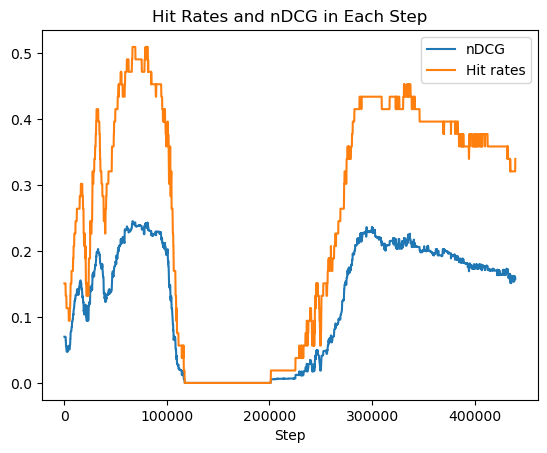

In [38]:
import matplotlib.pyplot as plt
plt.plot(steps, dcgs, label='nDCG')
plt.plot(steps, hits, label='Hit rates')


plt.xlabel('Step')
plt.title('Hit Rates and nDCG in Each Step')

plt.legend()
plt.show()

In [39]:
np.max(hits)

0.5094339622641509

In [40]:
np.max(dcgs)

0.24528001664077123

In [41]:
torch.save(policy_net.state_dict(), params['log_dir'] + 'policy_net_final.pth')
torch.save(value_net.state_dict(), params['log_dir'] + 'value_net_final.pth')
torch.save(state_repr_sac.state_dict(), params['log_dir'] + 'state_repr_final.pth')

NameError: name 'state_repr_sac' is not defined

In [ ]:
# we need memory for validation, so it's better to save it and not wait next time 
with open('logs/memory.pickle', 'wb') as f:
    pickle.dump(train_env.memory, f)
    
with open('logs/memory.pickle', 'rb') as f:
    memory = pickle.load(f)

In [ ]:
no_ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
no_ou_policy_net = PolicyNetwork(params['embedding_dim'], params['hidden_dim'])
no_ou_state_repr.load_state_dict(torch.load('logs/final/' + 'best_state_repr.pth'))
no_ou_policy_net.load_state_dict(torch.load('logs/final/' + 'best_policy_net.pth'))
    
hit, dcg = run_evaluation(no_ou_policy_net, no_ou_state_repr, memory, full_loader)
print('hit rate: ', hit, 'dcg: ', dcg)